In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gym

# Hyper Parameters
STATE_DIM = 4
ACTION_DIM = 2
STEP = 2000
SAMPLE_NUMS = 30


class ActorNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        out = F.log_softmax(out,dim=1)
        
        return out

class ValueNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

def plot(frame_idx, rewards):
#     clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

def test_environment(actor_network, value_network, step):
    steps =[]
    test_results =[]
    
    result = 0
    test_task = gym.make("CartPole-v0")
    for test_epi in range(10):
        state = test_task.reset()
        for test_step in range(200):
            softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
            #print(softmax_action.data)
            action = np.argmax(softmax_action.data.numpy()[0])
            next_state,reward,done,_ = test_task.step(action)
            result += reward
            state = next_state
            if done:
                break
    print("step:",step+1,"test result:",result/10.0)
    steps.append(step+1)
    test_results.append(result/10)
    
    return test_results

def roll_out(actor_network,task,sample_nums,value_network,init_state, step):
    states = []
    actions = []
    rewards = []
    is_done = False
    final_r = 0
    state = init_state

    for j in range(sample_nums):
        states.append(state)
        log_softmax_action = actor_network(Variable(torch.Tensor([state])))
        softmax_action = torch.exp(log_softmax_action)
        
        print("Actions prob in step {} in episode {}:".format(j, step), softmax_action.cpu().data.numpy()[0])

        action = np.random.choice(ACTION_DIM,p=softmax_action.cpu().data.numpy()[0])
        one_hot_action = [int(k == action) for k in range(ACTION_DIM)]
        next_state,reward,done,_ = task.step(action)
        #fix_reward = -10 if done else 1
        actions.append(one_hot_action)
        rewards.append(reward)
        final_state = next_state
        state = next_state
        if done:
            is_done = True
            state = task.reset()
            break
    if not is_done:
        final_r = value_network(Variable(torch.Tensor([final_state]))).cpu().data.numpy()

    return states,actions,rewards,final_r,state

def discount_reward(r, gamma,final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def train():
    # init a task generator for data fetching
    task = gym.make("CartPole-v0")
    init_state = task.reset()

    # init value network
    value_network = ValueNetwork(input_size = STATE_DIM,hidden_size = 40,output_size = 1)
    value_network_optim = torch.optim.Adam(value_network.parameters(),lr=0.01)

    # init actor network
    actor_network = ActorNetwork(STATE_DIM,40,ACTION_DIM)
    actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.01)

    idx = 0
    task_episodes = []    
    test_rewards = []

    for step in range(STEP):
        states,actions,rewards,final_r,current_state = roll_out(actor_network,task,SAMPLE_NUMS,value_network,init_state,step)
        init_state = current_state
        actions_var = Variable(torch.Tensor(actions).view(-1,ACTION_DIM))
        states_var = Variable(torch.Tensor(states).view(-1,STATE_DIM))

        # train actor network
        actor_network_optim.zero_grad()
        log_softmax_actions = actor_network(states_var)
        vs = value_network(states_var).detach()
        # calculate qs
        qs = torch.unsqueeze(Variable(torch.Tensor(discount_reward(rewards,0.99,final_r))), 1)

        advantages = qs - vs
        actor_network_loss = - torch.mean(torch.sum(log_softmax_actions*actions_var,1)* torch.squeeze(advantages, 1))
        actor_network_loss.backward()
        torch.nn.utils.clip_grad_norm_(actor_network.parameters(),0.5)
        actor_network_optim.step()

        # train value network
        value_network_optim.zero_grad()
        target_values = qs
        values = value_network(states_var)
        criterion = nn.MSELoss()
        value_network_loss = criterion(values,target_values)
        value_network_loss.backward()
        torch.nn.utils.clip_grad_norm_(value_network.parameters(),0.5)
        value_network_optim.step()

        # Testing
#         if (step + 1) % 50== 0:
        test_rewards.append(np.mean(test_environment(actor_network, value_network, step)))
        idx += 1
    plot(idx, test_rewards)
                

Actions prob in step 0 in episode 0: [0.48846516 0.5115348 ]
Actions prob in step 1 in episode 0: [0.48563606 0.51436394]
Actions prob in step 2 in episode 0: [0.48815978 0.5118402 ]
Actions prob in step 3 in episode 0: [0.4911153  0.50888467]
Actions prob in step 4 in episode 0: [0.4875897  0.51241034]
Actions prob in step 5 in episode 0: [0.4906006 0.5093995]
Actions prob in step 6 in episode 0: [0.48712465 0.5128754 ]
Actions prob in step 7 in episode 0: [0.4844017 0.5155983]
Actions prob in step 8 in episode 0: [0.47636083 0.5236392 ]
Actions prob in step 9 in episode 0: [0.46721774 0.53278226]
Actions prob in step 10 in episode 0: [0.47582138 0.5241786 ]
Actions prob in step 11 in episode 0: [0.48372814 0.5162719 ]
Actions prob in step 12 in episode 0: [0.47448874 0.5255112 ]
Actions prob in step 13 in episode 0: [0.46467492 0.5353251 ]
Actions prob in step 14 in episode 0: [0.4575204  0.54247963]
Actions prob in step 15 in episode 0: [0.45278665 0.5472134 ]
Actions prob in step 1

step: 11 test result: 20.0
Actions prob in step 0 in episode 11: [0.40154842 0.59845155]
Actions prob in step 1 in episode 11: [0.43971634 0.56028366]
Actions prob in step 2 in episode 11: [0.39995664 0.60004336]
Actions prob in step 3 in episode 11: [0.43721154 0.5627885 ]
Actions prob in step 4 in episode 11: [0.48509133 0.5149087 ]
Actions prob in step 5 in episode 11: [0.53093004 0.46907   ]
Actions prob in step 6 in episode 11: [0.48469508 0.515305  ]
Actions prob in step 7 in episode 11: [0.5303684 0.4696316]
Actions prob in step 8 in episode 11: [0.48602042 0.5139796 ]
Actions prob in step 9 in episode 11: [0.53125936 0.4687407 ]
Actions prob in step 10 in episode 11: [0.48907638 0.51092356]
Actions prob in step 11 in episode 11: [0.53417933 0.46582067]
Actions prob in step 12 in episode 11: [0.4938216  0.50617844]
Actions prob in step 13 in episode 11: [0.53874993 0.4612501 ]
Actions prob in step 14 in episode 11: [0.5000171  0.49998292]
Actions prob in step 15 in episode 11: [

Actions prob in step 29 in episode 19: [0.4107017  0.58929837]
step: 20 test result: 35.0
Actions prob in step 0 in episode 20: [0.6408958  0.35910428]
Actions prob in step 1 in episode 20: [0.7769075 0.2230925]
Actions prob in step 2 in episode 20: [0.854565   0.14543495]
Actions prob in step 3 in episode 20: [0.80076855 0.19923139]
step: 21 test result: 56.3
Actions prob in step 0 in episode 21: [0.386203 0.613797]
Actions prob in step 1 in episode 21: [0.56047535 0.43952468]
Actions prob in step 2 in episode 21: [0.38508797 0.614912  ]
Actions prob in step 3 in episode 21: [0.26456815 0.73543185]
Actions prob in step 4 in episode 21: [0.38331598 0.616684  ]
Actions prob in step 5 in episode 21: [0.2626621 0.7373379]
Actions prob in step 6 in episode 21: [0.38009605 0.619904  ]
Actions prob in step 7 in episode 21: [0.5479902  0.45200983]
Actions prob in step 8 in episode 21: [0.37671214 0.62328786]
Actions prob in step 9 in episode 21: [0.54280066 0.45719936]
Actions prob in step 10

step: 26 test result: 61.3
Actions prob in step 0 in episode 26: [0.30984315 0.6901568 ]
Actions prob in step 1 in episode 26: [0.5324285 0.4675715]
Actions prob in step 2 in episode 26: [0.745759   0.25424105]
Actions prob in step 3 in episode 26: [0.5294981  0.47050193]
Actions prob in step 4 in episode 26: [0.30559912 0.6944009 ]
Actions prob in step 5 in episode 26: [0.5251892  0.47481078]
Actions prob in step 6 in episode 26: [0.30149263 0.69850737]
Actions prob in step 7 in episode 26: [0.17714128 0.82285875]
Actions prob in step 8 in episode 26: [0.2928615 0.7071385]
Actions prob in step 9 in episode 26: [0.17090389 0.82909614]
Actions prob in step 10 in episode 26: [0.2800326  0.71996737]
Actions prob in step 11 in episode 26: [0.4828525  0.51714754]
Actions prob in step 12 in episode 26: [0.26580673 0.7341932 ]
Actions prob in step 13 in episode 26: [0.45816708 0.54183286]
Actions prob in step 14 in episode 26: [0.663922   0.33607805]
Actions prob in step 15 in episode 26: [0.

step: 32 test result: 107.8
Actions prob in step 0 in episode 32: [0.5271249  0.47287512]
Actions prob in step 1 in episode 32: [0.24215284 0.75784713]
Actions prob in step 2 in episode 32: [0.50473493 0.4952651 ]
Actions prob in step 3 in episode 32: [0.23081107 0.7691889 ]
Actions prob in step 4 in episode 32: [0.47884613 0.52115387]
Actions prob in step 5 in episode 32: [0.77388453 0.22611545]
Actions prob in step 6 in episode 32: [0.45734906 0.54265094]
Actions prob in step 7 in episode 32: [0.20953871 0.7904613 ]
Actions prob in step 8 in episode 32: [0.43249872 0.56750125]
Actions prob in step 9 in episode 32: [0.7365012  0.26349878]
Actions prob in step 10 in episode 32: [0.40779516 0.59220487]
Actions prob in step 11 in episode 32: [0.71728796 0.282712  ]
Actions prob in step 12 in episode 32: [0.9012094 0.0987906]
Actions prob in step 13 in episode 32: [0.70001143 0.29998863]
Actions prob in step 14 in episode 32: [0.37054214 0.6294579 ]
Actions prob in step 15 in episode 32: 

Actions prob in step 6 in episode 38: [0.633428 0.366572]
Actions prob in step 7 in episode 38: [0.26517287 0.73482716]
Actions prob in step 8 in episode 38: [0.12951656 0.8704834 ]
Actions prob in step 9 in episode 38: [0.26853418 0.7314658 ]
Actions prob in step 10 in episode 38: [0.648795   0.35120496]
Actions prob in step 11 in episode 38: [0.27125347 0.7287465 ]
Actions prob in step 12 in episode 38: [0.65311104 0.34688893]
Actions prob in step 13 in episode 38: [0.2738282 0.7261718]
Actions prob in step 14 in episode 38: [0.6567137 0.3432863]
Actions prob in step 15 in episode 38: [0.90620166 0.09379841]
Actions prob in step 16 in episode 38: [0.6652858  0.33471417]
Actions prob in step 17 in episode 38: [0.28543237 0.7145676 ]
Actions prob in step 18 in episode 38: [0.67385924 0.32614082]
Actions prob in step 19 in episode 38: [0.9134367  0.08656336]
Actions prob in step 20 in episode 38: [0.6875222  0.31247777]
Actions prob in step 21 in episode 38: [0.9192549  0.08074515]
Acti

step: 44 test result: 58.6
Actions prob in step 0 in episode 44: [0.97708225 0.02291769]
Actions prob in step 1 in episode 44: [0.88759977 0.11240016]
Actions prob in step 2 in episode 44: [0.5605193  0.43948072]
Actions prob in step 3 in episode 44: [0.20328762 0.7967124 ]
Actions prob in step 4 in episode 44: [0.09063634 0.9093637 ]
Actions prob in step 5 in episode 44: [0.04479866 0.9552014 ]
Actions prob in step 6 in episode 44: [0.08134507 0.918655  ]
Actions prob in step 7 in episode 44: [0.16446692 0.835533  ]
Actions prob in step 8 in episode 44: [0.42699158 0.5730084 ]
Actions prob in step 9 in episode 44: [0.14355409 0.85644585]
Actions prob in step 10 in episode 44: [0.36743328 0.63256675]
Actions prob in step 11 in episode 44: [0.12257898 0.877421  ]
Actions prob in step 12 in episode 44: [0.30461273 0.69538724]
Actions prob in step 13 in episode 44: [0.10280106 0.8971989 ]
Actions prob in step 14 in episode 44: [0.04788303 0.9521169 ]
Actions prob in step 15 in episode 44:

step: 50 test result: 89.5
Actions prob in step 0 in episode 50: [0.5450789  0.45492116]
Actions prob in step 1 in episode 50: [0.12784536 0.8721547 ]
Actions prob in step 2 in episode 50: [0.5240379  0.47596213]
Actions prob in step 3 in episode 50: [0.92839205 0.0716079 ]
Actions prob in step 4 in episode 50: [0.9864118  0.01358816]
Actions prob in step 5 in episode 50: [0.92876816 0.07123178]
Actions prob in step 6 in episode 50: [0.5191973  0.48080277]
Actions prob in step 7 in episode 50: [0.93047446 0.06952555]
Actions prob in step 8 in episode 50: [0.5284419  0.47155815]
Actions prob in step 9 in episode 50: [0.12736773 0.87263227]
Actions prob in step 10 in episode 50: [0.531829   0.46817106]
Actions prob in step 11 in episode 50: [0.9337543  0.06624565]
Actions prob in step 12 in episode 50: [0.5419111  0.45808887]
Actions prob in step 13 in episode 50: [0.13131562 0.8686844 ]
Actions prob in step 14 in episode 50: [0.04285641 0.95714355]
Actions prob in step 15 in episode 50:

step: 57 test result: 133.6
Actions prob in step 0 in episode 57: [0.8900492  0.10995076]
Actions prob in step 1 in episode 57: [0.33579233 0.66420764]
Actions prob in step 2 in episode 57: [0.04159169 0.95840836]
Actions prob in step 3 in episode 57: [0.2942139 0.7057861]
Actions prob in step 4 in episode 57: [0.03631473 0.96368533]
Actions prob in step 5 in episode 57: [0.2451236  0.75487643]
Actions prob in step 6 in episode 57: [0.7680764  0.23192361]
Actions prob in step 7 in episode 57: [0.20219247 0.7978075 ]
Actions prob in step 8 in episode 57: [0.02708805 0.9729119 ]
Actions prob in step 9 in episode 57: [0.00901816 0.9909819 ]
Actions prob in step 10 in episode 57: [0.02169057 0.9783094 ]
Actions prob in step 11 in episode 57: [0.10421366 0.89578635]
Actions prob in step 12 in episode 57: [0.5091758  0.49082422]
Actions prob in step 13 in episode 57: [0.8961964  0.10380357]
Actions prob in step 14 in episode 57: [0.40728286 0.5927171 ]
Actions prob in step 15 in episode 57: 

Actions prob in step 15 in episode 61: [0.16503966 0.8349604 ]
Actions prob in step 16 in episode 61: [0.74783474 0.2521653 ]
Actions prob in step 17 in episode 61: [0.25242716 0.7475729 ]
Actions prob in step 18 in episode 61: [0.04164328 0.9583568 ]
Actions prob in step 19 in episode 61: [0.359792 0.640208]
Actions prob in step 20 in episode 61: [0.89175004 0.10824993]
Actions prob in step 21 in episode 61: [0.9884198  0.01158021]
Actions prob in step 22 in episode 61: [0.9346147  0.06538532]
Actions prob in step 23 in episode 61: [0.9919701  0.00802988]
Actions prob in step 24 in episode 61: [0.95967734 0.04032265]
Actions prob in step 25 in episode 61: [0.81401676 0.18598321]
Actions prob in step 26 in episode 61: [0.35910705 0.6408929 ]
Actions prob in step 27 in episode 61: [0.9018782  0.09812178]
Actions prob in step 28 in episode 61: [0.55772406 0.44227594]
Actions prob in step 29 in episode 61: [0.94658077 0.05341928]
step: 62 test result: 151.1
Actions prob in step 0 in episo

step: 68 test result: 100.3
Actions prob in step 0 in episode 68: [0.5677108  0.43228918]
Actions prob in step 1 in episode 68: [0.03855193 0.961448  ]
Actions prob in step 2 in episode 68: [0.41276863 0.58723134]
Actions prob in step 3 in episode 68: [0.02140752 0.97859246]
Actions prob in step 4 in episode 68: [0.25748333 0.74251664]
Actions prob in step 5 in episode 68: [0.85345966 0.14654031]
Actions prob in step 6 in episode 68: [0.14550848 0.85449153]
Actions prob in step 7 in episode 68: [0.74462956 0.25537044]
Actions prob in step 8 in episode 68: [0.9719069  0.02809317]
Actions prob in step 9 in episode 68: [0.57480705 0.42519295]
Actions prob in step 10 in episode 68: [0.9467611  0.05323894]
Actions prob in step 11 in episode 68: [0.37550265 0.62449735]
Actions prob in step 12 in episode 68: [0.01718868 0.98281133]
step: 69 test result: 80.3
Actions prob in step 0 in episode 69: [0.59755266 0.40244737]
Actions prob in step 1 in episode 69: [0.98538095 0.01461911]
Actions prob

Actions prob in step 10 in episode 75: [0.9734736  0.02652636]
Actions prob in step 11 in episode 75: [0.27405274 0.72594726]
Actions prob in step 12 in episode 75: [0.9734658  0.02653423]
Actions prob in step 13 in episode 75: [0.2711112 0.7288888]
Actions prob in step 14 in episode 75: [0.01962344 0.9803766 ]
Actions prob in step 15 in episode 75: [0.24537447 0.7546255 ]
Actions prob in step 16 in episode 75: [0.96767396 0.03232607]
Actions prob in step 17 in episode 75: [0.21846052 0.7815395 ]
Actions prob in step 18 in episode 75: [0.962226   0.03777399]
Actions prob in step 19 in episode 75: [0.19011718 0.80988276]
Actions prob in step 20 in episode 75: [0.9545406  0.04545939]
Actions prob in step 21 in episode 75: [0.16321301 0.836787  ]
Actions prob in step 22 in episode 75: [0.9437799  0.05622018]
Actions prob in step 23 in episode 75: [0.13969943 0.8603006 ]
Actions prob in step 24 in episode 75: [0.92833865 0.07166141]
Actions prob in step 25 in episode 75: [0.11857855 0.8814

step: 82 test result: 47.2
Actions prob in step 0 in episode 82: [0.92416096 0.07583906]
Actions prob in step 1 in episode 82: [0.1388536 0.8611464]
Actions prob in step 2 in episode 82: [0.85231245 0.14768758]
Actions prob in step 3 in episode 82: [0.06553957 0.9344604 ]
Actions prob in step 4 in episode 82: [0.7031534  0.29684663]
Actions prob in step 5 in episode 82: [0.0282308 0.9717692]
Actions prob in step 6 in episode 82: [0.46772018 0.53227985]
Actions prob in step 7 in episode 82: [0.01187957 0.98812044]
step: 83 test result: 66.3
Actions prob in step 0 in episode 83: [0.8452441  0.15475592]
Actions prob in step 1 in episode 83: [0.9953987  0.00460131]
Actions prob in step 2 in episode 83: [0.7877351  0.21226488]
Actions prob in step 3 in episode 83: [0.03393793 0.9660621 ]
Actions prob in step 4 in episode 83: [0.71021575 0.28978425]
Actions prob in step 5 in episode 83: [0.99281    0.00718996]
Actions prob in step 6 in episode 83: [0.62922794 0.37077206]
Actions prob in step

step: 89 test result: 112.9
Actions prob in step 0 in episode 89: [0.0167212 0.9832788]
Actions prob in step 1 in episode 89: [0.33602482 0.6639752 ]
Actions prob in step 2 in episode 89: [0.01371563 0.9862844 ]
Actions prob in step 3 in episode 89: [0.2334431  0.76655686]
Actions prob in step 4 in episode 89: [0.9407278  0.05927217]
Actions prob in step 5 in episode 89: [0.16043481 0.8395652 ]
Actions prob in step 6 in episode 89: [0.00873208 0.991268  ]
Actions prob in step 7 in episode 89: [0.10197264 0.8980273 ]
Actions prob in step 8 in episode 89: [0.83043045 0.16956958]
Actions prob in step 9 in episode 89: [0.98976994 0.01023007]
Actions prob in step 10 in episode 89: [0.7328767 0.2671233]
Actions prob in step 11 in episode 89: [0.9850675  0.01493247]
Actions prob in step 12 in episode 89: [0.60817343 0.39182654]
Actions prob in step 13 in episode 89: [0.02824774 0.9717523 ]
Actions prob in step 14 in episode 89: [0.45837817 0.54162186]
Actions prob in step 15 in episode 89: [0

Actions prob in step 22 in episode 93: [0.52143025 0.4785698 ]
Actions prob in step 23 in episode 93: [0.02013457 0.9798654 ]
Actions prob in step 24 in episode 93: [0.3696922  0.63030785]
Actions prob in step 25 in episode 93: [0.0125822 0.9874178]
Actions prob in step 26 in episode 93: [0.2385091 0.7614909]
Actions prob in step 27 in episode 93: [0.90575016 0.09424981]
Actions prob in step 28 in episode 93: [0.99139625 0.00860379]
Actions prob in step 29 in episode 93: [0.8428159 0.1571841]
step: 94 test result: 137.2
Actions prob in step 0 in episode 94: [0.06604432 0.9339557 ]
Actions prob in step 1 in episode 94: [0.6764786  0.32352138]
Actions prob in step 2 in episode 94: [0.03511475 0.96488523]
Actions prob in step 3 in episode 94: [0.48748696 0.51251304]
Actions prob in step 4 in episode 94: [0.94667923 0.05332073]
Actions prob in step 5 in episode 94: [0.3011013 0.6988987]
Actions prob in step 6 in episode 94: [0.89885765 0.10114237]
Actions prob in step 7 in episode 94: [0.1

step: 100 test result: 104.7
Actions prob in step 0 in episode 100: [0.93554276 0.06445716]
Actions prob in step 1 in episode 100: [0.4011718 0.5988282]
Actions prob in step 2 in episode 100: [0.9626407  0.03735927]
Actions prob in step 3 in episode 100: [0.6117878  0.38821217]
Actions prob in step 4 in episode 100: [0.9777464  0.02225358]
Actions prob in step 5 in episode 100: [0.80073476 0.19926518]
Actions prob in step 6 in episode 100: [0.15336542 0.8466346 ]
Actions prob in step 7 in episode 100: [0.00839623 0.9916038 ]
Actions prob in step 8 in episode 100: [0.31184277 0.6881572 ]
Actions prob in step 9 in episode 100: [0.94741493 0.05258502]
Actions prob in step 10 in episode 100: [0.55370283 0.4462972 ]
Actions prob in step 11 in episode 100: [0.9722083  0.02779164]
Actions prob in step 12 in episode 100: [0.7881088  0.21189122]
Actions prob in step 13 in episode 100: [0.14748554 0.8525145 ]
Actions prob in step 14 in episode 100: [0.91249394 0.08750612]
Actions prob in step 15

Actions prob in step 10 in episode 107: [0.6577939  0.34220612]
Actions prob in step 11 in episode 107: [0.05577435 0.9442256 ]
Actions prob in step 12 in episode 107: [0.7869932  0.21300672]
Actions prob in step 13 in episode 107: [0.1110977  0.88890225]
Actions prob in step 14 in episode 107: [0.87358856 0.12641145]
Actions prob in step 15 in episode 107: [0.2270062  0.77299374]
Actions prob in step 16 in episode 107: [0.01636171 0.9836383 ]
Actions prob in step 17 in episode 107: [0.3982813 0.6017187]
Actions prob in step 18 in episode 107: [0.9493262  0.05067378]
Actions prob in step 19 in episode 107: [0.6018063  0.39819378]
Actions prob in step 20 in episode 107: [0.07057235 0.9294277 ]
Actions prob in step 21 in episode 107: [0.7817148  0.21828522]
Actions prob in step 22 in episode 107: [0.9791504  0.02084957]
Actions prob in step 23 in episode 107: [0.8916929  0.10830711]
Actions prob in step 24 in episode 107: [0.37493503 0.62506497]
Actions prob in step 25 in episode 107: [0

step: 116 test result: 37.4
Actions prob in step 0 in episode 116: [0.7935935  0.20640649]
Actions prob in step 1 in episode 116: [0.39030725 0.60969275]
Actions prob in step 2 in episode 116: [0.8906687  0.10933129]
Actions prob in step 3 in episode 116: [0.6028471 0.3971529]
step: 117 test result: 34.7
Actions prob in step 0 in episode 117: [0.04550124 0.9544988 ]
Actions prob in step 1 in episode 117: [0.00548025 0.99451977]
Actions prob in step 2 in episode 117: [0.04899051 0.95100945]
Actions prob in step 3 in episode 117: [0.5197471 0.4802529]
Actions prob in step 4 in episode 117: [0.05663673 0.9433633 ]
Actions prob in step 5 in episode 117: [0.5555593 0.4444407]
Actions prob in step 6 in episode 117: [0.0685508 0.9314492]
Actions prob in step 7 in episode 117: [0.59821445 0.40178552]
Actions prob in step 8 in episode 117: [0.9449193 0.0550807]
Actions prob in step 9 in episode 117: [0.98821265 0.01178742]
Actions prob in step 10 in episode 117: [0.9587239  0.04127612]
Actions 

step: 125 test result: 71.7
Actions prob in step 0 in episode 125: [0.9512886  0.04871141]
Actions prob in step 1 in episode 125: [0.76985526 0.23014466]
Actions prob in step 2 in episode 125: [0.9699839  0.03001605]
Actions prob in step 3 in episode 125: [0.88271266 0.11728732]
Actions prob in step 4 in episode 125: [0.54860574 0.4513943 ]
Actions prob in step 5 in episode 125: [0.11770135 0.88229865]
Actions prob in step 6 in episode 125: [0.74938995 0.2506101 ]
Actions prob in step 7 in episode 125: [0.95954835 0.04045162]
Actions prob in step 8 in episode 125: [0.86533546 0.13466452]
Actions prob in step 9 in episode 125: [0.55441606 0.44558397]
Actions prob in step 10 in episode 125: [0.11627549 0.8837245 ]
Actions prob in step 11 in episode 125: [0.76300377 0.23699634]
Actions prob in step 12 in episode 125: [0.29281723 0.7071828 ]
Actions prob in step 13 in episode 125: [0.8703172  0.12968276]
Actions prob in step 14 in episode 125: [0.54570127 0.45429873]
Actions prob in step 1

step: 131 test result: 76.7
Actions prob in step 0 in episode 131: [0.5712026  0.42879745]
Actions prob in step 1 in episode 131: [0.11687795 0.8831221 ]
Actions prob in step 2 in episode 131: [0.7353233 0.2646767]
Actions prob in step 3 in episode 131: [0.25101304 0.748987  ]
Actions prob in step 4 in episode 131: [0.8543658  0.14563411]
Actions prob in step 5 in episode 131: [0.9675904  0.03240963]
Actions prob in step 6 in episode 131: [0.9236379  0.07636207]
Actions prob in step 7 in episode 131: [0.97871876 0.0212813 ]
Actions prob in step 8 in episode 131: [0.9574935  0.04250657]
step: 132 test result: 70.7
Actions prob in step 0 in episode 132: [0.10441037 0.8955897 ]
Actions prob in step 1 in episode 132: [0.73242867 0.26757127]
Actions prob in step 2 in episode 132: [0.97132295 0.02867704]
Actions prob in step 3 in episode 132: [0.7853525  0.21464744]
Actions prob in step 4 in episode 132: [0.97585243 0.02414757]
Actions prob in step 5 in episode 132: [0.8425488  0.15745114]
A

step: 137 test result: 73.5
Actions prob in step 0 in episode 137: [0.89470047 0.10529951]
Actions prob in step 1 in episode 137: [0.5682155 0.4317845]
Actions prob in step 2 in episode 137: [0.16343364 0.8365663 ]
Actions prob in step 3 in episode 137: [0.75865996 0.24134007]
Actions prob in step 4 in episode 137: [0.327767 0.672233]
Actions prob in step 5 in episode 137: [0.88696903 0.11303096]
step: 138 test result: 78.3
Actions prob in step 0 in episode 138: [0.13423964 0.8657603 ]
Actions prob in step 1 in episode 138: [0.72067183 0.27932817]
Actions prob in step 2 in episode 138: [0.16944063 0.8305594 ]
Actions prob in step 3 in episode 138: [0.7666806  0.23331937]
Actions prob in step 4 in episode 138: [0.9733462  0.02665386]
Actions prob in step 5 in episode 138: [0.8305284  0.16947159]
Actions prob in step 6 in episode 138: [0.31448418 0.6855158 ]
Actions prob in step 7 in episode 138: [0.88069475 0.11930527]
Actions prob in step 8 in episode 138: [0.9824019  0.01759811]
Actio

step: 144 test result: 50.7
Actions prob in step 0 in episode 144: [0.77935755 0.22064245]
Actions prob in step 1 in episode 144: [0.95380735 0.04619268]
Actions prob in step 2 in episode 144: [0.8708837  0.12911628]
Actions prob in step 3 in episode 144: [0.5920153 0.4079847]
Actions prob in step 4 in episode 144: [0.19609858 0.80390143]
Actions prob in step 5 in episode 144: [0.75545883 0.24454121]
Actions prob in step 6 in episode 144: [0.34825745 0.6517426 ]
Actions prob in step 7 in episode 144: [0.85937583 0.14062421]
Actions prob in step 8 in episode 144: [0.9629929  0.03700708]
Actions prob in step 9 in episode 144: [0.9194147  0.08058538]
step: 145 test result: 50.0
Actions prob in step 0 in episode 145: [0.05171556 0.9482845 ]
Actions prob in step 1 in episode 145: [0.44778782 0.5522122 ]
Actions prob in step 2 in episode 145: [0.89421284 0.1057872 ]
Actions prob in step 3 in episode 145: [0.510603   0.48939696]
Actions prob in step 4 in episode 145: [0.08410887 0.9158911 ]
A

step: 152 test result: 46.0
Actions prob in step 0 in episode 152: [0.18343538 0.8165647 ]
Actions prob in step 1 in episode 152: [0.786499   0.21350105]
Actions prob in step 2 in episode 152: [0.31631002 0.68368995]
Actions prob in step 3 in episode 152: [0.8640369  0.13596313]
Actions prob in step 4 in episode 152: [0.4887266 0.5112734]
Actions prob in step 5 in episode 152: [0.10390338 0.89609665]
Actions prob in step 6 in episode 152: [0.01340721 0.9865928 ]
Actions prob in step 7 in episode 152: [0.17539364 0.8246063 ]
Actions prob in step 8 in episode 152: [0.7595417  0.24045828]
Actions prob in step 9 in episode 152: [0.29507837 0.7049216 ]
Actions prob in step 10 in episode 152: [0.0471659 0.9528341]
Actions prob in step 11 in episode 152: [0.4276601  0.57233995]
Actions prob in step 12 in episode 152: [0.08702903 0.91297096]
Actions prob in step 13 in episode 152: [0.5754577  0.42454228]
Actions prob in step 14 in episode 152: [0.9307049  0.06929513]
Actions prob in step 15 in

step: 158 test result: 46.6
Actions prob in step 0 in episode 158: [0.05962556 0.94037443]
Actions prob in step 1 in episode 158: [0.5301342  0.46986577]
Actions prob in step 2 in episode 158: [0.05798439 0.94201565]
Actions prob in step 3 in episode 158: [0.52907276 0.47092724]
Actions prob in step 4 in episode 158: [0.05876099 0.941239  ]
Actions prob in step 5 in episode 158: [0.5375881  0.46241188]
Actions prob in step 6 in episode 158: [0.06200795 0.93799204]
Actions prob in step 7 in episode 158: [0.55559385 0.44440615]
Actions prob in step 8 in episode 158: [0.06826882 0.9317312 ]
Actions prob in step 9 in episode 158: [0.5830582  0.41694188]
Actions prob in step 10 in episode 158: [0.07772984 0.9222702 ]
Actions prob in step 11 in episode 158: [0.6197918  0.38020816]
Actions prob in step 12 in episode 158: [0.09149151 0.90850854]
Actions prob in step 13 in episode 158: [0.66511726 0.33488274]
Actions prob in step 14 in episode 158: [0.966203 0.033797]
Actions prob in step 15 in

step: 163 test result: 62.8
Actions prob in step 0 in episode 163: [0.24609466 0.75390536]
Actions prob in step 1 in episode 163: [0.02379017 0.9762098 ]
Actions prob in step 2 in episode 163: [0.3313296 0.6686704]
Actions prob in step 3 in episode 163: [0.92666    0.07334001]
Actions prob in step 4 in episode 163: [0.463541 0.536459]
Actions prob in step 5 in episode 163: [0.0504306 0.9495694]
Actions prob in step 6 in episode 163: [0.58661395 0.41338602]
Actions prob in step 7 in episode 163: [0.08076815 0.91923183]
Actions prob in step 8 in episode 163: [0.6890272  0.31097287]
Actions prob in step 9 in episode 163: [0.12512657 0.8748734 ]
Actions prob in step 10 in episode 163: [0.78355336 0.21644664]
Actions prob in step 11 in episode 163: [0.981574 0.018426]
Actions prob in step 12 in episode 163: [0.8791785  0.12082148]
Actions prob in step 13 in episode 163: [0.3434569 0.6565431]
Actions prob in step 14 in episode 163: [0.04212512 0.95787483]
Actions prob in step 15 in episode 1

step: 169 test result: 77.1
Actions prob in step 0 in episode 169: [0.9059349  0.09406513]
Actions prob in step 1 in episode 169: [0.9924327  0.00756731]
Actions prob in step 2 in episode 169: [0.95946443 0.04053555]
Actions prob in step 3 in episode 169: [0.7298307  0.27016932]
Actions prob in step 4 in episode 169: [0.22785097 0.772149  ]
Actions prob in step 5 in episode 169: [0.03218055 0.96781945]
Actions prob in step 6 in episode 169: [0.41457558 0.5854245 ]
Actions prob in step 7 in episode 169: [0.07544281 0.92455715]
Actions prob in step 8 in episode 169: [0.00895623 0.9910438 ]
Actions prob in step 9 in episode 169: [0.15925953 0.8407405 ]
Actions prob in step 10 in episode 169: [0.81553215 0.18446782]
Actions prob in step 11 in episode 169: [0.33382344 0.66617656]
Actions prob in step 12 in episode 169: [0.9271679  0.07283207]
step: 170 test result: 65.1
Actions prob in step 0 in episode 170: [0.1252219  0.87477815]
Actions prob in step 1 in episode 170: [0.81905323 0.180946

step: 175 test result: 55.3
Actions prob in step 0 in episode 175: [0.9763914  0.02360865]
Actions prob in step 1 in episode 175: [0.6471488 0.3528512]
Actions prob in step 2 in episode 175: [0.08651551 0.91348445]
Actions prob in step 3 in episode 175: [0.7667855  0.23321448]
Actions prob in step 4 in episode 175: [0.14682128 0.85317874]
Actions prob in step 5 in episode 175: [0.85920566 0.14079432]
Actions prob in step 6 in episode 175: [0.99264574 0.0073543 ]
Actions prob in step 7 in episode 175: [0.93615985 0.06384022]
Actions prob in step 8 in episode 175: [0.43044928 0.56955075]
Actions prob in step 9 in episode 175: [0.9703564  0.02964353]
Actions prob in step 10 in episode 175: [0.6348891  0.36511084]
Actions prob in step 11 in episode 175: [0.12052591 0.87947404]
Actions prob in step 12 in episode 175: [0.8004278  0.19957224]
Actions prob in step 13 in episode 175: [0.23739633 0.76260364]
Actions prob in step 14 in episode 175: [0.9104763  0.08952366]
Actions prob in step 15 

step: 181 test result: 78.4
Actions prob in step 0 in episode 181: [0.29079294 0.709207  ]
Actions prob in step 1 in episode 181: [0.95239085 0.04760921]
Actions prob in step 2 in episode 181: [0.46233374 0.53766626]
Actions prob in step 3 in episode 181: [0.05701239 0.9429877 ]
Actions prob in step 4 in episode 181: [0.63612616 0.3638738 ]
Actions prob in step 5 in episode 181: [0.9879111  0.01208888]
Actions prob in step 6 in episode 181: [0.80925375 0.19074622]
Actions prob in step 7 in episode 181: [0.23282167 0.76717836]
Actions prob in step 8 in episode 181: [0.9178126  0.08218738]
Actions prob in step 9 in episode 181: [0.42408466 0.57591534]
Actions prob in step 10 in episode 181: [0.05449913 0.9455008 ]
Actions prob in step 11 in episode 181: [0.641054 0.358946]
Actions prob in step 12 in episode 181: [0.9869174  0.01308263]
Actions prob in step 13 in episode 181: [0.8365349  0.16346513]
Actions prob in step 14 in episode 181: [0.2904267  0.70957327]
Actions prob in step 15 in

step: 187 test result: 72.5
Actions prob in step 0 in episode 187: [0.22576143 0.7742385 ]
Actions prob in step 1 in episode 187: [0.01899301 0.9810069 ]
Actions prob in step 2 in episode 187: [0.23371689 0.7662831 ]
Actions prob in step 3 in episode 187: [0.9419099  0.05809012]
Actions prob in step 4 in episode 187: [0.26172358 0.7382764 ]
Actions prob in step 5 in episode 187: [0.9513318  0.04866813]
Actions prob in step 6 in episode 187: [0.3024271  0.69757295]
Actions prob in step 7 in episode 187: [0.02369355 0.9763065 ]
Actions prob in step 8 in episode 187: [0.32743475 0.6725653 ]
Actions prob in step 9 in episode 187: [0.96536195 0.03463805]
Actions prob in step 10 in episode 187: [0.38088354 0.6191164 ]
Actions prob in step 11 in episode 187: [0.02847305 0.971527  ]
Actions prob in step 12 in episode 187: [0.4198251 0.5801749]
Actions prob in step 13 in episode 187: [0.03051511 0.9694849 ]
Actions prob in step 14 in episode 187: [0.45580053 0.54419947]
Actions prob in step 15 

step: 193 test result: 86.9
Actions prob in step 0 in episode 193: [0.31006098 0.68993896]
Actions prob in step 1 in episode 193: [0.9579039  0.04209608]
Actions prob in step 2 in episode 193: [0.38889214 0.6111079 ]
Actions prob in step 3 in episode 193: [0.96993357 0.03006645]
Actions prob in step 4 in episode 193: [0.4861421  0.51385784]
Actions prob in step 5 in episode 193: [0.9783781  0.02162191]
Actions prob in step 6 in episode 193: [0.602075   0.39792502]
Actions prob in step 7 in episode 193: [0.06862391 0.93137604]
Actions prob in step 8 in episode 193: [0.69496775 0.30503228]
Actions prob in step 9 in episode 193: [0.09982865 0.9001714 ]
Actions prob in step 10 in episode 193: [0.7733277  0.22667232]
Actions prob in step 11 in episode 193: [0.14252345 0.85747653]
Actions prob in step 12 in episode 193: [0.84286 0.15714]
Actions prob in step 13 in episode 193: [0.19164118 0.80835885]
Actions prob in step 14 in episode 193: [0.89173007 0.1082699 ]
Actions prob in step 15 in e

Actions prob in step 23 in episode 198: [0.5880278  0.41197225]
Actions prob in step 24 in episode 198: [0.04492772 0.9550723 ]
Actions prob in step 25 in episode 198: [0.51865184 0.48134813]
Actions prob in step 26 in episode 198: [0.03854353 0.9614565 ]
Actions prob in step 27 in episode 198: [0.44010037 0.55989957]
Actions prob in step 28 in episode 198: [0.9699944  0.03000556]
Actions prob in step 29 in episode 198: [0.38344744 0.61655253]
step: 199 test result: 145.1
Actions prob in step 0 in episode 199: [0.9675464  0.03245358]
Actions prob in step 1 in episode 199: [0.34977677 0.65022326]
Actions prob in step 2 in episode 199: [0.9596197  0.04038029]
Actions prob in step 3 in episode 199: [0.3035071 0.6964929]
Actions prob in step 4 in episode 199: [0.95014364 0.04985641]
Actions prob in step 5 in episode 199: [0.26337048 0.7366296 ]
Actions prob in step 6 in episode 199: [0.9389426  0.06105744]
Actions prob in step 7 in episode 199: [0.22982815 0.7701719 ]
Actions prob in step 

step: 204 test result: 191.0
Actions prob in step 0 in episode 204: [0.02669215 0.9733078 ]
Actions prob in step 1 in episode 204: [0.4411675 0.5588325]
Actions prob in step 2 in episode 204: [0.98379934 0.01620066]
Actions prob in step 3 in episode 204: [0.44841167 0.55158836]
Actions prob in step 4 in episode 204: [0.9840649  0.01593515]
Actions prob in step 5 in episode 204: [0.4629637  0.53703624]
Actions prob in step 6 in episode 204: [0.9845942  0.01540577]
Actions prob in step 7 in episode 204: [0.4848529 0.5151471]
Actions prob in step 8 in episode 204: [0.985385   0.01461498]
Actions prob in step 9 in episode 204: [0.514215   0.48578504]
Actions prob in step 10 in episode 204: [0.9864022  0.01359779]
Actions prob in step 11 in episode 204: [0.55114686 0.44885316]
Actions prob in step 12 in episode 204: [0.98754466 0.01245536]
Actions prob in step 13 in episode 204: [0.5937197 0.4062803]
Actions prob in step 14 in episode 204: [0.03477377 0.9652262 ]
Actions prob in step 15 in 

step: 209 test result: 116.8
Actions prob in step 0 in episode 209: [0.01068487 0.98931515]
Actions prob in step 1 in episode 209: [0.2754849 0.7245151]
Actions prob in step 2 in episode 209: [0.975652   0.02434797]
Actions prob in step 3 in episode 209: [0.29738986 0.70261014]
Actions prob in step 4 in episode 209: [0.01110863 0.98889136]
Actions prob in step 5 in episode 209: [0.3000476 0.6999524]
Actions prob in step 6 in episode 209: [0.01099399 0.98900604]
Actions prob in step 7 in episode 209: [0.29662752 0.7033724 ]
Actions prob in step 8 in episode 209: [0.978083   0.02191697]
Actions prob in step 9 in episode 209: [0.32041475 0.6795852 ]
Actions prob in step 10 in episode 209: [0.9806984  0.01930156]
Actions prob in step 11 in episode 209: [0.36158448 0.6384156 ]
Actions prob in step 12 in episode 209: [0.98389316 0.01610688]
Actions prob in step 13 in episode 209: [0.42495722 0.5750428 ]
Actions prob in step 14 in episode 209: [0.01644052 0.98355955]
Actions prob in step 15 i

step: 214 test result: 166.8
Actions prob in step 0 in episode 214: [0.5507111  0.44928893]
Actions prob in step 1 in episode 214: [0.98652923 0.01347077]
Actions prob in step 2 in episode 214: [0.53671694 0.46328306]
Actions prob in step 3 in episode 214: [0.0219728 0.9780272]
Actions prob in step 4 in episode 214: [0.48706594 0.512934  ]
Actions prob in step 5 in episode 214: [0.982938   0.01706199]
Actions prob in step 6 in episode 214: [0.4534666 0.5465334]
Actions prob in step 7 in episode 214: [0.9809121  0.01908797]
Actions prob in step 8 in episode 214: [0.42316446 0.57683563]
Actions prob in step 9 in episode 214: [0.01903168 0.9809683 ]
Actions prob in step 10 in episode 214: [0.3567227 0.6432772]
Actions prob in step 11 in episode 214: [0.9727332  0.02726675]
Actions prob in step 12 in episode 214: [0.3087528  0.69124717]
Actions prob in step 13 in episode 214: [0.01577002 0.98423   ]
Actions prob in step 14 in episode 214: [0.23606187 0.7639382 ]
Actions prob in step 15 in 

step: 220 test result: 170.0
Actions prob in step 0 in episode 220: [0.66470504 0.3352949 ]
Actions prob in step 1 in episode 220: [0.04393077 0.95606923]
Actions prob in step 2 in episode 220: [0.7203236  0.27967638]
Actions prob in step 3 in episode 220: [0.0605983 0.9394017]
Actions prob in step 4 in episode 220: [0.76904315 0.23095687]
Actions prob in step 5 in episode 220: [0.08274926 0.9172507 ]
Actions prob in step 6 in episode 220: [0.81533116 0.1846688 ]
Actions prob in step 7 in episode 220: [0.11049826 0.88950175]
Actions prob in step 8 in episode 220: [0.85812026 0.14187975]
Actions prob in step 9 in episode 220: [0.14560321 0.8543968 ]
Actions prob in step 10 in episode 220: [0.8952721  0.10472791]
Actions prob in step 11 in episode 220: [0.19334966 0.80665034]
Actions prob in step 12 in episode 220: [0.9260638 0.0739362]
Actions prob in step 13 in episode 220: [0.25880313 0.74119693]
Actions prob in step 14 in episode 220: [0.9502931  0.04970691]
Actions prob in step 15 i

step: 226 test result: 143.6
Actions prob in step 0 in episode 226: [0.21454048 0.7854595 ]
Actions prob in step 1 in episode 226: [0.97701776 0.02298225]
Actions prob in step 2 in episode 226: [0.25175008 0.7482499 ]
Actions prob in step 3 in episode 226: [0.00871798 0.991282  ]
Actions prob in step 4 in episode 226: [0.26935446 0.73064554]
Actions prob in step 5 in episode 226: [0.00887456 0.9911254 ]
Actions prob in step 6 in episode 226: [0.2745908  0.72540915]
Actions prob in step 7 in episode 226: [0.00879978 0.99120027]
Actions prob in step 8 in episode 226: [0.2673517 0.7326483]
Actions prob in step 9 in episode 226: [0.00850169 0.9914983 ]
Actions prob in step 10 in episode 226: [0.24831952 0.75168043]
Actions prob in step 11 in episode 226: [0.9786276  0.02137244]
Actions prob in step 12 in episode 226: [0.2525278  0.74747217]
Actions prob in step 13 in episode 226: [0.9794648  0.02053518]
Actions prob in step 14 in episode 226: [0.2695716 0.7304284]
Actions prob in step 15 i

Actions prob in step 8 in episode 231: [0.0955322 0.9044678]
Actions prob in step 9 in episode 231: [0.8942525  0.10574746]
Actions prob in step 10 in episode 231: [0.9955662  0.00443377]
Actions prob in step 11 in episode 231: [0.88277644 0.11722358]
Actions prob in step 12 in episode 231: [0.07054962 0.92945045]
Actions prob in step 13 in episode 231: [0.8654348  0.13456519]
Actions prob in step 14 in episode 231: [0.99499714 0.00500282]
Actions prob in step 15 in episode 231: [0.8659549  0.13404514]
Actions prob in step 16 in episode 231: [0.0650258 0.9349742]
Actions prob in step 17 in episode 231: [0.8607477  0.13925222]
Actions prob in step 18 in episode 231: [0.9949674  0.00503256]
Actions prob in step 19 in episode 231: [0.873992   0.12600793]
Actions prob in step 20 in episode 231: [0.07380092 0.9261991 ]
Actions prob in step 21 in episode 231: [0.00672846 0.9932715 ]
Actions prob in step 22 in episode 231: [0.06729761 0.9327024 ]
Actions prob in step 23 in episode 231: [0.864

step: 236 test result: 187.7
Actions prob in step 0 in episode 236: [0.9091527  0.09084736]
Actions prob in step 1 in episode 236: [0.17147212 0.82852787]
Actions prob in step 2 in episode 236: [0.88563395 0.11436598]
Actions prob in step 3 in episode 236: [0.13872072 0.8612793 ]
Actions prob in step 4 in episode 236: [0.8576196  0.14238042]
Actions prob in step 5 in episode 236: [0.99170965 0.00829034]
Actions prob in step 6 in episode 236: [0.8431782  0.15682174]
Actions prob in step 7 in episode 236: [0.9910972  0.00890276]
Actions prob in step 8 in episode 236: [0.83951056 0.16048945]
Actions prob in step 9 in episode 236: [0.1069163  0.89308363]
Actions prob in step 10 in episode 236: [0.82795966 0.17204036]
Actions prob in step 11 in episode 236: [0.09897043 0.9010296 ]
Actions prob in step 12 in episode 236: [0.8137294  0.18627055]
Actions prob in step 13 in episode 236: [0.0905823 0.9094177]
Actions prob in step 14 in episode 236: [0.7943135  0.20568655]
Actions prob in step 15

step: 241 test result: 159.5
Actions prob in step 0 in episode 241: [0.6725033  0.32749674]
Actions prob in step 1 in episode 241: [0.95749575 0.04250422]
Actions prob in step 2 in episode 241: [0.5816253  0.41837475]
Actions prob in step 3 in episode 241: [0.9370348  0.06296518]
Actions prob in step 4 in episode 241: [0.50156605 0.4984339 ]
Actions prob in step 5 in episode 241: [0.09823986 0.9017602 ]
Actions prob in step 6 in episode 241: [0.4033457 0.5966543]
Actions prob in step 7 in episode 241: [0.86159307 0.13840695]
Actions prob in step 8 in episode 241: [0.33162406 0.668376  ]
Actions prob in step 9 in episode 241: [0.06144475 0.93855524]
Actions prob in step 10 in episode 241: [0.01767867 0.9823214 ]
Actions prob in step 11 in episode 241: [0.04521922 0.95478076]
Actions prob in step 12 in episode 241: [0.18761802 0.81238204]
Actions prob in step 13 in episode 241: [0.55079794 0.44920206]
Actions prob in step 14 in episode 241: [0.1375437 0.8624563]
Actions prob in step 15 i

Actions prob in step 17 in episode 246: [0.8407266  0.15927336]
Actions prob in step 18 in episode 246: [0.9711571  0.02884295]
Actions prob in step 19 in episode 246: [0.76812917 0.23187082]
Actions prob in step 20 in episode 246: [0.32313466 0.67686534]
Actions prob in step 21 in episode 246: [0.10404354 0.8959565 ]
Actions prob in step 22 in episode 246: [0.26323375 0.7367662 ]
Actions prob in step 23 in episode 246: [0.5600632  0.43993688]
Actions prob in step 24 in episode 246: [0.21337381 0.78662616]
Actions prob in step 25 in episode 246: [0.4544303 0.5455697]
Actions prob in step 26 in episode 246: [0.17036946 0.8296305 ]
Actions prob in step 27 in episode 246: [0.36360532 0.63639474]
Actions prob in step 28 in episode 246: [0.7215379  0.27846208]
Actions prob in step 29 in episode 246: [0.9377287  0.06227126]
step: 247 test result: 133.4
Actions prob in step 0 in episode 247: [0.65681183 0.34318817]
Actions prob in step 1 in episode 247: [0.2952082 0.7047918]
Actions prob in s

step: 252 test result: 129.8
Actions prob in step 0 in episode 252: [0.07916635 0.9208336 ]
Actions prob in step 1 in episode 252: [0.19621627 0.8037838 ]
Actions prob in step 2 in episode 252: [0.5509326  0.44906744]
Actions prob in step 3 in episode 252: [0.14258549 0.8574145 ]
Actions prob in step 4 in episode 252: [0.41700107 0.58299893]
Actions prob in step 5 in episode 252: [0.10877311 0.8912269 ]
Actions prob in step 6 in episode 252: [0.28892398 0.711076  ]
Actions prob in step 7 in episode 252: [0.68367374 0.3163263 ]
Actions prob in step 8 in episode 252: [0.20377344 0.7962265 ]
Actions prob in step 9 in episode 252: [0.5581862 0.4418138]
Actions prob in step 10 in episode 252: [0.15618715 0.8438128 ]
Actions prob in step 11 in episode 252: [0.05584177 0.94415826]
Actions prob in step 12 in episode 252: [0.11296231 0.8870377 ]
Actions prob in step 13 in episode 252: [0.2663308 0.7336692]
Actions prob in step 14 in episode 252: [0.63076144 0.36923856]
Actions prob in step 15 i

step: 258 test result: 78.2
Actions prob in step 0 in episode 258: [0.17993516 0.82006484]
Actions prob in step 1 in episode 258: [0.5129349  0.48706508]
Actions prob in step 2 in episode 258: [0.12809989 0.8719001 ]
Actions prob in step 3 in episode 258: [0.3335592  0.66644084]
Actions prob in step 4 in episode 258: [0.08869074 0.91130924]
Actions prob in step 5 in episode 258: [0.22883958 0.7711605 ]
Actions prob in step 6 in episode 258: [0.5588462  0.44115376]
Actions prob in step 7 in episode 258: [0.883073   0.11692704]
Actions prob in step 8 in episode 258: [0.40829837 0.5917017 ]
Actions prob in step 9 in episode 258: [0.7849899  0.21501002]
Actions prob in step 10 in episode 258: [0.2993864 0.7006136]
Actions prob in step 11 in episode 258: [0.08588967 0.91411036]
Actions prob in step 12 in episode 258: [0.21720816 0.78279185]
Actions prob in step 13 in episode 258: [0.47370297 0.52629703]
Actions prob in step 14 in episode 258: [0.15500781 0.84499216]
Actions prob in step 15 

step: 264 test result: 96.8
Actions prob in step 0 in episode 264: [0.87895024 0.12104975]
Actions prob in step 1 in episode 264: [0.97979766 0.02020236]
Actions prob in step 2 in episode 264: [0.8904994  0.10950062]
Actions prob in step 3 in episode 264: [0.5489822  0.45101777]
Actions prob in step 4 in episode 264: [0.8942154 0.1057846]
Actions prob in step 5 in episode 264: [0.5573221  0.44267792]
Actions prob in step 6 in episode 264: [0.896399   0.10360095]
Actions prob in step 7 in episode 264: [0.9821247  0.01787525]
Actions prob in step 8 in episode 264: [0.9073059  0.09269408]
Actions prob in step 9 in episode 264: [0.9836624  0.01633755]
Actions prob in step 10 in episode 264: [0.92079103 0.07920893]
Actions prob in step 11 in episode 264: [0.6469069  0.35309312]
Actions prob in step 12 in episode 264: [0.9281289  0.07187114]
Actions prob in step 13 in episode 264: [0.66845965 0.33154035]
Actions prob in step 14 in episode 264: [0.20191897 0.79808104]
Actions prob in step 15 

Actions prob in step 10 in episode 269: [0.13975824 0.8602418 ]
Actions prob in step 11 in episode 269: [0.48254326 0.51745677]
Actions prob in step 12 in episode 269: [0.8376246  0.16237538]
Actions prob in step 13 in episode 269: [0.39762187 0.60237813]
Actions prob in step 14 in episode 269: [0.7770031  0.22299683]
Actions prob in step 15 in episode 269: [0.32006988 0.6799301 ]
Actions prob in step 16 in episode 269: [0.70410085 0.29589918]
Actions prob in step 17 in episode 269: [0.26188153 0.73811847]
Actions prob in step 18 in episode 269: [0.06268137 0.9373186 ]
Actions prob in step 19 in episode 269: [0.19631873 0.80368125]
Actions prob in step 20 in episode 269: [0.49239385 0.50760615]
Actions prob in step 21 in episode 269: [0.15236446 0.8476355 ]
Actions prob in step 22 in episode 269: [0.397 0.603]
Actions prob in step 23 in episode 269: [0.11647287 0.88352716]
Actions prob in step 24 in episode 269: [0.31233346 0.68766654]
Actions prob in step 25 in episode 269: [0.6336071

step: 275 test result: 80.3
Actions prob in step 0 in episode 275: [0.9395521  0.06044791]
Actions prob in step 1 in episode 275: [0.6387682 0.3612318]
Actions prob in step 2 in episode 275: [0.1431422  0.85685784]
Actions prob in step 3 in episode 275: [0.60325474 0.39674526]
Actions prob in step 4 in episode 275: [0.12476017 0.8752398 ]
Actions prob in step 5 in episode 275: [0.53818214 0.46181786]
Actions prob in step 6 in episode 275: [0.10460733 0.89539266]
Actions prob in step 7 in episode 275: [0.44227886 0.55772114]
Actions prob in step 8 in episode 275: [0.87996954 0.12003041]
Actions prob in step 9 in episode 275: [0.36005905 0.639941  ]
Actions prob in step 10 in episode 275: [0.8447427  0.15525725]
Actions prob in step 11 in episode 275: [0.28271326 0.7172867 ]
Actions prob in step 12 in episode 275: [0.7929415  0.20705853]
Actions prob in step 13 in episode 275: [0.20706798 0.792932  ]
Actions prob in step 14 in episode 275: [0.70048374 0.2995163 ]
Actions prob in step 15 

step: 281 test result: 81.0
Actions prob in step 0 in episode 281: [0.18974118 0.8102588 ]
Actions prob in step 1 in episode 281: [0.74432725 0.25567278]
Actions prob in step 2 in episode 281: [0.9722323  0.02776771]
Actions prob in step 3 in episode 281: [0.6056985  0.39430144]
Actions prob in step 4 in episode 281: [0.94971204 0.05028799]
Actions prob in step 5 in episode 281: [0.44701073 0.55298924]
Actions prob in step 6 in episode 281: [0.03926657 0.96073335]
Actions prob in step 7 in episode 281: [0.0103105  0.98968947]
Actions prob in step 8 in episode 281: [0.02331248 0.97668755]
Actions prob in step 9 in episode 281: [0.10465974 0.8953402 ]
Actions prob in step 10 in episode 281: [0.54029554 0.45970446]
Actions prob in step 11 in episode 281: [0.93475664 0.06524339]
Actions prob in step 12 in episode 281: [0.32884485 0.67115515]
Actions prob in step 13 in episode 281: [0.8460724 0.1539276]
Actions prob in step 14 in episode 281: [0.17063808 0.82936186]
Actions prob in step 15 

step: 287 test result: 84.4
Actions prob in step 0 in episode 287: [0.9613148 0.0386852]
Actions prob in step 1 in episode 287: [0.99623233 0.00376772]
Actions prob in step 2 in episode 287: [0.963534   0.03646596]
Actions prob in step 3 in episode 287: [0.56124717 0.4387529 ]
Actions prob in step 4 in episode 287: [0.96104705 0.03895295]
Actions prob in step 5 in episode 287: [0.5304859 0.4695141]
Actions prob in step 6 in episode 287: [0.95621777 0.04378218]
Actions prob in step 7 in episode 287: [0.4823468 0.5176532]
Actions prob in step 8 in episode 287: [0.03188341 0.9681166 ]
Actions prob in step 9 in episode 287: [0.36648908 0.6335109 ]
Actions prob in step 10 in episode 287: [0.02288927 0.97711074]
Actions prob in step 11 in episode 287: [0.22944908 0.7705509 ]
Actions prob in step 12 in episode 287: [0.86642    0.13358004]
Actions prob in step 13 in episode 287: [0.1357563 0.8642436]
Actions prob in step 14 in episode 287: [0.7650264  0.23497356]
Actions prob in step 15 in epi

Actions prob in step 0 in episode 293: [0.9833772  0.01662282]
Actions prob in step 1 in episode 293: [0.67708033 0.32291967]
Actions prob in step 2 in episode 293: [0.05109426 0.94890577]
Actions prob in step 3 in episode 293: [0.48331356 0.51668644]
Actions prob in step 4 in episode 293: [0.9500642  0.04993581]
Actions prob in step 5 in episode 293: [0.30050617 0.69949377]
Actions prob in step 6 in episode 293: [0.90894306 0.09105698]
Actions prob in step 7 in episode 293: [0.9934523  0.00654769]
Actions prob in step 8 in episode 293: [0.8331832  0.16681676]
Actions prob in step 9 in episode 293: [0.08913663 0.91086334]
Actions prob in step 10 in episode 293: [0.6571126 0.3428874]
Actions prob in step 11 in episode 293: [0.9731295  0.02687053]
Actions prob in step 12 in episode 293: [0.44663668 0.55336326]
Actions prob in step 13 in episode 293: [0.94595575 0.05404421]
Actions prob in step 14 in episode 293: [0.25599277 0.7440072 ]
Actions prob in step 15 in episode 293: [0.8801589  

step: 299 test result: 52.4
Actions prob in step 0 in episode 299: [0.54616827 0.45383176]
Actions prob in step 1 in episode 299: [0.02969693 0.9703031 ]
Actions prob in step 2 in episode 299: [0.20001087 0.79998916]
Actions prob in step 3 in episode 299: [0.75491    0.24509002]
Actions prob in step 4 in episode 299: [0.9833233  0.01667671]
Actions prob in step 5 in episode 299: [0.41438934 0.5856107 ]
Actions prob in step 6 in episode 299: [0.02282387 0.9771762 ]
Actions prob in step 7 in episode 299: [0.13571738 0.8642826 ]
Actions prob in step 8 in episode 299: [0.64130783 0.35869217]
Actions prob in step 9 in episode 299: [0.966048   0.03395204]
Actions prob in step 10 in episode 299: [0.27429807 0.72570187]
Actions prob in step 11 in episode 299: [0.01608064 0.9839193 ]
Actions prob in step 12 in episode 299: [0.0941008 0.9058992]
Actions prob in step 13 in episode 299: [0.449353 0.550647]
Actions prob in step 14 in episode 299: [0.9236892 0.0763108]
Actions prob in step 15 in epi

step: 305 test result: 83.5
Actions prob in step 0 in episode 305: [0.49872124 0.50127876]
Actions prob in step 1 in episode 305: [0.91250664 0.08749331]
Actions prob in step 2 in episode 305: [0.37353858 0.62646145]
Actions prob in step 3 in episode 305: [0.8665483  0.13345167]
Actions prob in step 4 in episode 305: [0.27538845 0.7246116 ]
Actions prob in step 5 in episode 305: [0.8097676  0.19023241]
Actions prob in step 6 in episode 305: [0.98058885 0.01941116]
Actions prob in step 7 in episode 305: [0.76735526 0.23264478]
Actions prob in step 8 in episode 305: [0.1868349 0.8131651]
Actions prob in step 9 in episode 305: [0.7133033 0.2866966]
Actions prob in step 10 in episode 305: [0.15530825 0.8446917 ]
step: 306 test result: 78.1
Actions prob in step 0 in episode 306: [0.9970283  0.00297177]
Actions prob in step 1 in episode 306: [0.9673594  0.03264058]
Actions prob in step 2 in episode 306: [0.538054 0.461946]
Actions prob in step 3 in episode 306: [0.95473087 0.04526918]
Action

step: 315 test result: 15.6
Actions prob in step 0 in episode 315: [0.9989737 0.0010263]
Actions prob in step 1 in episode 315: [0.99478865 0.0052113 ]
Actions prob in step 2 in episode 315: [0.95852095 0.04147905]
Actions prob in step 3 in episode 315: [0.54860437 0.45139563]
Actions prob in step 4 in episode 315: [0.10397727 0.89602274]
Actions prob in step 5 in episode 315: [0.33344358 0.6665565 ]
Actions prob in step 6 in episode 315: [0.78204334 0.21795663]
Actions prob in step 7 in episode 315: [0.1796422 0.8203578]
Actions prob in step 8 in episode 315: [0.48612237 0.51387763]
Actions prob in step 9 in episode 315: [0.85180336 0.14819662]
Actions prob in step 10 in episode 315: [0.22644515 0.77355486]
Actions prob in step 11 in episode 315: [0.03250515 0.96749485]
Actions prob in step 12 in episode 315: [0.07434162 0.9256584 ]
Actions prob in step 13 in episode 315: [0.1821444 0.8178556]
Actions prob in step 14 in episode 315: [0.02246545 0.97753453]
step: 316 test result: 16.7


Actions prob in step 9 in episode 330: [0.04830949 0.95169044]
step: 331 test result: 10.6
Actions prob in step 0 in episode 331: [9.9920386e-01 7.9619314e-04]
Actions prob in step 1 in episode 331: [0.997378   0.00262199]
Actions prob in step 2 in episode 331: [0.9858416  0.01415842]
Actions prob in step 3 in episode 331: [0.87996197 0.120038  ]
Actions prob in step 4 in episode 331: [0.7419206  0.25807938]
Actions prob in step 5 in episode 331: [0.5490427  0.45095727]
Actions prob in step 6 in episode 331: [0.3103844  0.68961555]
Actions prob in step 7 in episode 331: [0.351829   0.64817095]
Actions prob in step 8 in episode 331: [0.37544885 0.6245511 ]
Actions prob in step 9 in episode 331: [0.16979982 0.83020014]
step: 332 test result: 9.6
Actions prob in step 0 in episode 332: [9.994235e-01 5.765393e-04]
Actions prob in step 1 in episode 332: [0.99818534 0.00181467]
Actions prob in step 2 in episode 332: [0.9902291  0.00977095]
Actions prob in step 3 in episode 332: [0.92108953 0.

step: 349 test result: 10.7
Actions prob in step 0 in episode 349: [9.9955755e-01 4.4238142e-04]
Actions prob in step 1 in episode 349: [0.99869066 0.00130932]
Actions prob in step 2 in episode 349: [0.99315417 0.00684589]
Actions prob in step 3 in episode 349: [0.94380707 0.05619292]
Actions prob in step 4 in episode 349: [0.7872705  0.21272951]
Actions prob in step 5 in episode 349: [0.57193166 0.42806828]
Actions prob in step 6 in episode 349: [0.3081229 0.6918771]
Actions prob in step 7 in episode 349: [0.5033228  0.49667722]
Actions prob in step 8 in episode 349: [0.23846258 0.76153743]
Actions prob in step 9 in episode 349: [0.39551252 0.6044875 ]
Actions prob in step 10 in episode 349: [0.55229795 0.44770205]
Actions prob in step 11 in episode 349: [0.26936343 0.7306366 ]
step: 350 test result: 11.2
Actions prob in step 0 in episode 350: [9.991868e-01 8.131915e-04]
Actions prob in step 1 in episode 350: [0.99742633 0.00257362]
Actions prob in step 2 in episode 350: [0.9808621  0

step: 364 test result: 10.4
Actions prob in step 0 in episode 364: [9.9963474e-01 3.6523852e-04]
Actions prob in step 1 in episode 364: [0.9988587  0.00114131]
Actions prob in step 2 in episode 364: [0.9916939  0.00830609]
Actions prob in step 3 in episode 364: [0.94133615 0.05866378]
Actions prob in step 4 in episode 364: [0.8554228  0.14457715]
Actions prob in step 5 in episode 364: [0.6205672  0.37943277]
Actions prob in step 6 in episode 364: [0.78259766 0.21740235]
Actions prob in step 7 in episode 364: [0.4781133 0.5218867]
Actions prob in step 8 in episode 364: [0.1730801 0.8269199]
Actions prob in step 9 in episode 364: [0.04224888 0.95775115]
step: 365 test result: 10.1
Actions prob in step 0 in episode 365: [9.9943095e-01 5.6902174e-04]
Actions prob in step 1 in episode 365: [0.9973232  0.00267677]
Actions prob in step 2 in episode 365: [0.9727481  0.02725187]
Actions prob in step 3 in episode 365: [0.87479573 0.12520422]
Actions prob in step 4 in episode 365: [0.665713   0.3

step: 373 test result: 34.1
Actions prob in step 0 in episode 373: [0.99834156 0.0016584 ]
Actions prob in step 1 in episode 373: [0.9812572  0.01874281]
Actions prob in step 2 in episode 373: [0.46260133 0.53739864]
Actions prob in step 3 in episode 373: [0.9668273  0.03317276]
Actions prob in step 4 in episode 373: [0.2715084  0.72849154]
Actions prob in step 5 in episode 373: [0.92614526 0.07385473]
Actions prob in step 6 in episode 373: [0.1235109 0.8764891]
Actions prob in step 7 in episode 373: [0.7879022 0.2120978]
Actions prob in step 8 in episode 373: [0.05813407 0.94186586]
Actions prob in step 9 in episode 373: [0.48411798 0.515882  ]
Actions prob in step 10 in episode 373: [0.02565813 0.97434187]
Actions prob in step 11 in episode 373: [0.1726598  0.82734025]
Actions prob in step 12 in episode 373: [0.7295496  0.27045035]
Actions prob in step 13 in episode 373: [0.06666739 0.9333326 ]
Actions prob in step 14 in episode 373: [0.31816292 0.681837  ]
Actions prob in step 15 in

Actions prob in step 22 in episode 379: [0.88853824 0.11146168]
Actions prob in step 23 in episode 379: [0.33256218 0.6674378 ]
Actions prob in step 24 in episode 379: [0.8922356  0.10776439]
Actions prob in step 25 in episode 379: [0.33909002 0.66091   ]
Actions prob in step 26 in episode 379: [0.8902324  0.10976768]
Actions prob in step 27 in episode 379: [0.33451435 0.6654857 ]
Actions prob in step 28 in episode 379: [0.8824505  0.11754949]
Actions prob in step 29 in episode 379: [0.31861642 0.6813836 ]
step: 380 test result: 135.8
Actions prob in step 0 in episode 380: [0.02547634 0.97452366]
Actions prob in step 1 in episode 380: [0.2991114  0.70088863]
Actions prob in step 2 in episode 380: [0.8555754 0.1444246]
Actions prob in step 3 in episode 380: [0.24250114 0.7574989 ]
Actions prob in step 4 in episode 380: [0.01287007 0.98712987]
Actions prob in step 5 in episode 380: [0.15905394 0.8409461 ]
Actions prob in step 6 in episode 380: [0.66592765 0.33407232]
Actions prob in step

step: 385 test result: 145.2
Actions prob in step 0 in episode 385: [0.9854791 0.0145209]
Actions prob in step 1 in episode 385: [0.66019255 0.33980742]
Actions prob in step 2 in episode 385: [0.9804944 0.0195056]
Actions prob in step 3 in episode 385: [0.6008186 0.3991815]
Actions prob in step 4 in episode 385: [0.9747931 0.0252069]
Actions prob in step 5 in episode 385: [0.5465904  0.45340964]
Actions prob in step 6 in episode 385: [0.06185941 0.9381406 ]
step: 386 test result: 145.1
Actions prob in step 0 in episode 386: [0.9926004  0.00739955]
Actions prob in step 1 in episode 386: [0.6308653  0.36913475]
Actions prob in step 2 in episode 386: [0.00358783 0.9964122 ]
Actions prob in step 3 in episode 386: [0.5397187 0.4602813]
Actions prob in step 4 in episode 386: [0.990873   0.00912694]
Actions prob in step 5 in episode 386: [0.47476882 0.5252311 ]
Actions prob in step 6 in episode 386: [0.00202271 0.9979773 ]
Actions prob in step 7 in episode 386: [0.31934136 0.68065864]
Actions

Actions prob in step 5 in episode 390: [0.95707726 0.04292279]
Actions prob in step 6 in episode 390: [0.1779856  0.82201445]
Actions prob in step 7 in episode 390: [0.8658831 0.1341169]
Actions prob in step 8 in episode 390: [0.05163705 0.94836295]
Actions prob in step 9 in episode 390: [0.6309621  0.36903793]
Actions prob in step 10 in episode 390: [0.01497896 0.9850211 ]
Actions prob in step 11 in episode 390: [0.28352374 0.7164762 ]
Actions prob in step 12 in episode 390: [0.9138205  0.08617955]
Actions prob in step 13 in episode 390: [0.09152286 0.9084771 ]
Actions prob in step 14 in episode 390: [0.7216667 0.2783333]
Actions prob in step 15 in episode 390: [0.02632294 0.9736771 ]
Actions prob in step 16 in episode 390: [0.36011872 0.63988125]
Actions prob in step 17 in episode 390: [0.9354803  0.06451967]
Actions prob in step 18 in episode 390: [0.11961335 0.8803867 ]
Actions prob in step 19 in episode 390: [0.77187985 0.22812013]
Actions prob in step 20 in episode 390: [0.034320

step: 396 test result: 120.4
Actions prob in step 0 in episode 396: [0.82983404 0.17016602]
Actions prob in step 1 in episode 396: [0.0070918  0.99290824]
Actions prob in step 2 in episode 396: [0.5281516  0.47184843]
Actions prob in step 3 in episode 396: [0.00172162 0.9982784 ]
Actions prob in step 4 in episode 396: [0.18350627 0.81649375]
Actions prob in step 5 in episode 396: [0.97225475 0.02774528]
Actions prob in step 6 in episode 396: [0.0523352  0.94766486]
Actions prob in step 7 in episode 396: [0.89513373 0.10486626]
Actions prob in step 8 in episode 396: [0.01268937 0.98731065]
Actions prob in step 9 in episode 396: [0.66266996 0.33733007]
Actions prob in step 10 in episode 396: [0.00299097 0.9970091 ]
Actions prob in step 11 in episode 396: [0.28225636 0.71774364]
Actions prob in step 12 in episode 396: [9.8215567e-04 9.9901783e-01]
Actions prob in step 13 in episode 396: [0.06754161 0.93245834]
Actions prob in step 14 in episode 396: [4.2850157e-04 9.9957150e-01]
Actions p

step: 402 test result: 82.5
Actions prob in step 0 in episode 402: [0.9968041  0.00319593]
Actions prob in step 1 in episode 402: [0.65771925 0.3422807 ]
Actions prob in step 2 in episode 402: [0.00158414 0.9984158 ]
Actions prob in step 3 in episode 402: [0.3969932 0.6030067]
Actions prob in step 4 in episode 402: [7.437519e-04 9.992562e-01]
Actions prob in step 5 in episode 402: [0.14513542 0.85486454]
Actions prob in step 6 in episode 402: [0.97925436 0.02074566]
Actions prob in step 7 in episode 402: [0.04774814 0.9522519 ]
Actions prob in step 8 in episode 402: [0.94752985 0.05247011]
Actions prob in step 9 in episode 402: [0.01253446 0.98746556]
Actions prob in step 10 in episode 402: [0.8131672  0.18683282]
Actions prob in step 11 in episode 402: [0.00323091 0.9967691 ]
Actions prob in step 12 in episode 402: [0.4502998  0.54970026]
Actions prob in step 13 in episode 402: [0.00106313 0.99893683]
Actions prob in step 14 in episode 402: [0.10767145 0.8923286 ]
Actions prob in step

step: 408 test result: 81.2
Actions prob in step 0 in episode 408: [9.990089e-01 9.910782e-04]
Actions prob in step 1 in episode 408: [0.9708391  0.02916088]
Actions prob in step 2 in episode 408: [0.02804017 0.9719598 ]
Actions prob in step 3 in episode 408: [0.9539641 0.0460359]
Actions prob in step 4 in episode 408: [0.9986104  0.00138965]
Actions prob in step 5 in episode 408: [0.9366884  0.06331151]
Actions prob in step 6 in episode 408: [0.00820847 0.9917915 ]
Actions prob in step 7 in episode 408: [0.8675723  0.13242769]
Actions prob in step 8 in episode 408: [0.00336254 0.99663746]
Actions prob in step 9 in episode 408: [0.64832586 0.3516742 ]
Actions prob in step 10 in episode 408: [0.00126882 0.9987312 ]
Actions prob in step 11 in episode 408: [0.27684674 0.72315323]
Actions prob in step 12 in episode 408: [0.98567593 0.01432408]
Actions prob in step 13 in episode 408: [0.08201981 0.91798013]
Actions prob in step 14 in episode 408: [0.95640093 0.0435991 ]
Actions prob in step

step: 414 test result: 96.9
Actions prob in step 0 in episode 414: [0.99802256 0.00197747]
Actions prob in step 1 in episode 414: [0.9056251 0.0943749]
Actions prob in step 2 in episode 414: [0.00491054 0.9950895 ]
Actions prob in step 3 in episode 414: [0.74576527 0.25423467]
Actions prob in step 4 in episode 414: [0.00174071 0.99825925]
Actions prob in step 5 in episode 414: [0.39290836 0.6070916 ]
Actions prob in step 6 in episode 414: [6.1889307e-04 9.9938107e-01]
Actions prob in step 7 in episode 414: [0.0937949  0.90620506]
Actions prob in step 8 in episode 414: [0.9500215  0.04997849]
Actions prob in step 9 in episode 414: [0.01816384 0.9818362 ]
Actions prob in step 10 in episode 414: [0.7682901  0.23170988]
Actions prob in step 11 in episode 414: [0.9941273  0.00587273]
Actions prob in step 12 in episode 414: [0.39997798 0.600022  ]
Actions prob in step 13 in episode 414: [0.9822646  0.01773549]
Actions prob in step 14 in episode 414: [0.10915324 0.8908468 ]
Actions prob in st

step: 420 test result: 112.1
Actions prob in step 0 in episode 420: [0.04302781 0.95697224]
Actions prob in step 1 in episode 420: [0.68160427 0.3183957 ]
Actions prob in step 2 in episode 420: [0.02006935 0.97993064]
Actions prob in step 3 in episode 420: [0.42578185 0.57421815]
Actions prob in step 4 in episode 420: [0.98092306 0.0190769 ]
Actions prob in step 5 in episode 420: [0.26336342 0.7366366 ]
Actions prob in step 6 in episode 420: [0.95477116 0.04522888]
Actions prob in step 7 in episode 420: [0.14193112 0.85806894]
Actions prob in step 8 in episode 420: [0.8859164  0.11408363]
Actions prob in step 9 in episode 420: [0.06372509 0.9362749 ]
Actions prob in step 10 in episode 420: [0.7095369 0.2904631]
Actions prob in step 11 in episode 420: [0.02375366 0.9762464 ]
Actions prob in step 12 in episode 420: [0.42202488 0.57797515]
Actions prob in step 13 in episode 420: [0.97240156 0.02759846]
Actions prob in step 14 in episode 420: [0.21221419 0.7877858 ]
Actions prob in step 15

step: 426 test result: 158.1
Actions prob in step 0 in episode 426: [3.9890301e-04 9.9960107e-01]
Actions prob in step 1 in episode 426: [0.0041606 0.9958395]
Actions prob in step 2 in episode 426: [0.06739284 0.9326071 ]
Actions prob in step 3 in episode 426: [0.6083518  0.39164814]
Actions prob in step 4 in episode 426: [0.02206055 0.9779394 ]
Actions prob in step 5 in episode 426: [0.3288532  0.67114687]
Actions prob in step 6 in episode 426: [0.8988489  0.10115115]
Actions prob in step 7 in episode 426: [0.16574158 0.83425844]
Actions prob in step 8 in episode 426: [0.78686166 0.21313837]
Actions prob in step 9 in episode 426: [0.07080998 0.92919004]
Actions prob in step 10 in episode 426: [0.6034899  0.39651015]
step: 427 test result: 165.9
Actions prob in step 0 in episode 427: [0.9837481  0.01625188]
Actions prob in step 1 in episode 427: [0.15183951 0.84816056]
Actions prob in step 2 in episode 427: [0.96960044 0.03039949]
Actions prob in step 3 in episode 427: [0.06399569 0.93

step: 431 test result: 195.6
Actions prob in step 0 in episode 431: [0.8643439 0.1356561]
Actions prob in step 1 in episode 431: [0.16995335 0.8300467 ]
Actions prob in step 2 in episode 431: [0.8526294  0.14737056]
Actions prob in step 3 in episode 431: [0.16023095 0.83976907]
Actions prob in step 4 in episode 431: [0.8441144  0.15588556]
Actions prob in step 5 in episode 431: [0.15508005 0.84492   ]
Actions prob in step 6 in episode 431: [0.00432594 0.9956741 ]
Actions prob in step 7 in episode 431: [0.10854463 0.8914554 ]
Actions prob in step 8 in episode 431: [0.7714408  0.22855918]
Actions prob in step 9 in episode 431: [0.98217773 0.0178223 ]
Actions prob in step 10 in episode 431: [0.8023106  0.19768943]
Actions prob in step 11 in episode 431: [0.986204   0.01379598]
Actions prob in step 12 in episode 431: [0.8502862  0.14971383]
Actions prob in step 13 in episode 431: [0.18598574 0.81401426]
Actions prob in step 14 in episode 431: [0.86739016 0.13260984]
Actions prob in step 15

step: 437 test result: 200.0
Actions prob in step 0 in episode 437: [0.25377637 0.7462236 ]
Actions prob in step 1 in episode 437: [0.0017292  0.99827075]
Actions prob in step 2 in episode 437: [0.18607524 0.81392473]
Actions prob in step 3 in episode 437: [0.9237101 0.0762899]
Actions prob in step 4 in episode 437: [0.16425806 0.835742  ]
Actions prob in step 5 in episode 437: [0.91131943 0.08868055]
Actions prob in step 6 in episode 437: [0.13941383 0.8605861 ]
Actions prob in step 7 in episode 437: [0.8931106  0.10688944]
Actions prob in step 8 in episode 437: [0.113018   0.88698196]
Actions prob in step 9 in episode 437: [0.86657363 0.13342631]
Actions prob in step 10 in episode 437: [0.08682507 0.913175  ]
Actions prob in step 11 in episode 437: [0.8273192  0.17268077]
Actions prob in step 12 in episode 437: [0.06264985 0.93735015]
Actions prob in step 13 in episode 437: [0.7689521  0.23104793]
Actions prob in step 14 in episode 437: [0.04204177 0.95795816]
Actions prob in step 15

step: 442 test result: 200.0
Actions prob in step 0 in episode 442: [0.03011541 0.96988463]
Actions prob in step 1 in episode 442: [0.5042592 0.4957408]
Actions prob in step 2 in episode 442: [0.01966761 0.9803324 ]
Actions prob in step 3 in episode 442: [0.40040812 0.59959185]
Actions prob in step 4 in episode 442: [0.91905355 0.08094651]
Actions prob in step 5 in episode 442: [0.39322546 0.6067745 ]
Actions prob in step 6 in episode 442: [0.01262632 0.98737365]
Actions prob in step 7 in episode 442: [0.3142505 0.6857495]
Actions prob in step 8 in episode 442: [0.89055604 0.10944395]
Actions prob in step 9 in episode 442: [0.3219537 0.6780463]
Actions prob in step 10 in episode 442: [0.8969515  0.10304844]
Actions prob in step 11 in episode 442: [0.35419157 0.64580846]
Actions prob in step 12 in episode 442: [0.91143507 0.08856489]
Actions prob in step 13 in episode 442: [0.41401574 0.5859843 ]
Actions prob in step 14 in episode 442: [0.01564997 0.98434997]
Actions prob in step 15 in 

step: 447 test result: 197.9
Actions prob in step 0 in episode 447: [0.589651   0.41034898]
Actions prob in step 1 in episode 447: [0.96885777 0.03114223]
Actions prob in step 2 in episode 447: [0.69445544 0.30554456]
Actions prob in step 3 in episode 447: [0.05945802 0.9405419 ]
Actions prob in step 4 in episode 447: [0.7222702  0.27772975]
Actions prob in step 5 in episode 447: [0.06609493 0.93390507]
Actions prob in step 6 in episode 447: [0.73881334 0.2611867 ]
Actions prob in step 7 in episode 447: [0.98275167 0.0172483 ]
Actions prob in step 8 in episode 447: [0.8193501  0.18064994]
Actions prob in step 9 in episode 447: [0.1146604 0.8853396]
Actions prob in step 10 in episode 447: [0.8417885  0.15821153]
Actions prob in step 11 in episode 447: [0.13095815 0.86904186]
Actions prob in step 12 in episode 447: [0.85804814 0.14195187]
Actions prob in step 13 in episode 447: [0.14523795 0.854762  ]
Actions prob in step 14 in episode 447: [0.8698904  0.13010965]
Actions prob in step 15

step: 452 test result: 115.7
Actions prob in step 0 in episode 452: [0.072607   0.92739296]
Actions prob in step 1 in episode 452: [0.8769363  0.12306373]
Actions prob in step 2 in episode 452: [0.27157497 0.728425  ]
Actions prob in step 3 in episode 452: [0.94605666 0.05394327]
Actions prob in step 4 in episode 452: [0.59825486 0.40174514]
Actions prob in step 5 in episode 452: [0.03028033 0.9697197 ]
Actions prob in step 6 in episode 452: [0.82301044 0.17698959]
Actions prob in step 7 in episode 452: [0.14710398 0.85289603]
Actions prob in step 8 in episode 452: [0.93362194 0.06637804]
Actions prob in step 9 in episode 452: [0.4509503 0.5490497]
Actions prob in step 10 in episode 452: [0.9736294  0.02637054]
step: 453 test result: 112.5
Actions prob in step 0 in episode 453: [0.01427919 0.98572075]
Actions prob in step 1 in episode 453: [0.15798835 0.84201163]
Actions prob in step 2 in episode 453: [0.01258658 0.9874134 ]
Actions prob in step 3 in episode 453: [0.14956088 0.8504391 

Actions prob in step 17 in episode 457: [0.98055446 0.01944553]
Actions prob in step 18 in episode 457: [0.9466773  0.05332274]
Actions prob in step 19 in episode 457: [0.7440384  0.25596163]
Actions prob in step 20 in episode 457: [0.98160607 0.01839392]
Actions prob in step 21 in episode 457: [0.9170763  0.08292369]
Actions prob in step 22 in episode 457: [0.34705946 0.6529406 ]
Actions prob in step 23 in episode 457: [0.96591747 0.03408249]
Actions prob in step 24 in episode 457: [0.6213445  0.37865555]
Actions prob in step 25 in episode 457: [0.98128784 0.01871216]
Actions prob in step 26 in episode 457: [0.81235313 0.18764682]
Actions prob in step 27 in episode 457: [0.11678509 0.8832149 ]
Actions prob in step 28 in episode 457: [0.00121977 0.9987802 ]
Actions prob in step 29 in episode 457: [0.19034153 0.80965847]
step: 458 test result: 128.7
Actions prob in step 0 in episode 458: [0.00311676 0.9968832 ]
Actions prob in step 1 in episode 458: [0.31473255 0.68526745]
Actions prob 

step: 462 test result: 197.0
Actions prob in step 0 in episode 462: [0.67035365 0.32964638]
Actions prob in step 1 in episode 462: [0.10734751 0.8926525 ]
Actions prob in step 2 in episode 462: [0.7978743  0.20212577]
Actions prob in step 3 in episode 462: [0.22887757 0.7711224 ]
Actions prob in step 4 in episode 462: [0.8870037  0.11299628]
Actions prob in step 5 in episode 462: [0.44103423 0.5589658 ]
step: 463 test result: 200.0
Actions prob in step 0 in episode 463: [0.03813625 0.96186376]
Actions prob in step 1 in episode 463: [0.4755356 0.5244644]
Actions prob in step 2 in episode 463: [0.9307393  0.06926069]
Actions prob in step 3 in episode 463: [0.64989954 0.35010046]
Actions prob in step 4 in episode 463: [0.96198386 0.03801617]
Actions prob in step 5 in episode 463: [0.82902384 0.17097616]
Actions prob in step 6 in episode 463: [0.3029405 0.6970595]
Actions prob in step 7 in episode 463: [0.91648716 0.08351286]
Actions prob in step 8 in episode 463: [0.5321687  0.46783128]
A

step: 468 test result: 199.9
Actions prob in step 0 in episode 468: [0.60714126 0.39285877]
Actions prob in step 1 in episode 468: [0.97273207 0.0272679 ]
Actions prob in step 2 in episode 468: [0.7276054 0.2723946]
Actions prob in step 3 in episode 468: [0.09353462 0.90646535]
Actions prob in step 4 in episode 468: [0.7982772 0.2017228]
Actions prob in step 5 in episode 468: [0.9879758  0.01202418]
Actions prob in step 6 in episode 468: [0.8861155  0.11388453]
Actions prob in step 7 in episode 468: [0.2946364 0.7053637]
Actions prob in step 8 in episode 468: [0.93257403 0.06742593]
Actions prob in step 9 in episode 468: [0.450699 0.549301]
Actions prob in step 10 in episode 468: [0.963229   0.03677104]
Actions prob in step 11 in episode 468: [0.6216514  0.37834862]
Actions prob in step 12 in episode 468: [0.05748052 0.9425195 ]
Actions prob in step 13 in episode 468: [0.7361288 0.2638712]
Actions prob in step 14 in episode 468: [0.9863028  0.01369723]
Actions prob in step 15 in episod

step: 474 test result: 120.2
Actions prob in step 0 in episode 474: [0.49253285 0.50746715]
Actions prob in step 1 in episode 474: [0.96922755 0.03077249]
Actions prob in step 2 in episode 474: [0.750208   0.24979201]
Actions prob in step 3 in episode 474: [0.1379812  0.86201876]
Actions prob in step 4 in episode 474: [0.8880637  0.11193633]
Actions prob in step 5 in episode 474: [0.3199864  0.68001366]
Actions prob in step 6 in episode 474: [0.95033187 0.04966807]
Actions prob in step 7 in episode 474: [0.6094526 0.3905474]
Actions prob in step 8 in episode 474: [0.07821126 0.9217888 ]
Actions prob in step 9 in episode 474: [0.80212367 0.19787629]
Actions prob in step 10 in episode 474: [0.21105996 0.7889401 ]
Actions prob in step 11 in episode 474: [0.01193345 0.98806655]
Actions prob in step 12 in episode 474: [0.4163612  0.58363885]
Actions prob in step 13 in episode 474: [0.9589417  0.04105835]
Actions prob in step 14 in episode 474: [0.6810693 0.3189307]
Actions prob in step 15 i

Actions prob in step 2 in episode 484: [0.13405178 0.8659482 ]
Actions prob in step 3 in episode 484: [0.316215   0.68378496]
Actions prob in step 4 in episode 484: [0.3101741 0.6898259]
Actions prob in step 5 in episode 484: [0.4588346 0.5411654]
Actions prob in step 6 in episode 484: [0.500692   0.49930802]
Actions prob in step 7 in episode 484: [0.6206531  0.37934697]
Actions prob in step 8 in episode 484: [0.72876155 0.27123842]
Actions prob in step 9 in episode 484: [0.8161919  0.18380809]
Actions prob in step 10 in episode 484: [0.808968   0.19103207]
Actions prob in step 11 in episode 484: [0.6367182  0.36328176]
Actions prob in step 12 in episode 484: [0.172935   0.82706505]
Actions prob in step 13 in episode 484: [0.82448    0.17551999]
Actions prob in step 14 in episode 484: [0.46257943 0.5374206 ]
Actions prob in step 15 in episode 484: [0.9199001  0.08009991]
Actions prob in step 16 in episode 484: [0.75409234 0.24590768]
Actions prob in step 17 in episode 484: [0.26196226 

step: 494 test result: 57.7
Actions prob in step 0 in episode 494: [0.00108096 0.998919  ]
Actions prob in step 1 in episode 494: [0.05334172 0.9466583 ]
Actions prob in step 2 in episode 494: [0.68833566 0.3116644 ]
Actions prob in step 3 in episode 494: [0.07359225 0.9264077 ]
Actions prob in step 4 in episode 494: [0.7687167  0.23128329]
Actions prob in step 5 in episode 494: [0.12424786 0.87575215]
Actions prob in step 6 in episode 494: [0.85496265 0.14503735]
Actions prob in step 7 in episode 494: [0.24162987 0.7583701 ]
Actions prob in step 8 in episode 494: [0.92767286 0.07232717]
Actions prob in step 9 in episode 494: [0.47190353 0.52809644]
Actions prob in step 10 in episode 494: [0.96206063 0.03793936]
Actions prob in step 11 in episode 494: [0.74304867 0.25695133]
Actions prob in step 12 in episode 494: [0.9795363  0.02046368]
Actions prob in step 13 in episode 494: [0.8847999  0.11520013]
Actions prob in step 14 in episode 494: [0.41554075 0.5844593 ]
Actions prob in step 1

Actions prob in step 2 in episode 500: [0.1333387 0.8666613]
Actions prob in step 3 in episode 500: [0.9370315  0.06296851]
Actions prob in step 4 in episode 500: [0.34910318 0.6508968 ]
Actions prob in step 5 in episode 500: [0.98179984 0.0182001 ]
Actions prob in step 6 in episode 500: [0.68674934 0.3132507 ]
Actions prob in step 7 in episode 500: [0.07016726 0.92983276]
Actions prob in step 8 in episode 500: [0.8924748  0.10752525]
Actions prob in step 9 in episode 500: [0.23571153 0.7642885 ]
Actions prob in step 10 in episode 500: [0.969335   0.03066491]
step: 501 test result: 74.6
Actions prob in step 0 in episode 501: [8.4398815e-04 9.9915600e-01]
Actions prob in step 1 in episode 501: [0.10647569 0.8935243 ]
Actions prob in step 2 in episode 501: [0.9274261  0.07257395]
Actions prob in step 3 in episode 501: [0.22835675 0.7716433 ]
Actions prob in step 4 in episode 501: [0.00385436 0.9961456 ]
Actions prob in step 5 in episode 501: [0.38720462 0.61279535]
Actions prob in step 6

step: 506 test result: 121.9
Actions prob in step 0 in episode 506: [0.9704789  0.02952109]
Actions prob in step 1 in episode 506: [0.43249708 0.5675029 ]
Actions prob in step 2 in episode 506: [0.013077   0.98692304]
Actions prob in step 3 in episode 506: [0.5222032  0.47779676]
Actions prob in step 4 in episode 506: [0.98925066 0.01074931]
Actions prob in step 5 in episode 506: [0.67462486 0.32537514]
Actions prob in step 6 in episode 506: [0.99383473 0.00616534]
Actions prob in step 7 in episode 506: [0.81477886 0.18522112]
Actions prob in step 8 in episode 506: [0.9964308 0.0035692]
Actions prob in step 9 in episode 506: [0.9145656  0.08543435]
Actions prob in step 10 in episode 506: [0.19529372 0.8047063 ]
Actions prob in step 11 in episode 506: [0.9587057  0.04129426]
Actions prob in step 12 in episode 506: [0.34008372 0.6599163 ]
Actions prob in step 13 in episode 506: [0.01046586 0.9895341 ]
Actions prob in step 14 in episode 506: [0.46835002 0.53165   ]
Actions prob in step 15

step: 511 test result: 164.9
Actions prob in step 0 in episode 511: [0.99380565 0.00619438]
Actions prob in step 1 in episode 511: [0.7304859  0.26951402]
Actions prob in step 2 in episode 511: [0.03111264 0.9688873 ]
Actions prob in step 3 in episode 511: [0.7658444 0.2341556]
Actions prob in step 4 in episode 511: [0.03865522 0.9613448 ]
Actions prob in step 5 in episode 511: [0.798531   0.20146902]
Actions prob in step 6 in episode 511: [0.04828605 0.9517139 ]
Actions prob in step 7 in episode 511: [0.8313292  0.16867079]
Actions prob in step 8 in episode 511: [0.0612695 0.9387305]
Actions prob in step 9 in episode 511: [0.8643222  0.13567777]
Actions prob in step 10 in episode 511: [0.07973326 0.92026675]
Actions prob in step 11 in episode 511: [0.8956987  0.10430124]
Actions prob in step 12 in episode 511: [0.10730015 0.8926999 ]
Actions prob in step 13 in episode 511: [0.92379427 0.07620569]
Actions prob in step 14 in episode 511: [0.15013698 0.84986305]
Actions prob in step 15 i

step: 516 test result: 200.0
Actions prob in step 0 in episode 516: [0.9942806  0.00571944]
Actions prob in step 1 in episode 516: [0.6574852  0.34251478]
Actions prob in step 2 in episode 516: [0.9949078  0.00509224]
Actions prob in step 3 in episode 516: [0.7279012  0.27209878]
Actions prob in step 4 in episode 516: [0.01261866 0.98738134]
Actions prob in step 5 in episode 516: [0.722307 0.277693]
Actions prob in step 6 in episode 516: [0.9956209  0.00437914]
Actions prob in step 7 in episode 516: [0.7855281  0.21447185]
Actions prob in step 8 in episode 516: [0.01841013 0.98158985]
Actions prob in step 9 in episode 516: [0.7876449 0.2123551]
Actions prob in step 10 in episode 516: [0.01823968 0.9817603 ]
Actions prob in step 11 in episode 516: [0.7797481  0.22025186]
Actions prob in step 12 in episode 516: [0.01690033 0.9830997 ]
Actions prob in step 13 in episode 516: [0.76134706 0.23865293]
Actions prob in step 14 in episode 516: [0.01465593 0.985344  ]
Actions prob in step 15 in 

step: 521 test result: 200.0
Actions prob in step 0 in episode 521: [0.001669 0.998331]
Actions prob in step 1 in episode 521: [0.21877207 0.7812279 ]
Actions prob in step 2 in episode 521: [0.9890338  0.01096616]
Actions prob in step 3 in episode 521: [0.19185238 0.8081476 ]
Actions prob in step 4 in episode 521: [0.98876685 0.0112331 ]
Actions prob in step 5 in episode 521: [0.20731811 0.79268193]
Actions prob in step 6 in episode 521: [0.99066    0.00933996]
Actions prob in step 7 in episode 521: [0.27266055 0.72733945]
Actions prob in step 8 in episode 521: [0.99344677 0.00655325]
Actions prob in step 9 in episode 521: [0.4136107  0.58638936]
Actions prob in step 10 in episode 521: [0.99578756 0.00421238]
Actions prob in step 11 in episode 521: [0.643083   0.35691702]
Actions prob in step 12 in episode 521: [0.997503   0.00249707]
Actions prob in step 13 in episode 521: [0.862104   0.13789603]
Actions prob in step 14 in episode 521: [0.03569195 0.964308  ]
Actions prob in step 15 i

step: 526 test result: 200.0
Actions prob in step 0 in episode 526: [0.9971296  0.00287038]
Actions prob in step 1 in episode 526: [0.76960003 0.23039995]
Actions prob in step 2 in episode 526: [0.01276297 0.987237  ]
Actions prob in step 3 in episode 526: [0.7615939  0.23840608]
Actions prob in step 4 in episode 526: [0.9974492  0.00255073]
Actions prob in step 5 in episode 526: [0.81441635 0.18558364]
Actions prob in step 6 in episode 526: [0.02047177 0.9795282 ]
Actions prob in step 7 in episode 526: [0.8287046 0.1712954]
Actions prob in step 8 in episode 526: [0.02307388 0.97692615]
Actions prob in step 9 in episode 526: [0.8404885  0.15951157]
Actions prob in step 10 in episode 526: [0.02570487 0.97429514]
Actions prob in step 11 in episode 526: [0.8505384 0.1494617]
Actions prob in step 12 in episode 526: [0.02842395 0.97157604]
Actions prob in step 13 in episode 526: [0.85945725 0.14054275]
Actions prob in step 14 in episode 526: [0.0313224 0.9686775]
Actions prob in step 15 in 

step: 531 test result: 200.0
Actions prob in step 0 in episode 531: [0.6930304 0.3069696]
Actions prob in step 1 in episode 531: [0.01166367 0.98833627]
Actions prob in step 2 in episode 531: [0.62153894 0.3784611 ]
Actions prob in step 3 in episode 531: [0.00837898 0.991621  ]
Actions prob in step 4 in episode 531: [0.53038836 0.46961164]
Actions prob in step 5 in episode 531: [0.00568502 0.99431497]
Actions prob in step 6 in episode 531: [0.4213137  0.57868636]
Actions prob in step 7 in episode 531: [0.9949302  0.00506973]
Actions prob in step 8 in episode 531: [0.41624168 0.58375835]
Actions prob in step 9 in episode 531: [0.99511576 0.00488421]
Actions prob in step 10 in episode 531: [0.4502171  0.54978293]
Actions prob in step 11 in episode 531: [0.9957409  0.00425908]
Actions prob in step 12 in episode 531: [0.5247994  0.47520056]
Actions prob in step 13 in episode 531: [0.9965239  0.00347608]
Actions prob in step 14 in episode 531: [0.63747215 0.36252788]
Actions prob in step 15

step: 536 test result: 200.0
Actions prob in step 0 in episode 536: [0.15952322 0.84047675]
Actions prob in step 1 in episode 536: [0.00106927 0.99893075]
Actions prob in step 2 in episode 536: [0.06000838 0.9399916 ]
Actions prob in step 3 in episode 536: [0.8991863  0.10081365]
Actions prob in step 4 in episode 536: [0.02824319 0.9717568 ]
Actions prob in step 5 in episode 536: [0.78899866 0.21100134]
Actions prob in step 6 in episode 536: [0.99813735 0.00186259]
Actions prob in step 7 in episode 536: [0.72262377 0.2773762 ]
Actions prob in step 8 in episode 536: [0.01132477 0.98867524]
Actions prob in step 9 in episode 536: [0.5911428  0.40885723]
Actions prob in step 10 in episode 536: [0.00666214 0.99333787]
Actions prob in step 11 in episode 536: [0.4446723 0.5553277]
Actions prob in step 12 in episode 536: [0.00383646 0.9961636 ]
Actions prob in step 13 in episode 536: [0.3013781 0.6986219]
Actions prob in step 14 in episode 536: [0.9918839  0.00811614]
Actions prob in step 15 i

step: 541 test result: 200.0
Actions prob in step 0 in episode 541: [0.39371783 0.6062822 ]
Actions prob in step 1 in episode 541: [0.993669   0.00633108]
Actions prob in step 2 in episode 541: [0.44134808 0.5586519 ]
Actions prob in step 3 in episode 541: [0.9947306  0.00526934]
Actions prob in step 4 in episode 541: [0.5058909 0.4941091]
Actions prob in step 5 in episode 541: [0.99571097 0.00428901]
Actions prob in step 6 in episode 541: [0.5876055  0.41239446]
Actions prob in step 7 in episode 541: [0.01440339 0.9855966 ]
Actions prob in step 8 in episode 541: [0.57616454 0.42383546]
Actions prob in step 9 in episode 541: [0.01261924 0.98738074]
Actions prob in step 10 in episode 541: [0.5279016 0.4720984]
Actions prob in step 11 in episode 541: [0.00959955 0.9904005 ]
Actions prob in step 12 in episode 541: [0.44151568 0.55848426]
Actions prob in step 13 in episode 541: [0.9941672  0.00583283]
Actions prob in step 14 in episode 541: [0.42909563 0.5709043 ]
Actions prob in step 15 i

step: 546 test result: 200.0
Actions prob in step 0 in episode 546: [0.14741255 0.85258746]
Actions prob in step 1 in episode 546: [0.96256846 0.03743156]
Actions prob in step 2 in episode 546: [0.08788403 0.91211593]
Actions prob in step 3 in episode 546: [0.9296024  0.07039766]
Actions prob in step 4 in episode 546: [0.05160163 0.94839835]
Actions prob in step 5 in episode 546: [0.8723477  0.12765229]
Actions prob in step 6 in episode 546: [0.02977043 0.9702296 ]
Actions prob in step 7 in episode 546: [0.7807492 0.2192508]
Actions prob in step 8 in episode 546: [0.01674872 0.9832513 ]
Actions prob in step 9 in episode 546: [0.6477551 0.3522449]
Actions prob in step 10 in episode 546: [0.00909038 0.99090964]
Actions prob in step 11 in episode 546: [0.47763902 0.5223609 ]
Actions prob in step 12 in episode 546: [0.00469855 0.9953015 ]
Actions prob in step 13 in episode 546: [0.30041033 0.69958967]
Actions prob in step 14 in episode 546: [0.99165183 0.00834819]
Actions prob in step 15 i

step: 551 test result: 200.0
Actions prob in step 0 in episode 551: [0.9946345  0.00536552]
Actions prob in step 1 in episode 551: [0.4030854 0.5969146]
Actions prob in step 2 in episode 551: [0.99600095 0.00399899]
Actions prob in step 3 in episode 551: [0.5201068 0.4798932]
Actions prob in step 4 in episode 551: [0.9973706 0.0026294]
Actions prob in step 5 in episode 551: [0.6780173  0.32198268]
Actions prob in step 6 in episode 551: [0.9982723  0.00172763]
Actions prob in step 7 in episode 551: [0.8338746  0.16612545]
Actions prob in step 8 in episode 551: [0.05020029 0.94979966]
Actions prob in step 9 in episode 551: [0.9042014 0.0957986]
Actions prob in step 10 in episode 551: [0.08483104 0.91516894]
Actions prob in step 11 in episode 551: [0.94713414 0.05286581]
Actions prob in step 12 in episode 551: [0.1404894  0.85951054]
Actions prob in step 13 in episode 551: [0.9717847  0.02821533]
Actions prob in step 14 in episode 551: [0.2271659 0.7728341]
Actions prob in step 15 in epis

step: 556 test result: 200.0
Actions prob in step 0 in episode 556: [0.744412   0.25558797]
Actions prob in step 1 in episode 556: [0.99774265 0.00225731]
Actions prob in step 2 in episode 556: [0.6795948  0.32040513]
Actions prob in step 3 in episode 556: [0.01411138 0.98588866]
Actions prob in step 4 in episode 556: [0.51975167 0.48024833]
Actions prob in step 5 in episode 556: [0.9955468  0.00445317]
Actions prob in step 6 in episode 556: [0.42442927 0.57557076]
Actions prob in step 7 in episode 556: [0.9938764  0.00612364]
Actions prob in step 8 in episode 556: [0.34728965 0.6527103 ]
Actions prob in step 9 in episode 556: [0.99170154 0.00829846]
Actions prob in step 10 in episode 556: [0.2872173 0.7127827]
Actions prob in step 11 in episode 556: [0.00275811 0.99724185]
Actions prob in step 12 in episode 556: [0.1700325 0.8299675]
Actions prob in step 13 in episode 556: [0.9744615  0.02553847]
Actions prob in step 14 in episode 556: [0.11774033 0.88225967]
Actions prob in step 15 i

step: 561 test result: 200.0
Actions prob in step 0 in episode 561: [0.3193638 0.6806362]
Actions prob in step 1 in episode 561: [0.98955077 0.01044926]
Actions prob in step 2 in episode 561: [0.30108815 0.69891185]
Actions prob in step 3 in episode 561: [0.9888728  0.01112716]
Actions prob in step 4 in episode 561: [0.2964622 0.7035378]
Actions prob in step 5 in episode 561: [0.9888706  0.01112943]
Actions prob in step 6 in episode 561: [0.30486387 0.69513613]
Actions prob in step 7 in episode 561: [0.00354309 0.9964569 ]
Actions prob in step 8 in episode 561: [0.23887548 0.76112455]
Actions prob in step 9 in episode 561: [0.9842471  0.01575289]
Actions prob in step 10 in episode 561: [0.22814    0.77185994]
Actions prob in step 11 in episode 561: [0.98354244 0.0164575 ]
Actions prob in step 12 in episode 561: [0.22701637 0.7729836 ]
Actions prob in step 13 in episode 561: [0.98375654 0.01624342]
Actions prob in step 14 in episode 561: [0.23526557 0.7647344 ]
Actions prob in step 15 i

step: 566 test result: 200.0
Actions prob in step 0 in episode 566: [0.9978156  0.00218432]
Actions prob in step 1 in episode 566: [0.77005386 0.22994609]
Actions prob in step 2 in episode 566: [0.998374   0.00162597]
Actions prob in step 3 in episode 566: [0.8723603  0.12763971]
Actions prob in step 4 in episode 566: [0.03795635 0.96204364]
Actions prob in step 5 in episode 566: [0.92101234 0.07898772]
Actions prob in step 6 in episode 566: [0.06107483 0.93892515]
Actions prob in step 7 in episode 566: [0.95443237 0.0455677 ]
Actions prob in step 8 in episode 566: [0.10155019 0.8984498 ]
Actions prob in step 9 in episode 566: [0.97565913 0.02434083]
Actions prob in step 10 in episode 566: [0.1734031 0.8265969]
Actions prob in step 11 in episode 566: [0.9877244  0.01227565]
Actions prob in step 12 in episode 566: [0.29681337 0.70318663]
Actions prob in step 13 in episode 566: [0.00492714 0.9950729 ]
Actions prob in step 14 in episode 566: [0.37799907 0.62200093]
Actions prob in step 15

step: 571 test result: 200.0
Actions prob in step 0 in episode 571: [0.58119386 0.41880614]
Actions prob in step 1 in episode 571: [0.00567281 0.9943271 ]
Actions prob in step 2 in episode 571: [0.27043116 0.72956884]
Actions prob in step 3 in episode 571: [0.98405486 0.01594516]
Actions prob in step 4 in episode 571: [0.11948729 0.8805128 ]
Actions prob in step 5 in episode 571: [0.9563674 0.0436326]
Actions prob in step 6 in episode 571: [0.05023521 0.9497647 ]
Actions prob in step 7 in episode 571: [4.7783274e-04 9.9952221e-01]
Actions prob in step 8 in episode 571: [0.0137059 0.9862941]
Actions prob in step 9 in episode 571: [0.6247089 0.3752911]
Actions prob in step 10 in episode 571: [0.00464479 0.99535525]
Actions prob in step 11 in episode 571: [0.33080077 0.6691992 ]
Actions prob in step 12 in episode 571: [0.9900988  0.00990119]
Actions prob in step 13 in episode 571: [0.18096702 0.81903297]
Actions prob in step 14 in episode 571: [9.6708554e-04 9.9903297e-01]
Actions prob in

step: 576 test result: 200.0
Actions prob in step 0 in episode 576: [0.95779556 0.04220446]
Actions prob in step 1 in episode 576: [0.31597376 0.68402624]
Actions prob in step 2 in episode 576: [0.9864205  0.01357946]
Actions prob in step 3 in episode 576: [0.5806632 0.4193368]
Actions prob in step 4 in episode 576: [0.02124339 0.97875667]
Actions prob in step 5 in episode 576: [0.72951037 0.27048963]
Actions prob in step 6 in episode 576: [0.99571264 0.00428734]
Actions prob in step 7 in episode 576: [0.863282   0.13671798]
Actions prob in step 8 in episode 576: [0.07826251 0.92173755]
Actions prob in step 9 in episode 576: [0.9076159  0.09238417]
Actions prob in step 10 in episode 576: [0.10528164 0.89471835]
Actions prob in step 11 in episode 576: [0.92640954 0.07359043]
Actions prob in step 12 in episode 576: [0.11929796 0.8807021 ]
Actions prob in step 13 in episode 576: [0.9305262  0.06947377]
Actions prob in step 14 in episode 576: [0.11520933 0.88479066]
Actions prob in step 15

step: 581 test result: 200.0
Actions prob in step 0 in episode 581: [0.6094881  0.39051187]
Actions prob in step 1 in episode 581: [0.99442506 0.00557495]
Actions prob in step 2 in episode 581: [0.67627484 0.32372516]
Actions prob in step 3 in episode 581: [0.03929621 0.9607038 ]
Actions prob in step 4 in episode 581: [0.6760801 0.3239199]
Actions prob in step 5 in episode 581: [0.03730644 0.96269363]
Actions prob in step 6 in episode 581: [0.6539834 0.3460166]
Actions prob in step 7 in episode 581: [0.9950948  0.00490529]
Actions prob in step 8 in episode 581: [0.69859713 0.3014028 ]
Actions prob in step 9 in episode 581: [0.04135151 0.95864856]
Actions prob in step 10 in episode 581: [0.6798233 0.3201767]
Actions prob in step 11 in episode 581: [0.0363034 0.9636966]
Actions prob in step 12 in episode 581: [0.6384272 0.3615728]
Actions prob in step 13 in episode 581: [0.9946345  0.00536554]
Actions prob in step 14 in episode 581: [0.6652481 0.334752 ]
Actions prob in step 15 in episod

step: 586 test result: 200.0
Actions prob in step 0 in episode 586: [0.02372508 0.9762749 ]
Actions prob in step 1 in episode 586: [0.59946996 0.40053007]
Actions prob in step 2 in episode 586: [0.9954904  0.00450969]
Actions prob in step 3 in episode 586: [0.7672386  0.23276137]
Actions prob in step 4 in episode 586: [0.07712504 0.9228749 ]
Actions prob in step 5 in episode 586: [0.00251117 0.99748886]
Actions prob in step 6 in episode 586: [0.0863307 0.9136693]
Actions prob in step 7 in episode 586: [0.8554521 0.1445479]
Actions prob in step 8 in episode 586: [0.11199471 0.8880053 ]
Actions prob in step 9 in episode 586: [0.00302554 0.99697447]
Actions prob in step 10 in episode 586: [0.10052329 0.8994767 ]
Actions prob in step 11 in episode 586: [0.8636724  0.13632765]
Actions prob in step 12 in episode 586: [0.10540679 0.89459324]
Actions prob in step 13 in episode 586: [0.868893   0.13110699]
Actions prob in step 14 in episode 586: [0.10860773 0.89139223]
Actions prob in step 15 i

step: 591 test result: 200.0
Actions prob in step 0 in episode 591: [0.98972696 0.01027304]
Actions prob in step 1 in episode 591: [0.7275579 0.2724421]
Actions prob in step 2 in episode 591: [0.99367017 0.00632988]
Actions prob in step 3 in episode 591: [0.8204002  0.17959982]
Actions prob in step 4 in episode 591: [0.08938362 0.91061634]
Actions prob in step 5 in episode 591: [0.8336326  0.16636744]
Actions prob in step 6 in episode 591: [0.08552498 0.91447496]
Actions prob in step 7 in episode 591: [0.8101866  0.18981339]
Actions prob in step 8 in episode 591: [0.0650116 0.9349884]
Actions prob in step 9 in episode 591: [0.7381571  0.26184288]
Actions prob in step 10 in episode 591: [0.03859088 0.9614091 ]
Actions prob in step 11 in episode 591: [0.5888536  0.41114637]
Actions prob in step 12 in episode 591: [0.01748216 0.9825179 ]
Actions prob in step 13 in episode 591: [0.35488272 0.6451172 ]
Actions prob in step 14 in episode 591: [0.00581567 0.9941843 ]
Actions prob in step 15 i

step: 596 test result: 200.0
Actions prob in step 0 in episode 596: [0.05680664 0.9431934 ]
Actions prob in step 1 in episode 596: [0.8468817 0.1531183]
Actions prob in step 2 in episode 596: [0.05353809 0.94646186]
Actions prob in step 3 in episode 596: [0.8440074  0.15599257]
Actions prob in step 4 in episode 596: [0.05561519 0.9443849 ]
Actions prob in step 5 in episode 596: [0.85417193 0.14582807]
Actions prob in step 6 in episode 596: [0.0638018 0.9361982]
Actions prob in step 7 in episode 596: [0.8754544  0.12454551]
Actions prob in step 8 in episode 596: [0.0804112  0.91958886]
Actions prob in step 9 in episode 596: [0.9037561  0.09624393]
Actions prob in step 10 in episode 596: [0.11117049 0.8888295 ]
Actions prob in step 11 in episode 596: [0.93360054 0.06639951]
Actions prob in step 12 in episode 596: [0.16740109 0.8325989 ]
Actions prob in step 13 in episode 596: [0.9597182  0.04028183]
Actions prob in step 14 in episode 596: [0.26858744 0.73141253]
Actions prob in step 15 i

step: 601 test result: 200.0
Actions prob in step 0 in episode 601: [0.1363138  0.86368626]
Actions prob in step 1 in episode 601: [0.84011865 0.15988134]
Actions prob in step 2 in episode 601: [0.0909062  0.90909386]
Actions prob in step 3 in episode 601: [0.7397704  0.26022962]
Actions prob in step 4 in episode 601: [0.05275062 0.94724935]
Actions prob in step 5 in episode 601: [0.5664436  0.43355638]
Actions prob in step 6 in episode 601: [0.9859881 0.0140119]
Actions prob in step 7 in episode 601: [0.42743468 0.57256526]
Actions prob in step 8 in episode 601: [0.01683476 0.98316526]
Actions prob in step 9 in episode 601: [0.22945926 0.7705407 ]
Actions prob in step 10 in episode 601: [0.93139964 0.06860032]
Actions prob in step 11 in episode 601: [0.12491465 0.8750854 ]
Actions prob in step 12 in episode 601: [0.8585141 0.1414859]
Actions prob in step 13 in episode 601: [0.06917499 0.930825  ]
Actions prob in step 14 in episode 601: [0.72111285 0.2788871 ]
Actions prob in step 15 i

step: 606 test result: 200.0
Actions prob in step 0 in episode 606: [0.16709402 0.83290595]
Actions prob in step 1 in episode 606: [0.8775917  0.12240828]
Actions prob in step 2 in episode 606: [0.05676509 0.9432349 ]
Actions prob in step 3 in episode 606: [0.65764433 0.34235567]
Actions prob in step 4 in episode 606: [0.01951153 0.9804884 ]
Actions prob in step 5 in episode 606: [0.39273632 0.60726374]
Actions prob in step 6 in episode 606: [0.97072685 0.02927313]
Actions prob in step 7 in episode 606: [0.22532307 0.774677  ]
Actions prob in step 8 in episode 606: [0.9355532 0.0644468]
Actions prob in step 9 in episode 606: [0.13450289 0.8654972 ]
Actions prob in step 10 in episode 606: [0.8871644  0.11283562]
Actions prob in step 11 in episode 606: [0.08841362 0.91158646]
Actions prob in step 12 in episode 606: [0.8393516  0.16064847]
Actions prob in step 13 in episode 606: [0.06511538 0.93488455]
Actions prob in step 14 in episode 606: [0.8060012  0.19399884]
Actions prob in step 15

step: 611 test result: 149.4
Actions prob in step 0 in episode 611: [0.8212528  0.17874715]
Actions prob in step 1 in episode 611: [0.10024381 0.8997562 ]
Actions prob in step 2 in episode 611: [0.7184592 0.2815408]
Actions prob in step 3 in episode 611: [0.9838853  0.01611472]
Actions prob in step 4 in episode 611: [0.6436014  0.35639855]
Actions prob in step 5 in episode 611: [0.04347163 0.9565283 ]
Actions prob in step 6 in episode 611: [0.49399745 0.50600255]
Actions prob in step 7 in episode 611: [0.9579876  0.04201239]
Actions prob in step 8 in episode 611: [0.39457476 0.60542524]
Actions prob in step 9 in episode 611: [0.93941075 0.06058932]
Actions prob in step 10 in episode 611: [0.3027612 0.6972388]
step: 612 test result: 138.1
Actions prob in step 0 in episode 612: [9.9989021e-01 1.0982787e-04]
Actions prob in step 1 in episode 612: [9.990652e-01 9.347667e-04]
Actions prob in step 2 in episode 612: [0.97379804 0.02620192]
Actions prob in step 3 in episode 612: [0.53131586 0.

step: 616 test result: 17.7
Actions prob in step 0 in episode 616: [0.42169505 0.57830495]
Actions prob in step 1 in episode 616: [0.03761668 0.9623833 ]
Actions prob in step 2 in episode 616: [0.18217695 0.81782305]
Actions prob in step 3 in episode 616: [0.0182742  0.98172575]
Actions prob in step 4 in episode 616: [0.06877171 0.93122834]
Actions prob in step 5 in episode 616: [0.35671315 0.6432868 ]
Actions prob in step 6 in episode 616: [0.86957794 0.13042204]
Actions prob in step 7 in episode 616: [0.1722815 0.8277185]
step: 617 test result: 15.6
Actions prob in step 0 in episode 617: [9.9997067e-01 2.9330937e-05]
Actions prob in step 1 in episode 617: [9.9967206e-01 3.2793707e-04]
Actions prob in step 2 in episode 617: [0.9897497  0.01025023]
Actions prob in step 3 in episode 617: [0.7623757 0.2376243]
Actions prob in step 4 in episode 617: [0.20761655 0.7923834 ]
Actions prob in step 5 in episode 617: [0.43778718 0.5622128 ]
Actions prob in step 6 in episode 617: [0.6404778 0.35

Actions prob in step 0 in episode 629: [9.9994934e-01 5.0615654e-05]
Actions prob in step 1 in episode 629: [9.9947757e-01 5.2240677e-04]
Actions prob in step 2 in episode 629: [0.9875465  0.01245352]
Actions prob in step 3 in episode 629: [0.8233557  0.17664428]
Actions prob in step 4 in episode 629: [0.49077514 0.5092249 ]
Actions prob in step 5 in episode 629: [0.67190623 0.32809377]
Actions prob in step 6 in episode 629: [0.31273562 0.6872644 ]
Actions prob in step 7 in episode 629: [0.08483282 0.91516715]
Actions prob in step 8 in episode 629: [0.13629252 0.8637075 ]
step: 630 test result: 12.3
Actions prob in step 0 in episode 630: [9.9995291e-01 4.7030597e-05]
Actions prob in step 1 in episode 630: [9.994729e-01 5.270853e-04]
Actions prob in step 2 in episode 630: [0.9888741  0.01112593]
Actions prob in step 3 in episode 630: [0.7896277  0.21037231]
Actions prob in step 4 in episode 630: [0.4354712 0.5645288]
Actions prob in step 5 in episode 630: [0.14186805 0.85813195]
Actions

step: 638 test result: 115.3
Actions prob in step 0 in episode 638: [9.9948645e-01 5.1353982e-04]
Actions prob in step 1 in episode 638: [0.9883596  0.01164048]
Actions prob in step 2 in episode 638: [0.4764444 0.5235556]
Actions prob in step 3 in episode 638: [0.02286147 0.9771385 ]
Actions prob in step 4 in episode 638: [0.15487763 0.84512234]
Actions prob in step 5 in episode 638: [0.01368235 0.98631763]
Actions prob in step 6 in episode 638: [0.03512774 0.96487224]
Actions prob in step 7 in episode 638: [0.18634757 0.81365246]
Actions prob in step 8 in episode 638: [0.7937923  0.20620772]
Actions prob in step 9 in episode 638: [0.04339287 0.9566071 ]
Actions prob in step 10 in episode 638: [0.2529856  0.74701434]
Actions prob in step 11 in episode 638: [0.86858535 0.13141465]
Actions prob in step 12 in episode 638: [0.05496782 0.9450321 ]
Actions prob in step 13 in episode 638: [0.31867224 0.68132776]
Actions prob in step 14 in episode 638: [0.9304335  0.06956647]
Actions prob in s

step: 644 test result: 139.1
Actions prob in step 0 in episode 644: [0.10388318 0.89611685]
Actions prob in step 1 in episode 644: [0.89215946 0.10784052]
Actions prob in step 2 in episode 644: [0.17851065 0.82148933]
Actions prob in step 3 in episode 644: [0.00841327 0.9915868 ]
Actions prob in step 4 in episode 644: [0.24362384 0.75637615]
Actions prob in step 5 in episode 644: [0.01138466 0.9886154 ]
Actions prob in step 6 in episode 644: [0.31644255 0.68355745]
Actions prob in step 7 in episode 644: [0.01506246 0.9849376 ]
Actions prob in step 8 in episode 644: [0.3927819  0.60721815]
Actions prob in step 9 in episode 644: [0.01951431 0.9804857 ]
Actions prob in step 10 in episode 644: [0.46818325 0.5318168 ]
Actions prob in step 11 in episode 644: [0.98179793 0.01820204]
Actions prob in step 12 in episode 644: [0.63244885 0.36755112]
Actions prob in step 13 in episode 644: [0.0539356  0.94606435]
Actions prob in step 14 in episode 644: [0.73330146 0.26669848]
Actions prob in step 

step: 649 test result: 155.8
Actions prob in step 0 in episode 649: [0.6414237 0.3585763]
Actions prob in step 1 in episode 649: [0.0398056 0.9601944]
Actions prob in step 2 in episode 649: [0.7724798  0.22752027]
Actions prob in step 3 in episode 649: [0.07836123 0.9216388 ]
Actions prob in step 4 in episode 649: [0.87788707 0.12211288]
Actions prob in step 5 in episode 649: [0.15926212 0.8407378 ]
Actions prob in step 6 in episode 649: [0.94490474 0.05509533]
Actions prob in step 7 in episode 649: [0.31715444 0.68284553]
Actions prob in step 8 in episode 649: [0.97900933 0.02099074]
Actions prob in step 9 in episode 649: [0.5621029 0.4378971]
Actions prob in step 10 in episode 649: [0.04786165 0.9521383 ]
Actions prob in step 11 in episode 649: [0.7403474  0.25965258]
Actions prob in step 12 in episode 649: [0.10278575 0.8972143 ]
Actions prob in step 13 in episode 649: [0.8626055  0.13739452]
Actions prob in step 14 in episode 649: [0.2065678 0.7934322]
Actions prob in step 15 in ep

step: 654 test result: 188.9
Actions prob in step 0 in episode 654: [0.04701293 0.95298713]
Actions prob in step 1 in episode 654: [0.7407422  0.25925773]
Actions prob in step 2 in episode 654: [0.00943509 0.99056494]
Actions prob in step 3 in episode 654: [0.28033203 0.719668  ]
Actions prob in step 4 in episode 654: [0.95757043 0.04242961]
Actions prob in step 5 in episode 654: [0.07186858 0.92813146]
Actions prob in step 6 in episode 654: [0.82414764 0.17585236]
Actions prob in step 7 in episode 654: [0.02042197 0.9795781 ]
Actions prob in step 8 in episode 654: [0.5209141  0.47908592]
Actions prob in step 9 in episode 654: [0.00758474 0.99241525]
Actions prob in step 10 in episode 654: [0.21401438 0.7859856 ]
Actions prob in step 11 in episode 654: [0.00460877 0.99539125]
Actions prob in step 12 in episode 654: [0.075781 0.924219]
Actions prob in step 13 in episode 654: [0.81553364 0.18446638]
Actions prob in step 14 in episode 654: [0.03309587 0.96690416]
Actions prob in step 15 i

step: 659 test result: 200.0
Actions prob in step 0 in episode 659: [0.01266838 0.98733157]
Actions prob in step 1 in episode 659: [0.4209063 0.5790937]
Actions prob in step 2 in episode 659: [0.97950375 0.02049624]
Actions prob in step 3 in episode 659: [0.4462117 0.5537883]
Actions prob in step 4 in episode 659: [0.01223373 0.98776627]
Actions prob in step 5 in episode 659: [0.41864517 0.5813549 ]
Actions prob in step 6 in episode 659: [0.01098457 0.9890154 ]
Actions prob in step 7 in episode 659: [0.38109472 0.6189053 ]
Actions prob in step 8 in episode 659: [0.00945396 0.9905461 ]
Actions prob in step 9 in episode 659: [0.33300677 0.6669932 ]
Actions prob in step 10 in episode 659: [0.00773556 0.9922645 ]
Actions prob in step 11 in episode 659: [0.27561456 0.72438544]
Actions prob in step 12 in episode 659: [0.9642522  0.03574784]
Actions prob in step 13 in episode 659: [0.27916783 0.72083217]
Actions prob in step 14 in episode 659: [0.9659571  0.03404296]
Actions prob in step 15 i

step: 664 test result: 200.0
Actions prob in step 0 in episode 664: [0.12326872 0.8767313 ]
Actions prob in step 1 in episode 664: [0.89404196 0.10595801]
Actions prob in step 2 in episode 664: [0.07108359 0.92891645]
Actions prob in step 3 in episode 664: [0.82565284 0.17434715]
Actions prob in step 4 in episode 664: [0.03934838 0.96065164]
Actions prob in step 5 in episode 664: [0.7213242 0.2786758]
Actions prob in step 6 in episode 664: [0.02075114 0.9792489 ]
Actions prob in step 7 in episode 664: [0.5768661  0.42313394]
Actions prob in step 8 in episode 664: [0.01071633 0.9892837 ]
Actions prob in step 9 in episode 664: [0.40353107 0.5964689 ]
Actions prob in step 10 in episode 664: [0.00536487 0.9946351 ]
Actions prob in step 11 in episode 664: [0.23647611 0.7635239 ]
Actions prob in step 12 in episode 664: [0.9501827  0.04981736]
Actions prob in step 13 in episode 664: [0.16060703 0.83939296]
Actions prob in step 14 in episode 664: [0.92321587 0.07678416]
Actions prob in step 15

step: 669 test result: 200.0
Actions prob in step 0 in episode 669: [0.01171215 0.98828787]
Actions prob in step 1 in episode 669: [0.71960455 0.28039545]
Actions prob in step 2 in episode 669: [0.02482578 0.97517425]
Actions prob in step 3 in episode 669: [0.85936975 0.14063025]
Actions prob in step 4 in episode 669: [0.05253541 0.9474646 ]
Actions prob in step 5 in episode 669: [0.9357793  0.06422074]
Actions prob in step 6 in episode 669: [0.10945311 0.8905469 ]
Actions prob in step 7 in episode 669: [0.97166246 0.0283375 ]
Actions prob in step 8 in episode 669: [0.22004786 0.7799521 ]
Actions prob in step 9 in episode 669: [0.9876037  0.01239626]
Actions prob in step 10 in episode 669: [0.40580946 0.59419054]
Actions prob in step 11 in episode 669: [0.9937709  0.00622909]
Actions prob in step 12 in episode 669: [0.6447212  0.35527873]
Actions prob in step 13 in episode 669: [0.996305   0.00369507]
Actions prob in step 14 in episode 669: [0.85415757 0.14584246]
Actions prob in step 

step: 674 test result: 200.0
Actions prob in step 0 in episode 674: [0.8722264  0.12777357]
Actions prob in step 1 in episode 674: [0.00973027 0.9902698 ]
Actions prob in step 2 in episode 674: [0.62414604 0.37585396]
Actions prob in step 3 in episode 674: [0.00383487 0.99616516]
Actions prob in step 4 in episode 674: [0.24423625 0.75576377]
Actions prob in step 5 in episode 674: [0.9863732  0.01362674]
Actions prob in step 6 in episode 674: [0.07539029 0.9246098 ]
Actions prob in step 7 in episode 674: [0.9607717  0.03922834]
Actions prob in step 8 in episode 674: [0.9987613  0.00123871]
Actions prob in step 9 in episode 674: [0.9050001 0.0949999]
Actions prob in step 10 in episode 674: [0.00927814 0.9907218 ]
Actions prob in step 11 in episode 674: [0.72129256 0.27870747]
Actions prob in step 12 in episode 674: [0.004039 0.995961]
Actions prob in step 13 in episode 674: [0.3869881 0.6130119]
Actions prob in step 14 in episode 674: [0.9925067  0.00749327]
Actions prob in step 15 in ep

step: 679 test result: 200.0
Actions prob in step 0 in episode 679: [0.07515542 0.9248446 ]
Actions prob in step 1 in episode 679: [0.9561421  0.04385782]
Actions prob in step 2 in episode 679: [0.11867329 0.8813266 ]
Actions prob in step 3 in episode 679: [0.00107256 0.9989274 ]
Actions prob in step 4 in episode 679: [0.12514015 0.87485987]
Actions prob in step 5 in episode 679: [0.9715343  0.02846572]
Actions prob in step 6 in episode 679: [0.15496075 0.8450392 ]
Actions prob in step 7 in episode 679: [0.97746414 0.02253591]
Actions prob in step 8 in episode 679: [0.1888394 0.8111606]
Actions prob in step 9 in episode 679: [0.9820576  0.01794243]
Actions prob in step 10 in episode 679: [0.22744407 0.7725559 ]
Actions prob in step 11 in episode 679: [0.98516965 0.01483043]
Actions prob in step 12 in episode 679: [0.27167523 0.7283248 ]
Actions prob in step 13 in episode 679: [0.9874265  0.01257344]
Actions prob in step 14 in episode 679: [0.32270905 0.677291  ]
Actions prob in step 15

step: 684 test result: 200.0
Actions prob in step 0 in episode 684: [0.09292971 0.90707034]
Actions prob in step 1 in episode 684: [0.9675043  0.03249568]
Actions prob in step 2 in episode 684: [0.11161119 0.8883888 ]
Actions prob in step 3 in episode 684: [0.97224885 0.02775109]
Actions prob in step 4 in episode 684: [0.12950267 0.8704973 ]
Actions prob in step 5 in episode 684: [0.97551847 0.02448159]
Actions prob in step 6 in episode 684: [0.14596635 0.85403365]
Actions prob in step 7 in episode 684: [0.9778048  0.02219523]
Actions prob in step 8 in episode 684: [0.16054313 0.8394569 ]
Actions prob in step 9 in episode 684: [0.979368   0.02063197]
Actions prob in step 10 in episode 684: [0.17293356 0.8270664 ]
Actions prob in step 11 in episode 684: [0.9805284  0.01947152]
Actions prob in step 12 in episode 684: [0.18296431 0.81703573]
Actions prob in step 13 in episode 684: [0.9813716  0.01862844]
Actions prob in step 14 in episode 684: [0.19055198 0.80944806]
Actions prob in step 

step: 689 test result: 200.0
Actions prob in step 0 in episode 689: [0.9675337  0.03246637]
Actions prob in step 1 in episode 689: [0.02108502 0.9789149 ]
Actions prob in step 2 in episode 689: [0.9155756  0.08442436]
Actions prob in step 3 in episode 689: [0.00711581 0.99288416]
Actions prob in step 4 in episode 689: [0.7849235  0.21507652]
Actions prob in step 5 in episode 689: [0.0032148  0.99678516]
Actions prob in step 6 in episode 689: [0.55153173 0.44846827]
Actions prob in step 7 in episode 689: [0.00173028 0.9982697 ]
Actions prob in step 8 in episode 689: [0.286962   0.71303797]
Actions prob in step 9 in episode 689: [0.9911175  0.00888254]
Actions prob in step 10 in episode 689: [0.17034198 0.829658  ]
Actions prob in step 11 in episode 689: [0.98660153 0.01339848]
Actions prob in step 12 in episode 689: [0.11340354 0.8865965 ]
Actions prob in step 13 in episode 689: [0.9823428  0.01765719]
Actions prob in step 14 in episode 689: [0.08753013 0.91246986]
Actions prob in step 

step: 694 test result: 200.0
Actions prob in step 0 in episode 694: [0.84799814 0.15200181]
Actions prob in step 1 in episode 694: [0.00598668 0.99401337]
Actions prob in step 2 in episode 694: [0.8356241  0.16437589]
Actions prob in step 3 in episode 694: [0.00518873 0.9948113 ]
Actions prob in step 4 in episode 694: [0.8093106  0.19068936]
Actions prob in step 5 in episode 694: [0.00413839 0.9958616 ]
Actions prob in step 6 in episode 694: [0.7637355  0.23626447]
Actions prob in step 7 in episode 694: [0.00305754 0.99694246]
Actions prob in step 8 in episode 694: [0.6898614  0.31013858]
Actions prob in step 9 in episode 694: [0.9972504  0.00274956]
Actions prob in step 10 in episode 694: [0.6882991  0.31170088]
Actions prob in step 11 in episode 694: [0.99739885 0.00260122]
Actions prob in step 12 in episode 694: [0.7216723  0.27832773]
Actions prob in step 13 in episode 694: [0.00281065 0.99718934]
Actions prob in step 14 in episode 694: [0.6860151  0.31398484]
Actions prob in step 

step: 699 test result: 200.0
Actions prob in step 0 in episode 699: [0.8854502  0.11454982]
Actions prob in step 1 in episode 699: [0.00309696 0.996903  ]
Actions prob in step 2 in episode 699: [0.73087704 0.26912293]
Actions prob in step 3 in episode 699: [0.00128228 0.9987178 ]
Actions prob in step 4 in episode 699: [0.4443699 0.5556301]
Actions prob in step 5 in episode 699: [5.8554480e-04 9.9941444e-01]
Actions prob in step 6 in episode 699: [0.15357846 0.84642154]
Actions prob in step 7 in episode 699: [0.9854813 0.0145187]
Actions prob in step 8 in episode 699: [0.05348767 0.9465124 ]
Actions prob in step 9 in episode 699: [0.95870924 0.04129073]
Actions prob in step 10 in episode 699: [0.01834698 0.98165303]
Actions prob in step 11 in episode 699: [0.88188833 0.11811174]
Actions prob in step 12 in episode 699: [0.00600473 0.99399525]
Actions prob in step 13 in episode 699: [0.6970296  0.30297044]
Actions prob in step 14 in episode 699: [0.00190854 0.9980914 ]
Actions prob in ste

step: 704 test result: 181.3
Actions prob in step 0 in episode 704: [0.34325913 0.6567409 ]
Actions prob in step 1 in episode 704: [0.00129763 0.9987024 ]
Actions prob in step 2 in episode 704: [0.39551762 0.6044824 ]
Actions prob in step 3 in episode 704: [0.99866986 0.00133012]
Actions prob in step 4 in episode 704: [0.5880817  0.41191828]
Actions prob in step 5 in episode 704: [9.9921536e-01 7.8458822e-04]
Actions prob in step 6 in episode 704: [0.801708   0.19829205]
Actions prob in step 7 in episode 704: [0.00473269 0.9952674 ]
Actions prob in step 8 in episode 704: [0.8909758  0.10902429]
Actions prob in step 9 in episode 704: [0.00967377 0.9903262 ]
Actions prob in step 10 in episode 704: [0.9426336  0.05736642]
Actions prob in step 11 in episode 704: [0.019731 0.980269]
Actions prob in step 12 in episode 704: [0.97086054 0.0291395 ]
Actions prob in step 13 in episode 704: [9.9983108e-01 1.6886291e-04]
Actions prob in step 14 in episode 704: [0.9910574  0.00894267]
Actions prob 

step: 710 test result: 139.8
Actions prob in step 0 in episode 710: [0.97369045 0.02630958]
Actions prob in step 1 in episode 710: [0.00427312 0.99572694]
Actions prob in step 2 in episode 710: [0.59476763 0.40523243]
Actions prob in step 3 in episode 710: [0.99845576 0.0015442 ]
Actions prob in step 4 in episode 710: [0.09756596 0.90243405]
Actions prob in step 5 in episode 710: [0.9862503  0.01374974]
Actions prob in step 6 in episode 710: [0.012912   0.98708797]
Actions prob in step 7 in episode 710: [0.8591733  0.14082675]
Actions prob in step 8 in episode 710: [0.00233524 0.9976648 ]
Actions prob in step 9 in episode 710: [0.35958523 0.6404148 ]
Actions prob in step 10 in episode 710: [0.996797   0.00320297]
Actions prob in step 11 in episode 710: [0.08764693 0.91235304]
Actions prob in step 12 in episode 710: [0.982882   0.01711799]
Actions prob in step 13 in episode 710: [0.01959616 0.98040384]
Actions prob in step 14 in episode 710: [0.91006434 0.08993571]
Actions prob in step 

step: 716 test result: 114.0
Actions prob in step 0 in episode 716: [0.07123487 0.9287652 ]
Actions prob in step 1 in episode 716: [0.95286936 0.04713072]
Actions prob in step 2 in episode 716: [0.04894326 0.9510568 ]
Actions prob in step 3 in episode 716: [0.91762644 0.08237357]
Actions prob in step 4 in episode 716: [0.03656011 0.96343994]
Actions prob in step 5 in episode 716: [0.90756434 0.0924357 ]
Actions prob in step 6 in episode 716: [0.02941015 0.9705898 ]
Actions prob in step 7 in episode 716: [0.90692097 0.09307902]
Actions prob in step 8 in episode 716: [0.0261886 0.9738114]
Actions prob in step 9 in episode 716: [0.913793   0.08620703]
Actions prob in step 10 in episode 716: [0.02886977 0.9711302 ]
Actions prob in step 11 in episode 716: [0.92595726 0.07404274]
Actions prob in step 12 in episode 716: [0.03914777 0.9608522 ]
Actions prob in step 13 in episode 716: [0.94102633 0.05897363]
Actions prob in step 14 in episode 716: [0.05768632 0.9423137 ]
Actions prob in step 15

step: 721 test result: 94.4
Actions prob in step 0 in episode 721: [0.18472615 0.8152739 ]
Actions prob in step 1 in episode 721: [3.9681862e-04 9.9960321e-01]
Actions prob in step 2 in episode 721: [0.07266162 0.92733836]
Actions prob in step 3 in episode 721: [0.92611253 0.07388744]
Actions prob in step 4 in episode 721: [0.02534277 0.97465724]
Actions prob in step 5 in episode 721: [0.79701066 0.20298932]
Actions prob in step 6 in episode 721: [0.00585307 0.99414694]
Actions prob in step 7 in episode 721: [0.47674346 0.52325654]
Actions prob in step 8 in episode 721: [9.7303634e-04 9.9902701e-01]
Actions prob in step 9 in episode 721: [0.12629643 0.8737036 ]
Actions prob in step 10 in episode 721: [0.9279584  0.07204152]
Actions prob in step 11 in episode 721: [0.02263291 0.9773671 ]
Actions prob in step 12 in episode 721: [0.67243516 0.32756484]
Actions prob in step 13 in episode 721: [0.0026513  0.99734867]
Actions prob in step 14 in episode 721: [0.18852615 0.8114739 ]
Actions pr

step: 727 test result: 22.1
Actions prob in step 0 in episode 727: [9.9999917e-01 7.7755089e-07]
Actions prob in step 1 in episode 727: [9.9994016e-01 5.9825979e-05]
Actions prob in step 2 in episode 727: [0.9938776  0.00612247]
Actions prob in step 3 in episode 727: [0.06500667 0.9349934 ]
Actions prob in step 4 in episode 727: [0.9899065  0.01009358]
Actions prob in step 5 in episode 727: [0.03202307 0.9679769 ]
Actions prob in step 6 in episode 727: [0.96702015 0.03297988]
Actions prob in step 7 in episode 727: [0.01065978 0.98934025]
Actions prob in step 8 in episode 727: [0.8026138  0.19738616]
Actions prob in step 9 in episode 727: [9.991461e-01 8.538660e-04]
Actions prob in step 10 in episode 727: [0.31224576 0.6877543 ]
Actions prob in step 11 in episode 727: [0.99615616 0.00384389]
Actions prob in step 12 in episode 727: [0.03726601 0.9627339 ]
Actions prob in step 13 in episode 727: [0.9451315 0.0548685]
Actions prob in step 14 in episode 727: [0.00551011 0.9944899 ]
Actions 

step: 735 test result: 18.7
Actions prob in step 0 in episode 735: [9.9999976e-01 2.7388290e-07]
Actions prob in step 1 in episode 735: [9.9997485e-01 2.5173569e-05]
Actions prob in step 2 in episode 735: [0.99842274 0.00157722]
Actions prob in step 3 in episode 735: [0.33579722 0.66420275]
Actions prob in step 4 in episode 735: [0.00196456 0.9980355 ]
Actions prob in step 5 in episode 735: [0.04378671 0.9562133 ]
Actions prob in step 6 in episode 735: [0.8622222  0.13777779]
Actions prob in step 7 in episode 735: [0.00559042 0.9944096 ]
Actions prob in step 8 in episode 735: [0.17085636 0.82914364]
Actions prob in step 9 in episode 735: [0.948631 0.051369]
Actions prob in step 10 in episode 735: [0.0115912  0.98840886]
Actions prob in step 11 in episode 735: [0.22431572 0.77568424]
Actions prob in step 12 in episode 735: [0.9538011  0.04619892]
Actions prob in step 13 in episode 735: [0.01374358 0.9862564 ]
Actions prob in step 14 in episode 735: [0.15946631 0.8405336 ]
Actions prob i

step: 746 test result: 14.6
Actions prob in step 0 in episode 746: [9.9999905e-01 9.4978867e-07]
Actions prob in step 1 in episode 746: [9.9994743e-01 5.2604202e-05]
Actions prob in step 2 in episode 746: [0.9980343  0.00196572]
Actions prob in step 3 in episode 746: [0.59864956 0.40135044]
Actions prob in step 4 in episode 746: [0.00915089 0.99084914]
Actions prob in step 5 in episode 746: [0.1398909 0.8601091]
Actions prob in step 6 in episode 746: [0.8883618  0.11163814]
Actions prob in step 7 in episode 746: [0.02301321 0.9769868 ]
Actions prob in step 8 in episode 746: [0.28758362 0.71241635]
Actions prob in step 9 in episode 746: [0.89476794 0.105232  ]
Actions prob in step 10 in episode 746: [0.03130804 0.96869195]
Actions prob in step 11 in episode 746: [0.23523803 0.7647619 ]
Actions prob in step 12 in episode 746: [0.768064   0.23193592]
Actions prob in step 13 in episode 746: [0.02757197 0.9724281 ]
step: 747 test result: 14.2
Actions prob in step 0 in episode 747: [9.999996

step: 758 test result: 14.0
Actions prob in step 0 in episode 758: [9.9999988e-01 1.6600593e-07]
Actions prob in step 1 in episode 758: [9.9998736e-01 1.2594812e-05]
Actions prob in step 2 in episode 758: [9.9942017e-01 5.7985936e-04]
Actions prob in step 3 in episode 758: [0.767006   0.23299399]
Actions prob in step 4 in episode 758: [0.0068318  0.99316823]
Actions prob in step 5 in episode 758: [0.27225536 0.7277447 ]
Actions prob in step 6 in episode 758: [0.97634286 0.02365709]
Actions prob in step 7 in episode 758: [0.03452048 0.9654795 ]
Actions prob in step 8 in episode 758: [0.69227666 0.30772328]
Actions prob in step 9 in episode 758: [0.00553008 0.9944699 ]
Actions prob in step 10 in episode 758: [0.06831034 0.9316897 ]
Actions prob in step 11 in episode 758: [0.6484038  0.35159615]
Actions prob in step 12 in episode 758: [0.96978915 0.03021084]
Actions prob in step 13 in episode 758: [0.08588842 0.91411155]
step: 759 test result: 15.0
Actions prob in step 0 in episode 759: [

step: 769 test result: 14.6
Actions prob in step 0 in episode 769: [1.00000e+00 4.76493e-08]
Actions prob in step 1 in episode 769: [9.9999809e-01 1.9233726e-06]
Actions prob in step 2 in episode 769: [9.9993145e-01 6.8558911e-05]
Actions prob in step 3 in episode 769: [0.99500895 0.0049911 ]
Actions prob in step 4 in episode 769: [0.29792073 0.70207924]
Actions prob in step 5 in episode 769: [0.99109465 0.00890541]
Actions prob in step 6 in episode 769: [0.16026388 0.83973616]
Actions prob in step 7 in episode 769: [0.96623147 0.03376858]
Actions prob in step 8 in episode 769: [0.04817657 0.9518234 ]
Actions prob in step 9 in episode 769: [0.7927984 0.2072016]
Actions prob in step 10 in episode 769: [0.01245008 0.98754984]
Actions prob in step 11 in episode 769: [0.2569999 0.7430001]
Actions prob in step 12 in episode 769: [0.00420586 0.9957942 ]
Actions prob in step 13 in episode 769: [0.03053064 0.96946937]
Actions prob in step 14 in episode 769: [0.37111345 0.6288865 ]
Actions prob

step: 778 test result: 19.0
Actions prob in step 0 in episode 778: [9.9999881e-01 1.2010543e-06]
Actions prob in step 1 in episode 778: [9.9992728e-01 7.2659874e-05]
Actions prob in step 2 in episode 778: [0.9965448 0.0034552]
Actions prob in step 3 in episode 778: [0.26643306 0.73356694]
Actions prob in step 4 in episode 778: [0.9947166  0.00528345]
Actions prob in step 5 in episode 778: [0.14936395 0.850636  ]
Actions prob in step 6 in episode 778: [0.9861856  0.01381438]
Actions prob in step 7 in episode 778: [0.05108441 0.94891554]
Actions prob in step 8 in episode 778: [0.920853   0.07914697]
Actions prob in step 9 in episode 778: [0.01767113 0.98232883]
Actions prob in step 10 in episode 778: [0.47919467 0.52080536]
Actions prob in step 11 in episode 778: [0.0063769 0.9936231]
Actions prob in step 12 in episode 778: [0.07923184 0.9207681 ]
Actions prob in step 13 in episode 778: [0.74798095 0.25201902]
Actions prob in step 14 in episode 778: [0.01552929 0.9844707 ]
Actions prob i

step: 785 test result: 91.5
Actions prob in step 0 in episode 785: [9.9999595e-01 4.0195628e-06]
Actions prob in step 1 in episode 785: [9.9962425e-01 3.7575659e-04]
Actions prob in step 2 in episode 785: [0.95194715 0.04805285]
Actions prob in step 3 in episode 785: [0.01069262 0.98930734]
Actions prob in step 4 in episode 785: [0.93652916 0.0634708 ]
Actions prob in step 5 in episode 785: [0.00796709 0.9920329 ]
Actions prob in step 6 in episode 785: [0.85455567 0.14544433]
Actions prob in step 7 in episode 785: [0.00447202 0.9955279 ]
Actions prob in step 8 in episode 785: [0.53350836 0.4664917 ]
Actions prob in step 9 in episode 785: [0.00213613 0.9978638 ]
Actions prob in step 10 in episode 785: [0.11478835 0.88521165]
Actions prob in step 11 in episode 785: [0.9857567  0.01424333]
Actions prob in step 12 in episode 785: [9.9981993e-01 1.8006780e-04]
Actions prob in step 13 in episode 785: [0.90914136 0.09085868]
Actions prob in step 14 in episode 785: [0.00723835 0.9927617 ]
Acti

step: 791 test result: 113.2
Actions prob in step 0 in episode 791: [0.00571617 0.99428385]
Actions prob in step 1 in episode 791: [0.6585853 0.3414147]
Actions prob in step 2 in episode 791: [0.00122607 0.9987739 ]
Actions prob in step 3 in episode 791: [0.19093044 0.8090696 ]
Actions prob in step 4 in episode 791: [0.99822277 0.00177727]
Actions prob in step 5 in episode 791: [0.04709131 0.95290875]
Actions prob in step 6 in episode 791: [0.98967314 0.01032682]
Actions prob in step 7 in episode 791: [0.01323563 0.9867644 ]
Actions prob in step 8 in episode 791: [0.9515818  0.04841826]
Actions prob in step 9 in episode 791: [0.00481961 0.99518037]
Actions prob in step 10 in episode 791: [0.82897264 0.17102732]
Actions prob in step 11 in episode 791: [0.00200681 0.99799323]
Actions prob in step 12 in episode 791: [0.561471   0.43852898]
Actions prob in step 13 in episode 791: [9.9966657e-01 3.3342614e-04]
Actions prob in step 14 in episode 791: [0.37223482 0.62776524]
Actions prob in s

Actions prob in step 2 in episode 796: [0.7704051  0.22959489]
Actions prob in step 3 in episode 796: [0.00114239 0.9988576 ]
Actions prob in step 4 in episode 796: [0.7408359  0.25916407]
Actions prob in step 5 in episode 796: [0.00101158 0.99898845]
Actions prob in step 6 in episode 796: [0.69986975 0.3001303 ]
Actions prob in step 7 in episode 796: [9.9979860e-01 2.0147856e-04]
Actions prob in step 8 in episode 796: [0.7538462  0.24615368]
Actions prob in step 9 in episode 796: [0.00104913 0.99895084]
Actions prob in step 10 in episode 796: [0.72859734 0.27140263]
Actions prob in step 11 in episode 796: [8.8069215e-04 9.9911934e-01]
Actions prob in step 12 in episode 796: [0.66952956 0.33047044]
Actions prob in step 13 in episode 796: [6.782829e-04 9.993217e-01]
Actions prob in step 14 in episode 796: [0.56259596 0.43740407]
Actions prob in step 15 in episode 796: [9.995278e-01 4.722546e-04]
Actions prob in step 16 in episode 796: [0.5400353  0.45996472]
Actions prob in step 17 in e

step: 801 test result: 170.3
Actions prob in step 0 in episode 801: [0.00158925 0.9984107 ]
Actions prob in step 1 in episode 801: [0.9280714  0.07192862]
Actions prob in step 2 in episode 801: [0.00137401 0.998626  ]
Actions prob in step 3 in episode 801: [0.9027241  0.09727585]
Actions prob in step 4 in episode 801: [0.0010589 0.9989411]
Actions prob in step 5 in episode 801: [0.84204406 0.15795593]
Actions prob in step 6 in episode 801: [7.2546222e-04 9.9927455e-01]
Actions prob in step 7 in episode 801: [0.7094793 0.2905207]
Actions prob in step 8 in episode 801: [4.5129959e-04 9.9954873e-01]
Actions prob in step 9 in episode 801: [0.4672854 0.5327146]
Actions prob in step 10 in episode 801: [2.4368703e-04 9.9975628e-01]
Actions prob in step 11 in episode 801: [0.22250521 0.77749485]
Actions prob in step 12 in episode 801: [0.99878174 0.00121831]
Actions prob in step 13 in episode 801: [0.11685497 0.88314503]
Actions prob in step 14 in episode 801: [0.9980573  0.00194265]
Actions p

step: 806 test result: 199.8
Actions prob in step 0 in episode 806: [0.60149    0.39851004]
Actions prob in step 1 in episode 806: [2.2033245e-04 9.9977964e-01]
Actions prob in step 2 in episode 806: [0.5713762  0.42862388]
Actions prob in step 3 in episode 806: [9.9945039e-01 5.4966414e-04]
Actions prob in step 4 in episode 806: [0.6903897 0.3096103]
Actions prob in step 5 in episode 806: [9.9956805e-01 4.3195731e-04]
Actions prob in step 6 in episode 806: [0.83119386 0.16880614]
Actions prob in step 7 in episode 806: [5.365273e-04 9.994635e-01]
Actions prob in step 8 in episode 806: [0.878815 0.121185]
Actions prob in step 9 in episode 806: [6.6339906e-04 9.9933654e-01]
Actions prob in step 10 in episode 806: [0.9090127  0.09098734]
Actions prob in step 11 in episode 806: [7.876425e-04 9.992124e-01]
Actions prob in step 12 in episode 806: [0.92805785 0.07194214]
Actions prob in step 13 in episode 806: [8.9643855e-04 9.9910349e-01]
Actions prob in step 14 in episode 806: [0.93982005 0

step: 811 test result: 200.0
Actions prob in step 0 in episode 811: [0.09439827 0.90560174]
Actions prob in step 1 in episode 811: [0.9980416  0.00195835]
Actions prob in step 2 in episode 811: [0.03957384 0.96042615]
Actions prob in step 3 in episode 811: [0.99702543 0.00297455]
Actions prob in step 4 in episode 811: [0.0196118  0.98038816]
Actions prob in step 5 in episode 811: [0.9958534  0.00414665]
Actions prob in step 6 in episode 811: [0.01144804 0.988552  ]
Actions prob in step 7 in episode 811: [0.99464005 0.00535999]
Actions prob in step 8 in episode 811: [0.00778448 0.9922156 ]
Actions prob in step 9 in episode 811: [0.9934109  0.00658905]
Actions prob in step 10 in episode 811: [0.00621506 0.9937849 ]
Actions prob in step 11 in episode 811: [0.9926466  0.00735343]
Actions prob in step 12 in episode 811: [0.0056071 0.9943929]
Actions prob in step 13 in episode 811: [0.99231476 0.00768527]
Actions prob in step 14 in episode 811: [0.00574703 0.994253  ]
Actions prob in step 15

step: 816 test result: 200.0
Actions prob in step 0 in episode 816: [3.5023945e-04 9.9964976e-01]
Actions prob in step 1 in episode 816: [0.8030398  0.19696023]
Actions prob in step 2 in episode 816: [9.993292e-01 6.707653e-04]
Actions prob in step 3 in episode 816: [0.8749941  0.12500587]
Actions prob in step 4 in episode 816: [4.736632e-04 9.995264e-01]
Actions prob in step 5 in episode 816: [0.8844851 0.1155149]
Actions prob in step 6 in episode 816: [4.7878246e-04 9.9952126e-01]
Actions prob in step 7 in episode 816: [0.8839735  0.11602654]
Actions prob in step 8 in episode 816: [4.531917e-04 9.995468e-01]
Actions prob in step 9 in episode 816: [0.8730406  0.12695941]
Actions prob in step 10 in episode 816: [4.0196071e-04 9.9959809e-01]
Actions prob in step 11 in episode 816: [0.84850895 0.15149105]
Actions prob in step 12 in episode 816: [3.338216e-04 9.996662e-01]
Actions prob in step 13 in episode 816: [0.80336064 0.19663937]
Actions prob in step 14 in episode 816: [2.5750263e-0

step: 821 test result: 200.0
Actions prob in step 0 in episode 821: [0.95495117 0.04504881]
Actions prob in step 1 in episode 821: [0.00131632 0.99868363]
Actions prob in step 2 in episode 821: [0.9517926  0.04820741]
Actions prob in step 3 in episode 821: [0.00121825 0.99878174]
Actions prob in step 4 in episode 821: [0.9455428  0.05445723]
Actions prob in step 5 in episode 821: [0.00108053 0.9989195 ]
Actions prob in step 6 in episode 821: [0.9351083  0.06489164]
Actions prob in step 7 in episode 821: [9.1637863e-04 9.9908364e-01]
Actions prob in step 8 in episode 821: [0.9183355  0.08166455]
Actions prob in step 9 in episode 821: [7.406015e-04 9.992594e-01]
Actions prob in step 10 in episode 821: [0.8914022  0.10859784]
Actions prob in step 11 in episode 821: [9.9960178e-01 3.9822567e-04]
Actions prob in step 12 in episode 821: [0.91716665 0.08283334]
Actions prob in step 13 in episode 821: [9.996692e-01 3.308396e-04]
Actions prob in step 14 in episode 821: [0.9516084  0.04839162]
A

step: 826 test result: 200.0
Actions prob in step 0 in episode 826: [0.05302609 0.94697386]
Actions prob in step 1 in episode 826: [0.9938128  0.00618724]
Actions prob in step 2 in episode 826: [0.08981749 0.91018254]
Actions prob in step 3 in episode 826: [0.99495304 0.00504693]
Actions prob in step 4 in episode 826: [0.1474253 0.8525747]
Actions prob in step 5 in episode 826: [2.2577711e-05 9.9997747e-01]
Actions prob in step 6 in episode 826: [0.11812853 0.8818715 ]
Actions prob in step 7 in episode 826: [1.785603e-05 9.999821e-01]
Actions prob in step 8 in episode 826: [0.06546319 0.9345368 ]
Actions prob in step 9 in episode 826: [0.9944575 0.0055425]
Actions prob in step 10 in episode 826: [0.05323491 0.946765  ]
Actions prob in step 11 in episode 826: [0.99417627 0.00582374]
Actions prob in step 12 in episode 826: [0.04322388 0.9567761 ]
Actions prob in step 13 in episode 826: [0.9938805  0.00611947]
Actions prob in step 14 in episode 826: [0.03494028 0.96505976]
Actions prob in

step: 831 test result: 200.0
Actions prob in step 0 in episode 831: [2.2236105e-04 9.9977762e-01]
Actions prob in step 1 in episode 831: [0.40965608 0.5903439 ]
Actions prob in step 2 in episode 831: [1.2880984e-04 9.9987113e-01]
Actions prob in step 3 in episode 831: [0.2539958  0.74600416]
Actions prob in step 4 in episode 831: [7.886974e-05 9.999211e-01]
Actions prob in step 5 in episode 831: [0.14880337 0.8511966 ]
Actions prob in step 6 in episode 831: [0.996653   0.00334695]
Actions prob in step 7 in episode 831: [0.16224664 0.83775336]
Actions prob in step 8 in episode 831: [0.9969681  0.00303189]
Actions prob in step 9 in episode 831: [0.24170521 0.7582948 ]
Actions prob in step 10 in episode 831: [1.12881455e-04 9.99887109e-01]
Actions prob in step 11 in episode 831: [0.28136367 0.71863633]
Actions prob in step 12 in episode 831: [0.9978935  0.00210646]
Actions prob in step 13 in episode 831: [0.503759   0.49624094]
Actions prob in step 14 in episode 831: [0.9986713 0.0013287]

step: 836 test result: 200.0
Actions prob in step 0 in episode 836: [0.00100788 0.99899215]
Actions prob in step 1 in episode 836: [0.9175803  0.08241967]
Actions prob in step 2 in episode 836: [0.00221654 0.9977835 ]
Actions prob in step 3 in episode 836: [0.9552299  0.04477018]
Actions prob in step 4 in episode 836: [0.00528562 0.9947143 ]
Actions prob in step 5 in episode 836: [0.96990216 0.03009788]
Actions prob in step 6 in episode 836: [0.01186426 0.9881357 ]
Actions prob in step 7 in episode 836: [0.97870207 0.02129798]
Actions prob in step 8 in episode 836: [0.02781068 0.97218937]
Actions prob in step 9 in episode 836: [0.98478055 0.01521941]
Actions prob in step 10 in episode 836: [0.06376474 0.93623525]
Actions prob in step 11 in episode 836: [0.9888615  0.01113854]
Actions prob in step 12 in episode 836: [0.11599608 0.884004  ]
Actions prob in step 13 in episode 836: [0.99177647 0.00822349]
Actions prob in step 14 in episode 836: [0.20277053 0.79722947]
Actions prob in step 

step: 841 test result: 200.0
Actions prob in step 0 in episode 841: [0.06239807 0.9376019 ]
Actions prob in step 1 in episode 841: [0.9905592  0.00944077]
Actions prob in step 2 in episode 841: [0.04552888 0.9544711 ]
Actions prob in step 3 in episode 841: [0.98962784 0.01037215]
Actions prob in step 4 in episode 841: [0.04334051 0.95665944]
Actions prob in step 5 in episode 841: [0.9899809  0.01001909]
Actions prob in step 6 in episode 841: [0.05369813 0.9463018 ]
Actions prob in step 7 in episode 841: [0.9913618  0.00863819]
Actions prob in step 8 in episode 841: [0.08588149 0.9141185 ]
Actions prob in step 9 in episode 841: [0.993042   0.00695797]
Actions prob in step 10 in episode 841: [0.16518344 0.8348165 ]
Actions prob in step 11 in episode 841: [8.392230e-05 9.999161e-01]
Actions prob in step 12 in episode 841: [0.21204528 0.7879547 ]
Actions prob in step 13 in episode 841: [1.0266531e-04 9.9989736e-01]
Actions prob in step 14 in episode 841: [0.25369608 0.7463039 ]
Actions pro

step: 846 test result: 200.0
Actions prob in step 0 in episode 846: [0.0566076  0.94339246]
Actions prob in step 1 in episode 846: [0.98822707 0.01177287]
Actions prob in step 2 in episode 846: [0.17066348 0.8293365 ]
Actions prob in step 3 in episode 846: [0.99330926 0.00669067]
Actions prob in step 4 in episode 846: [0.44206175 0.5579383 ]
Actions prob in step 5 in episode 846: [0.99647176 0.00352825]
Actions prob in step 6 in episode 846: [0.786024   0.21397601]
Actions prob in step 7 in episode 846: [0.00277907 0.997221  ]
Actions prob in step 8 in episode 846: [0.9194037  0.08059633]
Actions prob in step 9 in episode 846: [0.00812929 0.99187076]
Actions prob in step 10 in episode 846: [0.96363914 0.03636084]
Actions prob in step 11 in episode 846: [0.03024659 0.96975344]
Actions prob in step 12 in episode 846: [0.97873676 0.02126329]
Actions prob in step 13 in episode 846: [0.10932834 0.89067173]
Actions prob in step 14 in episode 846: [0.98750323 0.01249672]
Actions prob in step 

step: 851 test result: 200.0
Actions prob in step 0 in episode 851: [0.46253958 0.53746045]
Actions prob in step 1 in episode 851: [1.543529e-04 9.998456e-01]
Actions prob in step 2 in episode 851: [0.41817185 0.5818282 ]
Actions prob in step 3 in episode 851: [0.9983058  0.00169419]
Actions prob in step 4 in episode 851: [0.5014718  0.49852815]
Actions prob in step 5 in episode 851: [0.99856925 0.0014307 ]
Actions prob in step 6 in episode 851: [0.63903    0.36097008]
Actions prob in step 7 in episode 851: [3.0763209e-04 9.9969244e-01]
Actions prob in step 8 in episode 851: [0.67672443 0.32327554]
Actions prob in step 9 in episode 851: [3.3882365e-04 9.9966121e-01]
Actions prob in step 10 in episode 851: [0.69469804 0.30530196]
Actions prob in step 11 in episode 851: [9.990037e-01 9.963687e-04]
Actions prob in step 12 in episode 851: [0.8023523  0.19764763]
Actions prob in step 13 in episode 851: [6.2949205e-04 9.9937052e-01]
Actions prob in step 14 in episode 851: [0.83656174 0.16343

step: 856 test result: 200.0
Actions prob in step 0 in episode 856: [0.7100251  0.28997496]
Actions prob in step 1 in episode 856: [3.9613782e-04 9.9960393e-01]
Actions prob in step 2 in episode 856: [0.67136264 0.3286373 ]
Actions prob in step 3 in episode 856: [3.2606066e-04 9.9967396e-01]
Actions prob in step 4 in episode 856: [0.60276437 0.39723557]
Actions prob in step 5 in episode 856: [0.9988527  0.00114729]
Actions prob in step 6 in episode 856: [0.6528701  0.34712988]
Actions prob in step 7 in episode 856: [0.9989833 0.0010167]
Actions prob in step 8 in episode 856: [0.7418228  0.25817716]
Actions prob in step 9 in episode 856: [9.991824e-01 8.175722e-04]
Actions prob in step 10 in episode 856: [0.8425792  0.15742077]
Actions prob in step 11 in episode 856: [9.1253576e-04 9.9908745e-01]
Actions prob in step 12 in episode 856: [0.87377584 0.12622422]
Actions prob in step 13 in episode 856: [0.0010999  0.99890006]
Actions prob in step 14 in episode 856: [0.89272404 0.107276  ]
A

step: 861 test result: 200.0
Actions prob in step 0 in episode 861: [0.9957546  0.00424537]
Actions prob in step 1 in episode 861: [0.1737063 0.8262937]
Actions prob in step 2 in episode 861: [0.99529785 0.00470216]
Actions prob in step 3 in episode 861: [0.15196803 0.84803194]
Actions prob in step 4 in episode 861: [0.9950582  0.00494187]
Actions prob in step 5 in episode 861: [0.14594129 0.8540587 ]
Actions prob in step 6 in episode 861: [0.99506146 0.00493848]
Actions prob in step 7 in episode 861: [0.15390687 0.8460931 ]
Actions prob in step 8 in episode 861: [0.995304   0.00469598]
Actions prob in step 9 in episode 861: [0.17767745 0.82232255]
Actions prob in step 10 in episode 861: [1.1910554e-04 9.9988091e-01]
Actions prob in step 11 in episode 861: [0.13171583 0.86828417]
Actions prob in step 12 in episode 861: [0.9949458  0.00505424]
Actions prob in step 13 in episode 861: [0.14040254 0.85959744]
Actions prob in step 14 in episode 861: [0.99520004 0.00479992]
Actions prob in s

step: 866 test result: 200.0
Actions prob in step 0 in episode 866: [5.0374586e-04 9.9949622e-01]
Actions prob in step 1 in episode 866: [0.4860686  0.51393145]
Actions prob in step 2 in episode 866: [0.9982681  0.00173181]
Actions prob in step 3 in episode 866: [0.6342146 0.3657854]
Actions prob in step 4 in episode 866: [9.479875e-04 9.990520e-01]
Actions prob in step 5 in episode 866: [0.7253902  0.27460983]
Actions prob in step 6 in episode 866: [0.00137829 0.9986217 ]
Actions prob in step 7 in episode 866: [0.81998694 0.18001306]
Actions prob in step 8 in episode 866: [0.00230023 0.9976998 ]
Actions prob in step 9 in episode 866: [0.89775795 0.1022421 ]
Actions prob in step 10 in episode 866: [0.00473776 0.99526227]
Actions prob in step 11 in episode 866: [0.95013124 0.04986876]
Actions prob in step 12 in episode 866: [0.0127393 0.9872607]
Actions prob in step 13 in episode 866: [0.97903615 0.02096389]
Actions prob in step 14 in episode 866: [0.04384575 0.9561542 ]
Actions prob in

step: 871 test result: 199.3
Actions prob in step 0 in episode 871: [0.44958407 0.550416  ]
Actions prob in step 1 in episode 871: [0.9970264  0.00297368]
Actions prob in step 2 in episode 871: [0.53185856 0.46814144]
Actions prob in step 3 in episode 871: [0.00118228 0.99881774]
Actions prob in step 4 in episode 871: [0.5457291 0.4542709]
Actions prob in step 5 in episode 871: [0.00123182 0.99876815]
Actions prob in step 6 in episode 871: [0.54698896 0.453011  ]
Actions prob in step 7 in episode 871: [0.00117914 0.99882084]
Actions prob in step 8 in episode 871: [0.5326299 0.4673701]
Actions prob in step 9 in episode 871: [0.9976835  0.00231647]
Actions prob in step 10 in episode 871: [0.5999218  0.40007815]
Actions prob in step 11 in episode 871: [0.00165037 0.99834967]
Actions prob in step 12 in episode 871: [0.60579395 0.39420602]
Actions prob in step 13 in episode 871: [0.99819916 0.00180086]
Actions prob in step 14 in episode 871: [0.6824177  0.31758228]
Actions prob in step 15 i

step: 876 test result: 198.9
Actions prob in step 0 in episode 876: [0.93312746 0.06687256]
Actions prob in step 1 in episode 876: [0.01308997 0.98691005]
Actions prob in step 2 in episode 876: [0.89097995 0.10902013]
Actions prob in step 3 in episode 876: [9.991283e-01 8.716907e-04]
Actions prob in step 4 in episode 876: [0.863781   0.13621904]
Actions prob in step 5 in episode 876: [0.00588436 0.9941156 ]
Actions prob in step 6 in episode 876: [0.7939755  0.20602453]
Actions prob in step 7 in episode 876: [0.00351767 0.9964824 ]
Actions prob in step 8 in episode 876: [0.68097734 0.31902263]
Actions prob in step 9 in episode 876: [0.9980268  0.00197313]
Actions prob in step 10 in episode 876: [0.60220784 0.39779216]
Actions prob in step 11 in episode 876: [0.00113529 0.99886477]
Actions prob in step 12 in episode 876: [0.43778926 0.5622108 ]
Actions prob in step 13 in episode 876: [0.9958955  0.00410455]
Actions prob in step 14 in episode 876: [0.33803976 0.66196024]
Actions prob in s

step: 881 test result: 158.3
Actions prob in step 0 in episode 881: [0.96479404 0.03520596]
Actions prob in step 1 in episode 881: [0.07213669 0.9278633 ]
Actions prob in step 2 in episode 881: [6.631612e-05 9.999337e-01]
Actions prob in step 3 in episode 881: [0.20525688 0.7947431 ]
Actions prob in step 4 in episode 881: [1.9505134e-04 9.9980491e-01]
Actions prob in step 5 in episode 881: [0.4052516 0.5947484]
Actions prob in step 6 in episode 881: [0.99433917 0.00566079]
Actions prob in step 7 in episode 881: [0.6819635  0.31803653]
Actions prob in step 8 in episode 881: [0.996974   0.00302605]
Actions prob in step 9 in episode 881: [0.87304515 0.1269549 ]
Actions prob in step 10 in episode 881: [0.00631614 0.99368393]
Actions prob in step 11 in episode 881: [0.9340954  0.06590457]
Actions prob in step 12 in episode 881: [0.01835246 0.9816475 ]
Actions prob in step 13 in episode 881: [0.96417344 0.03582651]
Actions prob in step 14 in episode 881: [0.05481477 0.94518524]
Actions prob 

step: 888 test result: 119.0
Actions prob in step 0 in episode 888: [0.11242583 0.88757414]
Actions prob in step 1 in episode 888: [0.99667716 0.00332287]
Actions prob in step 2 in episode 888: [0.56580067 0.43419936]
Actions prob in step 3 in episode 888: [9.0930454e-04 9.9909067e-01]
Actions prob in step 4 in episode 888: [0.8893422  0.11065777]
Actions prob in step 5 in episode 888: [9.9963164e-01 3.6834367e-04]
Actions prob in step 6 in episode 888: [0.9782592  0.02174074]
Actions prob in step 7 in episode 888: [0.07263506 0.9273649 ]
Actions prob in step 8 in episode 888: [0.99540305 0.00459696]
Actions prob in step 9 in episode 888: [0.45872533 0.54127467]
Actions prob in step 10 in episode 888: [0.9988477 0.0011523]
Actions prob in step 11 in episode 888: [0.8719048  0.12809524]
Actions prob in step 12 in episode 888: [0.00496107 0.9950389 ]
Actions prob in step 13 in episode 888: [0.97042537 0.02957468]
Actions prob in step 14 in episode 888: [0.04791338 0.9520867 ]
Actions pro

step: 893 test result: 102.2
Actions prob in step 0 in episode 893: [0.00189902 0.99810106]
Actions prob in step 1 in episode 893: [0.90959996 0.09040006]
Actions prob in step 2 in episode 893: [0.02425103 0.975749  ]
Actions prob in step 3 in episode 893: [0.98766565 0.0123343 ]
Actions prob in step 4 in episode 893: [0.23757151 0.7624286 ]
Actions prob in step 5 in episode 893: [0.99837804 0.001622  ]
Actions prob in step 6 in episode 893: [0.78999704 0.21000296]
Actions prob in step 7 in episode 893: [0.01025987 0.98974013]
Actions prob in step 8 in episode 893: [0.97640926 0.02359082]
Actions prob in step 9 in episode 893: [0.13234705 0.867653  ]
Actions prob in step 10 in episode 893: [0.99770796 0.00229203]
Actions prob in step 11 in episode 893: [0.7132405 0.2867595]
Actions prob in step 12 in episode 893: [0.00836739 0.99163264]
Actions prob in step 13 in episode 893: [0.97174287 0.02825719]
step: 894 test result: 90.9
Actions prob in step 0 in episode 894: [1.3266911e-04 9.998

step: 899 test result: 82.7
Actions prob in step 0 in episode 899: [0.91825294 0.08174708]
Actions prob in step 1 in episode 899: [0.01015475 0.9898453 ]
Actions prob in step 2 in episode 899: [0.98253053 0.01746948]
Actions prob in step 3 in episode 899: [0.11132801 0.88867193]
Actions prob in step 4 in episode 899: [0.99591285 0.00408718]
Actions prob in step 5 in episode 899: [0.5913811  0.40861893]
Actions prob in step 6 in episode 899: [0.00102059 0.9989794 ]
Actions prob in step 7 in episode 899: [0.9086704  0.09132963]
Actions prob in step 8 in episode 899: [0.01183278 0.9881672 ]
Actions prob in step 9 in episode 899: [0.9824582  0.01754188]
Actions prob in step 10 in episode 899: [0.13131025 0.8686898 ]
Actions prob in step 11 in episode 899: [0.9964308  0.00356922]
Actions prob in step 12 in episode 899: [0.60938346 0.3906165 ]
Actions prob in step 13 in episode 899: [0.00164761 0.9983524 ]
Actions prob in step 14 in episode 899: [0.9243146  0.07568537]
Actions prob in step 1

step: 905 test result: 99.4
Actions prob in step 0 in episode 905: [9.9911195e-01 8.8805123e-04]
Actions prob in step 1 in episode 905: [0.92872036 0.07127964]
Actions prob in step 2 in episode 905: [0.01175224 0.9882478 ]
Actions prob in step 3 in episode 905: [0.9884079  0.01159207]
Actions prob in step 4 in episode 905: [0.16077976 0.8392202 ]
Actions prob in step 5 in episode 905: [0.9981585  0.00184145]
Actions prob in step 6 in episode 905: [0.727381   0.27261898]
Actions prob in step 7 in episode 905: [0.00204268 0.99795735]
Actions prob in step 8 in episode 905: [0.96131843 0.03868154]
Actions prob in step 9 in episode 905: [0.03069645 0.96930355]
Actions prob in step 10 in episode 905: [2.9688428e-05 9.9997032e-01]
Actions prob in step 11 in episode 905: [0.24594033 0.7540596 ]
Actions prob in step 12 in episode 905: [2.0184166e-04 9.9979812e-01]
Actions prob in step 13 in episode 905: [0.7302765 0.2697235]
Actions prob in step 14 in episode 905: [0.00176388 0.99823606]
Action

step: 911 test result: 108.6
Actions prob in step 0 in episode 911: [4.4805623e-05 9.9995518e-01]
Actions prob in step 1 in episode 911: [0.25533426 0.74466574]
Actions prob in step 2 in episode 911: [0.99856204 0.00143793]
Actions prob in step 3 in episode 911: [0.48236427 0.5176357 ]
Actions prob in step 4 in episode 911: [1.4940022e-04 9.9985063e-01]
Actions prob in step 5 in episode 911: [0.6846489 0.3153511]
Actions prob in step 6 in episode 911: [9.9931908e-01 6.8097137e-04]
Actions prob in step 7 in episode 911: [0.9172821  0.08271787]
Actions prob in step 8 in episode 911: [0.00224146 0.9977585 ]
Actions prob in step 9 in episode 911: [0.9783546  0.02164542]
Actions prob in step 10 in episode 911: [0.01424969 0.9857503 ]
Actions prob in step 11 in episode 911: [0.99353117 0.0064689 ]
Actions prob in step 12 in episode 911: [0.10465782 0.89534223]
Actions prob in step 13 in episode 911: [0.9973047  0.00269529]
Actions prob in step 14 in episode 911: [0.57438487 0.4256152 ]
Actio

step: 917 test result: 109.1
Actions prob in step 0 in episode 917: [0.00592887 0.99407107]
Actions prob in step 1 in episode 917: [0.9679115  0.03208851]
Actions prob in step 2 in episode 917: [0.03000114 0.96999884]
Actions prob in step 3 in episode 917: [0.98874986 0.01125017]
Actions prob in step 4 in episode 917: [0.13670899 0.86329097]
Actions prob in step 5 in episode 917: [0.9959578  0.00404222]
Actions prob in step 6 in episode 917: [0.44126627 0.5587337 ]
Actions prob in step 7 in episode 917: [4.372832e-04 9.995627e-01]
Actions prob in step 8 in episode 917: [0.7316981  0.26830184]
Actions prob in step 9 in episode 917: [0.00147495 0.9985251 ]
Actions prob in step 10 in episode 917: [0.89084643 0.10915363]
Actions prob in step 11 in episode 917: [0.00562417 0.9943758 ]
Actions prob in step 12 in episode 917: [0.9613407  0.03865932]
Actions prob in step 13 in episode 917: [0.02450518 0.97549486]
Actions prob in step 14 in episode 917: [0.9862894  0.01371067]
Actions prob in s

step: 923 test result: 133.8
Actions prob in step 0 in episode 923: [0.8687766  0.13122341]
Actions prob in step 1 in episode 923: [0.02086987 0.9791301 ]
Actions prob in step 2 in episode 923: [0.9826585  0.01734144]
Actions prob in step 3 in episode 923: [0.22040564 0.7795943 ]
Actions prob in step 4 in episode 923: [0.99826175 0.00173824]
Actions prob in step 5 in episode 923: [0.81347966 0.18652032]
Actions prob in step 6 in episode 923: [0.01399878 0.98600113]
Actions prob in step 7 in episode 923: [0.979198   0.02080202]
Actions prob in step 8 in episode 923: [0.18438698 0.815613  ]
Actions prob in step 9 in episode 923: [0.99823123 0.00176874]
step: 924 test result: 144.0
Actions prob in step 0 in episode 924: [8.4037390e-05 9.9991596e-01]
Actions prob in step 1 in episode 924: [0.51299566 0.4870043 ]
Actions prob in step 2 in episode 924: [1.6638849e-04 9.9983358e-01]
Actions prob in step 3 in episode 924: [0.7196554  0.28034458]
Actions prob in step 4 in episode 924: [3.867739

step: 928 test result: 158.3
Actions prob in step 0 in episode 928: [0.9936073  0.00639266]
Actions prob in step 1 in episode 928: [0.477476 0.522524]
Actions prob in step 2 in episode 928: [9.9914837e-01 8.5160683e-04]
Actions prob in step 3 in episode 928: [0.88048494 0.11951503]
Actions prob in step 4 in episode 928: [0.04493935 0.95506066]
Actions prob in step 5 in episode 928: [0.9815663  0.01843368]
Actions prob in step 6 in episode 928: [0.2652111  0.73478884]
Actions prob in step 7 in episode 928: [0.99787736 0.0021226 ]
Actions prob in step 8 in episode 928: [0.768247 0.231753]
Actions prob in step 9 in episode 928: [0.02236873 0.9776313 ]
Actions prob in step 10 in episode 928: [0.9642264  0.03577361]
Actions prob in step 11 in episode 928: [0.16783775 0.8321622 ]
Actions prob in step 12 in episode 928: [0.9962883  0.00371172]
Actions prob in step 13 in episode 928: [0.67513406 0.32486594]
Actions prob in step 14 in episode 928: [0.01422942 0.9857706 ]
Actions prob in step 15

step: 933 test result: 160.7
Actions prob in step 0 in episode 933: [0.9977537  0.00224639]
Actions prob in step 1 in episode 933: [0.56855553 0.43144453]
Actions prob in step 2 in episode 933: [0.00224707 0.99775296]
Actions prob in step 3 in episode 933: [0.8640582  0.13594174]
Actions prob in step 4 in episode 933: [0.01395627 0.9860437 ]
Actions prob in step 5 in episode 933: [0.96760267 0.0323973 ]
Actions prob in step 6 in episode 933: [0.07901713 0.9209829 ]
Actions prob in step 7 in episode 933: [0.9939553  0.00604472]
Actions prob in step 8 in episode 933: [0.39273778 0.60726225]
Actions prob in step 9 in episode 933: [9.9911195e-01 8.8802323e-04]
Actions prob in step 10 in episode 933: [0.8314732 0.1685268]
Actions prob in step 11 in episode 933: [0.01780334 0.9821967 ]
Actions prob in step 12 in episode 933: [0.97119755 0.02880246]
Actions prob in step 13 in episode 933: [0.14286213 0.85713786]
Actions prob in step 14 in episode 933: [0.9963954 0.0036046]
Actions prob in ste

step: 938 test result: 155.7
Actions prob in step 0 in episode 938: [0.8457936  0.15420641]
Actions prob in step 1 in episode 938: [9.999238e-01 7.616294e-05]
Actions prob in step 2 in episode 938: [0.98651    0.01349002]
Actions prob in step 3 in episode 938: [0.29672024 0.70327985]
Actions prob in step 4 in episode 938: [0.99896383 0.00103619]
Actions prob in step 5 in episode 938: [0.8548104  0.14518958]
Actions prob in step 6 in episode 938: [0.03574287 0.9642571 ]
Actions prob in step 7 in episode 938: [0.9868837  0.01311636]
Actions prob in step 8 in episode 938: [0.3383265 0.6616735]
Actions prob in step 9 in episode 938: [9.992156e-01 7.843488e-04]
step: 939 test result: 150.6
Actions prob in step 0 in episode 939: [3.7577556e-04 9.9962425e-01]
Actions prob in step 1 in episode 939: [0.9067991  0.09320091]
Actions prob in step 2 in episode 939: [2.925346e-04 9.997074e-01]
Actions prob in step 3 in episode 939: [0.8883642 0.1116358]
Actions prob in step 4 in episode 939: [2.6524

step: 943 test result: 180.8
Actions prob in step 0 in episode 943: [0.49318945 0.5068106 ]
Actions prob in step 1 in episode 943: [9.9954611e-01 4.5382508e-04]
Actions prob in step 2 in episode 943: [0.7904134  0.20958668]
Actions prob in step 3 in episode 943: [0.00170784 0.99829215]
Actions prob in step 4 in episode 943: [0.9165849  0.08341511]
Actions prob in step 5 in episode 943: [0.00594905 0.9940509 ]
Actions prob in step 6 in episode 943: [0.97248197 0.02751803]
Actions prob in step 7 in episode 943: [0.02626987 0.9737301 ]
Actions prob in step 8 in episode 943: [0.99230254 0.00769743]
Actions prob in step 9 in episode 943: [0.11258101 0.88741904]
Actions prob in step 10 in episode 943: [0.99820256 0.00179748]
Actions prob in step 11 in episode 943: [0.38318065 0.6168193 ]
Actions prob in step 12 in episode 943: [9.9951720e-01 4.8280734e-04]
Actions prob in step 13 in episode 943: [0.7781759  0.22182412]
Actions prob in step 14 in episode 943: [0.00278734 0.9972127 ]
Actions p

step: 948 test result: 200.0
Actions prob in step 0 in episode 948: [0.983814   0.01618605]
Actions prob in step 1 in episode 948: [0.00998786 0.9900121 ]
Actions prob in step 2 in episode 948: [0.9889957  0.01100435]
Actions prob in step 3 in episode 948: [0.01872805 0.9812719 ]
Actions prob in step 4 in episode 948: [0.99256516 0.00743481]
Actions prob in step 5 in episode 948: [0.03379983 0.9662002 ]
Actions prob in step 6 in episode 948: [0.9951851  0.00481488]
Actions prob in step 7 in episode 948: [9.999751e-01 2.493768e-05]
Actions prob in step 8 in episode 948: [0.99819535 0.00180463]
Actions prob in step 9 in episode 948: [0.24843991 0.7515601 ]
Actions prob in step 10 in episode 948: [9.990471e-01 9.529416e-04]
Actions prob in step 11 in episode 948: [0.5002593  0.49974066]
Actions prob in step 12 in episode 948: [1.8429352e-04 9.9981576e-01]
Actions prob in step 13 in episode 948: [0.6296417  0.37035832]
Actions prob in step 14 in episode 948: [9.9967217e-01 3.2784793e-04]
A

step: 953 test result: 200.0
Actions prob in step 0 in episode 953: [0.22042921 0.77957076]
Actions prob in step 1 in episode 953: [9.197169e-06 9.999908e-01]
Actions prob in step 2 in episode 953: [0.04532572 0.95467424]
Actions prob in step 3 in episode 953: [0.99672675 0.00327325]
Actions prob in step 4 in episode 953: [0.01228334 0.9877166 ]
Actions prob in step 5 in episode 953: [0.9947436  0.00525646]
Actions prob in step 6 in episode 953: [0.00376071 0.9962393 ]
Actions prob in step 7 in episode 953: [0.9902873 0.0097127]
Actions prob in step 8 in episode 953: [0.00147644 0.99852353]
Actions prob in step 9 in episode 953: [0.9784952  0.02150479]
Actions prob in step 10 in episode 953: [6.7356304e-04 9.9932647e-01]
Actions prob in step 11 in episode 953: [0.95088905 0.04911092]
Actions prob in step 12 in episode 953: [3.048529e-04 9.996952e-01]
Actions prob in step 13 in episode 953: [0.8883922 0.1116078]
Actions prob in step 14 in episode 953: [1.3543062e-04 9.9986458e-01]
Actio

step: 958 test result: 200.0
Actions prob in step 0 in episode 958: [0.07879778 0.9212022 ]
Actions prob in step 1 in episode 958: [0.99838686 0.00161318]
Actions prob in step 2 in episode 958: [0.02889069 0.9711093 ]
Actions prob in step 3 in episode 958: [0.9975891  0.00241086]
Actions prob in step 4 in episode 958: [0.01251765 0.9874823 ]
Actions prob in step 5 in episode 958: [0.9966698  0.00333021]
Actions prob in step 6 in episode 958: [0.00641141 0.99358857]
Actions prob in step 7 in episode 958: [0.99570775 0.00429221]
Actions prob in step 8 in episode 958: [0.00383041 0.9961696 ]
Actions prob in step 9 in episode 958: [0.99479866 0.00520133]
Actions prob in step 10 in episode 958: [0.0027763  0.99722373]
Actions prob in step 11 in episode 958: [0.9940382  0.00596183]
Actions prob in step 12 in episode 958: [0.0022977 0.9977023]
Actions prob in step 13 in episode 958: [0.993507   0.00649298]
Actions prob in step 14 in episode 958: [0.00208765 0.99791235]
Actions prob in step 15

step: 963 test result: 200.0
Actions prob in step 0 in episode 963: [0.98110515 0.01889487]
Actions prob in step 1 in episode 963: [8.064247e-04 9.991936e-01]
Actions prob in step 2 in episode 963: [0.98317796 0.01682209]
Actions prob in step 3 in episode 963: [8.908976e-04 9.991091e-01]
Actions prob in step 4 in episode 963: [0.984843   0.01515704]
Actions prob in step 5 in episode 963: [9.7840501e-04 9.9902165e-01]
Actions prob in step 6 in episode 963: [0.98626465 0.01373539]
Actions prob in step 7 in episode 963: [0.00107183 0.9989281 ]
Actions prob in step 8 in episode 963: [0.9873848  0.01261515]
Actions prob in step 9 in episode 963: [9.9995124e-01 4.8759208e-05]
Actions prob in step 10 in episode 963: [0.9927892  0.00721079]
Actions prob in step 11 in episode 963: [0.00302561 0.99697435]
Actions prob in step 12 in episode 963: [0.9944929  0.00550716]
Actions prob in step 13 in episode 963: [0.00517498 0.994825  ]
Actions prob in step 14 in episode 963: [0.9957606  0.00423936]
A

step: 968 test result: 200.0
Actions prob in step 0 in episode 968: [0.99810094 0.00189908]
Actions prob in step 1 in episode 968: [0.04135993 0.9586401 ]
Actions prob in step 2 in episode 968: [0.9978198  0.00218028]
Actions prob in step 3 in episode 968: [0.03153776 0.9684623 ]
Actions prob in step 4 in episode 968: [0.9976051  0.00239494]
Actions prob in step 5 in episode 968: [0.02643042 0.9735695 ]
Actions prob in step 6 in episode 968: [0.9974763  0.00252375]
Actions prob in step 7 in episode 968: [0.02439002 0.97561   ]
Actions prob in step 8 in episode 968: [0.9974446  0.00255535]
Actions prob in step 9 in episode 968: [0.02474114 0.9752588 ]
Actions prob in step 10 in episode 968: [0.9975126  0.00248736]
Actions prob in step 11 in episode 968: [0.02758734 0.97241265]
Actions prob in step 12 in episode 968: [0.99767333 0.00232671]
Actions prob in step 13 in episode 968: [0.03386462 0.96613544]
Actions prob in step 14 in episode 968: [0.9978853  0.00211467]
Actions prob in step 

step: 973 test result: 200.0
Actions prob in step 0 in episode 973: [0.6354356  0.36456442]
Actions prob in step 1 in episode 973: [7.644580e-05 9.999236e-01]
Actions prob in step 2 in episode 973: [0.5503853  0.44961476]
Actions prob in step 3 in episode 973: [5.597558e-05 9.999440e-01]
Actions prob in step 4 in episode 973: [0.40774512 0.5922549 ]
Actions prob in step 5 in episode 973: [9.9939513e-01 6.0481741e-04]
Actions prob in step 6 in episode 973: [0.4537021 0.5462979]
Actions prob in step 7 in episode 973: [4.4302840e-05 9.9995565e-01]
Actions prob in step 8 in episode 973: [0.3260489 0.6739511]
Actions prob in step 9 in episode 973: [9.993025e-01 6.975022e-04]
Actions prob in step 10 in episode 973: [0.37969154 0.6203085 ]
Actions prob in step 11 in episode 973: [3.7093905e-05 9.9996293e-01]
Actions prob in step 12 in episode 973: [0.26957008 0.73042995]
Actions prob in step 13 in episode 973: [2.5252653e-05 9.9997473e-01]
Actions prob in step 14 in episode 973: [0.15107635 0

step: 978 test result: 200.0
Actions prob in step 0 in episode 978: [0.408175 0.591825]
Actions prob in step 1 in episode 978: [9.991673e-01 8.326548e-04]
Actions prob in step 2 in episode 978: [0.54521376 0.45478627]
Actions prob in step 3 in episode 978: [9.9938178e-01 6.1816606e-04]
Actions prob in step 4 in episode 978: [0.7266049 0.2733952]
Actions prob in step 5 in episode 978: [1.9132633e-04 9.9980873e-01]
Actions prob in step 6 in episode 978: [0.76808566 0.23191436]
Actions prob in step 7 in episode 978: [2.1784673e-04 9.9978215e-01]
Actions prob in step 8 in episode 978: [0.78756505 0.21243495]
Actions prob in step 9 in episode 978: [9.9964595e-01 3.5405922e-04]
Actions prob in step 10 in episode 978: [0.8910212  0.10897881]
Actions prob in step 11 in episode 978: [4.7876968e-04 9.9952126e-01]
Actions prob in step 12 in episode 978: [0.91610855 0.08389142]
Actions prob in step 13 in episode 978: [5.820767e-04 9.994179e-01]
Actions prob in step 14 in episode 978: [0.93106896 0

step: 983 test result: 200.0
Actions prob in step 0 in episode 983: [0.3296396 0.6703604]
Actions prob in step 1 in episode 983: [0.9982109  0.00178912]
Actions prob in step 2 in episode 983: [0.472916 0.527084]
Actions prob in step 3 in episode 983: [1.6477103e-04 9.9983525e-01]
Actions prob in step 4 in episode 983: [0.47726685 0.52273315]
Actions prob in step 5 in episode 983: [1.5849095e-04 9.9984145e-01]
Actions prob in step 6 in episode 983: [0.43175018 0.56824976]
Actions prob in step 7 in episode 983: [0.9984989  0.00150112]
Actions prob in step 8 in episode 983: [0.5077702  0.49222985]
Actions prob in step 9 in episode 983: [0.99872595 0.00127402]
Actions prob in step 10 in episode 983: [0.61324567 0.3867544 ]
Actions prob in step 11 in episode 983: [0.9989789  0.00102107]
Actions prob in step 12 in episode 983: [0.73652583 0.2634742 ]
Actions prob in step 13 in episode 983: [5.6767970e-04 9.9943227e-01]
Actions prob in step 14 in episode 983: [0.74293476 0.25706524]
Actions p

step: 988 test result: 200.0
Actions prob in step 0 in episode 988: [0.9946306  0.00536939]
Actions prob in step 1 in episode 988: [0.04465091 0.9553491 ]
Actions prob in step 2 in episode 988: [0.99485624 0.00514375]
Actions prob in step 3 in episode 988: [0.05123702 0.9487631 ]
Actions prob in step 4 in episode 988: [0.9952341  0.00476591]
Actions prob in step 5 in episode 988: [0.06349514 0.93650484]
Actions prob in step 6 in episode 988: [0.9956964  0.00430353]
Actions prob in step 7 in episode 988: [0.08367106 0.91632897]
Actions prob in step 8 in episode 988: [0.99623114 0.00376888]
Actions prob in step 9 in episode 988: [0.11527216 0.88472784]
Actions prob in step 10 in episode 988: [0.996822   0.00317795]
Actions prob in step 11 in episode 988: [0.16898036 0.83101964]
Actions prob in step 12 in episode 988: [3.4170585e-05 9.9996579e-01]
Actions prob in step 13 in episode 988: [0.13624144 0.86375856]
Actions prob in step 14 in episode 988: [0.9970325  0.00296743]
Actions prob in

step: 993 test result: 200.0
Actions prob in step 0 in episode 993: [0.04790468 0.9520953 ]
Actions prob in step 1 in episode 993: [0.9952679  0.00473205]
Actions prob in step 2 in episode 993: [0.02356892 0.9764311 ]
Actions prob in step 3 in episode 993: [0.99381614 0.00618385]
Actions prob in step 4 in episode 993: [0.01363833 0.98636174]
Actions prob in step 5 in episode 993: [0.992447   0.00755293]
Actions prob in step 6 in episode 993: [0.00920407 0.9907959 ]
Actions prob in step 7 in episode 993: [0.9913214  0.00867864]
Actions prob in step 8 in episode 993: [0.00724062 0.99275935]
Actions prob in step 9 in episode 993: [0.9904813  0.00951874]
Actions prob in step 10 in episode 993: [0.00655035 0.9934496 ]
Actions prob in step 11 in episode 993: [0.99018425 0.00981577]
Actions prob in step 12 in episode 993: [0.00664553 0.99335444]
Actions prob in step 13 in episode 993: [0.9904863  0.00951363]
Actions prob in step 14 in episode 993: [0.00754135 0.99245864]
Actions prob in step 

step: 998 test result: 200.0
Actions prob in step 0 in episode 998: [0.8393476  0.16065231]
Actions prob in step 1 in episode 998: [5.4058450e-04 9.9945945e-01]
Actions prob in step 2 in episode 998: [0.79373914 0.20626092]
Actions prob in step 3 in episode 998: [4.1030344e-04 9.9958974e-01]
Actions prob in step 4 in episode 998: [0.7228107  0.27718937]
Actions prob in step 5 in episode 998: [2.905522e-04 9.997094e-01]
Actions prob in step 6 in episode 998: [0.6171938  0.38280624]
Actions prob in step 7 in episode 998: [9.991923e-01 8.077382e-04]
Actions prob in step 8 in episode 998: [0.6534469  0.34655306]
Actions prob in step 9 in episode 998: [2.3785389e-04 9.9976212e-01]
Actions prob in step 10 in episode 998: [0.5726075 0.4273925]
Actions prob in step 11 in episode 998: [1.7358983e-04 9.9982643e-01]
Actions prob in step 12 in episode 998: [0.46060258 0.53939736]
Actions prob in step 13 in episode 998: [1.1566785e-04 9.9988437e-01]
Actions prob in step 14 in episode 998: [0.319339

step: 1003 test result: 200.0
Actions prob in step 0 in episode 1003: [4.792066e-04 9.995208e-01]
Actions prob in step 1 in episode 1003: [0.8516453 0.1483547]
Actions prob in step 2 in episode 1003: [5.7843106e-04 9.9942160e-01]
Actions prob in step 3 in episode 1003: [0.86771    0.13228998]
Actions prob in step 4 in episode 1003: [5.897001e-04 9.994103e-01]
Actions prob in step 5 in episode 1003: [0.8591299  0.14087011]
Actions prob in step 6 in episode 1003: [9.9945253e-01 5.4745306e-04]
Actions prob in step 7 in episode 1003: [0.9065719  0.09342805]
Actions prob in step 8 in episode 1003: [7.9225376e-04 9.9920779e-01]
Actions prob in step 9 in episode 1003: [0.89497834 0.10502169]
Actions prob in step 10 in episode 1003: [6.6170096e-04 9.9933833e-01]
Actions prob in step 11 in episode 1003: [0.8608047  0.13919531]
Actions prob in step 12 in episode 1003: [4.7377750e-04 9.9952626e-01]
Actions prob in step 13 in episode 1003: [0.7872562  0.21274382]
Actions prob in step 14 in episode

step: 1008 test result: 200.0
Actions prob in step 0 in episode 1008: [0.9079771  0.09202292]
Actions prob in step 1 in episode 1008: [7.4415526e-04 9.9925584e-01]
Actions prob in step 2 in episode 1008: [0.8566837  0.14331633]
Actions prob in step 3 in episode 1008: [4.8308229e-04 9.9951696e-01]
Actions prob in step 4 in episode 1008: [0.7671401  0.23285995]
Actions prob in step 5 in episode 1008: [2.9008734e-04 9.9970990e-01]
Actions prob in step 6 in episode 1008: [0.6191023  0.38089776]
Actions prob in step 7 in episode 1008: [1.5845952e-04 9.9984157e-01]
Actions prob in step 8 in episode 1008: [0.4003013 0.5996987]
Actions prob in step 9 in episode 1008: [7.7926277e-05 9.9992204e-01]
Actions prob in step 10 in episode 1008: [0.17804433 0.8219556 ]
Actions prob in step 11 in episode 1008: [0.9978703  0.00212969]
Actions prob in step 12 in episode 1008: [0.11577855 0.88422143]
Actions prob in step 13 in episode 1008: [0.9974706  0.00252937]
Actions prob in step 14 in episode 1008: [

step: 1013 test result: 200.0
Actions prob in step 0 in episode 1013: [0.66769505 0.33230498]
Actions prob in step 1 in episode 1013: [3.0543463e-04 9.9969459e-01]
Actions prob in step 2 in episode 1013: [0.6575454  0.34245464]
Actions prob in step 3 in episode 1013: [9.9922502e-01 7.7495514e-04]
Actions prob in step 4 in episode 1013: [0.7695451  0.23045492]
Actions prob in step 5 in episode 1013: [4.5967542e-04 9.9954033e-01]
Actions prob in step 6 in episode 1013: [0.77049917 0.22950086]
Actions prob in step 7 in episode 1013: [4.373253e-04 9.995627e-01]
Actions prob in step 8 in episode 1013: [0.74623823 0.25376174]
Actions prob in step 9 in episode 1013: [3.7369653e-04 9.9962628e-01]
Actions prob in step 10 in episode 1013: [0.69094586 0.30905408]
Actions prob in step 11 in episode 1013: [2.8619196e-04 9.9971384e-01]
Actions prob in step 12 in episode 1013: [0.59106314 0.40893686]
Actions prob in step 13 in episode 1013: [9.990552e-01 9.448222e-04]
Actions prob in step 14 in episo

step: 1018 test result: 200.0
Actions prob in step 0 in episode 1018: [0.9877077  0.01229235]
Actions prob in step 1 in episode 1018: [0.01071972 0.9892803 ]
Actions prob in step 2 in episode 1018: [0.9878626  0.01213746]
Actions prob in step 3 in episode 1018: [0.01089849 0.98910147]
Actions prob in step 4 in episode 1018: [0.9879048  0.01209518]
Actions prob in step 5 in episode 1018: [0.01083602 0.989164  ]
Actions prob in step 6 in episode 1018: [0.98784083 0.01215919]
Actions prob in step 7 in episode 1018: [0.01054404 0.989456  ]
Actions prob in step 8 in episode 1018: [0.9876731  0.01232685]
Actions prob in step 9 in episode 1018: [0.01004265 0.9899574 ]
Actions prob in step 10 in episode 1018: [0.98740107 0.01259898]
Actions prob in step 11 in episode 1018: [0.00936021 0.9906398 ]
Actions prob in step 12 in episode 1018: [0.98700756 0.01299237]
Actions prob in step 13 in episode 1018: [0.00858345 0.9914165 ]
Actions prob in step 14 in episode 1018: [0.98647076 0.0135292 ]
Actio

step: 1023 test result: 200.0
Actions prob in step 0 in episode 1023: [0.5089205 0.4910795]
Actions prob in step 1 in episode 1023: [0.998741   0.00125901]
Actions prob in step 2 in episode 1023: [0.63725877 0.3627412 ]
Actions prob in step 3 in episode 1023: [4.1143311e-04 9.9958855e-01]
Actions prob in step 4 in episode 1023: [0.642772   0.35722792]
Actions prob in step 5 in episode 1023: [3.9997345e-04 9.9959999e-01]
Actions prob in step 6 in episode 1023: [0.6205508  0.37944925]
Actions prob in step 7 in episode 1023: [3.5387592e-04 9.9964607e-01]
Actions prob in step 8 in episode 1023: [0.56872964 0.43127027]
Actions prob in step 9 in episode 1023: [2.8478788e-04 9.9971515e-01]
Actions prob in step 10 in episode 1023: [0.48463532 0.5153647 ]
Actions prob in step 11 in episode 1023: [2.077937e-04 9.997923e-01]
Actions prob in step 12 in episode 1023: [0.3707827  0.62921727]
Actions prob in step 13 in episode 1023: [1.3660989e-04 9.9986339e-01]
Actions prob in step 14 in episode 102

step: 1028 test result: 200.0
Actions prob in step 0 in episode 1028: [0.4755703  0.52442974]
Actions prob in step 1 in episode 1028: [2.2434283e-04 9.9977571e-01]
Actions prob in step 2 in episode 1028: [0.3463279 0.6536721]
Actions prob in step 3 in episode 1028: [0.9975061 0.0024939]
Actions prob in step 4 in episode 1028: [0.3514596 0.6485404]
Actions prob in step 5 in episode 1028: [0.99762374 0.00237626]
Actions prob in step 6 in episode 1028: [0.40103215 0.59896785]
Actions prob in step 7 in episode 1028: [0.9979353  0.00206475]
Actions prob in step 8 in episode 1028: [0.500314   0.49968594]
Actions prob in step 9 in episode 1028: [2.893706e-04 9.997106e-01]
Actions prob in step 10 in episode 1028: [0.47691643 0.5230835 ]
Actions prob in step 11 in episode 1028: [2.554388e-04 9.997446e-01]
Actions prob in step 12 in episode 1028: [0.42229626 0.5777038 ]
Actions prob in step 13 in episode 1028: [0.9980063  0.00199377]
Actions prob in step 14 in episode 1028: [0.50720924 0.4927907

step: 1033 test result: 200.0
Actions prob in step 0 in episode 1033: [0.9951191  0.00488088]
Actions prob in step 1 in episode 1033: [0.2496545  0.75034547]
Actions prob in step 2 in episode 1033: [0.99617213 0.00382784]
Actions prob in step 3 in episode 1033: [0.37730187 0.6226981 ]
Actions prob in step 4 in episode 1033: [2.2727823e-04 9.9977273e-01]
Actions prob in step 5 in episode 1033: [0.39211428 0.60788566]
Actions prob in step 6 in episode 1033: [0.9971222  0.00287777]
Actions prob in step 7 in episode 1033: [0.5258409  0.47415912]
Actions prob in step 8 in episode 1033: [3.7247542e-04 9.9962747e-01]
Actions prob in step 9 in episode 1033: [0.5319916  0.46800837]
Actions prob in step 10 in episode 1033: [3.5665737e-04 9.9964333e-01]
Actions prob in step 11 in episode 1033: [0.4979849 0.5020152]
Actions prob in step 12 in episode 1033: [0.9975624  0.00243754]
Actions prob in step 13 in episode 1033: [0.5877093 0.4122907]
Actions prob in step 14 in episode 1033: [4.3349434e-04 

step: 1038 test result: 200.0
Actions prob in step 0 in episode 1038: [0.886739   0.11326093]
Actions prob in step 1 in episode 1038: [0.00180763 0.99819237]
Actions prob in step 2 in episode 1038: [0.852641   0.14735901]
Actions prob in step 3 in episode 1038: [0.00139346 0.9986065 ]
Actions prob in step 4 in episode 1038: [0.80677867 0.19322133]
Actions prob in step 5 in episode 1038: [0.00105035 0.9989497 ]
Actions prob in step 6 in episode 1038: [0.74487627 0.25512373]
Actions prob in step 7 in episode 1038: [7.701687e-04 9.992298e-01]
Actions prob in step 8 in episode 1038: [0.66237885 0.33762118]
Actions prob in step 9 in episode 1038: [0.99887997 0.00112003]
Actions prob in step 10 in episode 1038: [0.70497197 0.29502803]
Actions prob in step 11 in episode 1038: [7.1070116e-04 9.9928927e-01]
Actions prob in step 12 in episode 1038: [0.6638781  0.33612186]
Actions prob in step 13 in episode 1038: [5.9485453e-04 9.9940515e-01]
Actions prob in step 14 in episode 1038: [0.6077711  0

step: 1043 test result: 200.0
Actions prob in step 0 in episode 1043: [0.88974494 0.11025511]
Actions prob in step 1 in episode 1043: [0.00182948 0.9981705 ]
Actions prob in step 2 in episode 1043: [0.90345025 0.09654978]
Actions prob in step 3 in episode 1043: [0.00200583 0.9979942 ]
Actions prob in step 4 in episode 1043: [0.90981764 0.09018231]
Actions prob in step 5 in episode 1043: [0.00207422 0.99792576]
Actions prob in step 6 in episode 1043: [0.91028285 0.08971712]
Actions prob in step 7 in episode 1043: [0.00202685 0.99797314]
Actions prob in step 8 in episode 1043: [0.90504885 0.09495117]
Actions prob in step 9 in episode 1043: [0.00187226 0.99812776]
Actions prob in step 10 in episode 1043: [0.89318424 0.10681574]
Actions prob in step 11 in episode 1043: [0.00163322 0.9983668 ]
Actions prob in step 12 in episode 1043: [0.8723875  0.12761249]
Actions prob in step 13 in episode 1043: [0.0013421 0.9986578]
Actions prob in step 14 in episode 1043: [0.8384144  0.16158569]
Actions

step: 1048 test result: 200.0
Actions prob in step 0 in episode 1048: [0.9554805  0.04451951]
Actions prob in step 1 in episode 1048: [0.0037399  0.99626017]
Actions prob in step 2 in episode 1048: [0.961701   0.03829907]
Actions prob in step 3 in episode 1048: [0.00415862 0.9958413 ]
Actions prob in step 4 in episode 1048: [0.96525705 0.03474296]
Actions prob in step 5 in episode 1048: [0.00442427 0.9955758 ]
Actions prob in step 6 in episode 1048: [0.966861   0.03313903]
Actions prob in step 7 in episode 1048: [0.00451806 0.99548197]
Actions prob in step 8 in episode 1048: [0.9668286  0.03317145]
Actions prob in step 9 in episode 1048: [0.00442345 0.9955766 ]
Actions prob in step 10 in episode 1048: [0.96518844 0.03481159]
Actions prob in step 11 in episode 1048: [0.00416366 0.9958364 ]
Actions prob in step 12 in episode 1048: [0.9616985  0.03830156]
Actions prob in step 13 in episode 1048: [0.00376182 0.9962381 ]
Actions prob in step 14 in episode 1048: [0.95578    0.04422001]
Actio

step: 1053 test result: 200.0
Actions prob in step 0 in episode 1053: [0.9931772  0.00682278]
Actions prob in step 1 in episode 1053: [0.10238593 0.89761406]
Actions prob in step 2 in episode 1053: [0.99415416 0.00584584]
Actions prob in step 3 in episode 1053: [0.14469276 0.8553072 ]
Actions prob in step 4 in episode 1053: [0.99509346 0.0049065 ]
Actions prob in step 5 in episode 1053: [0.20938836 0.7906117 ]
Actions prob in step 6 in episode 1053: [0.9959394  0.00406059]
Actions prob in step 7 in episode 1053: [0.3030853 0.6969147]
Actions prob in step 8 in episode 1053: [1.5299655e-04 9.9984694e-01]
Actions prob in step 9 in episode 1053: [0.26829973 0.73170024]
Actions prob in step 10 in episode 1053: [1.2182649e-04 9.9987817e-01]
Actions prob in step 11 in episode 1053: [0.18449074 0.81550926]
Actions prob in step 12 in episode 1053: [0.9953636  0.00463633]
Actions prob in step 13 in episode 1053: [0.18292247 0.8170775 ]
Actions prob in step 14 in episode 1053: [0.9953916  0.00460

step: 1058 test result: 200.0
Actions prob in step 0 in episode 1058: [7.2978350e-05 9.9992704e-01]
Actions prob in step 1 in episode 1058: [0.08750551 0.9124945 ]
Actions prob in step 2 in episode 1058: [0.9925638  0.00743624]
Actions prob in step 3 in episode 1058: [0.07799906 0.92200094]
Actions prob in step 4 in episode 1058: [0.9922765  0.00772348]
Actions prob in step 5 in episode 1058: [0.0737607 0.9262394]
Actions prob in step 6 in episode 1058: [0.9921874  0.00781258]
Actions prob in step 7 in episode 1058: [0.07395626 0.92604375]
Actions prob in step 8 in episode 1058: [0.9923005  0.00769953]
Actions prob in step 9 in episode 1058: [9.9987435e-01 1.2564933e-04]
Actions prob in step 10 in episode 1058: [0.9944982  0.00550183]
Actions prob in step 11 in episode 1058: [0.20314203 0.79685795]
Actions prob in step 12 in episode 1058: [0.99551743 0.00448261]
Actions prob in step 13 in episode 1058: [0.29580897 0.704191  ]
Actions prob in step 14 in episode 1058: [0.9964832  0.00351

step: 1063 test result: 200.0
Actions prob in step 0 in episode 1063: [0.13820203 0.861798  ]
Actions prob in step 1 in episode 1063: [0.9949025  0.00509755]
Actions prob in step 2 in episode 1063: [0.26137796 0.73862207]
Actions prob in step 3 in episode 1063: [0.9965043  0.00349572]
Actions prob in step 4 in episode 1063: [0.45864317 0.54135686]
Actions prob in step 5 in episode 1063: [3.9439535e-04 9.9960560e-01]
Actions prob in step 6 in episode 1063: [0.5620553  0.43794474]
Actions prob in step 7 in episode 1063: [5.3881033e-04 9.9946123e-01]
Actions prob in step 8 in episode 1063: [0.6375742 0.3624258]
Actions prob in step 9 in episode 1063: [6.772839e-04 9.993228e-01]
Actions prob in step 10 in episode 1063: [0.6878845  0.31211546]
Actions prob in step 11 in episode 1063: [7.9154049e-04 9.9920845e-01]
Actions prob in step 12 in episode 1063: [0.7177495 0.2822505]
Actions prob in step 13 in episode 1063: [8.6457276e-04 9.9913543e-01]
Actions prob in step 14 in episode 1063: [0.73

step: 1068 test result: 200.0
Actions prob in step 0 in episode 1068: [0.996597   0.00340301]
Actions prob in step 1 in episode 1068: [0.4663966  0.53360337]
Actions prob in step 2 in episode 1068: [0.9968755 0.0031245]
Actions prob in step 3 in episode 1068: [0.5322906  0.46770936]
Actions prob in step 4 in episode 1068: [0.997332   0.00266798]
Actions prob in step 5 in episode 1068: [0.63498753 0.36501244]
Actions prob in step 6 in episode 1068: [0.99788874 0.00211123]
Actions prob in step 7 in episode 1068: [0.7591584  0.24084163]
Actions prob in step 8 in episode 1068: [0.00143553 0.99856454]
Actions prob in step 9 in episode 1068: [0.7984134  0.20158656]
Actions prob in step 10 in episode 1068: [0.00177982 0.99822015]
Actions prob in step 11 in episode 1068: [0.82200736 0.17799264]
Actions prob in step 12 in episode 1068: [0.9987006  0.00129933]
Actions prob in step 13 in episode 1068: [0.8973677  0.10263221]
Actions prob in step 14 in episode 1068: [0.00419796 0.995802  ]
Actions

step: 1073 test result: 200.0
Actions prob in step 0 in episode 1073: [0.9962132  0.00378679]
Actions prob in step 1 in episode 1073: [0.26685068 0.73314935]
Actions prob in step 2 in episode 1073: [0.9966043  0.00339569]
Actions prob in step 3 in episode 1073: [0.34686866 0.65313137]
Actions prob in step 4 in episode 1073: [0.9970994  0.00290057]
Actions prob in step 5 in episode 1073: [0.45896694 0.5410331 ]
Actions prob in step 6 in episode 1073: [0.9976483  0.00235165]
Actions prob in step 7 in episode 1073: [0.59644675 0.4035533 ]
Actions prob in step 8 in episode 1073: [0.99822265 0.00177731]
Actions prob in step 9 in episode 1073: [0.7471248  0.25287524]
Actions prob in step 10 in episode 1073: [7.814206e-04 9.992186e-01]
Actions prob in step 11 in episode 1073: [0.7862092  0.21379079]
Actions prob in step 12 in episode 1073: [8.7792316e-04 9.9912208e-01]
Actions prob in step 13 in episode 1073: [0.7982476  0.20175244]
Actions prob in step 14 in episode 1073: [0.9988549  0.00114

step: 1078 test result: 200.0
Actions prob in step 0 in episode 1078: [9.9913603e-01 8.6394552e-04]
Actions prob in step 1 in episode 1078: [0.8745776  0.12542242]
Actions prob in step 2 in episode 1078: [0.00105445 0.99894553]
Actions prob in step 3 in episode 1078: [0.8157319  0.18426809]
Actions prob in step 4 in episode 1078: [6.6088018e-04 9.9933904e-01]
Actions prob in step 5 in episode 1078: [0.6887211  0.31127882]
Actions prob in step 6 in episode 1078: [3.4143127e-04 9.9965858e-01]
Actions prob in step 7 in episode 1078: [0.42912313 0.57087684]
Actions prob in step 8 in episode 1078: [1.433348e-04 9.998566e-01]
Actions prob in step 9 in episode 1078: [0.14429578 0.85570425]
Actions prob in step 10 in episode 1078: [0.9944283  0.00557177]
Actions prob in step 11 in episode 1078: [0.05396747 0.9460326 ]
Actions prob in step 12 in episode 1078: [0.99119383 0.00880622]
Actions prob in step 13 in episode 1078: [0.01905831 0.98094165]
Actions prob in step 14 in episode 1078: [0.9860

step: 1083 test result: 200.0
Actions prob in step 0 in episode 1083: [0.19359146 0.8064085 ]
Actions prob in step 1 in episode 1083: [0.9977786  0.00222138]
Actions prob in step 2 in episode 1083: [0.2542992  0.74570084]
Actions prob in step 3 in episode 1083: [1.4023266e-04 9.9985969e-01]
Actions prob in step 4 in episode 1083: [0.19165576 0.80834424]
Actions prob in step 5 in episode 1083: [0.9976471  0.00235285]
Actions prob in step 6 in episode 1083: [0.20350496 0.7964951 ]
Actions prob in step 7 in episode 1083: [1.0675157e-04 9.9989319e-01]
Actions prob in step 8 in episode 1083: [0.11826371 0.8817363 ]
Actions prob in step 9 in episode 1083: [6.466356e-05 9.999354e-01]
Actions prob in step 10 in episode 1083: [0.04492556 0.9550744 ]
Actions prob in step 11 in episode 1083: [0.9945257 0.0054744]
Actions prob in step 12 in episode 1083: [0.02471702 0.97528297]
Actions prob in step 13 in episode 1083: [0.99283    0.00717006]
Actions prob in step 14 in episode 1083: [0.01394523 0.9

step: 1088 test result: 200.0
Actions prob in step 0 in episode 1088: [0.99800295 0.00199705]
Actions prob in step 1 in episode 1088: [0.07275904 0.92724097]
Actions prob in step 2 in episode 1088: [0.9976739  0.00232608]
Actions prob in step 3 in episode 1088: [0.05644874 0.9435512 ]
Actions prob in step 4 in episode 1088: [0.9974261 0.0025739]
Actions prob in step 5 in episode 1088: [0.04865239 0.9513476 ]
Actions prob in step 6 in episode 1088: [0.99728394 0.00271611]
Actions prob in step 7 in episode 1088: [0.04640975 0.9535903 ]
Actions prob in step 8 in episode 1088: [0.9972596  0.00274035]
Actions prob in step 9 in episode 1088: [0.04831594 0.9516841 ]
Actions prob in step 10 in episode 1088: [0.99735296 0.0026471 ]
Actions prob in step 11 in episode 1088: [0.05507635 0.94492364]
Actions prob in step 12 in episode 1088: [4.478187e-05 9.999552e-01]
Actions prob in step 13 in episode 1088: [0.03318014 0.9668199 ]
Actions prob in step 14 in episode 1088: [0.9967025  0.00329754]
Act

step: 1093 test result: 200.0
Actions prob in step 0 in episode 1093: [0.9970469  0.00295315]
Actions prob in step 1 in episode 1093: [0.0214984  0.97850156]
Actions prob in step 2 in episode 1093: [0.99762434 0.00237569]
Actions prob in step 3 in episode 1093: [0.03701216 0.9629878 ]
Actions prob in step 4 in episode 1093: [0.9981675  0.00183251]
Actions prob in step 5 in episode 1093: [0.07013978 0.9298603 ]
Actions prob in step 6 in episode 1093: [0.9986522  0.00134772]
Actions prob in step 7 in episode 1093: [0.1423455 0.8576545]
Actions prob in step 8 in episode 1093: [9.990613e-01 9.386746e-04]
Actions prob in step 9 in episode 1093: [0.28543988 0.71456015]
Actions prob in step 10 in episode 1093: [1.5325224e-04 9.9984670e-01]
Actions prob in step 11 in episode 1093: [0.3328062 0.6671938]
Actions prob in step 12 in episode 1093: [1.5821173e-04 9.9984181e-01]
Actions prob in step 13 in episode 1093: [0.32425153 0.67574847]
Actions prob in step 14 in episode 1093: [9.9938273e-01 6.

step: 1098 test result: 200.0
Actions prob in step 0 in episode 1098: [0.9979674  0.00203259]
Actions prob in step 1 in episode 1098: [0.04534152 0.9546585 ]
Actions prob in step 2 in episode 1098: [0.9965604  0.00343962]
Actions prob in step 3 in episode 1098: [0.01431823 0.9856818 ]
Actions prob in step 4 in episode 1098: [0.9935848  0.00641517]
Actions prob in step 5 in episode 1098: [0.00493744 0.99506253]
Actions prob in step 6 in episode 1098: [0.9815113  0.01848865]
Actions prob in step 7 in episode 1098: [0.00178311 0.9982168 ]
Actions prob in step 8 in episode 1098: [0.90959907 0.09040094]
Actions prob in step 9 in episode 1098: [5.4624054e-04 9.9945372e-01]
Actions prob in step 10 in episode 1098: [0.5380372 0.4619628]
Actions prob in step 11 in episode 1098: [1.3706546e-04 9.9986291e-01]
Actions prob in step 12 in episode 1098: [0.08365209 0.9163479 ]
Actions prob in step 13 in episode 1098: [0.9976647  0.00233528]
Actions prob in step 14 in episode 1098: [0.01095005 0.98904

step: 1103 test result: 200.0
Actions prob in step 0 in episode 1103: [0.00251463 0.9974854 ]
Actions prob in step 1 in episode 1103: [0.95957494 0.04042502]
Actions prob in step 2 in episode 1103: [0.0015356  0.99846447]
Actions prob in step 3 in episode 1103: [0.92368877 0.07631124]
Actions prob in step 4 in episode 1103: [0.00101421 0.9989858 ]
Actions prob in step 5 in episode 1103: [0.8582673  0.14173268]
Actions prob in step 6 in episode 1103: [6.6913833e-04 9.9933082e-01]
Actions prob in step 7 in episode 1103: [0.7451045 0.2548956]
Actions prob in step 8 in episode 1103: [4.3172174e-04 9.9956828e-01]
Actions prob in step 9 in episode 1103: [0.5711235  0.42887646]
Actions prob in step 10 in episode 1103: [9.9972123e-01 2.7879342e-04]
Actions prob in step 11 in episode 1103: [0.54245555 0.45754442]
Actions prob in step 12 in episode 1103: [2.993017e-04 9.997007e-01]
Actions prob in step 13 in episode 1103: [0.40840775 0.59159225]
Actions prob in step 14 in episode 1103: [2.224475

step: 1108 test result: 200.0
Actions prob in step 0 in episode 1108: [0.9957957  0.00420432]
Actions prob in step 1 in episode 1108: [0.02426585 0.9757342 ]
Actions prob in step 2 in episode 1108: [0.9966364 0.0033636]
Actions prob in step 3 in episode 1108: [0.03344943 0.9665505 ]
Actions prob in step 4 in episode 1108: [0.9971457  0.00285433]
Actions prob in step 5 in episode 1108: [0.0423874  0.95761263]
Actions prob in step 6 in episode 1108: [0.99746263 0.00253738]
Actions prob in step 7 in episode 1108: [0.04965738 0.95034266]
Actions prob in step 8 in episode 1108: [0.99764377 0.00235623]
Actions prob in step 9 in episode 1108: [0.05405748 0.9459425 ]
Actions prob in step 10 in episode 1108: [0.99771845 0.00228163]
Actions prob in step 11 in episode 1108: [0.05483104 0.945169  ]
Actions prob in step 12 in episode 1108: [0.99769753 0.0023024 ]
Actions prob in step 13 in episode 1108: [0.05181942 0.9481806 ]
Actions prob in step 14 in episode 1108: [0.99757797 0.00242207]
Actions

step: 1113 test result: 200.0
Actions prob in step 0 in episode 1113: [0.00214947 0.99785054]
Actions prob in step 1 in episode 1113: [0.91539884 0.08460115]
Actions prob in step 2 in episode 1113: [6.4016593e-04 9.9935979e-01]
Actions prob in step 3 in episode 1113: [0.54503214 0.45496792]
Actions prob in step 4 in episode 1113: [1.9600682e-04 9.9980396e-01]
Actions prob in step 5 in episode 1113: [0.10726185 0.89273816]
Actions prob in step 6 in episode 1113: [0.9989562  0.00104378]
Actions prob in step 7 in episode 1113: [0.02275881 0.97724116]
Actions prob in step 8 in episode 1113: [0.99674267 0.00325734]
Actions prob in step 9 in episode 1113: [0.00643535 0.99356467]
Actions prob in step 10 in episode 1113: [0.99050856 0.00949141]
Actions prob in step 11 in episode 1113: [0.00271247 0.9972875 ]
Actions prob in step 12 in episode 1113: [0.972828   0.02717202]
Actions prob in step 13 in episode 1113: [0.00157265 0.9984274 ]
Actions prob in step 14 in episode 1113: [0.93320453 0.066

step: 1118 test result: 200.0
Actions prob in step 0 in episode 1118: [0.93813145 0.0618686 ]
Actions prob in step 1 in episode 1118: [0.00247087 0.9975292 ]
Actions prob in step 2 in episode 1118: [0.9069357  0.09306433]
Actions prob in step 3 in episode 1118: [0.0016215 0.9983785]
Actions prob in step 4 in episode 1118: [0.8470524  0.15294762]
Actions prob in step 5 in episode 1118: [9.999156e-01 8.440791e-05]
Actions prob in step 6 in episode 1118: [0.84295493 0.15704502]
Actions prob in step 7 in episode 1118: [0.00101454 0.99898547]
Actions prob in step 8 in episode 1118: [0.76439387 0.23560609]
Actions prob in step 9 in episode 1118: [6.4592500e-04 9.9935406e-01]
Actions prob in step 10 in episode 1118: [0.6240318 0.3759682]
Actions prob in step 11 in episode 1118: [9.9983275e-01 1.6717853e-04]
Actions prob in step 12 in episode 1118: [0.5848634 0.4151366]
Actions prob in step 13 in episode 1118: [3.618856e-04 9.996381e-01]
Actions prob in step 14 in episode 1118: [0.41644126 0.5

step: 1123 test result: 198.3
Actions prob in step 0 in episode 1123: [9.9969941e-01 3.0061443e-04]
Actions prob in step 1 in episode 1123: [0.22850886 0.7714911 ]
Actions prob in step 2 in episode 1123: [9.9960989e-01 3.9008557e-04]
Actions prob in step 3 in episode 1123: [0.16635637 0.8336437 ]
Actions prob in step 4 in episode 1123: [9.995053e-01 4.946614e-04]
Actions prob in step 5 in episode 1123: [0.1238485  0.87615156]
Actions prob in step 6 in episode 1123: [1.4639199e-04 9.9985361e-01]
Actions prob in step 7 in episode 1123: [0.05007818 0.94992185]
Actions prob in step 8 in episode 1123: [7.998946e-05 9.999200e-01]
Actions prob in step 9 in episode 1123: [0.01477587 0.9852241 ]
Actions prob in step 10 in episode 1123: [0.99194556 0.00805438]
Actions prob in step 11 in episode 1123: [0.00665681 0.9933431 ]
Actions prob in step 12 in episode 1123: [0.9763733 0.0236267]
Actions prob in step 13 in episode 1123: [0.0029039  0.99709606]
Actions prob in step 14 in episode 1123: [0.92

step: 1128 test result: 172.1
Actions prob in step 0 in episode 1128: [0.03901955 0.9609805 ]
Actions prob in step 1 in episode 1128: [9.9913460e-01 8.6541666e-04]
Actions prob in step 2 in episode 1128: [0.05643227 0.94356775]
Actions prob in step 3 in episode 1128: [9.993955e-01 6.045403e-04]
Actions prob in step 4 in episode 1128: [0.09036294 0.90963703]
Actions prob in step 5 in episode 1128: [9.9960154e-01 3.9848534e-04]
Actions prob in step 6 in episode 1128: [0.15838346 0.8416166 ]
Actions prob in step 7 in episode 1128: [9.9973911e-01 2.6083534e-04]
Actions prob in step 8 in episode 1128: [0.29732776 0.70267224]
Actions prob in step 9 in episode 1128: [9.9983692e-01 1.6306399e-04]
Actions prob in step 10 in episode 1128: [0.5261851  0.47381493]
Actions prob in step 11 in episode 1128: [9.999064e-01 9.360111e-05]
Actions prob in step 12 in episode 1128: [0.775904   0.22409599]
Actions prob in step 13 in episode 1128: [9.9796592e-04 9.9900204e-01]
Actions prob in step 14 in episo

step: 1133 test result: 142.9
Actions prob in step 0 in episode 1133: [0.38330457 0.6166954 ]
Actions prob in step 1 in episode 1133: [9.9970895e-01 2.9099561e-04]
Actions prob in step 2 in episode 1133: [0.0215667 0.9784333]
Actions prob in step 3 in episode 1133: [0.9961054  0.00389464]
Actions prob in step 4 in episode 1133: [0.00250922 0.99749076]
Actions prob in step 5 in episode 1133: [0.90640783 0.09359217]
Actions prob in step 6 in episode 1133: [5.921609e-04 9.994079e-01]
Actions prob in step 7 in episode 1133: [0.21596165 0.7840383 ]
Actions prob in step 8 in episode 1133: [9.9961013e-01 3.8984773e-04]
Actions prob in step 9 in episode 1133: [0.01358365 0.98641634]
Actions prob in step 10 in episode 1133: [0.995736   0.00426398]
Actions prob in step 11 in episode 1133: [0.00190191 0.9980981 ]
Actions prob in step 12 in episode 1133: [0.9318137  0.06818634]
Actions prob in step 13 in episode 1133: [6.026140e-04 9.993974e-01]
Actions prob in step 14 in episode 1133: [0.4183308 

step: 1138 test result: 128.3
Actions prob in step 0 in episode 1138: [0.987823 0.012177]
Actions prob in step 1 in episode 1138: [0.00171285 0.99828714]
Actions prob in step 2 in episode 1138: [0.45790207 0.54209787]
Actions prob in step 3 in episode 1138: [9.9971825e-01 2.8168995e-04]
Actions prob in step 4 in episode 1138: [0.01381846 0.98618156]
Actions prob in step 5 in episode 1138: [0.99182844 0.00817157]
Actions prob in step 6 in episode 1138: [0.00175128 0.9982487 ]
Actions prob in step 7 in episode 1138: [0.6512109 0.3487892]
Actions prob in step 8 in episode 1138: [9.9988341e-01 1.1654358e-04]
Actions prob in step 9 in episode 1138: [0.0460866  0.95391345]
Actions prob in step 10 in episode 1138: [0.99806184 0.00193811]
Actions prob in step 11 in episode 1138: [0.00290368 0.9970963 ]
Actions prob in step 12 in episode 1138: [0.94641787 0.05358208]
Actions prob in step 13 in episode 1138: [7.807163e-04 9.992193e-01]
Actions prob in step 14 in episode 1138: [0.31582355 0.68417

step: 1144 test result: 114.0
Actions prob in step 0 in episode 1144: [0.33207953 0.6679205 ]
Actions prob in step 1 in episode 1144: [2.1651021e-04 9.9978346e-01]
Actions prob in step 2 in episode 1144: [0.0340577  0.96594226]
Actions prob in step 3 in episode 1144: [0.99831545 0.00168462]
Actions prob in step 4 in episode 1144: [0.00551168 0.9944883 ]
Actions prob in step 5 in episode 1144: [0.9885994  0.01140055]
Actions prob in step 6 in episode 1144: [0.00142582 0.99857414]
Actions prob in step 7 in episode 1144: [0.93027985 0.06972013]
Actions prob in step 8 in episode 1144: [5.298062e-04 9.994702e-01]
Actions prob in step 9 in episode 1144: [0.677917 0.322083]
Actions prob in step 10 in episode 1144: [2.4090518e-04 9.9975914e-01]
Actions prob in step 11 in episode 1144: [0.2607679 0.7392321]
Actions prob in step 12 in episode 1144: [9.9982834e-01 1.7163617e-04]
Actions prob in step 13 in episode 1144: [0.08863335 0.9113667 ]
Actions prob in step 14 in episode 1144: [9.9944097e-0

step: 1150 test result: 109.0
Actions prob in step 0 in episode 1150: [9.9999297e-01 7.0112719e-06]
Actions prob in step 1 in episode 1150: [0.9967638  0.00323619]
Actions prob in step 2 in episode 1150: [0.01744043 0.98255956]
Actions prob in step 3 in episode 1150: [0.99485743 0.00514258]
Actions prob in step 4 in episode 1150: [0.01053586 0.98946416]
Actions prob in step 5 in episode 1150: [0.98676246 0.0132375 ]
Actions prob in step 6 in episode 1150: [0.00552129 0.9944787 ]
Actions prob in step 7 in episode 1150: [0.9426226  0.05737732]
Actions prob in step 8 in episode 1150: [0.00230287 0.9976972 ]
Actions prob in step 9 in episode 1150: [0.6499178  0.35008222]
Actions prob in step 10 in episode 1150: [8.9069665e-04 9.9910933e-01]
Actions prob in step 11 in episode 1150: [0.09758024 0.90241975]
Actions prob in step 12 in episode 1150: [0.9980806  0.00191934]
Actions prob in step 13 in episode 1150: [0.00968569 0.9903143 ]
Actions prob in step 14 in episode 1150: [0.9749001  0.025

step: 1156 test result: 108.6
Actions prob in step 0 in episode 1156: [0.40511084 0.59488916]
Actions prob in step 1 in episode 1156: [3.9760466e-04 9.9960238e-01]
Actions prob in step 2 in episode 1156: [0.03807934 0.9619207 ]
Actions prob in step 3 in episode 1156: [0.9985298  0.00147022]
Actions prob in step 4 in episode 1156: [0.00760675 0.99239326]
Actions prob in step 5 in episode 1156: [0.98326164 0.01673837]
Actions prob in step 6 in episode 1156: [0.00221786 0.9977822 ]
Actions prob in step 7 in episode 1156: [0.8186062  0.18139383]
Actions prob in step 8 in episode 1156: [8.1298291e-04 9.9918705e-01]
Actions prob in step 9 in episode 1156: [0.25510195 0.744898  ]
Actions prob in step 10 in episode 1156: [9.9983823e-01 1.6175321e-04]
Actions prob in step 11 in episode 1156: [0.05647426 0.94352573]
Actions prob in step 12 in episode 1156: [0.9986921  0.00130792]
Actions prob in step 13 in episode 1156: [0.01227979 0.9877202 ]
Actions prob in step 14 in episode 1156: [0.9898409 

step: 1162 test result: 66.2
Actions prob in step 0 in episode 1162: [9.999982e-01 1.777496e-06]
Actions prob in step 1 in episode 1162: [0.998212   0.00178805]
Actions prob in step 2 in episode 1162: [0.0229073  0.97709274]
Actions prob in step 3 in episode 1162: [0.99819773 0.00180234]
Actions prob in step 4 in episode 1162: [0.0186156 0.9813844]
Actions prob in step 5 in episode 1162: [0.9974452  0.00255479]
Actions prob in step 6 in episode 1162: [0.01192763 0.9880724 ]
Actions prob in step 7 in episode 1162: [0.9935655  0.00643452]
Actions prob in step 8 in episode 1162: [0.0065678 0.9934322]
Actions prob in step 9 in episode 1162: [0.9732636  0.02673637]
Actions prob in step 10 in episode 1162: [0.00292979 0.9970702 ]
Actions prob in step 11 in episode 1162: [0.8056178  0.19438218]
Actions prob in step 12 in episode 1162: [0.00124075 0.99875927]
Actions prob in step 13 in episode 1162: [0.21658881 0.7834112 ]
Actions prob in step 14 in episode 1162: [9.9949443e-01 5.0552917e-04]


step: 1169 test result: 73.3
Actions prob in step 0 in episode 1169: [7.8463461e-04 9.9921536e-01]
Actions prob in step 1 in episode 1169: [0.13126253 0.86873746]
Actions prob in step 2 in episode 1169: [9.9988210e-01 1.1792366e-04]
Actions prob in step 3 in episode 1169: [0.00278956 0.99721044]
Actions prob in step 4 in episode 1169: [0.98682433 0.01317569]
Actions prob in step 5 in episode 1169: [7.394748e-04 9.992605e-01]
Actions prob in step 6 in episode 1169: [0.23810105 0.76189893]
Actions prob in step 7 in episode 1169: [9.9993885e-01 6.1209852e-05]
Actions prob in step 8 in episode 1169: [0.00414117 0.99585885]
Actions prob in step 9 in episode 1169: [0.9936254  0.00637458]
Actions prob in step 10 in episode 1169: [7.3464715e-04 9.9926537e-01]
Actions prob in step 11 in episode 1169: [0.45073092 0.5492691 ]
Actions prob in step 12 in episode 1169: [9.9997485e-01 2.5105097e-05]
Actions prob in step 13 in episode 1169: [0.01156807 0.9884319 ]
Actions prob in step 14 in episode 11

step: 1175 test result: 90.0
Actions prob in step 0 in episode 1175: [0.01722036 0.9827796 ]
Actions prob in step 1 in episode 1175: [9.9946529e-01 5.3476467e-04]
Actions prob in step 2 in episode 1175: [0.00162489 0.99837506]
Actions prob in step 3 in episode 1175: [0.9766865  0.02331355]
Actions prob in step 4 in episode 1175: [4.072444e-04 9.995927e-01]
Actions prob in step 5 in episode 1175: [0.32834098 0.67165905]
Actions prob in step 6 in episode 1175: [9.999634e-01 3.662502e-05]
Actions prob in step 7 in episode 1175: [0.0090119 0.9909881]
Actions prob in step 8 in episode 1175: [9.9926585e-01 7.3410856e-04]
Actions prob in step 9 in episode 1175: [8.962783e-04 9.991037e-01]
Actions prob in step 10 in episode 1175: [0.9554209  0.04457907]
Actions prob in step 11 in episode 1175: [2.826800e-04 9.997173e-01]
Actions prob in step 12 in episode 1175: [0.17476605 0.82523394]
Actions prob in step 13 in episode 1175: [9.7619974e-05 9.9990237e-01]
Actions prob in step 14 in episode 1175

step: 1181 test result: 97.4
Actions prob in step 0 in episode 1181: [9.9997926e-01 2.0764443e-05]
Actions prob in step 1 in episode 1181: [0.8922269  0.10777315]
Actions prob in step 2 in episode 1181: [7.7724626e-04 9.9922276e-01]
Actions prob in step 3 in episode 1181: [0.764772   0.23522802]
Actions prob in step 4 in episode 1181: [4.7205464e-04 9.9952793e-01]
Actions prob in step 5 in episode 1181: [0.42063347 0.57936656]
Actions prob in step 6 in episode 1181: [2.4893900e-04 9.9975103e-01]
Actions prob in step 7 in episode 1181: [0.08362694 0.916373  ]
Actions prob in step 8 in episode 1181: [9.995246e-01 4.754511e-04]
Actions prob in step 9 in episode 1181: [0.01802484 0.98197514]
Actions prob in step 10 in episode 1181: [0.9984523  0.00154767]
Actions prob in step 11 in episode 1181: [0.00562607 0.9943739 ]
Actions prob in step 12 in episode 1181: [0.9931723  0.00682777]
Actions prob in step 13 in episode 1181: [0.00165663 0.99834335]
Actions prob in step 14 in episode 1181: [0

step: 1187 test result: 94.3
Actions prob in step 0 in episode 1187: [9.9964249e-01 3.5755936e-04]
Actions prob in step 1 in episode 1187: [0.00121563 0.99878436]
Actions prob in step 2 in episode 1187: [0.98433    0.01566994]
Actions prob in step 3 in episode 1187: [2.3968649e-04 9.9976033e-01]
Actions prob in step 4 in episode 1187: [0.5673076  0.43269247]
Actions prob in step 5 in episode 1187: [7.987976e-05 9.999201e-01]
Actions prob in step 6 in episode 1187: [0.04561938 0.95438063]
Actions prob in step 7 in episode 1187: [9.9969822e-01 3.0179042e-04]
Actions prob in step 8 in episode 1187: [0.00252258 0.9974775 ]
Actions prob in step 9 in episode 1187: [0.98473465 0.0152653 ]
Actions prob in step 10 in episode 1187: [2.0039070e-04 9.9979967e-01]
Actions prob in step 11 in episode 1187: [0.6891413  0.31085873]
Actions prob in step 12 in episode 1187: [5.4213309e-05 9.9994576e-01]
Actions prob in step 13 in episode 1187: [0.06540771 0.9345923 ]
Actions prob in step 14 in episode 11

step: 1193 test result: 88.6
Actions prob in step 0 in episode 1193: [9.9986315e-01 1.3686522e-04]
Actions prob in step 1 in episode 1193: [0.3464255 0.6535745]
Actions prob in step 2 in episode 1193: [9.9971396e-01 2.8599577e-04]
Actions prob in step 3 in episode 1193: [0.12396602 0.876034  ]
Actions prob in step 4 in episode 1193: [9.9932933e-01 6.7072216e-04]
Actions prob in step 5 in episode 1193: [0.03132669 0.9686733 ]
Actions prob in step 6 in episode 1193: [0.99820197 0.00179803]
Actions prob in step 7 in episode 1193: [0.01199899 0.98800105]
Actions prob in step 8 in episode 1193: [0.994158 0.005842]
Actions prob in step 9 in episode 1193: [0.00445142 0.9955486 ]
Actions prob in step 10 in episode 1193: [0.9598143  0.04018571]
Actions prob in step 11 in episode 1193: [0.00148301 0.998517  ]
Actions prob in step 12 in episode 1193: [0.63080496 0.3691951 ]
Actions prob in step 13 in episode 1193: [5.847387e-04 9.994153e-01]
Actions prob in step 14 in episode 1193: [0.07016935 0.

step: 1199 test result: 85.2
Actions prob in step 0 in episode 1199: [9.9999166e-01 8.3869609e-06]
Actions prob in step 1 in episode 1199: [0.99276155 0.00723838]
Actions prob in step 2 in episode 1199: [9.999951e-01 4.831205e-06]
Actions prob in step 3 in episode 1199: [0.99570256 0.00429742]
Actions prob in step 4 in episode 1199: [0.018082 0.981918]
Actions prob in step 5 in episode 1199: [0.9958073  0.00419265]
Actions prob in step 6 in episode 1199: [0.01619445 0.98380554]
Actions prob in step 7 in episode 1199: [0.9948146  0.00518538]
Actions prob in step 8 in episode 1199: [0.01223165 0.98776835]
Actions prob in step 9 in episode 1199: [0.9913879  0.00861211]
Actions prob in step 10 in episode 1199: [0.00777683 0.9922232 ]
Actions prob in step 11 in episode 1199: [0.9769532  0.02304679]
Actions prob in step 12 in episode 1199: [0.0041567  0.99584335]
Actions prob in step 13 in episode 1199: [0.90528226 0.09471776]
Actions prob in step 14 in episode 1199: [0.0019467 0.9980533]
Ac

step: 1205 test result: 80.8
Actions prob in step 0 in episode 1205: [0.00118814 0.99881184]
Actions prob in step 1 in episode 1205: [0.6205192 0.3794808]
step: 1206 test result: 88.5
Actions prob in step 0 in episode 1206: [0.9987802  0.00121981]
Actions prob in step 1 in episode 1206: [0.04653137 0.9534687 ]
Actions prob in step 2 in episode 1206: [0.9961875  0.00381253]
Actions prob in step 3 in episode 1206: [0.01833264 0.9816674 ]
Actions prob in step 4 in episode 1206: [0.98297185 0.0170282 ]
Actions prob in step 5 in episode 1206: [0.00663416 0.9933658 ]
Actions prob in step 6 in episode 1206: [0.8459274  0.15407255]
Actions prob in step 7 in episode 1206: [0.0023838 0.9976162]
Actions prob in step 8 in episode 1206: [0.21851213 0.7814879 ]
Actions prob in step 9 in episode 1206: [0.99888545 0.0011146 ]
Actions prob in step 10 in episode 1206: [0.03184272 0.96815735]
Actions prob in step 11 in episode 1206: [0.9938121  0.00618786]
Actions prob in step 12 in episode 1206: [0.0089

step: 1211 test result: 78.4
Actions prob in step 0 in episode 1211: [9.997782e-01 2.218199e-04]
Actions prob in step 1 in episode 1211: [0.08850897 0.91149104]
Actions prob in step 2 in episode 1211: [0.9979096  0.00209037]
Actions prob in step 3 in episode 1211: [0.01725204 0.982748  ]
Actions prob in step 4 in episode 1211: [0.9817192  0.01828085]
Actions prob in step 5 in episode 1211: [0.00331796 0.996682  ]
Actions prob in step 6 in episode 1211: [0.87270933 0.12729067]
Actions prob in step 7 in episode 1211: [0.00109122 0.99890876]
Actions prob in step 8 in episode 1211: [0.41203365 0.5879664 ]
Actions prob in step 9 in episode 1211: [9.995229e-01 4.770817e-04]
Actions prob in step 10 in episode 1211: [0.0900718 0.9099282]
Actions prob in step 11 in episode 1211: [0.9961349 0.0038652]
Actions prob in step 12 in episode 1211: [0.01195125 0.98804873]
Actions prob in step 13 in episode 1211: [0.96270126 0.03729872]
Actions prob in step 14 in episode 1211: [0.00145094 0.99854904]
Ac

step: 1217 test result: 76.7
Actions prob in step 0 in episode 1217: [0.9985065  0.00149352]
Actions prob in step 1 in episode 1217: [0.03111578 0.96888417]
Actions prob in step 2 in episode 1217: [0.9754463  0.02455375]
Actions prob in step 3 in episode 1217: [0.00267962 0.99732035]
Actions prob in step 4 in episode 1217: [0.6475428  0.35245726]
Actions prob in step 5 in episode 1217: [5.03984e-04 9.99496e-01]
Actions prob in step 6 in episode 1217: [0.05711504 0.942885  ]
Actions prob in step 7 in episode 1217: [0.9834606  0.01653946]
Actions prob in step 8 in episode 1217: [0.00352912 0.9964709 ]
step: 1218 test result: 76.8
Actions prob in step 0 in episode 1218: [9.9910706e-01 8.9292327e-04]
Actions prob in step 1 in episode 1218: [0.12045826 0.8795417 ]
Actions prob in step 2 in episode 1218: [0.997408   0.00259203]
Actions prob in step 3 in episode 1218: [0.04914488 0.9508551 ]
Actions prob in step 4 in episode 1218: [0.00150798 0.998492  ]
Actions prob in step 5 in episode 1218

step: 1223 test result: 68.0
Actions prob in step 0 in episode 1223: [0.9837182  0.01628174]
Actions prob in step 1 in episode 1223: [0.00475156 0.9952485 ]
Actions prob in step 2 in episode 1223: [0.7262845  0.27371544]
Actions prob in step 3 in episode 1223: [9.9963820e-01 3.6183884e-04]
Actions prob in step 4 in episode 1223: [0.12425129 0.87574875]
Actions prob in step 5 in episode 1223: [0.9936028  0.00639723]
Actions prob in step 6 in episode 1223: [0.00953712 0.99046284]
step: 1224 test result: 62.7
Actions prob in step 0 in episode 1224: [9.9971753e-01 2.8248085e-04]
Actions prob in step 1 in episode 1224: [0.6708871  0.32911292]
Actions prob in step 2 in episode 1224: [0.0082833 0.9917167]
Actions prob in step 3 in episode 1224: [0.484126   0.51587397]
Actions prob in step 4 in episode 1224: [0.00620055 0.9937994 ]
Actions prob in step 5 in episode 1224: [0.21784812 0.7821519 ]
Actions prob in step 6 in episode 1224: [0.99858755 0.00141237]
Actions prob in step 7 in episode 12

step: 1229 test result: 62.3
Actions prob in step 0 in episode 1229: [0.00228537 0.99771464]
Actions prob in step 1 in episode 1229: [0.19795388 0.80204606]
Actions prob in step 2 in episode 1229: [0.9962968  0.00370319]
Actions prob in step 3 in episode 1229: [0.02137904 0.978621  ]
Actions prob in step 4 in episode 1229: [0.92868197 0.07131798]
Actions prob in step 5 in episode 1229: [9.9991453e-01 8.5454616e-05]
Actions prob in step 6 in episode 1229: [0.44152164 0.5584784 ]
Actions prob in step 7 in episode 1229: [0.9987576  0.00124235]
Actions prob in step 8 in episode 1229: [0.05682223 0.94317776]
step: 1230 test result: 64.5
Actions prob in step 0 in episode 1230: [9.993405e-01 6.595350e-04]
Actions prob in step 1 in episode 1230: [0.29756597 0.70243406]
Actions prob in step 2 in episode 1230: [0.00594659 0.9940534 ]
Actions prob in step 3 in episode 1230: [0.09133658 0.9086634 ]
Actions prob in step 4 in episode 1230: [0.9954249  0.00457506]
Actions prob in step 5 in episode 12

step: 1237 test result: 64.1
Actions prob in step 0 in episode 1237: [0.02703939 0.97296065]
Actions prob in step 1 in episode 1237: [0.93837416 0.0616258 ]
Actions prob in step 2 in episode 1237: [0.00570935 0.9942906 ]
step: 1238 test result: 68.6
Actions prob in step 0 in episode 1238: [9.9980181e-01 1.9824354e-04]
Actions prob in step 1 in episode 1238: [0.8031444  0.19685556]
Actions prob in step 2 in episode 1238: [0.01414308 0.9858569 ]
Actions prob in step 3 in episode 1238: [0.51913625 0.4808637 ]
Actions prob in step 4 in episode 1238: [9.991773e-01 8.227564e-04]
Actions prob in step 5 in episode 1238: [0.26320332 0.7367967 ]
Actions prob in step 6 in episode 1238: [0.00672097 0.99327904]
Actions prob in step 7 in episode 1238: [0.0840854 0.9159146]
Actions prob in step 8 in episode 1238: [0.00413415 0.9958658 ]
Actions prob in step 9 in episode 1238: [0.03236588 0.96763414]
Actions prob in step 10 in episode 1238: [0.92323434 0.07676561]
Actions prob in step 11 in episode 12

step: 1243 test result: 72.4
Actions prob in step 0 in episode 1243: [0.99818844 0.00181158]
Actions prob in step 1 in episode 1243: [0.1268642  0.87313586]
Actions prob in step 2 in episode 1243: [0.9970521  0.00294788]
Actions prob in step 3 in episode 1243: [0.08774631 0.91225374]
Actions prob in step 4 in episode 1243: [0.00393827 0.99606174]
Actions prob in step 5 in episode 1243: [0.0447314  0.95526856]
Actions prob in step 6 in episode 1243: [0.9804303  0.01956964]
Actions prob in step 7 in episode 1243: [0.02441856 0.9755814 ]
Actions prob in step 8 in episode 1243: [0.91761845 0.08238156]
Actions prob in step 9 in episode 1243: [0.01315598 0.986844  ]
Actions prob in step 10 in episode 1243: [0.606346 0.393654]
Actions prob in step 11 in episode 1243: [0.00749495 0.9925051 ]
Actions prob in step 12 in episode 1243: [0.1311153 0.8688847]
Actions prob in step 13 in episode 1243: [0.99651706 0.00348292]
Actions prob in step 14 in episode 1243: [0.05168588 0.9483141 ]
Actions prob

step: 1249 test result: 88.8
Actions prob in step 0 in episode 1249: [0.97223556 0.02776446]
Actions prob in step 1 in episode 1249: [0.01680327 0.98319674]
Actions prob in step 2 in episode 1249: [0.9215096  0.07849033]
Actions prob in step 3 in episode 1249: [0.00970797 0.990292  ]
Actions prob in step 4 in episode 1249: [0.7304755  0.26952457]
Actions prob in step 5 in episode 1249: [0.00588395 0.99411607]
Actions prob in step 6 in episode 1249: [0.29881555 0.7011845 ]
Actions prob in step 7 in episode 1249: [0.998757   0.00124304]
Actions prob in step 8 in episode 1249: [0.10233246 0.8976675 ]
Actions prob in step 9 in episode 1249: [0.99666613 0.0033339 ]
Actions prob in step 10 in episode 1249: [0.05351948 0.9464806 ]
Actions prob in step 11 in episode 1249: [0.99096245 0.0090376 ]
Actions prob in step 12 in episode 1249: [0.02666946 0.9733305 ]
Actions prob in step 13 in episode 1249: [0.9728275  0.02717244]
Actions prob in step 14 in episode 1249: [0.0132553 0.9867447]
Actions 

step: 1255 test result: 118.5
Actions prob in step 0 in episode 1255: [0.00643932 0.9935607 ]
Actions prob in step 1 in episode 1255: [0.9276599  0.07234005]
Actions prob in step 2 in episode 1255: [0.00270546 0.9972945 ]
Actions prob in step 3 in episode 1255: [0.6784512  0.32154876]
Actions prob in step 4 in episode 1255: [9.9970406e-01 2.9589230e-04]
Actions prob in step 5 in episode 1255: [0.32174188 0.6782581 ]
Actions prob in step 6 in episode 1255: [5.3312629e-04 9.9946684e-01]
Actions prob in step 7 in episode 1255: [0.05014053 0.9498595 ]
Actions prob in step 8 in episode 1255: [0.99250245 0.00749749]
Actions prob in step 9 in episode 1255: [0.00882679 0.9911732 ]
Actions prob in step 10 in episode 1255: [0.9473867  0.05261333]
Actions prob in step 11 in episode 1255: [0.00180055 0.99819946]
Actions prob in step 12 in episode 1255: [0.63660586 0.36339414]
Actions prob in step 13 in episode 1255: [9.996247e-01 3.752901e-04]
Actions prob in step 14 in episode 1255: [0.18157282 0

step: 1260 test result: 132.8
Actions prob in step 0 in episode 1260: [0.0522276 0.9477724]
Actions prob in step 1 in episode 1260: [0.9875094  0.01249058]
Actions prob in step 2 in episode 1260: [9.9997735e-01 2.2669255e-05]
Actions prob in step 3 in episode 1260: [0.8074087 0.1925913]
Actions prob in step 4 in episode 1260: [1.2571405e-04 9.9987423e-01]
step: 1261 test result: 125.5
Actions prob in step 0 in episode 1261: [0.9814913  0.01850863]
Actions prob in step 1 in episode 1261: [0.01767515 0.98232484]
Actions prob in step 2 in episode 1261: [0.9867352  0.01326484]
Actions prob in step 3 in episode 1261: [0.02290017 0.9770998 ]
Actions prob in step 4 in episode 1261: [0.98962057 0.01037945]
Actions prob in step 5 in episode 1261: [0.02747447 0.9725255 ]
Actions prob in step 6 in episode 1261: [0.99120086 0.00879914]
Actions prob in step 7 in episode 1261: [0.03072705 0.969273  ]
Actions prob in step 8 in episode 1261: [0.99196714 0.00803289]
Actions prob in step 9 in episode 12

step: 1265 test result: 151.0
Actions prob in step 0 in episode 1265: [1.7094730e-04 9.9982905e-01]
Actions prob in step 1 in episode 1265: [0.08665487 0.9133451 ]
Actions prob in step 2 in episode 1265: [0.99809843 0.0019016 ]
Actions prob in step 3 in episode 1265: [0.01463719 0.98536277]
Actions prob in step 4 in episode 1265: [0.98830545 0.01169459]
Actions prob in step 5 in episode 1265: [0.00227292 0.9977271 ]
Actions prob in step 6 in episode 1265: [0.9124981  0.08750188]
Actions prob in step 7 in episode 1265: [3.805196e-04 9.996195e-01]
Actions prob in step 8 in episode 1265: [0.4563371 0.5436629]
Actions prob in step 9 in episode 1265: [8.689724e-05 9.999131e-01]
Actions prob in step 10 in episode 1265: [0.04718766 0.9528124 ]
Actions prob in step 11 in episode 1265: [0.9945746  0.00542546]
Actions prob in step 12 in episode 1265: [0.00384835 0.9961516 ]
Actions prob in step 13 in episode 1265: [0.9307329  0.06926712]
Actions prob in step 14 in episode 1265: [2.8707625e-04 9.

step: 1270 test result: 183.8
Actions prob in step 0 in episode 1270: [3.7436177e-05 9.9996257e-01]
Actions prob in step 1 in episode 1270: [0.07266311 0.9273369 ]
Actions prob in step 2 in episode 1270: [0.9966827  0.00331731]
Actions prob in step 3 in episode 1270: [0.00485646 0.99514353]
Actions prob in step 4 in episode 1270: [0.950978   0.04902199]
Actions prob in step 5 in episode 1270: [2.6901558e-04 9.9973100e-01]
Actions prob in step 6 in episode 1270: [0.4439793  0.55602074]
Actions prob in step 7 in episode 1270: [1.4907736e-05 9.9998510e-01]
Actions prob in step 8 in episode 1270: [0.02220692 0.9777931 ]
Actions prob in step 9 in episode 1270: [0.98386455 0.01613543]
Actions prob in step 10 in episode 1270: [7.0595805e-04 9.9929404e-01]
Actions prob in step 11 in episode 1270: [0.62652194 0.37347797]
Actions prob in step 12 in episode 1270: [9.9971384e-01 2.8611335e-04]
Actions prob in step 13 in episode 1270: [0.06424526 0.9357547 ]
Actions prob in step 14 in episode 1270:

step: 1275 test result: 200.0
Actions prob in step 0 in episode 1275: [0.9953237  0.00467626]
Actions prob in step 1 in episode 1275: [0.00164909 0.998351  ]
Actions prob in step 2 in episode 1275: [0.98325956 0.01674051]
Actions prob in step 3 in episode 1275: [7.5166975e-04 9.9924833e-01]
Actions prob in step 4 in episode 1275: [0.9319044  0.06809568]
Actions prob in step 5 in episode 1275: [3.6159426e-04 9.9963844e-01]
Actions prob in step 6 in episode 1275: [0.7246993 0.2753007]
Actions prob in step 7 in episode 1275: [1.5788630e-04 9.9984205e-01]
Actions prob in step 8 in episode 1275: [0.2798943 0.7201057]
Actions prob in step 9 in episode 1275: [9.9977893e-01 2.2112057e-04]
Actions prob in step 10 in episode 1275: [0.10073155 0.89926845]
Actions prob in step 11 in episode 1275: [9.9957889e-01 4.2108976e-04]
Actions prob in step 12 in episode 1275: [0.0351958  0.96480423]
Actions prob in step 13 in episode 1275: [9.9915445e-01 8.4555231e-04]
Actions prob in step 14 in episode 127

step: 1280 test result: 200.0
Actions prob in step 0 in episode 1280: [0.56046504 0.43953493]
Actions prob in step 1 in episode 1280: [9.996923e-01 3.076579e-04]
Actions prob in step 2 in episode 1280: [0.69503015 0.30496982]
Actions prob in step 3 in episode 1280: [9.9977666e-01 2.2334463e-04]
Actions prob in step 4 in episode 1280: [0.83862615 0.16137384]
Actions prob in step 5 in episode 1280: [3.0878841e-04 9.9969125e-01]
Actions prob in step 6 in episode 1280: [0.8680669  0.13193311]
Actions prob in step 7 in episode 1280: [3.4611829e-04 9.9965394e-01]
Actions prob in step 8 in episode 1280: [0.8813998  0.11860014]
Actions prob in step 9 in episode 1280: [3.6145429e-04 9.9963856e-01]
Actions prob in step 10 in episode 1280: [0.8827979  0.11720209]
Actions prob in step 11 in episode 1280: [3.5264037e-04 9.9964738e-01]
Actions prob in step 12 in episode 1280: [0.87295187 0.1270482 ]
Actions prob in step 13 in episode 1280: [3.2172856e-04 9.9967825e-01]
Actions prob in step 14 in epi

step: 1285 test result: 186.1
Actions prob in step 0 in episode 1285: [0.01831566 0.9816844 ]
Actions prob in step 1 in episode 1285: [0.9974299  0.00257008]
Actions prob in step 2 in episode 1285: [0.03090187 0.9690981 ]
Actions prob in step 3 in episode 1285: [0.99808323 0.0019168 ]
Actions prob in step 4 in episode 1285: [0.06352084 0.9364792 ]
Actions prob in step 5 in episode 1285: [0.99873143 0.00126856]
Actions prob in step 6 in episode 1285: [0.15469031 0.8453097 ]
Actions prob in step 7 in episode 1285: [9.992194e-01 7.805812e-04]
Actions prob in step 8 in episode 1285: [0.38674685 0.6132531 ]
Actions prob in step 9 in episode 1285: [9.9957389e-01 4.2610322e-04]
Actions prob in step 10 in episode 1285: [0.7425693  0.25743073]
Actions prob in step 11 in episode 1285: [2.2427973e-04 9.9977571e-01]
Actions prob in step 12 in episode 1285: [0.8837806  0.11621933]
Actions prob in step 13 in episode 1285: [4.2595004e-04 9.9957401e-01]
Actions prob in step 14 in episode 1285: [0.9469

step: 1290 test result: 163.1
Actions prob in step 0 in episode 1290: [0.00402561 0.99597436]
Actions prob in step 1 in episode 1290: [0.9810492  0.01895089]
Actions prob in step 2 in episode 1290: [0.0301545  0.96984553]
Actions prob in step 3 in episode 1290: [0.99674904 0.00325096]
Actions prob in step 4 in episode 1290: [0.34683836 0.6531616 ]
Actions prob in step 5 in episode 1290: [9.9919504e-01 8.0495060e-04]
Actions prob in step 6 in episode 1290: [0.8898326  0.11016737]
Actions prob in step 7 in episode 1290: [0.00627972 0.9937203 ]
Actions prob in step 8 in episode 1290: [0.9887078  0.01129219]
Actions prob in step 9 in episode 1290: [0.09256158 0.90743846]
Actions prob in step 10 in episode 1290: [4.4261373e-04 9.9955732e-01]
Actions prob in step 11 in episode 1290: [0.52486634 0.47513366]
Actions prob in step 12 in episode 1290: [9.9953187e-01 4.6816852e-04]
Actions prob in step 13 in episode 1290: [0.94971    0.05029004]
Actions prob in step 14 in episode 1290: [0.02369189

step: 1295 test result: 153.8
Actions prob in step 0 in episode 1295: [0.98553824 0.01446175]
Actions prob in step 1 in episode 1295: [0.01247509 0.98752487]
Actions prob in step 2 in episode 1295: [0.9944622  0.00553783]
Actions prob in step 3 in episode 1295: [0.06667631 0.9333237 ]
Actions prob in step 4 in episode 1295: [0.9977962  0.00220381]
Actions prob in step 5 in episode 1295: [0.359807   0.64019305]
Actions prob in step 6 in episode 1295: [5.6666438e-04 9.9943334e-01]
Actions prob in step 7 in episode 1295: [0.7586702 0.2413298]
Actions prob in step 8 in episode 1295: [0.00138202 0.998618  ]
Actions prob in step 9 in episode 1295: [0.9365069  0.06349307]
Actions prob in step 10 in episode 1295: [0.00354766 0.99645233]
Actions prob in step 11 in episode 1295: [0.98546255 0.01453741]
Actions prob in step 12 in episode 1295: [0.01723073 0.98276925]
Actions prob in step 13 in episode 1295: [0.9958532  0.00414686]
Actions prob in step 14 in episode 1295: [0.12527257 0.8747274 ]
A

Actions prob in step 5 in episode 1300: [0.1946491  0.80535096]
Actions prob in step 6 in episode 1300: [0.9982653  0.00173471]
Actions prob in step 7 in episode 1300: [0.5932815  0.40671846]
Actions prob in step 8 in episode 1300: [5.182546e-04 9.994817e-01]
Actions prob in step 9 in episode 1300: [0.84651697 0.15348308]
Actions prob in step 10 in episode 1300: [0.00142182 0.9985782 ]
Actions prob in step 11 in episode 1300: [0.9490624  0.05093762]
Actions prob in step 12 in episode 1300: [0.00328576 0.99671423]
Actions prob in step 13 in episode 1300: [0.98148257 0.01851746]
Actions prob in step 14 in episode 1300: [0.0074864 0.9925136]
Actions prob in step 15 in episode 1300: [0.990737   0.00926296]
Actions prob in step 16 in episode 1300: [0.02459877 0.9754013 ]
Actions prob in step 17 in episode 1300: [0.9955102  0.00448978]
Actions prob in step 18 in episode 1300: [0.1089482  0.89105177]
Actions prob in step 19 in episode 1300: [1.4654228e-04 9.9985349e-01]
Actions prob in step 2

step: 1305 test result: 153.7
Actions prob in step 0 in episode 1305: [0.92641336 0.07358669]
Actions prob in step 1 in episode 1305: [0.00177305 0.99822694]
Actions prob in step 2 in episode 1305: [0.9650702  0.03492983]
Actions prob in step 3 in episode 1305: [0.00383976 0.99616027]
Actions prob in step 4 in episode 1305: [0.9796236 0.0203764]
Actions prob in step 5 in episode 1305: [0.00749758 0.99250245]
Actions prob in step 6 in episode 1305: [0.9866464  0.01335362]
Actions prob in step 7 in episode 1305: [0.01775857 0.98224145]
Actions prob in step 8 in episode 1305: [0.991735   0.00826506]
Actions prob in step 9 in episode 1305: [0.05178205 0.9482179 ]
Actions prob in step 10 in episode 1305: [2.6377649e-05 9.9997365e-01]
Actions prob in step 11 in episode 1305: [0.07876416 0.92123586]
Actions prob in step 12 in episode 1305: [0.9958716  0.00412836]
Actions prob in step 13 in episode 1305: [0.1696141  0.83038586]
Actions prob in step 14 in episode 1305: [9.861774e-05 9.999014e-0

step: 1310 test result: 163.9
Actions prob in step 0 in episode 1310: [0.01098003 0.98901993]
Actions prob in step 1 in episode 1310: [0.9895998  0.01040021]
Actions prob in step 2 in episode 1310: [0.02151889 0.9784812 ]
Actions prob in step 3 in episode 1310: [0.99246746 0.00753257]
Actions prob in step 4 in episode 1310: [0.04502958 0.9549704 ]
Actions prob in step 5 in episode 1310: [0.9947437  0.00525627]
Actions prob in step 6 in episode 1310: [0.10281183 0.8971882 ]
Actions prob in step 7 in episode 1310: [0.99650854 0.00349142]
Actions prob in step 8 in episode 1310: [0.24172959 0.7582704 ]
Actions prob in step 9 in episode 1310: [0.9978212  0.00217875]
Actions prob in step 10 in episode 1310: [0.5121105 0.4878896]
Actions prob in step 11 in episode 1310: [0.9987275  0.00127245]
Actions prob in step 12 in episode 1310: [0.7884278  0.21157219]
Actions prob in step 13 in episode 1310: [6.9556717e-04 9.9930441e-01]
Actions prob in step 14 in episode 1310: [0.8882796  0.11172042]
A

step: 1315 test result: 164.1
Actions prob in step 0 in episode 1315: [0.31251892 0.6874811 ]
Actions prob in step 1 in episode 1315: [0.99819416 0.0018059 ]
Actions prob in step 2 in episode 1315: [0.64533216 0.3546679 ]
Actions prob in step 3 in episode 1315: [2.8800999e-04 9.9971193e-01]
Actions prob in step 4 in episode 1315: [0.78642905 0.21357098]
Actions prob in step 5 in episode 1315: [9.9927765e-01 7.2232587e-04]
Actions prob in step 6 in episode 1315: [0.92253643 0.0774636 ]
Actions prob in step 7 in episode 1315: [0.00177379 0.9982262 ]
Actions prob in step 8 in episode 1315: [0.9584616  0.04153848]
Actions prob in step 9 in episode 1315: [0.00333453 0.9966654 ]
Actions prob in step 10 in episode 1315: [0.97507477 0.02492524]
Actions prob in step 11 in episode 1315: [0.00600887 0.9939911 ]
Actions prob in step 12 in episode 1315: [0.98315006 0.01684989]
Actions prob in step 13 in episode 1315: [0.0104732  0.98952687]
Actions prob in step 14 in episode 1315: [0.98868024 0.011

step: 1320 test result: 172.6
Actions prob in step 0 in episode 1320: [0.9504811  0.04951889]
Actions prob in step 1 in episode 1320: [6.5349904e-04 9.9934644e-01]
Actions prob in step 2 in episode 1320: [0.9636365  0.03636348]
Actions prob in step 3 in episode 1320: [8.8113023e-04 9.9911886e-01]
Actions prob in step 4 in episode 1320: [0.96984607 0.03015386]
Actions prob in step 5 in episode 1320: [0.0011398  0.99886024]
Actions prob in step 6 in episode 1320: [0.9742595  0.02574052]
Actions prob in step 7 in episode 1320: [0.00144273 0.99855727]
Actions prob in step 8 in episode 1320: [0.97754943 0.02245052]
Actions prob in step 9 in episode 1320: [0.00177703 0.998223  ]
Actions prob in step 10 in episode 1320: [0.98013526 0.01986481]
Actions prob in step 11 in episode 1320: [0.0021557  0.99784434]
Actions prob in step 12 in episode 1320: [0.982074 0.017926]
Actions prob in step 13 in episode 1320: [0.00260059 0.99739945]
Actions prob in step 14 in episode 1320: [0.9835591  0.0164409

step: 1325 test result: 197.0
Actions prob in step 0 in episode 1325: [0.00288238 0.99711764]
Actions prob in step 1 in episode 1325: [0.99516356 0.00483639]
Actions prob in step 2 in episode 1325: [0.01615761 0.9838424 ]
Actions prob in step 3 in episode 1325: [0.9983145  0.00168556]
Actions prob in step 4 in episode 1325: [0.14879146 0.8512086 ]
Actions prob in step 5 in episode 1325: [9.994479e-01 5.520915e-04]
Actions prob in step 6 in episode 1325: [0.7108172  0.28918275]
Actions prob in step 7 in episode 1325: [3.3478445e-04 9.9966526e-01]
Actions prob in step 8 in episode 1325: [0.9525432 0.0474568]
Actions prob in step 9 in episode 1325: [9.9993145e-01 6.8544723e-05]
Actions prob in step 10 in episode 1325: [0.9916243 0.0083757]
Actions prob in step 11 in episode 1325: [0.01712264 0.98287743]
Actions prob in step 12 in episode 1325: [0.99740195 0.00259806]
Actions prob in step 13 in episode 1325: [0.22199398 0.77800596]
Actions prob in step 14 in episode 1325: [9.9924976e-01 7.

step: 1330 test result: 200.0
Actions prob in step 0 in episode 1330: [0.5278694  0.47213066]
Actions prob in step 1 in episode 1330: [0.99544024 0.00455975]
Actions prob in step 2 in episode 1330: [0.54313326 0.4568668 ]
Actions prob in step 3 in episode 1330: [0.9956915  0.00430859]
Actions prob in step 4 in episode 1330: [0.5796885 0.4203115]
Actions prob in step 5 in episode 1330: [0.99619555 0.0038045 ]
Actions prob in step 6 in episode 1330: [0.6296345  0.37036547]
Actions prob in step 7 in episode 1330: [0.00135885 0.9986412 ]
Actions prob in step 8 in episode 1330: [0.59154195 0.40845808]
Actions prob in step 9 in episode 1330: [0.9963876  0.00361237]
Actions prob in step 10 in episode 1330: [0.6337859  0.36621404]
Actions prob in step 11 in episode 1330: [0.9968953  0.00310463]
Actions prob in step 12 in episode 1330: [0.69506717 0.30493277]
Actions prob in step 13 in episode 1330: [0.997454   0.00254604]
Actions prob in step 14 in episode 1330: [0.769387   0.23061305]
Actions

step: 1336 test result: 200.0
Actions prob in step 0 in episode 1336: [0.9860416  0.01395844]
Actions prob in step 1 in episode 1336: [0.01363553 0.9863645 ]
Actions prob in step 2 in episode 1336: [0.9883591  0.01164087]
Actions prob in step 3 in episode 1336: [0.01883255 0.9811675 ]
Actions prob in step 4 in episode 1336: [0.9905205  0.00947957]
Actions prob in step 5 in episode 1336: [0.02834579 0.97165424]
Actions prob in step 6 in episode 1336: [0.9925513  0.00744874]
Actions prob in step 7 in episode 1336: [0.05037729 0.9496227 ]
Actions prob in step 8 in episode 1336: [0.99438065 0.00561941]
Actions prob in step 9 in episode 1336: [0.10193338 0.89806664]
Actions prob in step 10 in episode 1336: [0.9959643  0.00403564]
Actions prob in step 11 in episode 1336: [0.21842471 0.78157526]
Actions prob in step 12 in episode 1336: [0.997269   0.00273096]
Actions prob in step 13 in episode 1336: [0.41677314 0.58322686]
Actions prob in step 14 in episode 1336: [5.167338e-04 9.994832e-01]
A

step: 1341 test result: 200.0
Actions prob in step 0 in episode 1341: [9.9967515e-01 3.2490565e-04]
Actions prob in step 1 in episode 1341: [0.88615984 0.11384012]
Actions prob in step 2 in episode 1341: [7.259837e-04 9.992741e-01]
Actions prob in step 3 in episode 1341: [0.8741356  0.12586442]
Actions prob in step 4 in episode 1341: [6.632302e-04 9.993368e-01]
Actions prob in step 5 in episode 1341: [0.8498707 0.1501293]
Actions prob in step 6 in episode 1341: [5.7091389e-04 9.9942905e-01]
Actions prob in step 7 in episode 1341: [0.80815166 0.1918483 ]
Actions prob in step 8 in episode 1341: [4.6335559e-04 9.9953663e-01]
Actions prob in step 9 in episode 1341: [0.7404654 0.2595346]
Actions prob in step 10 in episode 1341: [3.537064e-04 9.996463e-01]
Actions prob in step 11 in episode 1341: [0.6362835  0.36371642]
Actions prob in step 12 in episode 1341: [9.9947661e-01 5.2335946e-04]
Actions prob in step 13 in episode 1341: [0.6989867  0.30101335]
Actions prob in step 14 in episode 134

step: 1346 test result: 200.0
Actions prob in step 0 in episode 1346: [0.00356639 0.9964336 ]
Actions prob in step 1 in episode 1346: [0.99127215 0.0087278 ]
Actions prob in step 2 in episode 1346: [0.00358847 0.9964115 ]
Actions prob in step 3 in episode 1346: [0.9916997  0.00830034]
Actions prob in step 4 in episode 1346: [0.0039867 0.9960133]
Actions prob in step 5 in episode 1346: [0.99282795 0.00717204]
Actions prob in step 6 in episode 1346: [0.00489252 0.99510753]
Actions prob in step 7 in episode 1346: [0.9940532  0.00594684]
Actions prob in step 8 in episode 1346: [0.00664836 0.99335164]
Actions prob in step 9 in episode 1346: [0.995453   0.00454693]
Actions prob in step 10 in episode 1346: [0.01004968 0.9899503 ]
Actions prob in step 11 in episode 1346: [0.99682945 0.00317052]
Actions prob in step 12 in episode 1346: [0.01946104 0.98053896]
Actions prob in step 13 in episode 1346: [0.99800545 0.00199456]
Actions prob in step 14 in episode 1346: [0.05565582 0.94434416]
Actions

step: 1351 test result: 200.0
Actions prob in step 0 in episode 1351: [9.9993503e-01 6.4923021e-05]
Actions prob in step 1 in episode 1351: [0.9848208  0.01517919]
Actions prob in step 2 in episode 1351: [0.0056544 0.9943456]
Actions prob in step 3 in episode 1351: [0.9880602  0.01193983]
Actions prob in step 4 in episode 1351: [0.00751076 0.9924892 ]
Actions prob in step 5 in episode 1351: [0.99044317 0.00955682]
Actions prob in step 6 in episode 1351: [0.00981175 0.9901883 ]
Actions prob in step 7 in episode 1351: [0.99226964 0.00773039]
Actions prob in step 8 in episode 1351: [0.01267708 0.987323  ]
Actions prob in step 9 in episode 1351: [0.9937226  0.00627736]
Actions prob in step 10 in episode 1351: [0.01626513 0.98373485]
Actions prob in step 11 in episode 1351: [0.99491596 0.00508405]
Actions prob in step 12 in episode 1351: [0.02101981 0.9789802 ]
Actions prob in step 13 in episode 1351: [0.99591994 0.00408001]
Actions prob in step 14 in episode 1351: [0.0278481 0.9721519]
Act

step: 1356 test result: 200.0
Actions prob in step 0 in episode 1356: [0.5519806 0.4480194]
Actions prob in step 1 in episode 1356: [2.5483075e-04 9.9974519e-01]
Actions prob in step 2 in episode 1356: [0.49722043 0.5027796 ]
Actions prob in step 3 in episode 1356: [2.1487859e-04 9.9978513e-01]
Actions prob in step 4 in episode 1356: [0.39464912 0.60535085]
Actions prob in step 5 in episode 1356: [9.9970812e-01 2.9187888e-04]
Actions prob in step 6 in episode 1356: [0.46445063 0.5355494 ]
Actions prob in step 7 in episode 1356: [9.9975961e-01 2.4033448e-04]
Actions prob in step 8 in episode 1356: [0.587333   0.41266698]
Actions prob in step 9 in episode 1356: [2.7840445e-04 9.9972159e-01]
Actions prob in step 10 in episode 1356: [0.5401499  0.45985007]
Actions prob in step 11 in episode 1356: [2.3646340e-04 9.9976355e-01]
Actions prob in step 12 in episode 1356: [0.44412267 0.55587727]
Actions prob in step 13 in episode 1356: [9.9973994e-01 2.6001898e-04]
Actions prob in step 14 in epi

step: 1361 test result: 200.0
Actions prob in step 0 in episode 1361: [0.24459846 0.75540155]
Actions prob in step 1 in episode 1361: [9.9964809e-01 3.5190565e-04]
Actions prob in step 2 in episode 1361: [0.39331028 0.60668975]
Actions prob in step 3 in episode 1361: [9.9976510e-01 2.3495394e-04]
Actions prob in step 4 in episode 1361: [0.61024284 0.38975716]
Actions prob in step 5 in episode 1361: [9.9985874e-01 1.4123645e-04]
Actions prob in step 6 in episode 1361: [0.8209903  0.17900968]
Actions prob in step 7 in episode 1361: [6.0604955e-04 9.9939394e-01]
Actions prob in step 8 in episode 1361: [0.8694732  0.13052674]
Actions prob in step 9 in episode 1361: [9.999379e-01 6.213678e-05]
Actions prob in step 10 in episode 1361: [0.9522628  0.04773714]
Actions prob in step 11 in episode 1361: [0.00143704 0.998563  ]
Actions prob in step 12 in episode 1361: [0.96877843 0.0312216 ]
Actions prob in step 13 in episode 1361: [0.00177888 0.9982211 ]
Actions prob in step 14 in episode 1361: [

step: 1366 test result: 200.0
Actions prob in step 0 in episode 1366: [0.24101229 0.75898767]
Actions prob in step 1 in episode 1366: [1.2242315e-04 9.9987757e-01]
Actions prob in step 2 in episode 1366: [0.17184857 0.82815146]
Actions prob in step 3 in episode 1366: [9.9957114e-01 4.2885338e-04]
Actions prob in step 4 in episode 1366: [0.20762958 0.79237044]
Actions prob in step 5 in episode 1366: [9.9963248e-01 3.6752733e-04]
Actions prob in step 6 in episode 1366: [0.27786428 0.7221358 ]
Actions prob in step 7 in episode 1366: [1.3347523e-04 9.9986649e-01]
Actions prob in step 8 in episode 1366: [0.20598873 0.79401124]
Actions prob in step 9 in episode 1366: [9.9962103e-01 3.7888519e-04]
Actions prob in step 10 in episode 1366: [0.2529342  0.74706584]
Actions prob in step 11 in episode 1366: [9.996815e-01 3.185409e-04]
Actions prob in step 12 in episode 1366: [0.34079465 0.6592053 ]
Actions prob in step 13 in episode 1366: [9.9975413e-01 2.4589218e-04]
Actions prob in step 14 in epi

step: 1371 test result: 200.0
Actions prob in step 0 in episode 1371: [5.320135e-04 9.994680e-01]
Actions prob in step 1 in episode 1371: [0.90746576 0.09253428]
Actions prob in step 2 in episode 1371: [3.9755955e-04 9.9960250e-01]
Actions prob in step 3 in episode 1371: [0.8349719 0.1650281]
Actions prob in step 4 in episode 1371: [9.9996245e-01 3.7500424e-05]
Actions prob in step 5 in episode 1371: [0.8568063  0.14319374]
Actions prob in step 6 in episode 1371: [3.3183402e-04 9.9966812e-01]
Actions prob in step 7 in episode 1371: [0.7842737 0.2157263]
Actions prob in step 8 in episode 1371: [2.5088954e-04 9.9974912e-01]
Actions prob in step 9 in episode 1371: [0.65487313 0.34512684]
Actions prob in step 10 in episode 1371: [1.7551113e-04 9.9982440e-01]
Actions prob in step 11 in episode 1371: [0.4557285  0.54427147]
Actions prob in step 12 in episode 1371: [1.1202010e-04 9.9988794e-01]
Actions prob in step 13 in episode 1371: [0.2344353  0.76556474]
Actions prob in step 14 in episode

step: 1376 test result: 200.0
Actions prob in step 0 in episode 1376: [0.7305775 0.2694224]
Actions prob in step 1 in episode 1376: [3.4349668e-04 9.9965656e-01]
Actions prob in step 2 in episode 1376: [0.6287761 0.371224 ]
Actions prob in step 3 in episode 1376: [2.5074554e-04 9.9974924e-01]
Actions prob in step 4 in episode 1376: [0.47845381 0.52154624]
Actions prob in step 5 in episode 1376: [9.9974519e-01 2.5485578e-04]
Actions prob in step 6 in episode 1376: [0.5140948  0.48590517]
Actions prob in step 7 in episode 1376: [1.9708177e-04 9.9980289e-01]
Actions prob in step 8 in episode 1376: [0.38855818 0.6114418 ]
Actions prob in step 9 in episode 1376: [9.9969518e-01 3.0479417e-04]
Actions prob in step 10 in episode 1376: [0.44565502 0.55434495]
Actions prob in step 11 in episode 1376: [1.7236266e-04 9.9982762e-01]
Actions prob in step 12 in episode 1376: [0.3430735 0.6569266]
Actions prob in step 13 in episode 1376: [1.277983e-04 9.998722e-01]
Actions prob in step 14 in episode 1

step: 1381 test result: 200.0
Actions prob in step 0 in episode 1381: [0.04601079 0.95398915]
Actions prob in step 1 in episode 1381: [0.9984295  0.00157052]
Actions prob in step 2 in episode 1381: [0.05300747 0.9469926 ]
Actions prob in step 3 in episode 1381: [0.998604   0.00139606]
Actions prob in step 4 in episode 1381: [0.07308499 0.92691505]
Actions prob in step 5 in episode 1381: [0.99887913 0.00112089]
Actions prob in step 6 in episode 1381: [0.11931136 0.88068867]
Actions prob in step 7 in episode 1381: [9.9919015e-01 8.0988562e-04]
Actions prob in step 8 in episode 1381: [0.22284783 0.7771522 ]
Actions prob in step 9 in episode 1381: [9.9947673e-01 5.2331627e-04]
Actions prob in step 10 in episode 1381: [0.43149683 0.56850314]
Actions prob in step 11 in episode 1381: [9.997007e-01 2.991901e-04]
Actions prob in step 12 in episode 1381: [0.7188199  0.28118005]
Actions prob in step 13 in episode 1381: [9.9985051e-01 1.4946792e-04]
Actions prob in step 14 in episode 1381: [0.9163

step: 1386 test result: 200.0
Actions prob in step 0 in episode 1386: [0.9838171  0.01618293]
Actions prob in step 1 in episode 1386: [0.00530943 0.9946906 ]
Actions prob in step 2 in episode 1386: [0.9865993  0.01340069]
Actions prob in step 3 in episode 1386: [0.00628143 0.9937185 ]
Actions prob in step 4 in episode 1386: [0.9885434  0.01145662]
Actions prob in step 5 in episode 1386: [0.00757681 0.99242324]
Actions prob in step 6 in episode 1386: [0.99012697 0.00987301]
Actions prob in step 7 in episode 1386: [0.00921254 0.99078745]
Actions prob in step 8 in episode 1386: [0.99155957 0.00844039]
Actions prob in step 9 in episode 1386: [0.011156   0.98884404]
Actions prob in step 10 in episode 1386: [0.9928712  0.00712879]
Actions prob in step 11 in episode 1386: [0.01372284 0.98627716]
Actions prob in step 12 in episode 1386: [0.9940773  0.00592263]
Actions prob in step 13 in episode 1386: [0.01732385 0.98267615]
Actions prob in step 14 in episode 1386: [0.9951827 0.0048173]
Actions

step: 1391 test result: 200.0
Actions prob in step 0 in episode 1391: [0.80437607 0.19562392]
Actions prob in step 1 in episode 1391: [0.00110852 0.99889153]
Actions prob in step 2 in episode 1391: [0.7931899  0.20681015]
Actions prob in step 3 in episode 1391: [0.00101601 0.9989839 ]
Actions prob in step 4 in episode 1391: [0.7536114 0.2463886]
Actions prob in step 5 in episode 1391: [8.495922e-04 9.991504e-01]
Actions prob in step 6 in episode 1391: [0.6753013  0.32469863]
Actions prob in step 7 in episode 1391: [9.9967515e-01 3.2489852e-04]
Actions prob in step 8 in episode 1391: [0.73824185 0.2617582 ]
Actions prob in step 9 in episode 1391: [8.2689396e-04 9.9917310e-01]
Actions prob in step 10 in episode 1391: [0.67034304 0.3296569 ]
Actions prob in step 11 in episode 1391: [9.9967527e-01 3.2474642e-04]
Actions prob in step 12 in episode 1391: [0.7449677 0.2550323]
Actions prob in step 13 in episode 1391: [8.609611e-04 9.991391e-01]
Actions prob in step 14 in episode 1391: [0.6905

step: 1396 test result: 200.0
Actions prob in step 0 in episode 1396: [0.9975836  0.00241632]
Actions prob in step 1 in episode 1396: [0.09379577 0.9062043 ]
Actions prob in step 2 in episode 1396: [0.9973748  0.00262519]
Actions prob in step 3 in episode 1396: [0.08089484 0.91910523]
Actions prob in step 4 in episode 1396: [0.997141   0.00285901]
Actions prob in step 5 in episode 1396: [0.06920327 0.9307967 ]
Actions prob in step 6 in episode 1396: [0.9968736  0.00312632]
Actions prob in step 7 in episode 1396: [0.05854658 0.94145346]
Actions prob in step 8 in episode 1396: [0.99656147 0.00343848]
Actions prob in step 9 in episode 1396: [0.04882222 0.9511778 ]
Actions prob in step 10 in episode 1396: [0.9961893  0.00381078]
Actions prob in step 11 in episode 1396: [0.04046119 0.9595388 ]
Actions prob in step 12 in episode 1396: [0.99573565 0.00426433]
Actions prob in step 13 in episode 1396: [0.033077 0.966923]
Actions prob in step 14 in episode 1396: [0.9951711  0.00482883]
Actions p

step: 1401 test result: 200.0
Actions prob in step 0 in episode 1401: [0.53850406 0.461496  ]
Actions prob in step 1 in episode 1401: [7.6571887e-04 9.9923432e-01]
Actions prob in step 2 in episode 1401: [0.4490219 0.5509781]
Actions prob in step 3 in episode 1401: [9.9945396e-01 5.4598297e-04]
Actions prob in step 4 in episode 1401: [0.5226274 0.4773726]
Actions prob in step 5 in episode 1401: [9.9955088e-01 4.4915426e-04]
Actions prob in step 6 in episode 1401: [0.6394679 0.3605321]
Actions prob in step 7 in episode 1401: [9.971006e-04 9.990029e-01]
Actions prob in step 8 in episode 1401: [0.599172 0.400828]
Actions prob in step 9 in episode 1401: [8.6951000e-04 9.9913055e-01]
Actions prob in step 10 in episode 1401: [0.5106871  0.48931292]
Actions prob in step 11 in episode 1401: [9.9952245e-01 4.7759950e-04]
Actions prob in step 12 in episode 1401: [0.5840458 0.4159542]
Actions prob in step 13 in episode 1401: [8.4507384e-04 9.9915493e-01]
Actions prob in step 14 in episode 1401: [

step: 1406 test result: 200.0
Actions prob in step 0 in episode 1406: [0.00299068 0.99700934]
Actions prob in step 1 in episode 1406: [0.95709485 0.04290512]
Actions prob in step 2 in episode 1406: [0.0035592 0.9964408]
Actions prob in step 3 in episode 1406: [2.8424534e-05 9.9997163e-01]
Actions prob in step 4 in episode 1406: [0.00258308 0.99741685]
Actions prob in step 5 in episode 1406: [0.93404067 0.06595927]
Actions prob in step 6 in episode 1406: [0.00238863 0.9976114 ]
Actions prob in step 7 in episode 1406: [0.92397946 0.07602052]
Actions prob in step 8 in episode 1406: [9.9993694e-01 6.3116371e-05]
Actions prob in step 9 in episode 1406: [0.9583037  0.04169634]
Actions prob in step 10 in episode 1406: [0.00342398 0.996576  ]
Actions prob in step 11 in episode 1406: [0.96384454 0.03615544]
Actions prob in step 12 in episode 1406: [0.00368179 0.9963182 ]
Actions prob in step 13 in episode 1406: [0.9676308  0.03236918]
Actions prob in step 14 in episode 1406: [0.00389335 0.99610

step: 1411 test result: 200.0
Actions prob in step 0 in episode 1411: [9.9970549e-01 2.9444598e-04]
Actions prob in step 1 in episode 1411: [0.67999476 0.3200052 ]
Actions prob in step 2 in episode 1411: [9.9981636e-01 1.8369620e-04]
Actions prob in step 3 in episode 1411: [0.8535256  0.14647448]
Actions prob in step 4 in episode 1411: [0.00180683 0.9981932 ]
Actions prob in step 5 in episode 1411: [0.89951324 0.10048676]
Actions prob in step 6 in episode 1411: [0.00222522 0.9977748 ]
Actions prob in step 7 in episode 1411: [0.92500055 0.0749995 ]
Actions prob in step 8 in episode 1411: [0.00258001 0.99741995]
Actions prob in step 9 in episode 1411: [0.93905514 0.06094489]
Actions prob in step 10 in episode 1411: [0.0028403 0.9971597]
Actions prob in step 11 in episode 1411: [0.9462397  0.05376028]
Actions prob in step 12 in episode 1411: [0.00297733 0.9970227 ]
Actions prob in step 13 in episode 1411: [0.94860405 0.05139596]
Actions prob in step 14 in episode 1411: [0.00297628 0.99702

step: 1416 test result: 200.0
Actions prob in step 0 in episode 1416: [0.92730206 0.072698  ]
Actions prob in step 1 in episode 1416: [0.0040739  0.99592614]
Actions prob in step 2 in episode 1416: [0.96722156 0.03277849]
Actions prob in step 3 in episode 1416: [0.00667085 0.99332917]
Actions prob in step 4 in episode 1416: [0.9811411  0.01885889]
Actions prob in step 5 in episode 1416: [0.01005247 0.9899475 ]
Actions prob in step 6 in episode 1416: [0.98708564 0.01291432]
Actions prob in step 7 in episode 1416: [0.01453522 0.98546475]
Actions prob in step 8 in episode 1416: [0.9902732  0.00972682]
Actions prob in step 9 in episode 1416: [0.01953499 0.98046505]
Actions prob in step 10 in episode 1416: [0.99229175 0.00770822]
Actions prob in step 11 in episode 1416: [0.02460959 0.9753904 ]
Actions prob in step 12 in episode 1416: [0.99362904 0.00637095]
Actions prob in step 13 in episode 1416: [0.02982017 0.9701799 ]
Actions prob in step 14 in episode 1416: [0.9945392 0.0054608]
Actions

step: 1421 test result: 200.0
Actions prob in step 0 in episode 1421: [0.6414776  0.35852244]
Actions prob in step 1 in episode 1421: [9.4943150e-04 9.9905056e-01]
Actions prob in step 2 in episode 1421: [0.50279105 0.49720892]
Actions prob in step 3 in episode 1421: [9.993313e-01 6.687080e-04]
Actions prob in step 4 in episode 1421: [0.5149919 0.4850081]
Actions prob in step 5 in episode 1421: [9.9937040e-01 6.2958687e-04]
Actions prob in step 6 in episode 1421: [0.57022613 0.42977387]
Actions prob in step 7 in episode 1421: [8.5479033e-04 9.9914515e-01]
Actions prob in step 8 in episode 1421: [0.46593544 0.5340646 ]
Actions prob in step 9 in episode 1421: [6.5227528e-04 9.9934775e-01]
Actions prob in step 10 in episode 1421: [0.31669357 0.6833064 ]
Actions prob in step 11 in episode 1421: [0.9989716  0.00102845]
Actions prob in step 12 in episode 1421: [0.3112188  0.68878114]
Actions prob in step 13 in episode 1421: [4.6115008e-04 9.9953890e-01]
Actions prob in step 14 in episode 142

step: 1426 test result: 200.0
Actions prob in step 0 in episode 1426: [0.932941   0.06705903]
Actions prob in step 1 in episode 1426: [0.0032437  0.99675626]
Actions prob in step 2 in episode 1426: [0.90172106 0.09827898]
Actions prob in step 3 in episode 1426: [0.00251272 0.9974873 ]
Actions prob in step 4 in episode 1426: [2.6422011e-05 9.9997354e-01]
Actions prob in step 5 in episode 1426: [0.00123777 0.99876225]
Actions prob in step 6 in episode 1426: [0.52032346 0.4796765 ]
Actions prob in step 7 in episode 1426: [9.9930179e-01 6.9823896e-04]
Actions prob in step 8 in episode 1426: [0.43911222 0.56088775]
Actions prob in step 9 in episode 1426: [9.9921560e-01 7.8438775e-04]
Actions prob in step 10 in episode 1426: [0.4185981 0.5814019]
Actions prob in step 11 in episode 1426: [9.9922299e-01 7.7698944e-04]
Actions prob in step 12 in episode 1426: [0.45602152 0.54397845]
Actions prob in step 13 in episode 1426: [9.9932253e-01 6.7742728e-04]
Actions prob in step 14 in episode 1426: [

step: 1431 test result: 200.0
Actions prob in step 0 in episode 1431: [0.87550664 0.12449338]
Actions prob in step 1 in episode 1431: [0.00216889 0.99783105]
Actions prob in step 2 in episode 1431: [0.81034154 0.18965842]
Actions prob in step 3 in episode 1431: [0.00155867 0.9984414 ]
Actions prob in step 4 in episode 1431: [0.6947873  0.30521268]
Actions prob in step 5 in episode 1431: [9.9954349e-01 4.5649268e-04]
Actions prob in step 6 in episode 1431: [0.6977411  0.30225894]
Actions prob in step 7 in episode 1431: [9.995648e-01 4.351441e-04]
Actions prob in step 8 in episode 1431: [0.7439516  0.25604832]
Actions prob in step 9 in episode 1431: [0.00135369 0.9986463 ]
Actions prob in step 10 in episode 1431: [0.6734726  0.32652742]
Actions prob in step 11 in episode 1431: [0.00105678 0.99894327]
Actions prob in step 12 in episode 1431: [0.5562427 0.4437573]
Actions prob in step 13 in episode 1431: [9.993808e-01 6.191000e-04]
Actions prob in step 14 in episode 1431: [0.58781487 0.412

step: 1436 test result: 200.0
Actions prob in step 0 in episode 1436: [0.8386301  0.16136993]
Actions prob in step 1 in episode 1436: [9.9974793e-01 2.5203321e-04]
Actions prob in step 2 in episode 1436: [0.9025962  0.09740379]
Actions prob in step 3 in episode 1436: [0.00324335 0.9967566 ]
Actions prob in step 4 in episode 1436: [0.9048089 0.0951911]
Actions prob in step 5 in episode 1436: [0.00316112 0.9968388 ]
Actions prob in step 6 in episode 1436: [0.8951913 0.1048087]
Actions prob in step 7 in episode 1436: [0.00285365 0.9971463 ]
Actions prob in step 8 in episode 1436: [0.87044716 0.12955289]
Actions prob in step 9 in episode 1436: [0.00238235 0.99761766]
Actions prob in step 10 in episode 1436: [0.821693   0.17830701]
Actions prob in step 11 in episode 1436: [0.00183285 0.99816716]
Actions prob in step 12 in episode 1436: [0.7322939  0.26770613]
Actions prob in step 13 in episode 1436: [0.00129233 0.99870765]
Actions prob in step 14 in episode 1436: [0.5815611 0.4184389]
Actio

step: 1441 test result: 200.0
Actions prob in step 0 in episode 1441: [0.03726161 0.9627384 ]
Actions prob in step 1 in episode 1441: [0.9951434  0.00485657]
Actions prob in step 2 in episode 1441: [0.03383546 0.9661646 ]
Actions prob in step 3 in episode 1441: [0.994882   0.00511799]
Actions prob in step 4 in episode 1441: [0.03185984 0.9681401 ]
Actions prob in step 5 in episode 1441: [0.99470204 0.00529794]
Actions prob in step 6 in episode 1441: [0.03096251 0.96903753]
Actions prob in step 7 in episode 1441: [0.9946063  0.00539374]
Actions prob in step 8 in episode 1441: [0.03069144 0.9693086 ]
Actions prob in step 9 in episode 1441: [0.994595 0.005405]
Actions prob in step 10 in episode 1441: [0.03099419 0.9690058 ]
Actions prob in step 11 in episode 1441: [0.9946667  0.00533327]
Actions prob in step 12 in episode 1441: [0.03192299 0.968077  ]
Actions prob in step 13 in episode 1441: [0.9948183  0.00518179]
Actions prob in step 14 in episode 1441: [0.03393691 0.9660631 ]
Actions p

step: 1446 test result: 200.0
Actions prob in step 0 in episode 1446: [0.9409533  0.05904673]
Actions prob in step 1 in episode 1446: [0.00377287 0.99622715]
Actions prob in step 2 in episode 1446: [0.92495495 0.07504498]
Actions prob in step 3 in episode 1446: [0.00309585 0.9969042 ]
Actions prob in step 4 in episode 1446: [0.889932   0.11006808]
Actions prob in step 5 in episode 1446: [9.9975842e-01 2.4157282e-04]
Actions prob in step 6 in episode 1446: [0.90825063 0.09174942]
Actions prob in step 7 in episode 1446: [0.00276739 0.9972326 ]
Actions prob in step 8 in episode 1446: [0.87134725 0.12865277]
Actions prob in step 9 in episode 1446: [0.00212146 0.99787855]
Actions prob in step 10 in episode 1446: [0.7962833 0.2037167]
Actions prob in step 11 in episode 1446: [0.00147188 0.9985281 ]
Actions prob in step 12 in episode 1446: [0.6529661  0.34703398]
Actions prob in step 13 in episode 1446: [9.1700978e-04 9.9908304e-01]
Actions prob in step 14 in episode 1446: [0.42651483 0.57348

step: 1451 test result: 200.0
Actions prob in step 0 in episode 1451: [0.35830757 0.64169234]
Actions prob in step 1 in episode 1451: [0.9986513  0.00134864]
Actions prob in step 2 in episode 1451: [0.18357037 0.8164296 ]
Actions prob in step 3 in episode 1451: [0.9978967  0.00210334]
Actions prob in step 4 in episode 1451: [0.09537156 0.90462846]
Actions prob in step 5 in episode 1451: [0.9969555  0.00304449]
Actions prob in step 6 in episode 1451: [0.0533551  0.94664496]
Actions prob in step 7 in episode 1451: [0.99586856 0.00413148]
Actions prob in step 8 in episode 1451: [0.03337152 0.9666285 ]
Actions prob in step 9 in episode 1451: [0.9947037  0.00529625]
Actions prob in step 10 in episode 1451: [0.02474257 0.97525746]
Actions prob in step 11 in episode 1451: [0.99352807 0.00647193]
Actions prob in step 12 in episode 1451: [0.02014422 0.9798558 ]
Actions prob in step 13 in episode 1451: [0.99241626 0.00758376]
Actions prob in step 14 in episode 1451: [0.017387   0.98261297]
Actio

step: 1456 test result: 200.0
Actions prob in step 0 in episode 1456: [0.04254128 0.95745873]
Actions prob in step 1 in episode 1456: [0.9954443  0.00455571]
Actions prob in step 2 in episode 1456: [0.03577342 0.96422654]
Actions prob in step 3 in episode 1456: [0.99502796 0.00497207]
Actions prob in step 4 in episode 1456: [0.03241562 0.9675844 ]
Actions prob in step 5 in episode 1456: [0.99480313 0.00519679]
Actions prob in step 6 in episode 1456: [0.03157732 0.9684227 ]
Actions prob in step 7 in episode 1456: [0.9947883  0.00521166]
Actions prob in step 8 in episode 1456: [0.03285017 0.96714985]
Actions prob in step 9 in episode 1456: [0.9949811  0.00501894]
Actions prob in step 10 in episode 1456: [0.03668542 0.9633146 ]
Actions prob in step 11 in episode 1456: [0.99535984 0.00464022]
Actions prob in step 12 in episode 1456: [0.04391314 0.95608693]
Actions prob in step 13 in episode 1456: [0.9958902  0.00410981]
Actions prob in step 14 in episode 1456: [0.05772452 0.94227546]
Actio

step: 1461 test result: 200.0
Actions prob in step 0 in episode 1461: [0.5107983  0.48920172]
Actions prob in step 1 in episode 1461: [9.9917966e-01 8.2028180e-04]
Actions prob in step 2 in episode 1461: [0.5846114  0.41538855]
Actions prob in step 3 in episode 1461: [8.7603304e-04 9.9912399e-01]
Actions prob in step 4 in episode 1461: [0.5008872  0.49911276]
Actions prob in step 5 in episode 1461: [6.8795448e-04 9.9931204e-01]
Actions prob in step 6 in episode 1461: [0.36364344 0.63635653]
Actions prob in step 7 in episode 1461: [0.9988109  0.00118915]
Actions prob in step 8 in episode 1461: [0.36228183 0.63771814]
Actions prob in step 9 in episode 1461: [0.9988368  0.00116315]
Actions prob in step 10 in episode 1461: [0.39325854 0.6067414 ]
Actions prob in step 11 in episode 1461: [0.99894243 0.00105754]
Actions prob in step 12 in episode 1461: [0.45936197 0.540638  ]
Actions prob in step 13 in episode 1461: [6.7552610e-04 9.9932444e-01]
Actions prob in step 14 in episode 1461: [0.36

step: 1466 test result: 200.0
Actions prob in step 0 in episode 1466: [0.930774   0.06922597]
Actions prob in step 1 in episode 1466: [0.00412846 0.9958715 ]
Actions prob in step 2 in episode 1466: [0.95244306 0.04755691]
Actions prob in step 3 in episode 1466: [0.00515031 0.9948496 ]
Actions prob in step 4 in episode 1466: [0.9633093  0.03669072]
Actions prob in step 5 in episode 1466: [0.00610825 0.9938917 ]
Actions prob in step 6 in episode 1466: [0.9689933  0.03100667]
Actions prob in step 7 in episode 1466: [9.999075e-01 9.250789e-05]
Actions prob in step 8 in episode 1466: [0.9823192  0.01768083]
Actions prob in step 9 in episode 1466: [0.0130983 0.9869017]
Actions prob in step 10 in episode 1466: [0.9861032  0.01389686]
Actions prob in step 11 in episode 1466: [0.01704153 0.9829585 ]
Actions prob in step 12 in episode 1466: [0.98890555 0.0110944 ]
Actions prob in step 13 in episode 1466: [0.0216609 0.9783391]
Actions prob in step 14 in episode 1466: [0.9909939 0.0090061]
Actions

step: 1471 test result: 200.0
Actions prob in step 0 in episode 1471: [0.6146175  0.38538247]
Actions prob in step 1 in episode 1471: [9.9943691e-01 5.6303694e-04]
Actions prob in step 2 in episode 1471: [0.6744567  0.32554325]
Actions prob in step 3 in episode 1471: [9.700612e-04 9.990300e-01]
Actions prob in step 4 in episode 1471: [0.6064122  0.39358777]
Actions prob in step 5 in episode 1471: [9.994373e-01 5.627071e-04]
Actions prob in step 6 in episode 1471: [0.68686855 0.31313148]
Actions prob in step 7 in episode 1471: [0.00103026 0.9989698 ]
Actions prob in step 8 in episode 1471: [0.6412316  0.35876837]
Actions prob in step 9 in episode 1471: [8.7380980e-04 9.9912626e-01]
Actions prob in step 10 in episode 1471: [0.55763406 0.44236597]
Actions prob in step 11 in episode 1471: [9.9936670e-01 6.3329336e-04]
Actions prob in step 12 in episode 1471: [0.62882257 0.37117743]
Actions prob in step 13 in episode 1471: [9.9948370e-01 5.1629863e-04]
Actions prob in step 14 in episode 147

step: 1476 test result: 200.0
Actions prob in step 0 in episode 1476: [0.6789161  0.32108384]
Actions prob in step 1 in episode 1476: [9.995085e-01 4.914482e-04]
Actions prob in step 2 in episode 1476: [0.78896505 0.21103495]
Actions prob in step 3 in episode 1476: [9.9964917e-01 3.5085026e-04]
Actions prob in step 4 in episode 1476: [0.8898518  0.11014815]
Actions prob in step 5 in episode 1476: [0.00251216 0.9974878 ]
Actions prob in step 6 in episode 1476: [0.9083337  0.09166634]
Actions prob in step 7 in episode 1476: [0.00271774 0.99728227]
Actions prob in step 8 in episode 1476: [0.91350377 0.08649625]
Actions prob in step 9 in episode 1476: [0.00271084 0.9972892 ]
Actions prob in step 10 in episode 1476: [0.90771854 0.09228154]
Actions prob in step 11 in episode 1476: [0.00249627 0.9975037 ]
Actions prob in step 12 in episode 1476: [0.88883597 0.111164  ]
Actions prob in step 13 in episode 1476: [0.00211147 0.9978885 ]
Actions prob in step 14 in episode 1476: [0.8493041  0.15069

step: 1481 test result: 200.0
Actions prob in step 0 in episode 1481: [0.5145586  0.48544136]
Actions prob in step 1 in episode 1481: [9.9936551e-01 6.3448667e-04]
Actions prob in step 2 in episode 1481: [0.65955853 0.34044144]
Actions prob in step 3 in episode 1481: [0.00100267 0.9989974 ]
Actions prob in step 4 in episode 1481: [0.6575243  0.34247574]
Actions prob in step 5 in episode 1481: [9.4079546e-04 9.9905926e-01]
Actions prob in step 6 in episode 1481: [0.6113834 0.3886166]
Actions prob in step 7 in episode 1481: [9.9946755e-01 5.3246930e-04]
Actions prob in step 8 in episode 1481: [0.7039064  0.29609352]
Actions prob in step 9 in episode 1481: [0.00106887 0.9989311 ]
Actions prob in step 10 in episode 1481: [0.6629355  0.33706447]
Actions prob in step 11 in episode 1481: [9.0419303e-04 9.9909580e-01]
Actions prob in step 12 in episode 1481: [0.5742775  0.42572245]
Actions prob in step 13 in episode 1481: [6.900509e-04 9.993099e-01]
Actions prob in step 14 in episode 1481: [0.

step: 1486 test result: 200.0
Actions prob in step 0 in episode 1486: [0.89217687 0.10782314]
Actions prob in step 1 in episode 1486: [0.00330729 0.99669266]
Actions prob in step 2 in episode 1486: [0.9571451  0.04285488]
Actions prob in step 3 in episode 1486: [0.00593796 0.994062  ]
Actions prob in step 4 in episode 1486: [0.9762973  0.02370265]
Actions prob in step 5 in episode 1486: [9.999219e-01 7.811251e-05]
Actions prob in step 6 in episode 1486: [0.98902065 0.01097934]
Actions prob in step 7 in episode 1486: [0.02729568 0.97270435]
Actions prob in step 8 in episode 1486: [0.9936103 0.0063897]
Actions prob in step 9 in episode 1486: [0.06334462 0.9366554 ]
Actions prob in step 10 in episode 1486: [0.99623567 0.00376436]
Actions prob in step 11 in episode 1486: [0.15736471 0.8426353 ]
Actions prob in step 12 in episode 1486: [3.7600409e-04 9.9962401e-01]
Actions prob in step 13 in episode 1486: [0.18483658 0.81516343]
Actions prob in step 14 in episode 1486: [0.9978264  0.0021736

step: 1491 test result: 200.0
Actions prob in step 0 in episode 1491: [0.92238444 0.07761554]
Actions prob in step 1 in episode 1491: [0.00326378 0.9967362 ]
Actions prob in step 2 in episode 1491: [0.9181031  0.08189689]
Actions prob in step 3 in episode 1491: [0.00304051 0.99695957]
Actions prob in step 4 in episode 1491: [0.9058084  0.09419159]
Actions prob in step 5 in episode 1491: [0.002662 0.997338]
Actions prob in step 6 in episode 1491: [0.88103646 0.11896357]
Actions prob in step 7 in episode 1491: [0.00218478 0.99781525]
Actions prob in step 8 in episode 1491: [0.82882226 0.17117773]
Actions prob in step 9 in episode 1491: [0.00166981 0.9983302 ]
Actions prob in step 10 in episode 1491: [0.7312605  0.26873952]
Actions prob in step 11 in episode 1491: [0.00118323 0.9988168 ]
Actions prob in step 12 in episode 1491: [0.5673309  0.43266904]
Actions prob in step 13 in episode 1491: [9.9919754e-01 8.0245535e-04]
Actions prob in step 14 in episode 1491: [0.54067177 0.45932817]
Act

step: 1496 test result: 200.0
Actions prob in step 0 in episode 1496: [0.69311565 0.30688435]
Actions prob in step 1 in episode 1496: [9.996425e-01 3.574506e-04]
Actions prob in step 2 in episode 1496: [0.86169183 0.1383082 ]
Actions prob in step 3 in episode 1496: [0.00210401 0.99789596]
Actions prob in step 4 in episode 1496: [0.909144 0.090856]
Actions prob in step 5 in episode 1496: [0.00267061 0.99732935]
Actions prob in step 6 in episode 1496: [0.9340591  0.06594091]
Actions prob in step 7 in episode 1496: [0.00317909 0.9968209 ]
Actions prob in step 8 in episode 1496: [0.9475717  0.05242826]
Actions prob in step 9 in episode 1496: [0.00358429 0.99641573]
Actions prob in step 10 in episode 1496: [0.9540365  0.04596358]
Actions prob in step 11 in episode 1496: [0.00384212 0.99615794]
Actions prob in step 12 in episode 1496: [0.9569674  0.04303253]
Actions prob in step 13 in episode 1496: [0.00392551 0.99607456]
Actions prob in step 14 in episode 1496: [0.95706284 0.0429371 ]
Actio

step: 1501 test result: 200.0
Actions prob in step 0 in episode 1501: [0.99823004 0.00176993]
Actions prob in step 1 in episode 1501: [0.17083731 0.82916266]
Actions prob in step 2 in episode 1501: [0.9977937  0.00220634]
Actions prob in step 3 in episode 1501: [0.12007303 0.879927  ]
Actions prob in step 4 in episode 1501: [0.99728894 0.00271112]
Actions prob in step 5 in episode 1501: [0.08452258 0.9154774 ]
Actions prob in step 6 in episode 1501: [0.9966989  0.00330101]
Actions prob in step 7 in episode 1501: [0.05943665 0.9405633 ]
Actions prob in step 8 in episode 1501: [0.9959978  0.00400221]
Actions prob in step 9 in episode 1501: [0.04266679 0.95733315]
Actions prob in step 10 in episode 1501: [0.99514526 0.00485471]
Actions prob in step 11 in episode 1501: [0.03144917 0.9685508 ]
Actions prob in step 12 in episode 1501: [0.9940807  0.00591921]
Actions prob in step 13 in episode 1501: [0.02454554 0.97545445]
Actions prob in step 14 in episode 1501: [0.9927113  0.00728867]
Actio

step: 1506 test result: 200.0
Actions prob in step 0 in episode 1506: [0.5961955  0.40380442]
Actions prob in step 1 in episode 1506: [7.4058137e-04 9.9925941e-01]
Actions prob in step 2 in episode 1506: [0.5985074 0.4014926]
Actions prob in step 3 in episode 1506: [6.9680077e-04 9.9930322e-01]
Actions prob in step 4 in episode 1506: [0.5485162 0.4514838]
Actions prob in step 5 in episode 1506: [5.8002752e-04 9.9942005e-01]
Actions prob in step 6 in episode 1506: [0.443692 0.556308]
Actions prob in step 7 in episode 1506: [9.9940336e-01 5.9667666e-04]
Actions prob in step 8 in episode 1506: [0.4864025 0.5135975]
Actions prob in step 9 in episode 1506: [4.9794570e-04 9.9950206e-01]
Actions prob in step 10 in episode 1506: [0.37149754 0.6285025 ]
Actions prob in step 11 in episode 1506: [9.992937e-01 7.062978e-04]
Actions prob in step 12 in episode 1506: [0.3982262  0.60177386]
Actions prob in step 13 in episode 1506: [4.0921007e-04 9.9959081e-01]
Actions prob in step 14 in episode 1506:

step: 1511 test result: 200.0
Actions prob in step 0 in episode 1511: [0.00907957 0.9909204 ]
Actions prob in step 1 in episode 1511: [0.99069864 0.00930132]
Actions prob in step 2 in episode 1511: [0.01033192 0.98966813]
Actions prob in step 3 in episode 1511: [0.9917927  0.00820731]
Actions prob in step 4 in episode 1511: [0.01164548 0.98835456]
Actions prob in step 5 in episode 1511: [0.9927174  0.00728263]
Actions prob in step 6 in episode 1511: [0.01301631 0.98698366]
Actions prob in step 7 in episode 1511: [0.9935163  0.00648363]
Actions prob in step 8 in episode 1511: [0.01457864 0.98542136]
Actions prob in step 9 in episode 1511: [0.99421316 0.00578683]
Actions prob in step 10 in episode 1511: [0.01651411 0.9834858 ]
Actions prob in step 11 in episode 1511: [0.99483573 0.00516426]
Actions prob in step 12 in episode 1511: [0.01960711 0.9803929 ]
Actions prob in step 13 in episode 1511: [0.99540025 0.00459981]
Actions prob in step 14 in episode 1511: [0.02364411 0.9763559 ]
Actio

step: 1516 test result: 200.0
Actions prob in step 0 in episode 1516: [0.6471928  0.35280722]
Actions prob in step 1 in episode 1516: [5.9192773e-04 9.9940813e-01]
Actions prob in step 2 in episode 1516: [0.4866474  0.51335263]
Actions prob in step 3 in episode 1516: [9.9945360e-01 5.4643484e-04]
Actions prob in step 4 in episode 1516: [0.4792543 0.5207457]
Actions prob in step 5 in episode 1516: [9.994697e-01 5.303575e-04]
Actions prob in step 6 in episode 1516: [0.52480763 0.47519237]
Actions prob in step 7 in episode 1516: [9.9953926e-01 4.6079201e-04]
Actions prob in step 8 in episode 1516: [0.62126106 0.3787389 ]
Actions prob in step 9 in episode 1516: [6.3955906e-04 9.9936050e-01]
Actions prob in step 10 in episode 1516: [0.5746007 0.4253993]
Actions prob in step 11 in episode 1516: [9.9958938e-01 4.1059311e-04]
Actions prob in step 12 in episode 1516: [0.6767032  0.32329676]
Actions prob in step 13 in episode 1516: [9.9968910e-01 3.1091183e-04]
Actions prob in step 14 in episode

step: 1521 test result: 200.0
Actions prob in step 0 in episode 1521: [0.2781493 0.7218507]
Actions prob in step 1 in episode 1521: [1.9379404e-04 9.9980623e-01]
Actions prob in step 2 in episode 1521: [0.06900403 0.930996  ]
Actions prob in step 3 in episode 1521: [0.99678075 0.00321927]
Actions prob in step 4 in episode 1521: [0.02539951 0.97460055]
Actions prob in step 5 in episode 1521: [0.99445    0.00555008]
Actions prob in step 6 in episode 1521: [0.01356392 0.98643607]
Actions prob in step 7 in episode 1521: [0.9908262  0.00917383]
Actions prob in step 8 in episode 1521: [0.00809818 0.9919018 ]
Actions prob in step 9 in episode 1521: [0.98441744 0.0155825 ]
Actions prob in step 10 in episode 1521: [0.00475562 0.9952443 ]
Actions prob in step 11 in episode 1521: [0.9701071  0.02989297]
Actions prob in step 12 in episode 1521: [0.00280572 0.9971943 ]
Actions prob in step 13 in episode 1521: [0.93872446 0.06127548]
Actions prob in step 14 in episode 1521: [0.00164556 0.9983544 ]
A

step: 1526 test result: 200.0
Actions prob in step 0 in episode 1526: [0.71506184 0.28493813]
Actions prob in step 1 in episode 1526: [0.00101202 0.998988  ]
Actions prob in step 2 in episode 1526: [0.7887497  0.21125028]
Actions prob in step 3 in episode 1526: [0.00120692 0.998793  ]
Actions prob in step 4 in episode 1526: [0.8213872  0.17861286]
Actions prob in step 5 in episode 1526: [0.00129473 0.99870527]
Actions prob in step 6 in episode 1526: [0.8262294  0.17377064]
Actions prob in step 7 in episode 1526: [0.00125302 0.998747  ]
Actions prob in step 8 in episode 1526: [0.8055539  0.19444612]
Actions prob in step 9 in episode 1526: [0.00109437 0.99890566]
Actions prob in step 10 in episode 1526: [0.7517724 0.2482276]
Actions prob in step 11 in episode 1526: [8.607628e-04 9.991392e-01]
Actions prob in step 12 in episode 1526: [0.6486972  0.35130277]
Actions prob in step 13 in episode 1526: [6.0706126e-04 9.9939299e-01]
Actions prob in step 14 in episode 1526: [0.48222682 0.5177731

step: 1531 test result: 200.0
Actions prob in step 0 in episode 1531: [0.82542866 0.1745713 ]
Actions prob in step 1 in episode 1531: [0.00126675 0.9987332 ]
Actions prob in step 2 in episode 1531: [0.76749647 0.23250352]
Actions prob in step 3 in episode 1531: [9.7330922e-04 9.9902666e-01]
Actions prob in step 4 in episode 1531: [0.66392344 0.3360766 ]
Actions prob in step 5 in episode 1531: [6.7629316e-04 9.9932373e-01]
Actions prob in step 6 in episode 1531: [0.49963   0.5003701]
Actions prob in step 7 in episode 1531: [9.991473e-01 8.526324e-04]
Actions prob in step 8 in episode 1531: [0.4851399  0.51486015]
Actions prob in step 9 in episode 1531: [9.9915802e-01 8.4200565e-04]
Actions prob in step 10 in episode 1531: [0.52175003 0.47825   ]
Actions prob in step 11 in episode 1531: [5.1105622e-04 9.9948895e-01]
Actions prob in step 12 in episode 1531: [0.40988523 0.5901148 ]
Actions prob in step 13 in episode 1531: [3.6891442e-04 9.9963105e-01]
Actions prob in step 14 in episode 153

step: 1536 test result: 200.0
Actions prob in step 0 in episode 1536: [0.94848776 0.05151222]
Actions prob in step 1 in episode 1536: [0.00296745 0.9970325 ]
Actions prob in step 2 in episode 1536: [0.9054589  0.09454113]
Actions prob in step 3 in episode 1536: [0.00180785 0.99819213]
Actions prob in step 4 in episode 1536: [0.800036   0.19996405]
Actions prob in step 5 in episode 1536: [0.00100286 0.99899715]
Actions prob in step 6 in episode 1536: [0.57806957 0.42193043]
Actions prob in step 7 in episode 1536: [9.9916685e-01 8.3320373e-04]
Actions prob in step 8 in episode 1536: [0.4616354 0.5383646]
Actions prob in step 9 in episode 1536: [4.3764635e-04 9.9956232e-01]
Actions prob in step 10 in episode 1536: [0.22800812 0.77199185]
Actions prob in step 11 in episode 1536: [2.3712371e-04 9.9976283e-01]
Actions prob in step 12 in episode 1536: [0.07552219 0.9244778 ]
Actions prob in step 13 in episode 1536: [0.9965508  0.00344924]
Actions prob in step 14 in episode 1536: [0.03799834 0

step: 1541 test result: 200.0
Actions prob in step 0 in episode 1541: [0.21806844 0.78193164]
Actions prob in step 1 in episode 1541: [0.9985839  0.00141614]
Actions prob in step 2 in episode 1541: [0.3894045  0.61059546]
Actions prob in step 3 in episode 1541: [9.990946e-01 9.053510e-04]
Actions prob in step 4 in episode 1541: [0.6313105  0.36868942]
Actions prob in step 5 in episode 1541: [0.00125985 0.99874014]
Actions prob in step 6 in episode 1541: [0.71189386 0.28810623]
Actions prob in step 7 in episode 1541: [0.001425 0.998575]
Actions prob in step 8 in episode 1541: [0.7448454 0.2551546]
Actions prob in step 9 in episode 1541: [0.00146117 0.99853885]
Actions prob in step 10 in episode 1541: [0.74031085 0.25968915]
Actions prob in step 11 in episode 1541: [0.00136075 0.9986393 ]
Actions prob in step 12 in episode 1541: [0.69753456 0.30246547]
Actions prob in step 13 in episode 1541: [0.00115021 0.99884975]
Actions prob in step 14 in episode 1541: [0.6060322  0.39396778]
Actions

step: 1546 test result: 200.0
Actions prob in step 0 in episode 1546: [0.24546726 0.7545327 ]
Actions prob in step 1 in episode 1546: [3.8933352e-04 9.9961072e-01]
Actions prob in step 2 in episode 1546: [0.09394227 0.9060578 ]
Actions prob in step 3 in episode 1546: [0.99626833 0.00373164]
Actions prob in step 4 in episode 1546: [0.05463665 0.94536334]
Actions prob in step 5 in episode 1546: [0.99507797 0.00492197]
Actions prob in step 6 in episode 1546: [0.03706947 0.96293056]
Actions prob in step 7 in episode 1546: [0.9938933 0.0061066]
Actions prob in step 8 in episode 1546: [0.02931499 0.97068495]
Actions prob in step 9 in episode 1546: [0.9928271  0.00717286]
Actions prob in step 10 in episode 1546: [0.02515345 0.97484654]
Actions prob in step 11 in episode 1546: [0.99198323 0.00801675]
Actions prob in step 12 in episode 1546: [0.02300047 0.9769995 ]
Actions prob in step 13 in episode 1546: [0.991443 0.008557]
Actions prob in step 14 in episode 1546: [0.02208848 0.97791153]
Actio

step: 1551 test result: 200.0
Actions prob in step 0 in episode 1551: [0.9962992  0.00370079]
Actions prob in step 1 in episode 1551: [0.1974968 0.8025032]
Actions prob in step 2 in episode 1551: [0.9966059  0.00339413]
Actions prob in step 3 in episode 1551: [0.23132512 0.76867497]
Actions prob in step 4 in episode 1551: [0.9969729  0.00302707]
Actions prob in step 5 in episode 1551: [0.28045043 0.71954954]
Actions prob in step 6 in episode 1551: [0.9973816  0.00261832]
Actions prob in step 7 in episode 1551: [0.34975013 0.65024984]
Actions prob in step 8 in episode 1551: [0.997811   0.00218903]
Actions prob in step 9 in episode 1551: [0.44348767 0.55651236]
Actions prob in step 10 in episode 1551: [0.99823844 0.0017615 ]
Actions prob in step 11 in episode 1551: [0.5609014  0.43909866]
Actions prob in step 12 in episode 1551: [0.00180777 0.99819225]
Actions prob in step 13 in episode 1551: [0.5099703  0.49002972]
Actions prob in step 14 in episode 1551: [0.9984195  0.00158051]
Actions

step: 1556 test result: 200.0
Actions prob in step 0 in episode 1556: [0.3265664 0.6734336]
Actions prob in step 1 in episode 1556: [0.9979786  0.00202137]
Actions prob in step 2 in episode 1556: [0.39898834 0.60101163]
Actions prob in step 3 in episode 1556: [0.00127774 0.99872226]
Actions prob in step 4 in episode 1556: [0.3323198  0.66768014]
Actions prob in step 5 in episode 1556: [0.9979869  0.00201303]
Actions prob in step 6 in episode 1556: [0.3942615  0.60573846]
Actions prob in step 7 in episode 1556: [0.99830234 0.00169759]
Actions prob in step 8 in episode 1556: [0.49883193 0.5011681 ]
Actions prob in step 9 in episode 1556: [0.00167006 0.99832994]
Actions prob in step 10 in episode 1556: [0.45668942 0.5433106 ]
Actions prob in step 11 in episode 1556: [0.99850756 0.0014924 ]
Actions prob in step 12 in episode 1556: [0.55587506 0.4441249 ]
Actions prob in step 13 in episode 1556: [0.998828   0.00117201]
Actions prob in step 14 in episode 1556: [0.68710065 0.31289932]
Actions

step: 1561 test result: 200.0
Actions prob in step 0 in episode 1561: [0.03837415 0.9616258 ]
Actions prob in step 1 in episode 1561: [3.604653e-04 9.996395e-01]
Actions prob in step 2 in episode 1561: [0.0285641  0.97143584]
Actions prob in step 3 in episode 1561: [0.98591983 0.01408024]
Actions prob in step 4 in episode 1561: [9.9994946e-01 5.0598908e-05]
Actions prob in step 5 in episode 1561: [0.98981035 0.01018967]
Actions prob in step 6 in episode 1561: [0.04489513 0.9551049 ]
Actions prob in step 7 in episode 1561: [0.99141884 0.00858111]
Actions prob in step 8 in episode 1561: [0.05808982 0.9419102 ]
Actions prob in step 9 in episode 1561: [0.9930161  0.00698381]
Actions prob in step 10 in episode 1561: [0.08343057 0.9165694 ]
Actions prob in step 11 in episode 1561: [6.517508e-04 9.993482e-01]
Actions prob in step 12 in episode 1561: [0.06833155 0.9316685 ]
Actions prob in step 13 in episode 1561: [0.9934541  0.00654592]
Actions prob in step 14 in episode 1561: [0.08312964 0.9

step: 1566 test result: 200.0
Actions prob in step 0 in episode 1566: [0.04840304 0.951597  ]
Actions prob in step 1 in episode 1566: [4.1056843e-04 9.9958938e-01]
Actions prob in step 2 in episode 1566: [0.02666051 0.97333956]
Actions prob in step 3 in episode 1566: [0.9806935  0.01930645]
Actions prob in step 4 in episode 1566: [0.01977622 0.9802238 ]
Actions prob in step 5 in episode 1566: [0.97087336 0.02912658]
Actions prob in step 6 in episode 1566: [0.01492255 0.98507744]
Actions prob in step 7 in episode 1566: [1.6671617e-04 9.9983323e-01]
Actions prob in step 8 in episode 1566: [0.00745604 0.99254394]
Actions prob in step 9 in episode 1566: [0.86707795 0.13292204]
Actions prob in step 10 in episode 1566: [0.00467509 0.99532485]
Actions prob in step 11 in episode 1566: [0.74400723 0.25599274]
Actions prob in step 12 in episode 1566: [0.00291549 0.99708456]
Actions prob in step 13 in episode 1566: [0.5515623 0.4484377]
Actions prob in step 14 in episode 1566: [9.990565e-01 9.435

step: 1571 test result: 200.0
Actions prob in step 0 in episode 1571: [0.9524372  0.04756273]
Actions prob in step 1 in episode 1571: [0.01887755 0.9811225 ]
Actions prob in step 2 in episode 1571: [0.9451946  0.05480533]
Actions prob in step 3 in episode 1571: [9.9953580e-01 4.6419306e-04]
Actions prob in step 4 in episode 1571: [0.9559513  0.04404879]
Actions prob in step 5 in episode 1571: [0.02128188 0.97871816]
Actions prob in step 6 in episode 1571: [0.95411235 0.04588769]
Actions prob in step 7 in episode 1571: [0.01985746 0.9801426 ]
Actions prob in step 8 in episode 1571: [0.9488446  0.05115543]
Actions prob in step 9 in episode 1571: [0.01767672 0.98232335]
Actions prob in step 10 in episode 1571: [0.9393757  0.06062425]
Actions prob in step 11 in episode 1571: [0.01473768 0.98526233]
Actions prob in step 12 in episode 1571: [0.92300415 0.0769958 ]
Actions prob in step 13 in episode 1571: [0.01154261 0.9884574 ]
Actions prob in step 14 in episode 1571: [0.886665   0.11333505]

step: 1576 test result: 200.0
Actions prob in step 0 in episode 1576: [0.83899695 0.16100305]
Actions prob in step 1 in episode 1576: [0.00818059 0.9918194 ]
Actions prob in step 2 in episode 1576: [0.79571813 0.20428187]
Actions prob in step 3 in episode 1576: [0.9984078  0.00159224]
Actions prob in step 4 in episode 1576: [0.8317787  0.16822128]
Actions prob in step 5 in episode 1576: [0.00812814 0.99187183]
Actions prob in step 6 in episode 1576: [0.80060285 0.19939709]
Actions prob in step 7 in episode 1576: [0.9984616  0.00153842]
Actions prob in step 8 in episode 1576: [0.84670186 0.15329818]
Actions prob in step 9 in episode 1576: [0.00897991 0.99102   ]
Actions prob in step 10 in episode 1576: [0.8297728  0.17022721]
Actions prob in step 11 in episode 1576: [0.00801055 0.99198943]
Actions prob in step 12 in episode 1576: [0.79469484 0.20530514]
Actions prob in step 13 in episode 1576: [0.00669209 0.99330795]
Actions prob in step 14 in episode 1576: [0.7317437  0.26825628]
Actio

step: 1581 test result: 200.0
Actions prob in step 0 in episode 1581: [0.9868601  0.01313984]
Actions prob in step 1 in episode 1581: [0.11673125 0.8832687 ]
Actions prob in step 2 in episode 1581: [8.7470777e-04 9.9912530e-01]
Actions prob in step 3 in episode 1581: [0.05881874 0.9411813 ]
Actions prob in step 4 in episode 1581: [0.9753407  0.02465928]
Actions prob in step 5 in episode 1581: [0.04338536 0.9566146 ]
Actions prob in step 6 in episode 1581: [0.96783316 0.03216679]
Actions prob in step 7 in episode 1581: [0.03175958 0.9682404 ]
Actions prob in step 8 in episode 1581: [0.95794594 0.04205404]
Actions prob in step 9 in episode 1581: [0.02358256 0.9764174 ]
Actions prob in step 10 in episode 1581: [0.9423576  0.05764238]
Actions prob in step 11 in episode 1581: [9.9925214e-01 7.4787828e-04]
Actions prob in step 12 in episode 1581: [0.9437413  0.05625866]
Actions prob in step 13 in episode 1581: [0.0193244  0.98067564]
Actions prob in step 14 in episode 1581: [0.93037283 0.069

step: 1586 test result: 200.0
Actions prob in step 0 in episode 1586: [0.9483252  0.05167476]
Actions prob in step 1 in episode 1586: [0.0336607 0.9663393]
Actions prob in step 2 in episode 1586: [0.9525478 0.0474522]
Actions prob in step 3 in episode 1586: [0.03670206 0.9632979 ]
Actions prob in step 4 in episode 1586: [0.95580626 0.04419373]
Actions prob in step 5 in episode 1586: [0.03958382 0.96041614]
Actions prob in step 6 in episode 1586: [0.9583342  0.04166575]
Actions prob in step 7 in episode 1586: [0.04210486 0.95789516]
Actions prob in step 8 in episode 1586: [0.9602973  0.03970275]
Actions prob in step 9 in episode 1586: [0.0442542 0.9557458]
Actions prob in step 10 in episode 1586: [0.961814   0.03818604]
Actions prob in step 11 in episode 1586: [0.04603157 0.95396847]
Actions prob in step 12 in episode 1586: [0.9629703  0.03702967]
Actions prob in step 13 in episode 1586: [0.04744364 0.9525563 ]
Actions prob in step 14 in episode 1586: [0.9638286  0.03617135]
Actions pro

step: 1591 test result: 200.0
Actions prob in step 0 in episode 1591: [0.59619206 0.403808  ]
Actions prob in step 1 in episode 1591: [0.9950203  0.00497971]
Actions prob in step 2 in episode 1591: [0.6575124 0.3424876]
Actions prob in step 3 in episode 1591: [0.00699042 0.99300957]
Actions prob in step 4 in episode 1591: [0.61739457 0.38260543]
Actions prob in step 5 in episode 1591: [0.9953246 0.0046754]
Actions prob in step 6 in episode 1591: [0.69039285 0.30960715]
Actions prob in step 7 in episode 1591: [0.00787308 0.99212694]
Actions prob in step 8 in episode 1591: [0.66746294 0.33253708]
Actions prob in step 9 in episode 1591: [0.00708138 0.99291855]
Actions prob in step 10 in episode 1591: [0.6184158  0.38158426]
Actions prob in step 11 in episode 1591: [0.00593888 0.99406105]
Actions prob in step 12 in episode 1591: [0.5390095 0.4609905]
Actions prob in step 13 in episode 1591: [0.00459908 0.99540097]
Actions prob in step 14 in episode 1591: [0.42447743 0.5755226 ]
Actions pro

step: 1596 test result: 200.0
Actions prob in step 0 in episode 1596: [0.4174284 0.5825716]
Actions prob in step 1 in episode 1596: [0.9937338 0.0062662]
Actions prob in step 2 in episode 1596: [0.59867686 0.40132317]
Actions prob in step 3 in episode 1596: [0.00749227 0.99250776]
Actions prob in step 4 in episode 1596: [0.65777135 0.34222865]
Actions prob in step 5 in episode 1596: [0.00836429 0.9916357 ]
Actions prob in step 6 in episode 1596: [0.68494433 0.31505567]
Actions prob in step 7 in episode 1596: [0.00861795 0.99138206]
Actions prob in step 8 in episode 1596: [0.68446904 0.315531  ]
Actions prob in step 9 in episode 1596: [0.0082101  0.99178994]
Actions prob in step 10 in episode 1596: [0.6566387 0.3433613]
Actions prob in step 11 in episode 1596: [0.00723589 0.9927642 ]
Actions prob in step 12 in episode 1596: [0.5979462 0.4020538]
Actions prob in step 13 in episode 1596: [0.00598415 0.9940158 ]
Actions prob in step 14 in episode 1596: [0.50384253 0.49615738]
Actions prob 

step: 1601 test result: 200.0
Actions prob in step 0 in episode 1601: [0.5476075  0.45239255]
Actions prob in step 1 in episode 1601: [0.99698776 0.00301221]
Actions prob in step 2 in episode 1601: [0.5991477  0.40085232]
Actions prob in step 3 in episode 1601: [0.00582884 0.9941711 ]
Actions prob in step 4 in episode 1601: [0.54280007 0.4571999 ]
Actions prob in step 5 in episode 1601: [0.00490387 0.99509615]
Actions prob in step 6 in episode 1601: [0.4546187 0.5453813]
Actions prob in step 7 in episode 1601: [0.9962727  0.00372736]
Actions prob in step 8 in episode 1601: [0.49504358 0.5049564 ]
Actions prob in step 9 in episode 1601: [0.99673504 0.0032649 ]
Actions prob in step 10 in episode 1601: [0.5821869 0.4178131]
Actions prob in step 11 in episode 1601: [0.00587427 0.9941257 ]
Actions prob in step 12 in episode 1601: [0.558334 0.441666]
Actions prob in step 13 in episode 1601: [0.00533359 0.99466646]
Actions prob in step 14 in episode 1601: [0.5039155  0.49608448]
Actions prob 

step: 1606 test result: 200.0
Actions prob in step 0 in episode 1606: [0.3114785 0.6885215]
Actions prob in step 1 in episode 1606: [0.0031376 0.9968624]
Actions prob in step 2 in episode 1606: [0.2119004  0.78809965]
Actions prob in step 3 in episode 1606: [0.994416   0.00558398]
Actions prob in step 4 in episode 1606: [0.20156254 0.7984375 ]
Actions prob in step 5 in episode 1606: [0.9943932  0.00560678]
Actions prob in step 6 in episode 1606: [0.21231017 0.78768986]
Actions prob in step 7 in episode 1606: [0.99474275 0.00525719]
Actions prob in step 8 in episode 1606: [0.24641296 0.75358707]
Actions prob in step 9 in episode 1606: [0.00283318 0.9971668 ]
Actions prob in step 10 in episode 1606: [0.19132826 0.8086718 ]
Actions prob in step 11 in episode 1606: [0.99427986 0.00572016]
Actions prob in step 12 in episode 1606: [0.2121181 0.7878819]
Actions prob in step 13 in episode 1606: [0.9948167  0.00518331]
Actions prob in step 14 in episode 1606: [0.2580568 0.7419433]
Actions prob 

step: 1611 test result: 200.0
Actions prob in step 0 in episode 1611: [0.8823106  0.11768936]
Actions prob in step 1 in episode 1611: [0.01507021 0.98492986]
Actions prob in step 2 in episode 1611: [0.77748424 0.22251575]
Actions prob in step 3 in episode 1611: [0.00942061 0.9905794 ]
Actions prob in step 4 in episode 1611: [0.5852213  0.41477874]
Actions prob in step 5 in episode 1611: [0.9977475  0.00225246]
Actions prob in step 6 in episode 1611: [0.47953022 0.5204698 ]
Actions prob in step 7 in episode 1611: [0.00446762 0.9955324 ]
Actions prob in step 8 in episode 1611: [0.26945472 0.73054516]
Actions prob in step 9 in episode 1611: [0.9951298  0.00487022]
Actions prob in step 10 in episode 1611: [0.19183762 0.80816233]
Actions prob in step 11 in episode 1611: [0.9938584  0.00614158]
Actions prob in step 12 in episode 1611: [0.15017946 0.8498206 ]
Actions prob in step 13 in episode 1611: [0.99275184 0.00724817]
Actions prob in step 14 in episode 1611: [0.12813844 0.8718616 ]
Actio

step: 1616 test result: 200.0
Actions prob in step 0 in episode 1616: [0.6316717 0.3683283]
Actions prob in step 1 in episode 1616: [0.00833172 0.9916682 ]
Actions prob in step 2 in episode 1616: [0.5200881  0.47991192]
Actions prob in step 3 in episode 1616: [0.00626627 0.9937337 ]
Actions prob in step 4 in episode 1616: [0.3666822  0.63331777]
Actions prob in step 5 in episode 1616: [0.9959668  0.00403324]
Actions prob in step 6 in episode 1616: [0.32627505 0.673725  ]
Actions prob in step 7 in episode 1616: [0.00422824 0.9957717 ]
Actions prob in step 8 in episode 1616: [0.1996911 0.8003089]
Actions prob in step 9 in episode 1616: [0.993236   0.00676401]
Actions prob in step 10 in episode 1616: [0.16481331 0.83518666]
Actions prob in step 11 in episode 1616: [0.9922497 0.0077503]
Actions prob in step 12 in episode 1616: [0.14569177 0.85430825]
Actions prob in step 13 in episode 1616: [0.9915644  0.00843561]
Actions prob in step 14 in episode 1616: [0.13677724 0.8632228 ]
Actions pro

step: 1621 test result: 200.0
Actions prob in step 0 in episode 1621: [0.9623008  0.03769914]
Actions prob in step 1 in episode 1621: [0.05663788 0.9433621 ]
Actions prob in step 2 in episode 1621: [0.9705641  0.02943587]
Actions prob in step 3 in episode 1621: [0.06896462 0.93103534]
Actions prob in step 4 in episode 1621: [0.976294   0.02370599]
Actions prob in step 5 in episode 1621: [0.08350776 0.9164923 ]
Actions prob in step 6 in episode 1621: [0.9803397  0.01966024]
Actions prob in step 7 in episode 1621: [0.10219039 0.8978096 ]
Actions prob in step 8 in episode 1621: [0.0025893 0.9974107]
Actions prob in step 9 in episode 1621: [0.08447909 0.91552097]
Actions prob in step 10 in episode 1621: [0.00202837 0.9979716 ]
Actions prob in step 11 in episode 1621: [0.06061448 0.9393855 ]
Actions prob in step 12 in episode 1621: [0.9673918 0.0326083]
Actions prob in step 13 in episode 1621: [0.05109426 0.94890577]
Actions prob in step 14 in episode 1621: [0.9595692  0.04043071]
Actions p

step: 1626 test result: 200.0
Actions prob in step 0 in episode 1626: [0.9428911 0.0571089]
Actions prob in step 1 in episode 1626: [0.04969511 0.95030487]
Actions prob in step 2 in episode 1626: [0.9619285  0.03807152]
Actions prob in step 3 in episode 1626: [0.07057982 0.9294202 ]
Actions prob in step 4 in episode 1626: [0.9741711  0.02582889]
Actions prob in step 5 in episode 1626: [0.10099714 0.89900285]
Actions prob in step 6 in episode 1626: [0.00267702 0.997323  ]
Actions prob in step 7 in episode 1626: [0.10467526 0.8953247 ]
Actions prob in step 8 in episode 1626: [0.9821222  0.01787785]
Actions prob in step 9 in episode 1626: [0.13575035 0.8642497 ]
Actions prob in step 10 in episode 1626: [0.9854908 0.0145092]
Actions prob in step 11 in episode 1626: [9.9982905e-01 1.7087070e-04]
Actions prob in step 12 in episode 1626: [0.99137735 0.00862264]
Actions prob in step 13 in episode 1626: [0.38748536 0.6125146 ]
Actions prob in step 14 in episode 1626: [0.00655046 0.9934495 ]
Act

step: 1631 test result: 200.0
Actions prob in step 0 in episode 1631: [0.8111487  0.18885134]
Actions prob in step 1 in episode 1631: [0.02274363 0.9772563 ]
Actions prob in step 2 in episode 1631: [0.8718808 0.1281191]
Actions prob in step 3 in episode 1631: [0.02889082 0.97110915]
Actions prob in step 4 in episode 1631: [0.90759456 0.09240538]
Actions prob in step 5 in episode 1631: [0.03531134 0.9646887 ]
Actions prob in step 6 in episode 1631: [0.9287741  0.07122584]
Actions prob in step 7 in episode 1631: [0.04210259 0.95789737]
Actions prob in step 8 in episode 1631: [0.9431061  0.05689391]
Actions prob in step 9 in episode 1631: [0.04921087 0.95078915]
Actions prob in step 10 in episode 1631: [0.95226824 0.04773178]
Actions prob in step 11 in episode 1631: [0.05691138 0.9430886 ]
Actions prob in step 12 in episode 1631: [0.95910054 0.0408994 ]
Actions prob in step 13 in episode 1631: [0.06581987 0.93418014]
Actions prob in step 14 in episode 1631: [0.9646013  0.03539873]
Actions

step: 1636 test result: 200.0
Actions prob in step 0 in episode 1636: [0.7255492  0.27445072]
Actions prob in step 1 in episode 1636: [0.01380829 0.98619175]
Actions prob in step 2 in episode 1636: [0.5531937  0.44680634]
Actions prob in step 3 in episode 1636: [0.00886925 0.9911308 ]
Actions prob in step 4 in episode 1636: [0.33531952 0.6646805 ]
Actions prob in step 5 in episode 1636: [0.0053694 0.9946306]
Actions prob in step 6 in episode 1636: [0.15713665 0.8428634 ]
Actions prob in step 7 in episode 1636: [0.9828887 0.0171113]
Actions prob in step 8 in episode 1636: [0.10039967 0.8996004 ]
Actions prob in step 9 in episode 1636: [0.976225 0.023775]
Actions prob in step 10 in episode 1636: [0.07505939 0.9249406 ]
Actions prob in step 11 in episode 1636: [0.9685028  0.03149711]
Actions prob in step 12 in episode 1636: [0.05837904 0.94162095]
Actions prob in step 13 in episode 1636: [0.95785666 0.04214335]
Actions prob in step 14 in episode 1636: [0.04735432 0.95264566]
Actions prob 

step: 1641 test result: 200.0
Actions prob in step 0 in episode 1641: [0.00645611 0.99354386]
Actions prob in step 1 in episode 1641: [0.14974757 0.8502524 ]
Actions prob in step 2 in episode 1641: [0.9704293  0.02957077]
Actions prob in step 3 in episode 1641: [0.11531577 0.88468426]
Actions prob in step 4 in episode 1641: [0.003392 0.996608]
Actions prob in step 5 in episode 1641: [0.06860841 0.9313916 ]
Actions prob in step 6 in episode 1641: [0.9308856  0.06911434]
Actions prob in step 7 in episode 1641: [0.04811165 0.9518883 ]
Actions prob in step 8 in episode 1641: [0.00142359 0.9985764 ]
Actions prob in step 9 in episode 1641: [0.02491367 0.97508633]
Actions prob in step 10 in episode 1641: [0.6644293 0.3355707]
Actions prob in step 11 in episode 1641: [0.9940076  0.00599244]
Actions prob in step 12 in episode 1641: [0.5074545  0.49254543]
Actions prob in step 13 in episode 1641: [0.99168783 0.00831214]
Actions prob in step 14 in episode 1641: [0.38419783 0.61580217]
Actions pro

step: 1646 test result: 200.0
Actions prob in step 0 in episode 1646: [0.90065336 0.09934668]
Actions prob in step 1 in episode 1646: [0.06075874 0.9392413 ]
Actions prob in step 2 in episode 1646: [0.9019987  0.09800132]
Actions prob in step 3 in episode 1646: [0.06028871 0.9397113 ]
Actions prob in step 4 in episode 1646: [0.8998804  0.10011959]
Actions prob in step 5 in episode 1646: [0.05834097 0.9416591 ]
Actions prob in step 6 in episode 1646: [0.00253944 0.9974605 ]
Actions prob in step 7 in episode 1646: [0.04276295 0.95723706]
Actions prob in step 8 in episode 1646: [0.816429   0.18357103]
Actions prob in step 9 in episode 1646: [0.03390609 0.9660939 ]
Actions prob in step 10 in episode 1646: [0.0015416 0.9984584]
Actions prob in step 11 in episode 1646: [0.01938613 0.9806138 ]
Actions prob in step 12 in episode 1646: [0.48052797 0.51947206]
Actions prob in step 13 in episode 1646: [0.01226325 0.9877367 ]
Actions prob in step 14 in episode 1646: [0.26404834 0.73595166]
Actions

step: 1651 test result: 200.0
Actions prob in step 0 in episode 1651: [0.94298404 0.05701596]
Actions prob in step 1 in episode 1651: [0.11567081 0.8843292 ]
Actions prob in step 2 in episode 1651: [0.949584   0.05041594]
Actions prob in step 3 in episode 1651: [0.13024709 0.86975294]
Actions prob in step 4 in episode 1651: [0.955915   0.04408506]
Actions prob in step 5 in episode 1651: [0.14798991 0.8520101 ]
Actions prob in step 6 in episode 1651: [0.9620046  0.03799538]
Actions prob in step 7 in episode 1651: [0.17339605 0.8266039 ]
Actions prob in step 8 in episode 1651: [0.96784157 0.0321584 ]
Actions prob in step 9 in episode 1651: [0.21679342 0.7832066 ]
Actions prob in step 10 in episode 1651: [0.97338045 0.02661962]
Actions prob in step 11 in episode 1651: [0.27913296 0.72086704]
Actions prob in step 12 in episode 1651: [0.9785492  0.02145087]
Actions prob in step 13 in episode 1651: [0.3614359 0.6385641]
Actions prob in step 14 in episode 1651: [0.98326033 0.01673961]
Actions

step: 1656 test result: 200.0
Actions prob in step 0 in episode 1656: [0.9507149  0.04928508]
Actions prob in step 1 in episode 1656: [0.1608583  0.83914167]
Actions prob in step 2 in episode 1656: [0.94844747 0.05155255]
Actions prob in step 3 in episode 1656: [0.15566775 0.8443322 ]
Actions prob in step 4 in episode 1656: [0.94683886 0.05316116]
Actions prob in step 5 in episode 1656: [0.15250738 0.8474926 ]
Actions prob in step 6 in episode 1656: [0.94589776 0.05410222]
Actions prob in step 7 in episode 1656: [0.15116979 0.8488302 ]
Actions prob in step 8 in episode 1656: [0.945623   0.05437703]
Actions prob in step 9 in episode 1656: [0.1515519 0.8484481]
Actions prob in step 10 in episode 1656: [0.00755001 0.99245   ]
Actions prob in step 11 in episode 1656: [0.12088838 0.87911165]
Actions prob in step 12 in episode 1656: [0.9288952  0.07110482]
Actions prob in step 13 in episode 1656: [0.10974072 0.8902593 ]
Actions prob in step 14 in episode 1656: [0.921943   0.07805699]
Actions

step: 1661 test result: 200.0
Actions prob in step 0 in episode 1661: [0.07681789 0.92318213]
Actions prob in step 1 in episode 1661: [0.8438695  0.15613054]
Actions prob in step 2 in episode 1661: [0.06242438 0.9375756 ]
Actions prob in step 3 in episode 1661: [0.7932056 0.2067944]
Actions prob in step 4 in episode 1661: [0.0520501  0.94794995]
Actions prob in step 5 in episode 1661: [0.7299348  0.27006516]
Actions prob in step 6 in episode 1661: [0.04439242 0.9556076 ]
Actions prob in step 7 in episode 1661: [0.6639151  0.33608487]
Actions prob in step 8 in episode 1661: [0.0385019 0.961498 ]
Actions prob in step 9 in episode 1661: [0.59943813 0.4005619 ]
Actions prob in step 10 in episode 1661: [0.0331958 0.9668042]
Actions prob in step 11 in episode 1661: [0.5385598  0.46144024]
Actions prob in step 12 in episode 1661: [0.9897092  0.01029085]
Actions prob in step 13 in episode 1661: [0.5943845  0.40561545]
Actions prob in step 14 in episode 1661: [0.03599319 0.96400684]
Actions pro

step: 1666 test result: 200.0
Actions prob in step 0 in episode 1666: [0.9101295  0.08987055]
Actions prob in step 1 in episode 1666: [0.10992413 0.89007586]
Actions prob in step 2 in episode 1666: [0.8938872  0.10611279]
Actions prob in step 3 in episode 1666: [0.09208534 0.9079146 ]
Actions prob in step 4 in episode 1666: [0.86771864 0.13228136]
Actions prob in step 5 in episode 1666: [0.07725377 0.9227462 ]
Actions prob in step 6 in episode 1666: [0.82881165 0.17118832]
Actions prob in step 7 in episode 1666: [0.06344815 0.93655187]
Actions prob in step 8 in episode 1666: [0.7720461  0.22795399]
Actions prob in step 9 in episode 1666: [0.04976524 0.9502348 ]
Actions prob in step 10 in episode 1666: [0.00280542 0.9971945 ]
Actions prob in step 11 in episode 1666: [0.02760385 0.9723962 ]
Actions prob in step 12 in episode 1666: [0.4226928 0.5773072]
Actions prob in step 13 in episode 1666: [0.9761263  0.02387373]
Actions prob in step 14 in episode 1666: [0.32405594 0.6759441 ]
Actions

step: 1671 test result: 200.0
Actions prob in step 0 in episode 1671: [0.09755019 0.90244985]
Actions prob in step 1 in episode 1671: [0.9353198  0.06468025]
Actions prob in step 2 in episode 1671: [0.11068318 0.8893168 ]
Actions prob in step 3 in episode 1671: [0.9430571  0.05694284]
Actions prob in step 4 in episode 1671: [0.12927066 0.8707293 ]
Actions prob in step 5 in episode 1671: [0.9514403  0.04855974]
Actions prob in step 6 in episode 1671: [0.1562827  0.84371734]
Actions prob in step 7 in episode 1671: [0.00677231 0.99322766]
Actions prob in step 8 in episode 1671: [0.15059789 0.8494021 ]
Actions prob in step 9 in episode 1671: [0.95743227 0.04256777]
Actions prob in step 10 in episode 1671: [0.1753457 0.8246543]
Actions prob in step 11 in episode 1671: [0.9634672  0.03653287]
Actions prob in step 12 in episode 1671: [0.21923049 0.7807695 ]
Actions prob in step 13 in episode 1671: [0.9699739  0.03002607]
Actions prob in step 14 in episode 1671: [0.29570106 0.7042989 ]
Actions

step: 1676 test result: 200.0
Actions prob in step 0 in episode 1676: [0.18085986 0.81914014]
Actions prob in step 1 in episode 1676: [0.00547498 0.9945251 ]
Actions prob in step 2 in episode 1676: [0.18619917 0.8138009 ]
Actions prob in step 3 in episode 1676: [0.97200173 0.02799827]
Actions prob in step 4 in episode 1676: [0.25375572 0.74624425]
Actions prob in step 5 in episode 1676: [0.9778175  0.02218255]
Actions prob in step 6 in episode 1676: [0.3663908 0.6336092]
Actions prob in step 7 in episode 1676: [0.98341376 0.01658627]
Actions prob in step 8 in episode 1676: [0.5254921  0.47450796]
Actions prob in step 9 in episode 1676: [0.9883795  0.01162047]
Actions prob in step 10 in episode 1676: [0.70864946 0.29135054]
Actions prob in step 11 in episode 1676: [0.028867 0.971133]
Actions prob in step 12 in episode 1676: [0.785112   0.21488798]
Actions prob in step 13 in episode 1676: [0.03533834 0.96466166]
Actions prob in step 14 in episode 1676: [0.827494   0.17250596]
Actions pro

step: 1681 test result: 200.0
Actions prob in step 0 in episode 1681: [0.00204195 0.99795806]
Actions prob in step 1 in episode 1681: [0.05285355 0.9471464 ]
Actions prob in step 2 in episode 1681: [0.8985637  0.10143634]
Actions prob in step 3 in episode 1681: [0.03901286 0.9609872 ]
Actions prob in step 4 in episode 1681: [0.8527714  0.14722855]
Actions prob in step 5 in episode 1681: [0.02869925 0.9713008 ]
Actions prob in step 6 in episode 1681: [0.78368455 0.2163155 ]
Actions prob in step 7 in episode 1681: [0.99330807 0.00669194]
Actions prob in step 8 in episode 1681: [0.7667215  0.23327844]
Actions prob in step 9 in episode 1681: [0.01982058 0.9801794 ]
Actions prob in step 10 in episode 1681: [0.6843588 0.3156412]
Actions prob in step 11 in episode 1681: [0.0146498  0.98535013]
Actions prob in step 12 in episode 1681: [0.5528215  0.44717845]
Actions prob in step 13 in episode 1681: [0.01017269 0.9898273 ]
Actions prob in step 14 in episode 1681: [0.3871385 0.6128615]
Actions p

step: 1686 test result: 200.0
Actions prob in step 0 in episode 1686: [0.08162155 0.9183784 ]
Actions prob in step 1 in episode 1686: [0.9574304  0.04256953]
Actions prob in step 2 in episode 1686: [0.09311564 0.9068844 ]
Actions prob in step 3 in episode 1686: [0.96196675 0.03803324]
Actions prob in step 4 in episode 1686: [0.11508006 0.88492   ]
Actions prob in step 5 in episode 1686: [0.96767443 0.03232558]
Actions prob in step 6 in episode 1686: [0.16126515 0.8387348 ]
Actions prob in step 7 in episode 1686: [0.9739742  0.02602582]
Actions prob in step 8 in episode 1686: [0.2488523 0.7511477]
Actions prob in step 9 in episode 1686: [0.98026156 0.01973848]
Actions prob in step 10 in episode 1686: [0.3888015  0.61119854]
Actions prob in step 11 in episode 1686: [0.00815955 0.9918405 ]
Actions prob in step 12 in episode 1686: [0.44565713 0.5543428 ]
Actions prob in step 13 in episode 1686: [0.00911553 0.9908845 ]
Actions prob in step 14 in episode 1686: [0.47756103 0.522439  ]
Actions

step: 1691 test result: 200.0
Actions prob in step 0 in episode 1691: [0.5570783 0.4429217]
Actions prob in step 1 in episode 1691: [0.00840533 0.9915946 ]
Actions prob in step 2 in episode 1691: [0.4849846  0.51501536]
Actions prob in step 3 in episode 1691: [0.98941106 0.01058889]
Actions prob in step 4 in episode 1691: [0.5299254 0.4700746]
Actions prob in step 5 in episode 1691: [0.00802256 0.9919775 ]
Actions prob in step 6 in episode 1691: [0.47444588 0.5255541 ]
Actions prob in step 7 in episode 1691: [0.00678746 0.9932126 ]
Actions prob in step 8 in episode 1691: [0.39528117 0.60471886]
Actions prob in step 9 in episode 1691: [0.9871991  0.01280091]
Actions prob in step 10 in episode 1691: [0.4287556 0.5712444]
Actions prob in step 11 in episode 1691: [0.988393   0.01160706]
Actions prob in step 12 in episode 1691: [0.50204873 0.49795127]
Actions prob in step 13 in episode 1691: [0.99031246 0.00968749]
Actions prob in step 14 in episode 1691: [0.6143718  0.38562816]
Actions pro

step: 1696 test result: 200.0
Actions prob in step 0 in episode 1696: [0.02275535 0.9772446 ]
Actions prob in step 1 in episode 1696: [0.8864906  0.11350942]
Actions prob in step 2 in episode 1696: [0.01964398 0.980356  ]
Actions prob in step 3 in episode 1696: [0.86122227 0.13877776]
Actions prob in step 4 in episode 1696: [0.01765006 0.9823499 ]
Actions prob in step 5 in episode 1696: [0.8402501  0.15974995]
Actions prob in step 6 in episode 1696: [0.01645808 0.9835419 ]
Actions prob in step 7 in episode 1696: [0.8259699  0.17403017]
Actions prob in step 8 in episode 1696: [0.0158943  0.98410565]
Actions prob in step 9 in episode 1696: [0.820083   0.17991702]
Actions prob in step 10 in episode 1696: [0.01587847 0.98412156]
Actions prob in step 11 in episode 1696: [0.8230592  0.17694077]
Actions prob in step 12 in episode 1696: [0.01640239 0.9835976 ]
Actions prob in step 13 in episode 1696: [0.83454114 0.16545883]
Actions prob in step 14 in episode 1696: [0.01752702 0.982473  ]
Actio

step: 1701 test result: 200.0
Actions prob in step 0 in episode 1701: [0.5175255  0.48247454]
Actions prob in step 1 in episode 1701: [0.9939423  0.00605762]
Actions prob in step 2 in episode 1701: [0.6509419  0.34905803]
Actions prob in step 3 in episode 1701: [0.01207872 0.98792136]
Actions prob in step 4 in episode 1701: [0.6834725  0.31652746]
Actions prob in step 5 in episode 1701: [0.01279255 0.9872075 ]
Actions prob in step 6 in episode 1701: [0.6963197 0.3036803]
Actions prob in step 7 in episode 1701: [0.01286817 0.98713183]
Actions prob in step 8 in episode 1701: [3.8274936e-04 9.9961722e-01]
Actions prob in step 9 in episode 1701: [0.00853025 0.9914697 ]
Actions prob in step 10 in episode 1701: [0.4944489 0.5055511]
Actions prob in step 11 in episode 1701: [0.00649512 0.9935049 ]
Actions prob in step 12 in episode 1701: [0.3739439 0.6260561]
Actions prob in step 13 in episode 1701: [0.9907154  0.00928469]
Actions prob in step 14 in episode 1701: [0.368912  0.6310881]
Actions

step: 1706 test result: 200.0
Actions prob in step 0 in episode 1706: [0.8184248 0.1815752]
Actions prob in step 1 in episode 1706: [0.01972409 0.98027587]
Actions prob in step 2 in episode 1706: [0.80670196 0.19329804]
Actions prob in step 3 in episode 1706: [0.01822931 0.9817707 ]
Actions prob in step 4 in episode 1706: [0.77900577 0.2209943 ]
Actions prob in step 5 in episode 1706: [0.01593331 0.9840667 ]
Actions prob in step 6 in episode 1706: [0.7302453 0.2697547]
Actions prob in step 7 in episode 1706: [0.01312944 0.9868706 ]
Actions prob in step 8 in episode 1706: [0.6527154  0.34728464]
Actions prob in step 9 in episode 1706: [0.01024532 0.9897546 ]
Actions prob in step 10 in episode 1706: [0.53705126 0.46294877]
Actions prob in step 11 in episode 1706: [0.9935969  0.00640312]
Actions prob in step 12 in episode 1706: [0.53074557 0.46925446]
Actions prob in step 13 in episode 1706: [0.00788656 0.9921135 ]
Actions prob in step 14 in episode 1706: [0.41760024 0.5823997 ]
Actions p

step: 1711 test result: 200.0
Actions prob in step 0 in episode 1711: [0.96379596 0.03620402]
Actions prob in step 1 in episode 1711: [0.08496411 0.9150359 ]
Actions prob in step 2 in episode 1711: [0.9663694  0.03363058]
Actions prob in step 3 in episode 1711: [0.09224795 0.907752  ]
Actions prob in step 4 in episode 1711: [0.00273182 0.9972682 ]
Actions prob in step 5 in episode 1711: [0.07101348 0.92898655]
Actions prob in step 6 in episode 1711: [0.9583185  0.04168152]
Actions prob in step 7 in episode 1711: [0.06554693 0.9344531 ]
Actions prob in step 8 in episode 1711: [0.00189842 0.99810165]
Actions prob in step 9 in episode 1711: [0.04430745 0.9556926 ]
Actions prob in step 10 in episode 1711: [0.9246066  0.07539345]
Actions prob in step 11 in episode 1711: [0.03521978 0.9647803 ]
Actions prob in step 12 in episode 1711: [0.891403   0.10859701]
Actions prob in step 13 in episode 1711: [0.02741402 0.97258604]
Actions prob in step 14 in episode 1711: [0.8301346  0.16986535]
Actio

step: 1716 test result: 200.0
Actions prob in step 0 in episode 1716: [0.9856426  0.01435741]
Actions prob in step 1 in episode 1716: [0.23651512 0.76348484]
Actions prob in step 2 in episode 1716: [0.98151875 0.01848127]
Actions prob in step 3 in episode 1716: [0.1704854  0.82951456]
Actions prob in step 4 in episode 1716: [0.9764629 0.0235371]
Actions prob in step 5 in episode 1716: [0.12517583 0.8748241 ]
Actions prob in step 6 in episode 1716: [0.9701094  0.02989057]
Actions prob in step 7 in episode 1716: [0.09743808 0.9025619 ]
Actions prob in step 8 in episode 1716: [0.96189505 0.03810493]
Actions prob in step 9 in episode 1716: [0.07661016 0.92338985]
Actions prob in step 10 in episode 1716: [0.00259788 0.9974022 ]
Actions prob in step 11 in episode 1716: [0.0449663  0.95503366]
Actions prob in step 12 in episode 1716: [0.8841579  0.11584208]
Actions prob in step 13 in episode 1716: [0.03041945 0.96958053]
Actions prob in step 14 in episode 1716: [0.7723283  0.22767164]
Actions

step: 1721 test result: 200.0
Actions prob in step 0 in episode 1721: [0.03528223 0.9647178 ]
Actions prob in step 1 in episode 1721: [0.00135779 0.99864227]
Actions prob in step 2 in episode 1721: [0.01669446 0.9833055 ]
Actions prob in step 3 in episode 1721: [0.44032702 0.559673  ]
Actions prob in step 4 in episode 1721: [0.99175876 0.00824127]
Actions prob in step 5 in episode 1721: [0.293743 0.706257]
Actions prob in step 6 in episode 1721: [0.98884404 0.01115603]
Actions prob in step 7 in episode 1721: [0.20917585 0.7908242 ]
Actions prob in step 8 in episode 1721: [0.98634934 0.01365067]
Actions prob in step 9 in episode 1721: [0.16864999 0.83134997]
Actions prob in step 10 in episode 1721: [0.9848017  0.01519831]
Actions prob in step 11 in episode 1721: [0.15534902 0.844651  ]
Actions prob in step 12 in episode 1721: [0.9845414  0.01545859]
Actions prob in step 13 in episode 1721: [0.16186328 0.83813673]
Actions prob in step 14 in episode 1721: [0.00540303 0.99459696]
Actions p

step: 1726 test result: 200.0
Actions prob in step 0 in episode 1726: [0.68902606 0.31097394]
Actions prob in step 1 in episode 1726: [0.9948297  0.00517034]
Actions prob in step 2 in episode 1726: [0.7490952  0.25090477]
Actions prob in step 3 in episode 1726: [0.03037336 0.9696266 ]
Actions prob in step 4 in episode 1726: [0.72791636 0.2720836 ]
Actions prob in step 5 in episode 1726: [0.02771153 0.9722884 ]
Actions prob in step 6 in episode 1726: [0.6844925  0.31550747]
Actions prob in step 7 in episode 1726: [0.0238468  0.97615325]
Actions prob in step 8 in episode 1726: [0.61323565 0.38676435]
Actions prob in step 9 in episode 1726: [0.01928388 0.9807161 ]
Actions prob in step 10 in episode 1726: [0.5091761 0.490824 ]
Actions prob in step 11 in episode 1726: [0.9914083  0.00859171]
Actions prob in step 12 in episode 1726: [0.512779   0.48722103]
Actions prob in step 13 in episode 1726: [0.9916966  0.00830341]
Actions prob in step 14 in episode 1726: [0.5482461 0.4517539]
Actions p

step: 1731 test result: 200.0
Actions prob in step 0 in episode 1731: [0.70867354 0.29132646]
Actions prob in step 1 in episode 1731: [0.01972303 0.98027694]
Actions prob in step 2 in episode 1731: [0.5097225 0.4902775]
Actions prob in step 3 in episode 1731: [0.01157603 0.988424  ]
Actions prob in step 4 in episode 1731: [0.27884626 0.72115374]
Actions prob in step 5 in episode 1731: [0.9828919  0.01710803]
Actions prob in step 6 in episode 1731: [0.17958139 0.8204186 ]
Actions prob in step 7 in episode 1731: [0.9768345  0.02316553]
Actions prob in step 8 in episode 1731: [0.12101169 0.87898827]
Actions prob in step 9 in episode 1731: [0.96998245 0.03001758]
Actions prob in step 10 in episode 1731: [0.09225676 0.9077433 ]
Actions prob in step 11 in episode 1731: [0.9625076  0.03749234]
Actions prob in step 12 in episode 1731: [0.07397997 0.92602   ]
Actions prob in step 13 in episode 1731: [0.95319164 0.04680833]
Actions prob in step 14 in episode 1731: [0.06277094 0.9372291 ]
Actions

step: 1736 test result: 200.0
Actions prob in step 0 in episode 1736: [0.44243377 0.5575663 ]
Actions prob in step 1 in episode 1736: [0.01026573 0.9897343 ]
Actions prob in step 2 in episode 1736: [0.3891455  0.61085445]
Actions prob in step 3 in episode 1736: [0.9905882  0.00941177]
Actions prob in step 4 in episode 1736: [0.4410104 0.5589896]
Actions prob in step 5 in episode 1736: [0.99181116 0.0081888 ]
Actions prob in step 6 in episode 1736: [0.5214363  0.47856376]
Actions prob in step 7 in episode 1736: [0.99330914 0.00669089]
Actions prob in step 8 in episode 1736: [0.6282036 0.3717964]
Actions prob in step 9 in episode 1736: [0.01686839 0.98313165]
Actions prob in step 10 in episode 1736: [0.622061   0.37793905]
Actions prob in step 11 in episode 1736: [0.01595683 0.9840432 ]
Actions prob in step 12 in episode 1736: [0.5833275  0.41667253]
Actions prob in step 13 in episode 1736: [0.01394496 0.9860551 ]
Actions prob in step 14 in episode 1736: [0.5091004  0.49089962]
Actions p

step: 1741 test result: 200.0
Actions prob in step 0 in episode 1741: [0.45073774 0.5492623 ]
Actions prob in step 1 in episode 1741: [0.99335253 0.00664742]
Actions prob in step 2 in episode 1741: [0.57270914 0.42729086]
Actions prob in step 3 in episode 1741: [0.99503666 0.00496331]
Actions prob in step 4 in episode 1741: [0.71560043 0.2843996 ]
Actions prob in step 5 in episode 1741: [0.01957328 0.98042667]
Actions prob in step 6 in episode 1741: [0.7516312  0.24836881]
Actions prob in step 7 in episode 1741: [0.0208217 0.9791783]
Actions prob in step 8 in episode 1741: [0.763818   0.23618193]
Actions prob in step 9 in episode 1741: [0.996932   0.00306795]
Actions prob in step 10 in episode 1741: [0.8486215  0.15137854]
Actions prob in step 11 in episode 1741: [0.9978124  0.00218758]
Actions prob in step 12 in episode 1741: [0.91474533 0.08525465]
Actions prob in step 13 in episode 1741: [0.04396619 0.9560338 ]
Actions prob in step 14 in episode 1741: [0.9308475  0.06915245]
Actions

step: 1746 test result: 200.0
Actions prob in step 0 in episode 1746: [0.82016563 0.17983438]
Actions prob in step 1 in episode 1746: [0.02211529 0.9778847 ]
Actions prob in step 2 in episode 1746: [0.81446654 0.18553345]
Actions prob in step 3 in episode 1746: [0.02108066 0.97891927]
Actions prob in step 4 in episode 1746: [0.7943758  0.20562428]
Actions prob in step 5 in episode 1746: [0.01921009 0.98078996]
Actions prob in step 6 in episode 1746: [0.75616026 0.24383979]
Actions prob in step 7 in episode 1746: [0.01644618 0.9835539 ]
Actions prob in step 8 in episode 1746: [0.69325197 0.30674803]
Actions prob in step 9 in episode 1746: [0.01327295 0.98672706]
Actions prob in step 10 in episode 1746: [0.59757334 0.40242666]
Actions prob in step 11 in episode 1746: [0.01006443 0.9899356 ]
Actions prob in step 12 in episode 1746: [0.46560305 0.53439695]
Actions prob in step 13 in episode 1746: [0.9938139  0.00618618]
Actions prob in step 14 in episode 1746: [0.45310476 0.54689527]
Actio

step: 1751 test result: 200.0
Actions prob in step 0 in episode 1751: [0.17677613 0.8232239 ]
Actions prob in step 1 in episode 1751: [0.0037741  0.99622595]
Actions prob in step 2 in episode 1751: [0.15395214 0.8460479 ]
Actions prob in step 3 in episode 1751: [0.9876266  0.01237345]
Actions prob in step 4 in episode 1751: [0.19889577 0.80110425]
Actions prob in step 5 in episode 1751: [0.9897316  0.01026842]
Actions prob in step 6 in episode 1751: [0.27820817 0.72179186]
Actions prob in step 7 in episode 1751: [0.9920574  0.00794258]
Actions prob in step 8 in episode 1751: [0.4048532 0.5951468]
Actions prob in step 9 in episode 1751: [0.00797348 0.9920265 ]
Actions prob in step 10 in episode 1751: [0.42863777 0.5713622 ]
Actions prob in step 11 in episode 1751: [0.00805159 0.9919484 ]
Actions prob in step 12 in episode 1751: [0.42083684 0.57916313]
Actions prob in step 13 in episode 1751: [0.00755766 0.99244237]
Actions prob in step 14 in episode 1751: [0.3821358  0.61786413]
Actions

step: 1756 test result: 200.0
Actions prob in step 0 in episode 1756: [0.8694624 0.1305376]
Actions prob in step 1 in episode 1756: [0.03036946 0.9696305 ]
Actions prob in step 2 in episode 1756: [0.9213159  0.07868409]
Actions prob in step 3 in episode 1756: [0.04076067 0.9592393 ]
Actions prob in step 4 in episode 1756: [0.94835377 0.05164626]
Actions prob in step 5 in episode 1756: [0.05516831 0.9448317 ]
Actions prob in step 6 in episode 1756: [0.96406573 0.03593424]
Actions prob in step 7 in episode 1756: [0.07947389 0.9205261 ]
Actions prob in step 8 in episode 1756: [0.97354627 0.02645371]
Actions prob in step 9 in episode 1756: [0.12948789 0.8705121 ]
Actions prob in step 10 in episode 1756: [0.9808038  0.01919614]
Actions prob in step 11 in episode 1756: [0.21589532 0.78410465]
Actions prob in step 12 in episode 1756: [0.9863711  0.01362892]
Actions prob in step 13 in episode 1756: [0.34933373 0.65066624]
Actions prob in step 14 in episode 1756: [0.00718118 0.9928188 ]
Actions

step: 1761 test result: 200.0
Actions prob in step 0 in episode 1761: [0.9412341  0.05876582]
Actions prob in step 1 in episode 1761: [0.05116849 0.9488315 ]
Actions prob in step 2 in episode 1761: [0.9232281  0.07677197]
Actions prob in step 3 in episode 1761: [0.04287052 0.9571295 ]
Actions prob in step 4 in episode 1761: [0.89961255 0.10038748]
Actions prob in step 5 in episode 1761: [0.0357638 0.9642362]
Actions prob in step 6 in episode 1761: [0.86805314 0.13194679]
Actions prob in step 7 in episode 1761: [0.0294458  0.97055423]
Actions prob in step 8 in episode 1761: [0.8224379  0.17756213]
Actions prob in step 9 in episode 1761: [0.02381134 0.97618866]
Actions prob in step 10 in episode 1761: [0.7514371  0.24856284]
Actions prob in step 11 in episode 1761: [0.01881153 0.9811885 ]
Actions prob in step 12 in episode 1761: [0.6530794 0.3469206]
Actions prob in step 13 in episode 1761: [0.99447626 0.00552373]
Actions prob in step 14 in episode 1761: [0.6634275  0.33657247]
Actions p

step: 1766 test result: 200.0
Actions prob in step 0 in episode 1766: [0.02238809 0.9776119 ]
Actions prob in step 1 in episode 1766: [0.6266671  0.37333292]
Actions prob in step 2 in episode 1766: [0.01964271 0.98035735]
Actions prob in step 3 in episode 1766: [8.7062892e-04 9.9912935e-01]
Actions prob in step 4 in episode 1766: [0.01270049 0.9872995 ]
Actions prob in step 5 in episode 1766: [0.36312   0.6368799]
Actions prob in step 6 in episode 1766: [0.9916186  0.00838143]
Actions prob in step 7 in episode 1766: [0.4002716  0.59972847]
Actions prob in step 8 in episode 1766: [0.9928704  0.00712963]
Actions prob in step 9 in episode 1766: [0.5090207  0.49097937]
Actions prob in step 10 in episode 1766: [0.9948567 0.0051433]
Actions prob in step 11 in episode 1766: [0.6829973  0.31700268]
Actions prob in step 12 in episode 1766: [0.02838177 0.97161824]
Actions prob in step 13 in episode 1766: [0.7793492  0.22065082]
Actions prob in step 14 in episode 1766: [0.03736584 0.9626342 ]
Act

step: 1771 test result: 200.0
Actions prob in step 0 in episode 1771: [0.10262436 0.8973756 ]
Actions prob in step 1 in episode 1771: [0.8980266  0.10197341]
Actions prob in step 2 in episode 1771: [0.10299134 0.89700866]
Actions prob in step 3 in episode 1771: [0.8962154  0.10378468]
Actions prob in step 4 in episode 1771: [0.09795072 0.90204924]
Actions prob in step 5 in episode 1771: [0.88751584 0.11248412]
Actions prob in step 6 in episode 1771: [0.0881245 0.9118755]
Actions prob in step 7 in episode 1771: [0.86535233 0.1346477 ]
Actions prob in step 8 in episode 1771: [0.9933009  0.00669904]
Actions prob in step 9 in episode 1771: [0.88117975 0.11882025]
Actions prob in step 10 in episode 1771: [0.0849883  0.91501176]
Actions prob in step 11 in episode 1771: [0.8583631  0.14163691]
Actions prob in step 12 in episode 1771: [0.07307025 0.9269297 ]
Actions prob in step 13 in episode 1771: [0.8179452  0.18205477]
Actions prob in step 14 in episode 1771: [0.06065042 0.9393496 ]
Actions

step: 1776 test result: 200.0
Actions prob in step 0 in episode 1776: [0.9653847 0.0346153]
Actions prob in step 1 in episode 1776: [0.42882478 0.5711753 ]
Actions prob in step 2 in episode 1776: [0.03203579 0.9679642 ]
Actions prob in step 3 in episode 1776: [0.41840586 0.58159417]
Actions prob in step 4 in episode 1776: [0.02979144 0.9702085 ]
Actions prob in step 5 in episode 1776: [0.36444706 0.635553  ]
Actions prob in step 6 in episode 1776: [0.02521619 0.9747838 ]
Actions prob in step 7 in episode 1776: [0.2749271  0.72507286]
Actions prob in step 8 in episode 1776: [0.95717925 0.04282078]
Actions prob in step 9 in episode 1776: [0.25857505 0.7414249 ]
Actions prob in step 10 in episode 1776: [0.01848698 0.981513  ]
Actions prob in step 11 in episode 1776: [0.1738834 0.8261166]
Actions prob in step 12 in episode 1776: [0.93639284 0.06360719]
Actions prob in step 13 in episode 1776: [0.14882469 0.85117525]
Actions prob in step 14 in episode 1776: [0.92398584 0.07601411]
Actions p

step: 1781 test result: 200.0
Actions prob in step 0 in episode 1781: [0.9339769  0.06602306]
Actions prob in step 1 in episode 1781: [0.18773672 0.8122633 ]
Actions prob in step 2 in episode 1781: [0.01666529 0.9833347 ]
Actions prob in step 3 in episode 1781: [0.13155726 0.8684427 ]
Actions prob in step 4 in episode 1781: [0.01096852 0.9890315 ]
Actions prob in step 5 in episode 1781: [0.08586556 0.91413444]
Actions prob in step 6 in episode 1781: [0.7556695  0.24433056]
Actions prob in step 7 in episode 1781: [0.06320395 0.93679607]
Actions prob in step 8 in episode 1781: [0.6123072  0.38769278]
Actions prob in step 9 in episode 1781: [0.04424137 0.9557586 ]
Actions prob in step 10 in episode 1781: [0.42280456 0.5771954 ]
Actions prob in step 11 in episode 1781: [0.02810813 0.9718919 ]
Actions prob in step 12 in episode 1781: [0.23448525 0.76551473]
Actions prob in step 13 in episode 1781: [0.01729099 0.98270893]
Actions prob in step 14 in episode 1781: [0.12822764 0.8717724 ]
Actio

step: 1786 test result: 200.0
Actions prob in step 0 in episode 1786: [0.29362077 0.70637923]
Actions prob in step 1 in episode 1786: [0.9631855 0.0368145]
Actions prob in step 2 in episode 1786: [0.3906526 0.6093474]
Actions prob in step 3 in episode 1786: [0.9716149  0.02838508]
Actions prob in step 4 in episode 1786: [0.51834583 0.4816542 ]
Actions prob in step 5 in episode 1786: [0.97932464 0.02067533]
Actions prob in step 6 in episode 1786: [0.6665006 0.3334994]
Actions prob in step 7 in episode 1786: [0.07684606 0.9231539 ]
Actions prob in step 8 in episode 1786: [0.72002625 0.2799738 ]
Actions prob in step 9 in episode 1786: [0.9876945  0.01230547]
Actions prob in step 10 in episode 1786: [0.8204793  0.17952071]
Actions prob in step 11 in episode 1786: [0.11516767 0.8848323 ]
Actions prob in step 12 in episode 1786: [0.8567652  0.14323474]
Actions prob in step 13 in episode 1786: [0.99313956 0.0068604 ]
Actions prob in step 14 in episode 1786: [0.9128719  0.08712813]
Actions pro

step: 1791 test result: 200.0
Actions prob in step 0 in episode 1791: [0.8675393  0.13246068]
Actions prob in step 1 in episode 1791: [0.12836237 0.8716377 ]
Actions prob in step 2 in episode 1791: [0.8646419  0.13535807]
Actions prob in step 3 in episode 1791: [0.12498036 0.87501967]
Actions prob in step 4 in episode 1791: [0.01545787 0.98454213]
Actions prob in step 5 in episode 1791: [0.09603701 0.903963  ]
Actions prob in step 6 in episode 1791: [0.74116987 0.25883016]
Actions prob in step 7 in episode 1791: [0.08037989 0.9196201 ]
Actions prob in step 8 in episode 1791: [0.6466675 0.3533325]
Actions prob in step 9 in episode 1791: [0.06365444 0.93634564]
Actions prob in step 10 in episode 1791: [0.00711729 0.9928827 ]
Actions prob in step 11 in episode 1791: [0.03568147 0.9643186 ]
Actions prob in step 12 in episode 1791: [0.2398316 0.7601684]
Actions prob in step 13 in episode 1791: [0.9467593  0.05324069]
Actions prob in step 14 in episode 1791: [0.17722216 0.8227778 ]
Actions p

step: 1796 test result: 200.0
Actions prob in step 0 in episode 1796: [0.94694597 0.053054  ]
Actions prob in step 1 in episode 1796: [0.285958   0.71404195]
Actions prob in step 2 in episode 1796: [0.03927818 0.96072185]
Actions prob in step 3 in episode 1796: [0.23169458 0.7683055 ]
Actions prob in step 4 in episode 1796: [0.9361284  0.06387163]
Actions prob in step 5 in episode 1796: [0.21551347 0.78448653]
Actions prob in step 6 in episode 1796: [0.029503   0.97049695]
Actions prob in step 7 in episode 1796: [0.15465371 0.8453463 ]
Actions prob in step 8 in episode 1796: [0.8761931  0.12380687]
Actions prob in step 9 in episode 1796: [0.12772748 0.8722725 ]
Actions prob in step 10 in episode 1796: [0.80741894 0.19258103]
Actions prob in step 11 in episode 1796: [0.10137169 0.8986283 ]
Actions prob in step 12 in episode 1796: [0.6889484  0.31105155]
Actions prob in step 13 in episode 1796: [0.07352091 0.92647904]
Actions prob in step 14 in episode 1796: [0.51102895 0.488971  ]
Actio

step: 1801 test result: 200.0
Actions prob in step 0 in episode 1801: [0.9400122  0.05998775]
Actions prob in step 1 in episode 1801: [0.22453362 0.7754664 ]
Actions prob in step 2 in episode 1801: [0.92534894 0.07465107]
Actions prob in step 3 in episode 1801: [0.18587016 0.8141299 ]
Actions prob in step 4 in episode 1801: [0.8977608  0.10223915]
Actions prob in step 5 in episode 1801: [0.1518425  0.84815747]
Actions prob in step 6 in episode 1801: [0.83695424 0.1630458 ]
Actions prob in step 7 in episode 1801: [0.11874082 0.88125926]
Actions prob in step 8 in episode 1801: [0.71387374 0.28612614]
Actions prob in step 9 in episode 1801: [0.08292598 0.917074  ]
Actions prob in step 10 in episode 1801: [0.51238954 0.4876105 ]
Actions prob in step 11 in episode 1801: [0.97749454 0.02250545]
Actions prob in step 12 in episode 1801: [0.3733459 0.6266541]
Actions prob in step 13 in episode 1801: [0.9679502  0.03204976]
Actions prob in step 14 in episode 1801: [0.27153456 0.72846544]
Actions

step: 1806 test result: 200.0
Actions prob in step 0 in episode 1806: [0.5024104 0.4975896]
Actions prob in step 1 in episode 1806: [0.09002665 0.9099733 ]
Actions prob in step 2 in episode 1806: [0.5197791 0.4802209]
Actions prob in step 3 in episode 1806: [0.98205894 0.01794101]
Actions prob in step 4 in episode 1806: [0.60406053 0.39593944]
Actions prob in step 5 in episode 1806: [0.98594123 0.01405881]
Actions prob in step 6 in episode 1806: [0.68906426 0.31093568]
Actions prob in step 7 in episode 1806: [0.9892196  0.01078043]
Actions prob in step 8 in episode 1806: [0.7698903  0.23010963]
Actions prob in step 9 in episode 1806: [0.13536087 0.86463916]
Actions prob in step 10 in episode 1806: [0.77179974 0.22820027]
Actions prob in step 11 in episode 1806: [0.13118331 0.86881673]
Actions prob in step 12 in episode 1806: [0.74718165 0.25281844]
Actions prob in step 13 in episode 1806: [0.9903923  0.00960765]
Actions prob in step 14 in episode 1806: [0.7776347  0.22236529]
Actions p

step: 1811 test result: 200.0
Actions prob in step 0 in episode 1811: [0.9882988  0.01170124]
Actions prob in step 1 in episode 1811: [0.5124228  0.48757717]
Actions prob in step 2 in episode 1811: [0.06092469 0.93907535]
Actions prob in step 3 in episode 1811: [0.39547446 0.60452557]
Actions prob in step 4 in episode 1811: [0.04811416 0.9518858 ]
Actions prob in step 5 in episode 1811: [0.28522825 0.71477187]
Actions prob in step 6 in episode 1811: [0.9750881  0.02491185]
Actions prob in step 7 in episode 1811: [0.264939 0.735061]
Actions prob in step 8 in episode 1811: [0.97383535 0.02616468]
Actions prob in step 9 in episode 1811: [0.26644978 0.73355025]
Actions prob in step 10 in episode 1811: [0.97484934 0.02515063]
Actions prob in step 11 in episode 1811: [0.289795   0.71020496]
Actions prob in step 12 in episode 1811: [0.97781736 0.02218263]
Actions prob in step 13 in episode 1811: [0.34273306 0.6572669 ]
Actions prob in step 14 in episode 1811: [0.98211724 0.01788276]
Actions p

step: 1816 test result: 200.0
Actions prob in step 0 in episode 1816: [0.9527334  0.04726662]
Actions prob in step 1 in episode 1816: [0.19443165 0.80556834]
Actions prob in step 2 in episode 1816: [0.02630205 0.9736979 ]
Actions prob in step 3 in episode 1816: [0.20925769 0.79074234]
Actions prob in step 4 in episode 1816: [0.97153485 0.02846513]
Actions prob in step 5 in episode 1816: [0.2954979 0.7045021]
Actions prob in step 6 in episode 1816: [0.9808662  0.01913381]
Actions prob in step 7 in episode 1816: [0.4694686 0.5305314]
Actions prob in step 8 in episode 1816: [0.98849773 0.01150233]
Actions prob in step 9 in episode 1816: [0.6855716  0.31442845]
Actions prob in step 10 in episode 1816: [0.09878325 0.9012167 ]
Actions prob in step 11 in episode 1816: [0.80577177 0.19422816]
Actions prob in step 12 in episode 1816: [0.9961029  0.00389713]
Actions prob in step 13 in episode 1816: [0.92019624 0.0798038 ]
Actions prob in step 14 in episode 1816: [0.22210827 0.77789164]
Actions p

step: 1821 test result: 200.0
Actions prob in step 0 in episode 1821: [0.05046898 0.949531  ]
Actions prob in step 1 in episode 1821: [0.51921064 0.48078933]
Actions prob in step 2 in episode 1821: [0.04467877 0.95532125]
Actions prob in step 3 in episode 1821: [0.46521845 0.5347816 ]
Actions prob in step 4 in episode 1821: [0.040174   0.95982605]
Actions prob in step 5 in episode 1821: [0.42096657 0.57903343]
Actions prob in step 6 in episode 1821: [0.98492604 0.01507397]
Actions prob in step 7 in episode 1821: [0.49934196 0.50065804]
Actions prob in step 8 in episode 1821: [0.04691014 0.95308983]
Actions prob in step 9 in episode 1821: [0.5206171  0.47938287]
Actions prob in step 10 in episode 1821: [0.9890177  0.01098226]
Actions prob in step 11 in episode 1821: [0.6648654  0.33513454]
Actions prob in step 12 in episode 1821: [0.06939889 0.9306011 ]
Actions prob in step 13 in episode 1821: [0.742487   0.25751302]
Actions prob in step 14 in episode 1821: [0.08258409 0.9174159 ]
Actio

step: 1826 test result: 200.0
Actions prob in step 0 in episode 1826: [0.47266814 0.5273318 ]
Actions prob in step 1 in episode 1826: [0.03584091 0.9641591 ]
Actions prob in step 2 in episode 1826: [0.4891361 0.5108639]
Actions prob in step 3 in episode 1826: [0.97243416 0.02756583]
Actions prob in step 4 in episode 1826: [0.6056475 0.3943525]
Actions prob in step 5 in episode 1826: [0.97958446 0.02041548]
Actions prob in step 6 in episode 1826: [0.74219865 0.25780135]
Actions prob in step 7 in episode 1826: [0.07726931 0.9227306 ]
Actions prob in step 8 in episode 1826: [0.7992125  0.20078751]
Actions prob in step 9 in episode 1826: [0.09128696 0.90871304]
Actions prob in step 10 in episode 1826: [0.8402483  0.15975173]
Actions prob in step 11 in episode 1826: [0.10676118 0.8932388 ]
Actions prob in step 12 in episode 1826: [0.8686493  0.13135068]
Actions prob in step 13 in episode 1826: [0.12433857 0.87566143]
Actions prob in step 14 in episode 1826: [0.89101475 0.10898528]
Actions p

step: 1831 test result: 200.0
Actions prob in step 0 in episode 1831: [0.6164537  0.38354632]
Actions prob in step 1 in episode 1831: [0.9739489  0.02605113]
Actions prob in step 2 in episode 1831: [0.58600545 0.4139946 ]
Actions prob in step 3 in episode 1831: [0.9729524  0.02704759]
Actions prob in step 4 in episode 1831: [0.59034353 0.40965647]
Actions prob in step 5 in episode 1831: [0.0295779 0.9704221]
Actions prob in step 6 in episode 1831: [0.5107784  0.48922157]
Actions prob in step 7 in episode 1831: [0.02381487 0.97618514]
Actions prob in step 8 in episode 1831: [0.41134584 0.58865416]
Actions prob in step 9 in episode 1831: [0.96182215 0.03817781]
Actions prob in step 10 in episode 1831: [0.41077918 0.58922076]
Actions prob in step 11 in episode 1831: [0.01903277 0.9809672 ]
Actions prob in step 12 in episode 1831: [0.32681167 0.6731883 ]
Actions prob in step 13 in episode 1831: [0.01482582 0.9851741 ]
Actions prob in step 14 in episode 1831: [0.23339754 0.76660246]
Actions

step: 1836 test result: 200.0
Actions prob in step 0 in episode 1836: [0.02706289 0.97293705]
Actions prob in step 1 in episode 1836: [0.6637442  0.33625582]
Actions prob in step 2 in episode 1836: [0.03630312 0.96369684]
Actions prob in step 3 in episode 1836: [0.7737689  0.22623108]
Actions prob in step 4 in episode 1836: [0.99345654 0.0065435 ]
Actions prob in step 5 in episode 1836: [0.9060471  0.09395293]
Actions prob in step 6 in episode 1836: [0.1225696  0.87743044]
Actions prob in step 7 in episode 1836: [0.94572777 0.05427229]
Actions prob in step 8 in episode 1836: [0.31140897 0.68859106]
Actions prob in step 9 in episode 1836: [0.9705255  0.02947448]
Actions prob in step 10 in episode 1836: [0.6320675  0.36793247]
Actions prob in step 11 in episode 1836: [0.9854709 0.0145291]
Actions prob in step 12 in episode 1836: [0.86429477 0.13570523]
Actions prob in step 13 in episode 1836: [0.12167495 0.8783251 ]
Actions prob in step 14 in episode 1836: [0.92688686 0.07311317]
Actions

step: 1841 test result: 200.0
Actions prob in step 0 in episode 1841: [0.9811725  0.01882754]
Actions prob in step 1 in episode 1841: [0.7257472  0.27425277]
Actions prob in step 2 in episode 1841: [0.040948   0.95905197]
Actions prob in step 3 in episode 1841: [0.00192827 0.9980717 ]
Actions prob in step 4 in episode 1841: [0.02502164 0.9749784 ]
Actions prob in step 5 in episode 1841: [0.44176656 0.55823344]
Actions prob in step 6 in episode 1841: [0.9684974  0.03150268]
Actions prob in step 7 in episode 1841: [0.37134984 0.62865025]
Actions prob in step 8 in episode 1841: [0.963883   0.03611705]
Actions prob in step 9 in episode 1841: [0.31336728 0.6866327 ]
Actions prob in step 10 in episode 1841: [0.95924884 0.04075122]
Actions prob in step 11 in episode 1841: [0.26461053 0.7353894 ]
Actions prob in step 12 in episode 1841: [0.01052 0.98948]
Actions prob in step 13 in episode 1841: [0.14664154 0.85335845]
Actions prob in step 14 in episode 1841: [0.9330219 0.0669781]
Actions prob 

step: 1846 test result: 200.0
Actions prob in step 0 in episode 1846: [0.60516846 0.3948315 ]
Actions prob in step 1 in episode 1846: [0.98414284 0.01585718]
Actions prob in step 2 in episode 1846: [0.66023284 0.33976725]
Actions prob in step 3 in episode 1846: [0.03319486 0.96680516]
Actions prob in step 4 in episode 1846: [0.6375501  0.36244982]
Actions prob in step 5 in episode 1846: [0.98564374 0.01435628]
Actions prob in step 6 in episode 1846: [0.7146409 0.2853591]
Actions prob in step 7 in episode 1846: [0.04034223 0.95965785]
Actions prob in step 8 in episode 1846: [0.7189303  0.28106976]
Actions prob in step 9 in episode 1846: [0.9885406  0.01145946]
Actions prob in step 10 in episode 1846: [0.80315655 0.19684348]
Actions prob in step 11 in episode 1846: [0.05530189 0.94469815]
Actions prob in step 12 in episode 1846: [0.8265372 0.1734628]
Actions prob in step 13 in episode 1846: [0.05930037 0.94069964]
Actions prob in step 14 in episode 1846: [0.8406465  0.15935352]
Actions p

step: 1851 test result: 200.0
Actions prob in step 0 in episode 1851: [0.92936695 0.0706331 ]
Actions prob in step 1 in episode 1851: [0.12439819 0.8756018 ]
Actions prob in step 2 in episode 1851: [0.93913656 0.06086343]
Actions prob in step 3 in episode 1851: [0.14716284 0.8528372 ]
Actions prob in step 4 in episode 1851: [0.94731534 0.05268471]
Actions prob in step 5 in episode 1851: [0.1784257 0.8215743]
Actions prob in step 6 in episode 1851: [0.95432353 0.04567644]
Actions prob in step 7 in episode 1851: [0.22369987 0.77630013]
Actions prob in step 8 in episode 1851: [0.9604574  0.03954262]
Actions prob in step 9 in episode 1851: [0.27770072 0.7222993 ]
Actions prob in step 10 in episode 1851: [0.96592337 0.03407667]
Actions prob in step 11 in episode 1851: [0.9983701  0.00162994]
Actions prob in step 12 in episode 1851: [0.977532 0.022468]
Actions prob in step 13 in episode 1851: [0.57890534 0.42109466]
Actions prob in step 14 in episode 1851: [0.9833739  0.01662617]
Actions pro

step: 1856 test result: 200.0
Actions prob in step 0 in episode 1856: [0.8670105  0.13298956]
Actions prob in step 1 in episode 1856: [0.9959408  0.00405921]
Actions prob in step 2 in episode 1856: [0.90440834 0.09559169]
Actions prob in step 3 in episode 1856: [0.05221241 0.9477876 ]
Actions prob in step 4 in episode 1856: [0.00221708 0.9977829 ]
Actions prob in step 5 in episode 1856: [0.0374681 0.9625319]
Actions prob in step 6 in episode 1856: [0.8447846  0.15521541]
Actions prob in step 7 in episode 1856: [0.03095637 0.9690437 ]
Actions prob in step 8 in episode 1856: [0.7898176  0.21018249]
Actions prob in step 9 in episode 1856: [0.02434576 0.97565424]
Actions prob in step 10 in episode 1856: [0.6992443  0.30075568]
Actions prob in step 11 in episode 1856: [0.01815355 0.9818464 ]
Actions prob in step 12 in episode 1856: [0.5615413  0.43845868]
Actions prob in step 13 in episode 1856: [0.01264038 0.9873596 ]
Actions prob in step 14 in episode 1856: [0.37964526 0.6203548 ]
Actions

step: 1861 test result: 200.0
Actions prob in step 0 in episode 1861: [0.9639729 0.0360271]
Actions prob in step 1 in episode 1861: [0.10882507 0.8911749 ]
Actions prob in step 2 in episode 1861: [0.97051156 0.02948845]
Actions prob in step 3 in episode 1861: [0.14516999 0.85482997]
Actions prob in step 4 in episode 1861: [0.975415   0.02458496]
Actions prob in step 5 in episode 1861: [0.1915224 0.8084776]
Actions prob in step 6 in episode 1861: [0.9792036  0.02079637]
Actions prob in step 7 in episode 1861: [0.24352953 0.75647044]
Actions prob in step 8 in episode 1861: [0.98221636 0.01778363]
Actions prob in step 9 in episode 1861: [0.3001297 0.6998703]
Actions prob in step 10 in episode 1861: [0.9846793  0.01532073]
Actions prob in step 11 in episode 1861: [0.36123103 0.638769  ]
Actions prob in step 12 in episode 1861: [0.00780521 0.9921948 ]
Actions prob in step 13 in episode 1861: [0.28601363 0.71398634]
Actions prob in step 14 in episode 1861: [0.9836099 0.0163901]
Actions prob 

step: 1866 test result: 200.0
Actions prob in step 0 in episode 1866: [0.19639106 0.80360895]
Actions prob in step 1 in episode 1866: [0.990035   0.00996498]
Actions prob in step 2 in episode 1866: [0.10271015 0.8972899 ]
Actions prob in step 3 in episode 1866: [0.00104329 0.9989567 ]
Actions prob in step 4 in episode 1866: [0.03761747 0.9623825 ]
Actions prob in step 5 in episode 1866: [0.96694916 0.03305084]
Actions prob in step 6 in episode 1866: [0.02305243 0.97694755]
Actions prob in step 7 in episode 1866: [0.9423723  0.05762766]
Actions prob in step 8 in episode 1866: [0.01601349 0.9839865 ]
Actions prob in step 9 in episode 1866: [0.90603465 0.09396531]
Actions prob in step 10 in episode 1866: [0.01177925 0.9882208 ]
Actions prob in step 11 in episode 1866: [0.8579016  0.14209846]
Actions prob in step 12 in episode 1866: [0.00908223 0.99091774]
Actions prob in step 13 in episode 1866: [0.80081934 0.1991807 ]
Actions prob in step 14 in episode 1866: [0.00729719 0.99270284]
Actio

step: 1871 test result: 200.0
Actions prob in step 0 in episode 1871: [0.6736603  0.32633975]
Actions prob in step 1 in episode 1871: [0.99834764 0.00165236]
Actions prob in step 2 in episode 1871: [0.74400985 0.2559901 ]
Actions prob in step 3 in episode 1871: [0.99866486 0.00133514]
Actions prob in step 4 in episode 1871: [0.8326081  0.16739196]
Actions prob in step 5 in episode 1871: [0.00926466 0.9907354 ]
Actions prob in step 6 in episode 1871: [0.8460566  0.15394343]
Actions prob in step 7 in episode 1871: [0.00938191 0.99061805]
Actions prob in step 8 in episode 1871: [0.8446769  0.15532304]
Actions prob in step 9 in episode 1871: [0.00892022 0.99107975]
Actions prob in step 10 in episode 1871: [0.82814264 0.17185739]
Actions prob in step 11 in episode 1871: [0.00795436 0.99204564]
Actions prob in step 12 in episode 1871: [0.79214156 0.20785846]
Actions prob in step 13 in episode 1871: [0.00663395 0.99336606]
Actions prob in step 14 in episode 1871: [0.7270495 0.2729505]
Actions

step: 1876 test result: 200.0
Actions prob in step 0 in episode 1876: [0.02142989 0.97857004]
Actions prob in step 1 in episode 1876: [0.9807022  0.01929784]
Actions prob in step 2 in episode 1876: [0.01565632 0.98434365]
Actions prob in step 3 in episode 1876: [0.9709154  0.02908463]
Actions prob in step 4 in episode 1876: [0.0118982  0.98810184]
Actions prob in step 5 in episode 1876: [0.95572394 0.04427607]
Actions prob in step 6 in episode 1876: [0.00938608 0.99061394]
Actions prob in step 7 in episode 1876: [0.9351773  0.06482265]
Actions prob in step 8 in episode 1876: [0.00757351 0.9924265 ]
Actions prob in step 9 in episode 1876: [0.9085412  0.09145878]
Actions prob in step 10 in episode 1876: [9.9962652e-01 3.7349184e-04]
Actions prob in step 11 in episode 1876: [0.9315947  0.06840524]
Actions prob in step 12 in episode 1876: [0.00856635 0.9914336 ]
Actions prob in step 13 in episode 1876: [0.9331335  0.06686652]
Actions prob in step 14 in episode 1876: [0.00882003 0.99118   ]

step: 1881 test result: 200.0
Actions prob in step 0 in episode 1881: [0.01465248 0.9853475 ]
Actions prob in step 1 in episode 1881: [0.9527889  0.04721105]
Actions prob in step 2 in episode 1881: [0.01055534 0.9894447 ]
Actions prob in step 3 in episode 1881: [0.92094034 0.07905962]
Actions prob in step 4 in episode 1881: [0.00788628 0.9921137 ]
Actions prob in step 5 in episode 1881: [0.87667817 0.12332187]
Actions prob in step 6 in episode 1881: [0.0060688 0.9939312]
Actions prob in step 7 in episode 1881: [0.8198756  0.18012443]
Actions prob in step 8 in episode 1881: [0.0047799 0.9952201]
Actions prob in step 9 in episode 1881: [0.7501248  0.24987528]
Actions prob in step 10 in episode 1881: [0.00383923 0.99616075]
Actions prob in step 11 in episode 1881: [0.6686821 0.3313179]
Actions prob in step 12 in episode 1881: [0.00312054 0.99687946]
Actions prob in step 13 in episode 1881: [0.5801764  0.41982356]
Actions prob in step 14 in episode 1881: [0.00255415 0.9974458 ]
Actions pro

step: 1886 test result: 200.0
Actions prob in step 0 in episode 1886: [0.9421572  0.05784278]
Actions prob in step 1 in episode 1886: [0.01167117 0.9883288 ]
Actions prob in step 2 in episode 1886: [0.9031249  0.09687508]
Actions prob in step 3 in episode 1886: [0.00815053 0.99184954]
Actions prob in step 4 in episode 1886: [0.8256317  0.17436829]
Actions prob in step 5 in episode 1886: [0.00530984 0.9946902 ]
Actions prob in step 6 in episode 1886: [0.6753978  0.32460216]
Actions prob in step 7 in episode 1886: [0.9985697  0.00143027]
Actions prob in step 8 in episode 1886: [0.60137904 0.39862096]
Actions prob in step 9 in episode 1886: [0.9983784  0.00162157]
Actions prob in step 10 in episode 1886: [0.56802064 0.43197945]
Actions prob in step 11 in episode 1886: [0.00296599 0.99703395]
Actions prob in step 12 in episode 1886: [0.40939093 0.590609  ]
Actions prob in step 13 in episode 1886: [0.99759394 0.002406  ]
Actions prob in step 14 in episode 1886: [0.37392488 0.62607515]
Actio

step: 1891 test result: 200.0
Actions prob in step 0 in episode 1891: [0.23746867 0.76253134]
Actions prob in step 1 in episode 1891: [0.9981687  0.00183126]
Actions prob in step 2 in episode 1891: [0.26449832 0.7355017 ]
Actions prob in step 3 in episode 1891: [0.99834    0.00166002]
Actions prob in step 4 in episode 1891: [0.31816748 0.6818325 ]
Actions prob in step 5 in episode 1891: [0.99858594 0.00141408]
Actions prob in step 6 in episode 1891: [0.40628833 0.5937117 ]
Actions prob in step 7 in episode 1891: [0.00203979 0.9979602 ]
Actions prob in step 8 in episode 1891: [0.3641507  0.63584936]
Actions prob in step 9 in episode 1891: [0.99870276 0.00129725]
Actions prob in step 10 in episode 1891: [0.4294877 0.5705123]
Actions prob in step 11 in episode 1891: [0.00205883 0.9979412 ]
Actions prob in step 12 in episode 1891: [0.36136514 0.63863486]
Actions prob in step 13 in episode 1891: [0.00165408 0.998346  ]
Actions prob in step 14 in episode 1891: [0.2506812  0.74931884]
Actions

step: 1896 test result: 200.0
Actions prob in step 0 in episode 1896: [0.9066033  0.09339671]
Actions prob in step 1 in episode 1896: [0.00553238 0.9944676 ]
Actions prob in step 2 in episode 1896: [0.895056   0.10494404]
Actions prob in step 3 in episode 1896: [0.00497831 0.9950217 ]
Actions prob in step 4 in episode 1896: [0.87214565 0.1278544 ]
Actions prob in step 5 in episode 1896: [0.00426393 0.995736  ]
Actions prob in step 6 in episode 1896: [0.8316019  0.16839808]
Actions prob in step 7 in episode 1896: [0.00346195 0.99653804]
Actions prob in step 8 in episode 1896: [0.7596405  0.24035954]
Actions prob in step 9 in episode 1896: [0.00269022 0.9973098 ]
Actions prob in step 10 in episode 1896: [0.6415939  0.35840613]
Actions prob in step 11 in episode 1896: [9.994813e-01 5.186427e-04]
Actions prob in step 12 in episode 1896: [0.64265156 0.3573485 ]
Actions prob in step 13 in episode 1896: [0.00214022 0.9978598 ]
Actions prob in step 14 in episode 1896: [0.53161407 0.468386  ]
A

step: 1901 test result: 200.0
Actions prob in step 0 in episode 1901: [0.994823   0.00517698]
Actions prob in step 1 in episode 1901: [0.04530321 0.95469683]
Actions prob in step 2 in episode 1901: [0.9938526  0.00614743]
Actions prob in step 3 in episode 1901: [0.03661421 0.9633858 ]
Actions prob in step 4 in episode 1901: [0.99268323 0.00731679]
Actions prob in step 5 in episode 1901: [0.02995771 0.97004235]
Actions prob in step 6 in episode 1901: [0.9912681  0.00873191]
Actions prob in step 7 in episode 1901: [0.02429855 0.97570145]
Actions prob in step 8 in episode 1901: [0.9893435  0.01065649]
Actions prob in step 9 in episode 1901: [0.01904219 0.98095787]
Actions prob in step 10 in episode 1901: [0.98640335 0.01359658]
Actions prob in step 11 in episode 1901: [0.01506313 0.9849369 ]
Actions prob in step 12 in episode 1901: [0.981485   0.01851502]
Actions prob in step 13 in episode 1901: [0.01192616 0.9880739 ]
Actions prob in step 14 in episode 1901: [0.97284555 0.02715439]
Actio

step: 1906 test result: 200.0
Actions prob in step 0 in episode 1906: [0.01207086 0.9879291 ]
Actions prob in step 1 in episode 1906: [0.98512125 0.01487875]
Actions prob in step 2 in episode 1906: [0.01023636 0.9897636 ]
Actions prob in step 3 in episode 1906: [0.9814353  0.01856471]
Actions prob in step 4 in episode 1906: [0.00956949 0.99043053]
Actions prob in step 5 in episode 1906: [0.98043835 0.01956162]
Actions prob in step 6 in episode 1906: [0.00994517 0.99005485]
Actions prob in step 7 in episode 1906: [0.98262376 0.01737626]
Actions prob in step 8 in episode 1906: [0.01151209 0.9884879 ]
Actions prob in step 9 in episode 1906: [0.9865454  0.01345465]
Actions prob in step 10 in episode 1906: [0.01468609 0.9853139 ]
Actions prob in step 11 in episode 1906: [0.9911214  0.00887852]
Actions prob in step 12 in episode 1906: [0.02085972 0.9791403 ]
Actions prob in step 13 in episode 1906: [0.99476033 0.00523965]
Actions prob in step 14 in episode 1906: [0.03656069 0.9634393 ]
Actio

step: 1911 test result: 200.0
Actions prob in step 0 in episode 1911: [0.00138762 0.9986124 ]
Actions prob in step 1 in episode 1911: [0.28834808 0.71165186]
Actions prob in step 2 in episode 1911: [0.99867105 0.00132902]
Actions prob in step 3 in episode 1911: [0.20653152 0.79346853]
Actions prob in step 4 in episode 1911: [0.9983619  0.00163814]
Actions prob in step 5 in episode 1911: [0.15484014 0.8451598 ]
Actions prob in step 6 in episode 1911: [0.9980629  0.00193706]
Actions prob in step 7 in episode 1911: [0.12224448 0.87775546]
Actions prob in step 8 in episode 1911: [0.9977998  0.00220019]
Actions prob in step 9 in episode 1911: [0.10220165 0.8977984 ]
Actions prob in step 10 in episode 1911: [0.9975896  0.00241047]
Actions prob in step 11 in episode 1911: [0.09040071 0.90959924]
Actions prob in step 12 in episode 1911: [0.9974446  0.00255541]
Actions prob in step 13 in episode 1911: [0.08442265 0.9155773 ]
Actions prob in step 14 in episode 1911: [0.9973725  0.00262752]
Actio

step: 1916 test result: 200.0
Actions prob in step 0 in episode 1916: [0.00106626 0.99893373]
Actions prob in step 1 in episode 1916: [0.52249444 0.4775055 ]
Actions prob in step 2 in episode 1916: [7.640481e-04 9.992360e-01]
Actions prob in step 3 in episode 1916: [0.3527557 0.6472443]
Actions prob in step 4 in episode 1916: [5.3990033e-04 9.9946016e-01]
Actions prob in step 5 in episode 1916: [0.20790851 0.7920914 ]
Actions prob in step 6 in episode 1916: [9.9921405e-01 7.8594295e-04]
Actions prob in step 7 in episode 1916: [0.19837764 0.80162233]
Actions prob in step 8 in episode 1916: [9.9924123e-01 7.5883855e-04]
Actions prob in step 9 in episode 1916: [0.24656704 0.7534329 ]
Actions prob in step 10 in episode 1916: [5.2453391e-04 9.9947554e-01]
Actions prob in step 11 in episode 1916: [0.22824433 0.7717557 ]
Actions prob in step 12 in episode 1916: [9.9934787e-01 6.5214775e-04]
Actions prob in step 13 in episode 1916: [0.344261   0.65573907]
Actions prob in step 14 in episode 191

step: 1921 test result: 200.0
Actions prob in step 0 in episode 1921: [0.00914868 0.99085134]
Actions prob in step 1 in episode 1921: [0.960615   0.03938498]
Actions prob in step 2 in episode 1921: [0.00934004 0.9906599 ]
Actions prob in step 3 in episode 1921: [0.95930797 0.04069202]
Actions prob in step 4 in episode 1921: [0.00848861 0.9915114 ]
Actions prob in step 5 in episode 1921: [0.9496252  0.05037484]
Actions prob in step 6 in episode 1921: [0.00684777 0.99315226]
Actions prob in step 7 in episode 1921: [0.92298836 0.0770117 ]
Actions prob in step 8 in episode 1921: [0.00487351 0.9951265 ]
Actions prob in step 9 in episode 1921: [0.85585284 0.14414722]
Actions prob in step 10 in episode 1921: [9.9970728e-01 2.9272103e-04]
Actions prob in step 11 in episode 1921: [0.82226396 0.17773606]
Actions prob in step 12 in episode 1921: [0.00284228 0.9971577 ]
Actions prob in step 13 in episode 1921: [0.6596028  0.34039718]
Actions prob in step 14 in episode 1921: [9.9950337e-01 4.966265

step: 1926 test result: 200.0
Actions prob in step 0 in episode 1926: [0.60813916 0.39186087]
Actions prob in step 1 in episode 1926: [9.9976259e-01 2.3736399e-04]
Actions prob in step 2 in episode 1926: [0.67769146 0.32230854]
Actions prob in step 3 in episode 1926: [0.00150218 0.99849784]
Actions prob in step 4 in episode 1926: [0.6297364 0.3702636]
Actions prob in step 5 in episode 1926: [0.00126245 0.9987375 ]
Actions prob in step 6 in episode 1926: [0.5244741  0.47552586]
Actions prob in step 7 in episode 1926: [9.539705e-04 9.990460e-01]
Actions prob in step 8 in episode 1926: [0.364515 0.635485]
Actions prob in step 9 in episode 1926: [9.99553e-01 4.46946e-04]
Actions prob in step 10 in episode 1926: [0.31950435 0.6804956 ]
Actions prob in step 11 in episode 1926: [9.9951708e-01 4.8295816e-04]
Actions prob in step 12 in episode 1926: [0.30899352 0.69100654]
Actions prob in step 13 in episode 1926: [9.995190e-01 4.809886e-04]
Actions prob in step 14 in episode 1926: [0.330815   0

step: 1931 test result: 200.0
Actions prob in step 0 in episode 1931: [0.09555075 0.9044493 ]
Actions prob in step 1 in episode 1931: [9.991333e-01 8.667712e-04]
Actions prob in step 2 in episode 1931: [0.08521797 0.91478205]
Actions prob in step 3 in episode 1931: [9.991078e-01 8.922350e-04]
Actions prob in step 4 in episode 1931: [0.08935337 0.9106466 ]
Actions prob in step 5 in episode 1931: [9.991653e-01 8.346878e-04]
Actions prob in step 6 in episode 1931: [0.10994979 0.89005023]
Actions prob in step 7 in episode 1931: [9.9929130e-01 7.0864474e-04]
Actions prob in step 8 in episode 1931: [0.15743774 0.84256226]
Actions prob in step 9 in episode 1931: [9.994561e-01 5.439130e-04]
Actions prob in step 10 in episode 1931: [0.25534034 0.74465966]
Actions prob in step 11 in episode 1931: [9.9962056e-01 3.7938796e-04]
Actions prob in step 12 in episode 1931: [0.43437216 0.5656278 ]
Actions prob in step 13 in episode 1931: [9.7459613e-04 9.9902546e-01]
Actions prob in step 14 in episode 1

step: 1936 test result: 200.0
Actions prob in step 0 in episode 1936: [0.10302958 0.8969704 ]
Actions prob in step 1 in episode 1936: [9.9917811e-01 8.2181377e-04]
Actions prob in step 2 in episode 1936: [0.05228598 0.947714  ]
Actions prob in step 3 in episode 1936: [0.99882394 0.0011761 ]
Actions prob in step 4 in episode 1936: [0.03362646 0.9663735 ]
Actions prob in step 5 in episode 1936: [0.99846125 0.00153871]
Actions prob in step 6 in episode 1936: [0.02537346 0.9746266 ]
Actions prob in step 7 in episode 1936: [0.99814653 0.00185352]
Actions prob in step 8 in episode 1936: [0.02145134 0.9785486 ]
Actions prob in step 9 in episode 1936: [0.9979341  0.00206596]
Actions prob in step 10 in episode 1936: [0.01994688 0.9800531 ]
Actions prob in step 11 in episode 1936: [0.997863   0.00213703]
Actions prob in step 12 in episode 1936: [0.02034347 0.9796566 ]
Actions prob in step 13 in episode 1936: [0.99794644 0.00205354]
Actions prob in step 14 in episode 1936: [0.02275829 0.97724175]

step: 1941 test result: 200.0
Actions prob in step 0 in episode 1941: [0.06516618 0.9348338 ]
Actions prob in step 1 in episode 1941: [0.99887234 0.00112759]
Actions prob in step 2 in episode 1941: [0.03626027 0.9637397 ]
Actions prob in step 3 in episode 1941: [0.9983841  0.00161587]
Actions prob in step 4 in episode 1941: [0.02568427 0.9743157 ]
Actions prob in step 5 in episode 1941: [0.99790335 0.00209661]
Actions prob in step 6 in episode 1941: [0.02069054 0.97930944]
Actions prob in step 7 in episode 1941: [0.997519   0.00248102]
Actions prob in step 8 in episode 1941: [0.01865159 0.98134834]
Actions prob in step 9 in episode 1941: [0.99730325 0.00269675]
Actions prob in step 10 in episode 1941: [0.01827567 0.9817244 ]
Actions prob in step 11 in episode 1941: [0.99731237 0.00268766]
Actions prob in step 12 in episode 1941: [0.01955093 0.980449  ]
Actions prob in step 13 in episode 1941: [0.99754435 0.00245565]
Actions prob in step 14 in episode 1941: [0.02265647 0.97734356]
Actio

step: 1946 test result: 200.0
Actions prob in step 0 in episode 1946: [0.2661071 0.7338929]
Actions prob in step 1 in episode 1946: [9.9968159e-01 3.1843336e-04]
Actions prob in step 2 in episode 1946: [0.5725429  0.42745706]
Actions prob in step 3 in episode 1946: [0.00148903 0.9985109 ]
Actions prob in step 4 in episode 1946: [0.75923586 0.24076413]
Actions prob in step 5 in episode 1946: [0.00210972 0.9978903 ]
Actions prob in step 6 in episode 1946: [0.862436   0.13756405]
Actions prob in step 7 in episode 1946: [9.9992669e-01 7.3330455e-05]
Actions prob in step 8 in episode 1946: [0.9536055  0.04639452]
Actions prob in step 9 in episode 1946: [0.00559934 0.9944007 ]
Actions prob in step 10 in episode 1946: [0.978207 0.021793]
Actions prob in step 11 in episode 1946: [0.00801977 0.9919802 ]
Actions prob in step 12 in episode 1946: [0.9878178  0.01218218]
Actions prob in step 13 in episode 1946: [0.01096945 0.98903054]
Actions prob in step 14 in episode 1946: [0.99184364 0.00815631]

step: 1951 test result: 200.0
Actions prob in step 0 in episode 1951: [0.8830794  0.11692062]
Actions prob in step 1 in episode 1951: [0.00344775 0.9965522 ]
Actions prob in step 2 in episode 1951: [0.8279258  0.17207421]
Actions prob in step 3 in episode 1951: [0.00267486 0.99732506]
Actions prob in step 4 in episode 1951: [0.73464555 0.26535448]
Actions prob in step 5 in episode 1951: [0.0019727  0.99802727]
Actions prob in step 6 in episode 1951: [0.5871441  0.41285598]
Actions prob in step 7 in episode 1951: [9.9971801e-01 2.8199554e-04]
Actions prob in step 8 in episode 1951: [0.5519171 0.4480829]
Actions prob in step 9 in episode 1951: [9.9971193e-01 2.8810313e-04]
Actions prob in step 10 in episode 1951: [0.5808404  0.41915962]
Actions prob in step 11 in episode 1951: [9.997458e-01 2.542535e-04]
Actions prob in step 12 in episode 1951: [0.66978604 0.33021393]
Actions prob in step 13 in episode 1951: [9.9980670e-01 1.9334324e-04]
Actions prob in step 14 in episode 1951: [0.795870

step: 1956 test result: 200.0
Actions prob in step 0 in episode 1956: [0.23605335 0.76394665]
Actions prob in step 1 in episode 1956: [9.9906033e-01 9.3963207e-04]
Actions prob in step 2 in episode 1956: [0.32764968 0.6723503 ]
Actions prob in step 3 in episode 1956: [9.992968e-01 7.031833e-04]
Actions prob in step 4 in episode 1956: [0.4866257  0.51337427]
Actions prob in step 5 in episode 1956: [9.9953663e-01 4.6342344e-04]
Actions prob in step 6 in episode 1956: [0.69785327 0.30214676]
Actions prob in step 7 in episode 1956: [9.9972433e-01 2.7562946e-04]
Actions prob in step 8 in episode 1956: [0.87612814 0.12387186]
Actions prob in step 9 in episode 1956: [0.00842686 0.9915732 ]
Actions prob in step 10 in episode 1956: [0.936974   0.06302605]
Actions prob in step 11 in episode 1956: [0.01180456 0.9881954 ]
Actions prob in step 12 in episode 1956: [0.96429837 0.03570159]
Actions prob in step 13 in episode 1956: [0.01583106 0.9841689 ]
Actions prob in step 14 in episode 1956: [0.9776

step: 1961 test result: 200.0
Actions prob in step 0 in episode 1961: [0.7167382 0.2832618]
Actions prob in step 1 in episode 1961: [0.00444233 0.9955577 ]
Actions prob in step 2 in episode 1961: [0.8361905  0.16380948]
Actions prob in step 3 in episode 1961: [0.0058738 0.9941262]
Actions prob in step 4 in episode 1961: [0.8984581  0.10154191]
Actions prob in step 5 in episode 1961: [0.00739767 0.9926023 ]
Actions prob in step 6 in episode 1961: [0.9316231  0.06837691]
Actions prob in step 7 in episode 1961: [9.9984908e-01 1.5088449e-04]
Actions prob in step 8 in episode 1961: [0.97005534 0.02994459]
Actions prob in step 9 in episode 1961: [0.01558552 0.98441446]
Actions prob in step 10 in episode 1961: [0.98042 0.01958]
Actions prob in step 11 in episode 1961: [0.02046145 0.9795386 ]
Actions prob in step 12 in episode 1961: [0.9855671  0.01443285]
Actions prob in step 13 in episode 1961: [0.02599318 0.9740068 ]
Actions prob in step 14 in episode 1961: [0.98901385 0.01098609]
Actions p

step: 1966 test result: 200.0
Actions prob in step 0 in episode 1966: [0.01023504 0.9897649 ]
Actions prob in step 1 in episode 1966: [0.98234785 0.01765218]
Actions prob in step 2 in episode 1966: [0.01463415 0.98536587]
Actions prob in step 3 in episode 1966: [0.9888975  0.01110248]
Actions prob in step 4 in episode 1966: [0.02158482 0.9784152 ]
Actions prob in step 5 in episode 1966: [0.99277264 0.00722737]
Actions prob in step 6 in episode 1966: [0.03587705 0.96412295]
Actions prob in step 7 in episode 1966: [0.9954364  0.00456366]
Actions prob in step 8 in episode 1966: [0.06308319 0.9369168 ]
Actions prob in step 9 in episode 1966: [0.9972873  0.00271271]
Actions prob in step 10 in episode 1966: [0.13334583 0.86665416]
Actions prob in step 11 in episode 1966: [0.99850804 0.00149196]
Actions prob in step 12 in episode 1966: [0.33071548 0.66928446]
Actions prob in step 13 in episode 1966: [0.00210361 0.9978963 ]
Actions prob in step 14 in episode 1966: [0.51230603 0.48769394]
Actio

step: 1971 test result: 200.0
Actions prob in step 0 in episode 1971: [9.9945992e-01 5.4009934e-04]
Actions prob in step 1 in episode 1971: [0.6575848  0.34241524]
Actions prob in step 2 in episode 1971: [9.9944109e-01 5.5885146e-04]
Actions prob in step 3 in episode 1971: [0.6662335  0.33376658]
Actions prob in step 4 in episode 1971: [0.00294928 0.99705064]
Actions prob in step 5 in episode 1971: [0.5661191  0.43388098]
Actions prob in step 6 in episode 1971: [0.00223477 0.9977652 ]
Actions prob in step 7 in episode 1971: [0.40532815 0.59467185]
Actions prob in step 8 in episode 1971: [0.00151538 0.9984847 ]
Actions prob in step 9 in episode 1971: [0.21866578 0.7813342 ]
Actions prob in step 10 in episode 1971: [0.99846554 0.00153444]
Actions prob in step 11 in episode 1971: [0.14570448 0.85429555]
Actions prob in step 12 in episode 1971: [0.99803513 0.00196487]
Actions prob in step 13 in episode 1971: [0.10939167 0.8906084 ]
Actions prob in step 14 in episode 1971: [0.99761677 0.002

step: 1976 test result: 200.0
Actions prob in step 0 in episode 1976: [0.03855537 0.9614446 ]
Actions prob in step 1 in episode 1976: [0.9960665  0.00393356]
Actions prob in step 2 in episode 1976: [0.05666474 0.9433353 ]
Actions prob in step 3 in episode 1976: [0.997382   0.00261797]
Actions prob in step 4 in episode 1976: [0.10072562 0.8992744 ]
Actions prob in step 5 in episode 1976: [0.9984206  0.00157936]
Actions prob in step 6 in episode 1976: [0.23423147 0.7657685 ]
Actions prob in step 7 in episode 1976: [9.9915004e-01 8.4996462e-04]
Actions prob in step 8 in episode 1976: [0.51790684 0.48209316]
Actions prob in step 9 in episode 1976: [9.9958128e-01 4.1872886e-04]
Actions prob in step 10 in episode 1976: [0.82846516 0.17153482]
Actions prob in step 11 in episode 1976: [0.00684768 0.99315226]
Actions prob in step 12 in episode 1976: [0.93117785 0.06882215]
Actions prob in step 13 in episode 1976: [0.01265505 0.9873449 ]
Actions prob in step 14 in episode 1976: [0.9712659  0.028

step: 1981 test result: 200.0
Actions prob in step 0 in episode 1981: [0.9942471  0.00575288]
Actions prob in step 1 in episode 1981: [0.03632525 0.9636748 ]
Actions prob in step 2 in episode 1981: [0.99429274 0.00570724]
Actions prob in step 3 in episode 1981: [0.03554194 0.96445805]
Actions prob in step 4 in episode 1981: [2.5178745e-04 9.9974817e-01]
Actions prob in step 5 in episode 1981: [0.02280012 0.97719985]
Actions prob in step 6 in episode 1981: [0.99075174 0.00924821]
Actions prob in step 7 in episode 1981: [0.01729838 0.9827016 ]
Actions prob in step 8 in episode 1981: [0.98746735 0.01253265]
Actions prob in step 9 in episode 1981: [0.01264119 0.98735875]
Actions prob in step 10 in episode 1981: [0.9821863  0.01781365]
Actions prob in step 11 in episode 1981: [0.00897745 0.9910226 ]
Actions prob in step 12 in episode 1981: [0.9710253  0.02897467]
Actions prob in step 13 in episode 1981: [0.00603054 0.99396944]
Actions prob in step 14 in episode 1981: [0.93778914 0.06221095]

step: 1986 test result: 200.0
Actions prob in step 0 in episode 1986: [0.331177 0.668823]
Actions prob in step 1 in episode 1986: [8.2048716e-04 9.9917954e-01]
Actions prob in step 2 in episode 1986: [0.13920163 0.8607984 ]
Actions prob in step 3 in episode 1986: [0.9986945  0.00130556]
Actions prob in step 4 in episode 1986: [0.08021346 0.9197866 ]
Actions prob in step 5 in episode 1986: [0.99813217 0.0018678 ]
Actions prob in step 6 in episode 1986: [0.05526241 0.94473755]
Actions prob in step 7 in episode 1986: [0.99753153 0.00246848]
Actions prob in step 8 in episode 1986: [0.04280427 0.95719576]
Actions prob in step 9 in episode 1986: [0.99696416 0.0030358 ]
Actions prob in step 10 in episode 1986: [0.03568572 0.9643142 ]
Actions prob in step 11 in episode 1986: [0.99650675 0.00349318]
Actions prob in step 12 in episode 1986: [0.03193255 0.9680674 ]
Actions prob in step 13 in episode 1986: [0.99622524 0.00377471]
Actions prob in step 14 in episode 1986: [0.03047008 0.96952987]
Act

step: 1991 test result: 200.0
Actions prob in step 0 in episode 1991: [0.9367423  0.06325774]
Actions prob in step 1 in episode 1991: [0.00846591 0.99153405]
Actions prob in step 2 in episode 1991: [0.94185764 0.05814235]
Actions prob in step 3 in episode 1991: [0.00854791 0.9914521 ]
Actions prob in step 4 in episode 1991: [0.9424313  0.05756875]
Actions prob in step 5 in episode 1991: [0.00825738 0.9917426 ]
Actions prob in step 6 in episode 1991: [0.93855286 0.06144711]
Actions prob in step 7 in episode 1991: [0.00762301 0.9923769 ]
Actions prob in step 8 in episode 1991: [0.9291953  0.07080466]
Actions prob in step 9 in episode 1991: [0.00670981 0.9932902 ]
Actions prob in step 10 in episode 1991: [0.91094035 0.08905969]
Actions prob in step 11 in episode 1991: [0.00561137 0.99438864]
Actions prob in step 12 in episode 1991: [0.8755286  0.12447144]
Actions prob in step 13 in episode 1991: [0.00443739 0.9955627 ]
Actions prob in step 14 in episode 1991: [0.8107174  0.18928264]
Actio

step: 1996 test result: 200.0
Actions prob in step 0 in episode 1996: [0.01054792 0.98945206]
Actions prob in step 1 in episode 1996: [0.98623013 0.0137699 ]
Actions prob in step 2 in episode 1996: [0.009157   0.99084306]
Actions prob in step 3 in episode 1996: [0.983002   0.01699798]
Actions prob in step 4 in episode 1996: [0.00795819 0.99204177]
Actions prob in step 5 in episode 1996: [0.9784479  0.02155208]
Actions prob in step 6 in episode 1996: [0.00694704 0.9930529 ]
Actions prob in step 7 in episode 1996: [0.97240645 0.02759358]
Actions prob in step 8 in episode 1996: [0.00602686 0.9939731 ]
Actions prob in step 9 in episode 1996: [0.96430445 0.03569556]
Actions prob in step 10 in episode 1996: [0.00518011 0.99481994]
Actions prob in step 11 in episode 1996: [0.9514998  0.04850014]
Actions prob in step 12 in episode 1996: [0.00439651 0.99560356]
Actions prob in step 13 in episode 1996: [0.9312174  0.06878264]
Actions prob in step 14 in episode 1996: [0.00367148 0.99632853]
Actio

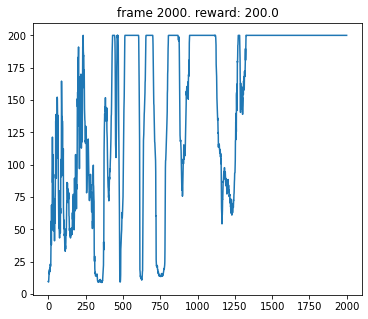

In [2]:
train()